In [118]:
%matplotlib inline
import time
import numpy as np
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import astropy as ap
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import sys
from collections import OrderedDict as odict
from collections import Counter
import numpy.linalg as la
import scipy.linalg as sla
import aipy

# NSIDE=32
# m=np.arange(hp.nside2npix(NSIDE))
# print m.shape, m[0:10], m[m.shape[0]-10:m.shape[0]]
# hp.mollview(m, title="Test")

In [119]:
import HERA_MapMaking_VisibilitySimulation as mmvs
from HERA_MapMaking_VisibilitySimulation import DATA_PATH
print (DATA_PATH)

/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/HERA_MapMaking_VisibilitySimulation/data


In [343]:
import sys
import resource
print(sys.executable)
print('Memory Used: {0}MB.'.format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024.))

/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/bin/python
Memory Used: 541812.0MB.


In [121]:
Simulation_For_All = True
Integration_Time = 10.7375
Frequency_Bin = 97656.245
antenna_num = 37 # number of antennas that enter simulation
flist = np.array([np.arange(100., 200., Frequency_Bin*10.**(-6)) for i in range(2)])
index_freq = np.array([len(flist[i]) / 2 for i in range(2)])
lsts_full = np.arange(-6., 6., Integration_Time / aipy.const.sidereal_day * 24.)
tlist_full = lsts_full * aipy.const.sidereal_day / 24.
tmask = np.ones_like(lsts_full).astype('bool')
lsts = lsts_full[tmask]
tlist = tlist_full[tmask]

ants = np.array([np.arange(antenna_num) for i in range(2)])
array_position = np.loadtxt(DATA_PATH + '/hera_positions_staged/antenna_positions_{0}.dat'.format(antenna_num))
antpos = np.array([array_position, array_position])

In [122]:
(tlist[-1] - tlist[0]) / 3600.

11.966347222223773

In [273]:
antenna_num = 243
ants = np.array([np.arange(antenna_num) for i in range(2)])
badants = []
array_position = np.loadtxt(DATA_PATH + '/hera_positions_staged/antenna_positions_{0}.dat'.format(antenna_num))
antpos = np.array([array_position, array_position])

In [274]:
array_position.shape

(243, 3)

In [275]:
antloc = {}
for i in range(2):
    antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))

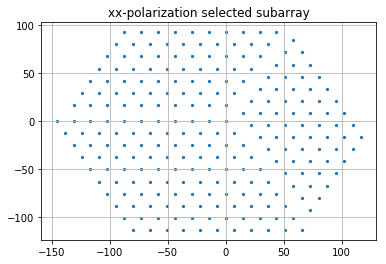

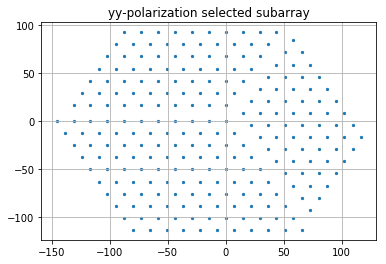

In [276]:
for j in range(2):
    plt.figure(100000 + 50 * j)
    plt.grid()
    if not Simulation_For_All:
        plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=500)
        _ = [plt.text(antloc[j][i, 0] - 1, antloc[j][i, 1], str(ants[j][i]), fontsize=5, color='w') for i in range(len(antloc[j]))]
    else:
        plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=5)
    plt.title('%s-polarization selected subarray' % ['xx', 'yy'][j])
    # plt.xlim(-30, 30)
    # plt.ylim(-30, 30)
    #plt.savefig(script_dir + '/../Output/%s-Nant%s-Ant_Locations.pdf' % (INSTRUMENT, len(antloc[0])))
    plt.show(block=False)
plt.clf()

In [277]:
baseline_safety_low = 0.  # Meters
baseline_safety_factor = 0.01  # max_ubl = 1.4*lambda*nside_standard/baseline_safety_factor
baseline_safety_xx = 0.  # Meters
baseline_safety_yy = 0.  # Meters
baseline_safety_zz = 0.
baseline_safety_xx_max = 1000.  # Meters
baseline_safety_yy_max = 1000.  # Meters
baseline_safety_zz_max = 2.1  # Meters
C = 299.792458
freq = 150 #MHz
nside_standard = 32

In [278]:
bls = [[], []]
for i in range(2):
    bls[i] = odict()
    for ant1 in range(antenna_num-1):
        for ant2 in range(ant1+1, antenna_num):
            x = (ant1, ant2)
            if (la.norm((antpos[i][x[0]] - antpos[i][x[1]])) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor) and (la.norm((antpos[i][x[0]] - antpos[i][x[1]])) / (C / freq) >= baseline_safety_low) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[0] >= baseline_safety_xx) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[1] >= baseline_safety_yy) \
                    and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[2] >= baseline_safety_zz) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[0] <= baseline_safety_xx_max) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[1] <= baseline_safety_yy_max) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[2] <= baseline_safety_zz_max):
                bls[i][x] = (antpos[i][x[0]] - antpos[i][x[1]])[[1, 0, 2]]
                bls[i][x][0] = - bls[i][x][0]

    print('Length of bls[{0}]: {1}'.format(i, len(bls[i].keys())))                

bsl_coord = [[], []]
bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
# bsl_coord_x=bsl_coord_y=bsl_coord
bsl_coord = np.array(bsl_coord)
print('Longest baseline: {0}:'.format(np.linalg.norm(bsl_coord, axis=-1).max()))

Length of bls[0]: 29403
Length of bls[1]: 29403
Longest baseline: 263.340185565:


In [129]:
bls[i].keys()

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101

In [130]:
tol = 0.01
Ubl_list_raw = [[], []]
Ubl_list = [[], []]
# ant_pos = [[], []]

Nubl_raw = np.zeros(2, dtype=int)
redundancy_pro = [[], []]
redundancy_pro_mfreq = [[], []]
bsl_coord_dred = [[], []]
bsl_coord_dred_mfreq = [[], []]

for i in range(2):
    Ubl_list_raw[i] = np.array(mmvs.arrayinfo.compute_reds_total(antloc[i], tol=tol))  ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
    Nubl_raw[i] = len(Ubl_list_raw[i])
    try:
        print('Length of Ubl_list_raw[%s] with Badants: %s' % (i, len(Ubl_list_raw[i])))
    except:
        print('No Ubl_list_raw with Badants printing.')
    try:
        Ubl_list_raw[i] = mmvs.arrayinfo.filter_reds_total(Ubl_list_raw[i], ex_ants=map(lambda k: antpos[i].keys().index(k), Badants))
    except:
        print('Badants not in the ant-list.')
    try:
        print('Length of Ubl_list_raw[%s]: %s' % (i, len(Ubl_list_raw[i])))
    except:
        print('No Ubl_list_raw printing.')
try:
    print('Bandants: %s' % str(badants))
    print('Bandants Index: %s' % str(map(lambda k: antpos[i].keys().index(k), badants)))
except:
    print('Bandants, Index not printed.')

for i in range(2):
    bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
    bsl_coord_dred_mfreq[i] = np.zeros((Nubl_raw[i], 3))



Length of Ubl_list_raw[0] with Badants: 1134
Badants not in the ant-list.
Length of Ubl_list_raw[0]: 1134
Length of Ubl_list_raw[1] with Badants: 1134
Badants not in the ant-list.
Length of Ubl_list_raw[1]: 1134
Bandants: []
Bandants Index: []


In [131]:
Assume_Array_Uniform_for_Acceleration = True
for i in range(2):
    time_dred = time.time()
    for i_ubl in range(len(Ubl_list_raw[i])):
        list_bsl = []
        for i_ubl_pair in range(len(Ubl_list_raw[i][i_ubl])):
            x = (Ubl_list_raw[i][i_ubl][i_ubl_pair][0], Ubl_list_raw[i][i_ubl][i_ubl_pair][1])    
            y = (x[1], x[0])
            if (la.norm((antpos[i][x[0]] - antpos[i][x[1]])) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor) and (la.norm((antpos[i][x[0]] - antpos[i][x[1]])) / (C / freq) >= baseline_safety_low) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[0] >= baseline_safety_xx) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[1] >= baseline_safety_yy) \
                    and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[2] >= baseline_safety_zz) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[0] <= baseline_safety_xx_max) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[1] <= baseline_safety_yy_max) and (np.abs(antpos[i][x[0]] - antpos[i][x[1]])[2] <= baseline_safety_zz_max):
                if x[0] <= x[1]:
                    list_bsl.append(bls[i].keys().index(x))
                else:
                    list_bsl.append(bls[i].keys().index(y))
            if Assume_Array_Uniform_for_Acceleration:
                break
        if len(list_bsl) >= 1:
            Ubl_list[i].append(list_bsl)
    print('Assume_Array_Uniform_for_Acceleration: {0}'.format(Assume_Array_Uniform_for_Acceleration))
    print('Length of Ubl_list[{0}]: {1}'.format(i, len(Ubl_list[i])))
    print('Time used to dred_baselines: {0} minutes. \n'.format((time.time() - time_dred)/60.))
    
for i in range(2):
    pol = ['xx', 'yy'][i]

    for i_ubl in range(Nubl_raw[0]):
        bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
        if not Assume_Array_Uniform_for_Acceleration:
            redundancy_pro[i].append(len(Ubl_list[i][i_ubl]))
        else:
            redundancy_pro[i].append(len(Ubl_list_raw[i][i_ubl]))
bsl_coord_dred_mfreq = bsl_coord_dred
redundancy_pro_mfreq = redundancy_pro

Assume_Array_Uniform_for_Acceleration: True
Length of Ubl_list[0]: 1134
Time used to dred_baselines: 0.12971726656 minutes. 

Assume_Array_Uniform_for_Acceleration: True
Length of Ubl_list[1]: 1134
Time used to dred_baselines: 0.121743230025 minutes. 



In [132]:
nt_used = len(lsts)
nf_used = len(flist[0])
# jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))


Keep_Red = False
redundancy = redundancy_pro
############################## Common UBL ###########################


ubls = {}
bls_red = {}
# freq = 150
#	nside_standard = 32
# baseline_safety_factor = 0.3

nBL_red = len(bsl_coord_x)
for p in ['x', 'y']:
    # ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
    bls_red[p] = globals()['bsl_coord_' + p]
# common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'])])

used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
nBL_red_used = len(used_common_bls_red)

if Keep_Red:
    nUBL = len(bsl_coord_x)
    for p in ['x', 'y']:
        # ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
        ubls[p] = globals()['bsl_coord_' + p]
    common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'])])

else:
    nUBL = len(bsl_coord_dred[0])
    nUBL_yy = len(bsl_coord_dred[1])
    for i in range(2):
        p = ['x', 'y'][i]
        ubls[p] = bsl_coord_dred[i]
    common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'])])

# common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
# manually filter UBLs
used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
nUBL_used = len(used_common_ubls)

ubl_index = {}  # stored index in each pol's ubl for the common ubls
used_redundancy = {}
for p in ['x', 'y']:
    ubl_index[p] = np.zeros(nUBL_used, dtype='int')
    for i, u in enumerate(used_common_ubls):
        if u in ubls[p]:
            ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
        elif -u in ubls[p]:
            ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
        else:
            raise Exception('Logical Error')

used_redundancy[0] = np.array(redundancy[0])[ubl_index['x'] - 1]
used_redundancy[1] = np.array(redundancy[0])[ubl_index['y'] - 1]

In [133]:
print('Selected Data Frequencies: ')
print(flist[0])
print(flist[1])

print('Selected Single Frequency: %s MHz' % freq)

print '\n>>>>>>>>>>Used nUBL = %s, nt = %s, nf = %s.\n' % (nUBL_used, nt_used, nf_used)
sys.stdout.flush()

Selected Data Frequencies: 
[100.         100.09765624 100.19531249 ... 199.80468239 199.90233863
 199.99999488]
[100.         100.09765624 100.19531249 ... 199.80468239 199.90233863
 199.99999488]
Selected Single Frequency: 150 MHz

>>>>>>>>>>Used nUBL = 1134, nt = 4013, nf = 1025.



In [134]:
bsl_coord_dred

[array([[ -50.57588358,   58.4       ,    0.        ],
        [-147.51299378, -167.9       ,    0.        ],
        [-181.2302495 ,   36.5       ,    0.        ],
        ...,
        [ -50.57588358,   87.6       ,    0.        ],
        [ -71.64916841,  109.5       ,    0.        ],
        [ -84.2931393 ,   87.6       ,    0.        ]]),
 array([[ -50.57588358,   58.4       ,    0.        ],
        [-147.51299378, -167.9       ,    0.        ],
        [-181.2302495 ,   36.5       ,    0.        ],
        ...,
        [ -50.57588358,   87.6       ,    0.        ],
        [ -71.64916841,  109.5       ,    0.        ],
        [ -84.2931393 ,   87.6       ,    0.        ]])]

In [135]:
used_common_ubls

array([[ -50.57588358,   58.4       ,    0.        ],
       [-147.51299378, -167.9       ,    0.        ],
       [-181.2302495 ,   36.5       ,    0.        ],
       ...,
       [ -50.57588358,   87.6       ,    0.        ],
       [ -71.64916841,  109.5       ,    0.        ],
       [ -84.2931393 ,   87.6       ,    0.        ]])

In [136]:
lsts_start = 2.
lsts_end = 5.
lsts_step = Integration_Time / aipy.const.sidereal_day * 24.
'-SimAll-{0:.2f}-{1:.2f}-{2:.2f}'.format(lsts_start, lsts_end, lsts_step*1000.)

'-SimAll-2.00-5.00-2.99'

In [137]:
Integration_Time / aipy.const.sidereal_day * 24.

0.0029908050744498773

In [138]:
10.**(-1.33)

0.046773514128719815

In [279]:
int(1025/1.01)

1014

In [206]:
nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

In [207]:
thetas_standard.shape

(12288,)

In [140]:
import numpy as np

def brightness_temperature_calculator_21cm(neutral_ratio=0.5, densitiy_ratio=1., h=0.7, omiga_b=0.04, omiga_m=0.3, red_shift=6., temperature_spin=20., temperature_cmb=20, difference_over_cmb=False):
	if not difference_over_cmb:
		T_21 = 26.8 * neutral_ratio * densitiy_ratio * (h * omiga_b / 0.0327) * (omiga_m / 0.307) ** (-0.5) * ((1 + red_shift) / 10.) ** 0.5
	else:
		T_21 = 26.8 * neutral_ratio * densitiy_ratio * (h * omiga_b / 0.0327) * (omiga_m / 0.307) ** (-0.5) * ((1 + red_shift) / 10.) ** 0.5 * ((temperature_spin - temperature_cmb) / temperature_spin)
	
	print('neutral_ratio={0}, density_ratio={1}, h={2}, omiga_b={3}, omiga_m={4}, red_shift={5}, temperture_spin={6} mk, temperature_cmb={7} mk, difference_over_cmb={8} \n'.format(neutral_ratio, densitiy_ratio, h, omiga_b, omiga_m, red_shift, temperature_spin, temperature_cmb, difference_over_cmb))
	print('T_21 = {0} mk'.format(T_21))
	
	return T_21 * 10. ** (-3)


def temperature_to_jansky_calculator(k=1.3806504 * 10. ** (-23), object_temperature=0.01, c=299792458., frequency=150, bubble_angular_radius=8.):
	jansky_per_beam = 2. * k * object_temperature * (c / (frequency * 10. ** 6)) ** 2 * np.pi * (np.pi / 180. / 60. * bubble_angular_radius) ** 2 * 10. ** (26)
	
	print('object_temperature={0} K, frequency={1} MHz, bubble_angular_radius={2} arcmin \n'.format(object_temperature, frequency, bubble_angular_radius))
	print('jansky_per_beam = {0} uJy/beam'.format(jansky_per_beam * 10.**6))
	
	return jansky_per_beam


def effective_gain_calculator(k=1.3806504 * 10. ** (-23), total_area=53878.314, effective_ratio=0.7):
	effective_gain = total_area * effective_ratio / (2 * k) * 10. ** (-26)
	
	print('effective_area={0} m^2 \n'.format(total_area * effective_ratio))
	print('effective_gain = {0} K/jansky \n'.format(effective_gain))
	
	return effective_gain


def rms_temperature_calculator(frequency=150, integration_time=10., frequency_channel_width=9.78 * 10. ** 4.):
	system_temperature = (100. + 120. * (frequency / 150) ** (-2.55)) / (frequency_channel_width * integration_time) ** 0.5
	
	print('frequency={0} MHz, integration_time={1} s, frequency_channel_width={2} HZ \n'.format(frequency, integration_time, frequency_channel_width))
	print('system_temperature = {0} K \n'.format((100. + 120. * (frequency / 150) ** (-2.55))))
	print('rms_temperature = {0} K \n'.format(system_temperature))
	
	return system_temperature

In [141]:
red_shift = 10.
T_21 = brightness_temperature_calculator_21cm(red_shift=red_shift, neutral_ratio=1.)

neutral_ratio=1.0, density_ratio=1.0, h=0.7, omiga_b=0.04, omiga_m=0.3, red_shift=10.0, temperture_spin=20.0 mk, temperature_cmb=20 mk, difference_over_cmb=False 

T_21 = 24.3472533928 mk


In [142]:
temperature_to_jansky_calculator(object_temperature=T_21, bubble_angular_radius=8.5, frequency=1420./(red_shift + 1.))

object_temperature=0.0243472533928 K, frequency=129.090909091 MHz, bubble_angular_radius=8.5 arcmin 

jansky_per_beam = 6963.91946992 uJy/beam


0.0069639194699155065

In [143]:
effective_gain = effective_gain_calculator(effective_ratio=0.7)

effective_area=37714.8198 m^2 

effective_gain = 13.6583525417 K/jansky 



In [144]:
rms_temperature = rms_temperature_calculator(integration_time=100.*3600, frequency=1420./(1.+red_shift))

frequency=129.090909091 MHz, integration_time=360000.0 s, frequency_channel_width=97800.0 HZ 

system_temperature = 275.966512024 K 

rms_temperature = 0.00147073933137 K 



In [145]:
sensitivity = rms_temperature / effective_gain
print('sensitivity = {0} uJy/beam'.format(sensitivity * 10.**6))


sensitivity = 107.680580574 uJy/beam


In [146]:
9. / (4.255 * 10.**-3) /60.

35.252643948296125

In [147]:
24.*60.*4.255/1000.

6.1272

In [148]:
print(13879.6/107.7)
print(2249.7/60.704)

128.8727948
37.0601607802


In [280]:
outfile_GSM_name = DATA_PATH + '/Maps_Data/Results_Fits_w-Data-CG-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt1530-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N-774.44.fits'
map_1 = fits.getdata(outfile_GSM_name).squeeze()
%matplotlib inline

Filename: /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/HERA_MapMaking_VisibilitySimulation/data/Maps_Data/Results_Fits_w-Data-CG-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt1530-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N-774.44.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   (12288,)   float64   
Data shape, min, max:  (12288,) -139.58774575294163 1084.8540418213663
STD of the Map32-wholeday without Fornax A: 30.5973010187


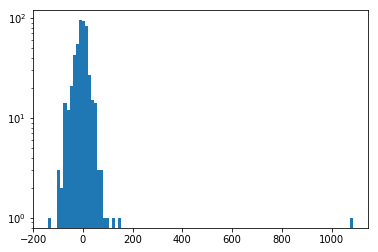

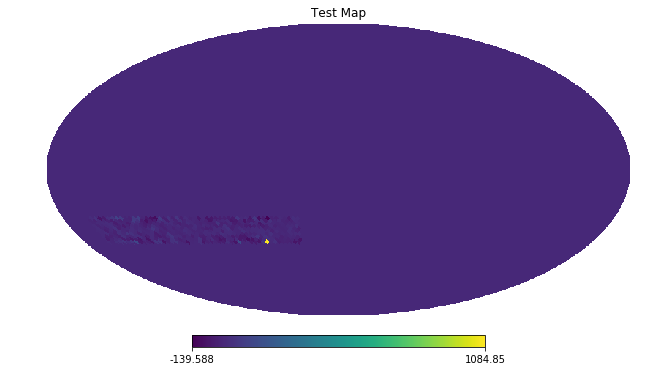

In [281]:
# hdul = fits.open('test.fits')
hdul = fits.open(outfile_GSM_name)
hdul.info()
hdr = hdul[0].header
data = hdul[0].data
print 'Data shape, min, max: ',data.shape, min(data), max(data)
map_fit = fits.getdata(outfile_GSM_name)
print('STD of the Map32-wholeday without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-1]][np.abs(map_fit[np.argsort(map_fit)[:-1]]) > 10**(-5)])))
plt.hist(map_fit[np.abs(map_fit) > 10.**(-5)],bins=100, log=True)
hdul.close()
hp.mollview(map_fit, nest=True, title="Test Map")
plt.show()
plt.close()

In [151]:
nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_whole_32 = fits.getdata(outfile_GSM_name).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_whole_32)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_whole_32)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_whole_32[np.argsort(ww_solution_whole_32)[-40:]]))





Bright_Pixels_Data: [[-35.68533471 -25.94447977 -30.         -32.7971683  -32.7971683
  -32.7971683  -27.27961274 -27.27961274 -30.         -31.38816646
  -25.94447977 -28.63098984 -32.7971683  -37.16889966 -34.22886633
  -28.63098984 -32.7971683  -32.7971683  -31.38816646 -27.27961274
  -30.         -27.27961274 -35.68533471 -30.         -32.7971683
  -30.         -31.38816646 -31.38816646 -31.38816646 -32.7971683
  -32.7971683  -27.27961274 -31.38816646 -35.68533471 -35.68533471
  -24.62431835 -27.27961274 -31.38816646 -24.62431835 -35.68533471
  -30.         -24.62431835 -31.38816646 -31.38816646 -34.22886633
  -30.         -24.62431835 -32.7971683  -34.22886633 -31.38816646
  -30.         -31.38816646 -28.63098984 -24.62431835 -34.22886633
  -32.7971683  -37.16889966 -28.63098984 -27.27961274 -27.27961274
  -25.94447977 -27.27961274 -31.38816646 -31.38816646 -28.63098984
  -34.22886633 -31.38816646 -27.27961274 -32.7971683  -24.62431835
  -37.16889966 -25.94447977 -25.94447977 -25.

In [152]:
# hp.cartview(testmap, title="Test Map", norm='log', min=10, max=1250, coord='C', latra=[-50,-10],xsize=360, nest=True)
# hp.graticule(dpar=10,dmer=10)

In [282]:
filenames_32 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [283]:
filenames_32 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-*-gW-0.050119-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [284]:
# filenames_64 = sorted(glob.glob("{0}/../data/results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [285]:
filenames_64 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-*-gW-0.050119-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [286]:
filenames_32_321 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [287]:
filenames_64_321 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [288]:
filenames_32_415 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [289]:
filenames_64_415 = sorted(glob.glob("{0}/../data/Maps_Data/results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-*-gW-0.048978-*-dipole-*-*-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits".format(DATA_PATH)))

In [290]:
filenames_64[0].split('/')[-1]

'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-110.11-gW-0.050119-110.1074MHz-dipole-nubl990-nt1578-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits'

In [291]:
sys.stdout.flush()

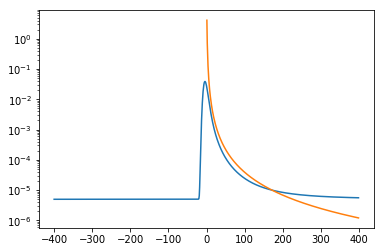

In [292]:
from scipy.fftpack import fft, ifft
num_input = 100001
scale_input = 1
num_plot = 800
sky_ratio = 1./(12*32**2)
# ift = num_input * 1./(2*np.pi)**0.5 * ifft(np.exp(16000*sky_ratio*np.pi*2.3478136461808763 * (- np.arange(0, 2*np.pi*scale_input, 2*scale_input*np.pi/num_input) * 1j) ** 1.51))
ift = ifft(np.exp(16000*sky_ratio*np.pi*2.3478136461808763 * (- np.arange(0, 2*np.pi*scale_input, 2*scale_input*np.pi/num_input) * 1j) ** 1.51))
# ift = num_input * 1./(2*np.pi)**0.5 * ifft(np.exp(16000*sky_ratio*np.pi*2.3478136461808763 * (- np.arange(num_input) * 1j) ** 1.51))
ft = 1./num_input * fft(np.exp(16000*sky_ratio*np.pi*2.3478136461808763 * (- np.arange(0, 2*scale_input*np.pi, 2*scale_input*np.pi/num_input) * 1j) ** 1.51))
# np.fft.fft(ift)
# plt.plot(np.arange(-0.5*num_input, 0.5*num_input,1), ift[np.arange(-num_input/2, num_input/2, 1)])
plt.plot(np.arange(-num_plot/2, num_plot/2,1), ft[np.arange(-num_plot/2, num_plot/2, 1)])
plt.plot(np.arange(1, num_plot/2, 1), 16000*sky_ratio*np.pi*np.arange(1, num_plot/2, 1)**(-2.51))
plt.yscale('log')
plt.show()

(0, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-110.11-gW-0.050119-110.1074MHz-dipole-nubl990-nt1578-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 451.815980696
>>>>>>>> Maximum in the Map: 11968.7384261
>>>>>>>> Number of Valid Pixels: 974
110.1074MHz


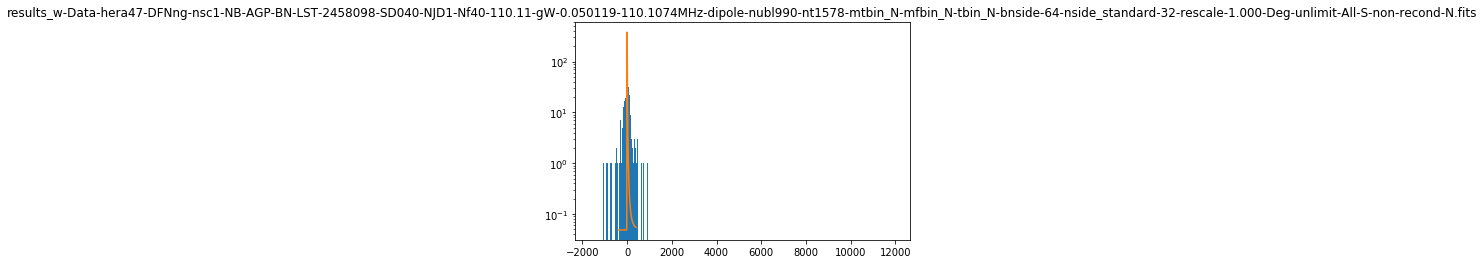

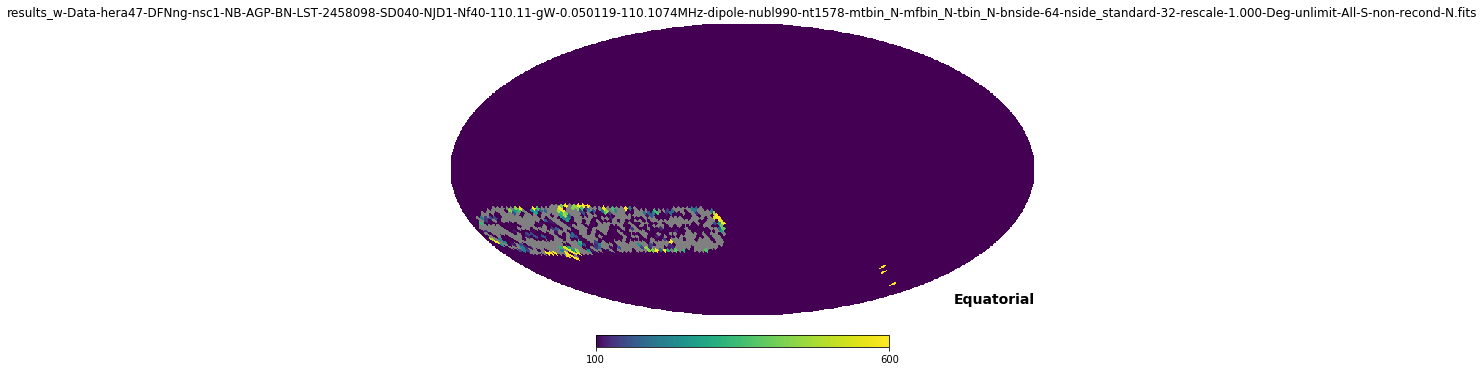

(1, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-114.79-gW-0.050119-114.7949MHz-dipole-nubl990-nt1567-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 612.480401232
>>>>>>>> Maximum in the Map: 14362.7402058
>>>>>>>> Number of Valid Pixels: 922
114.7949MHz


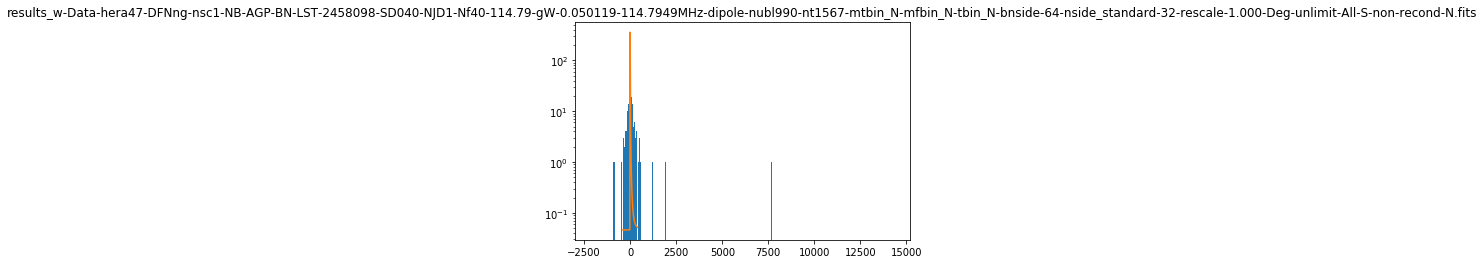

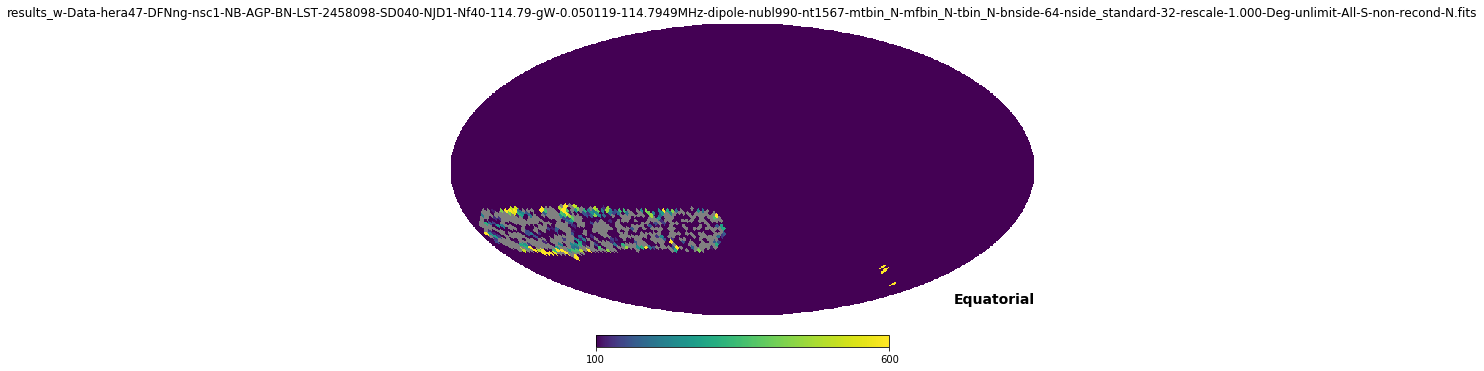

(2, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-119.48-gW-0.050119-119.4824MHz-dipole-nubl990-nt1341-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 321.10294264
>>>>>>>> Maximum in the Map: 4052.95130397
>>>>>>>> Number of Valid Pixels: 789
119.4824MHz


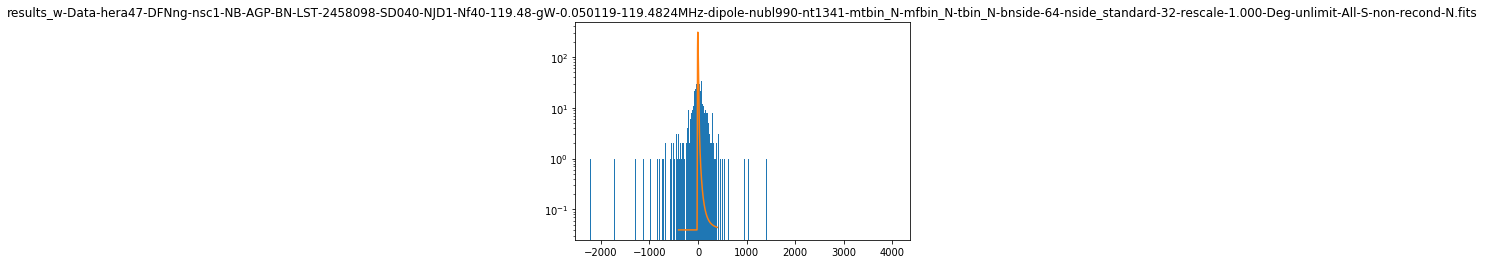

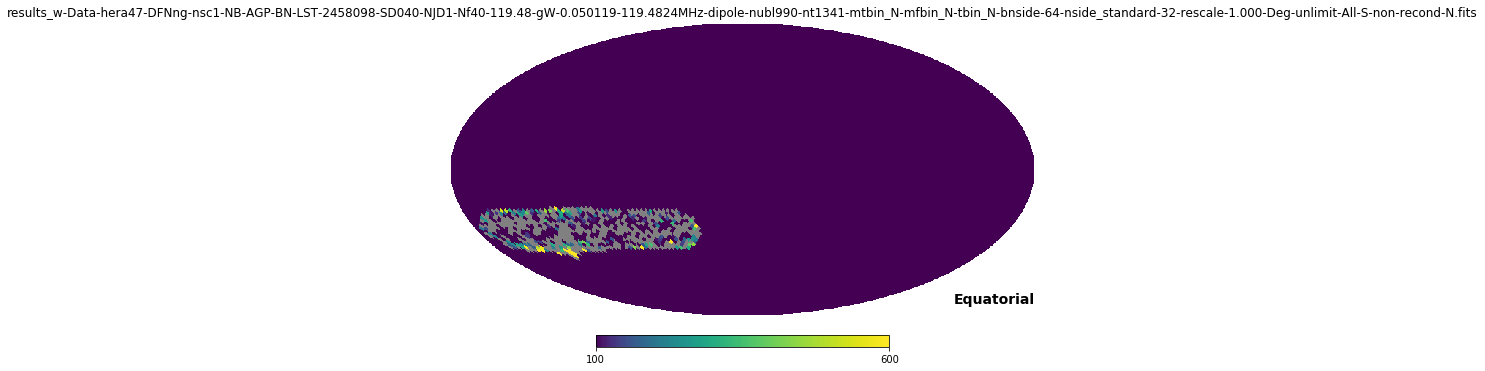

(3, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-125.73-gW-0.050119-125.7324MHz-dipole-nubl990-nt1173-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 274.948043148
>>>>>>>> Maximum in the Map: 3525.74950258
>>>>>>>> Number of Valid Pixels: 650
125.7324MHz


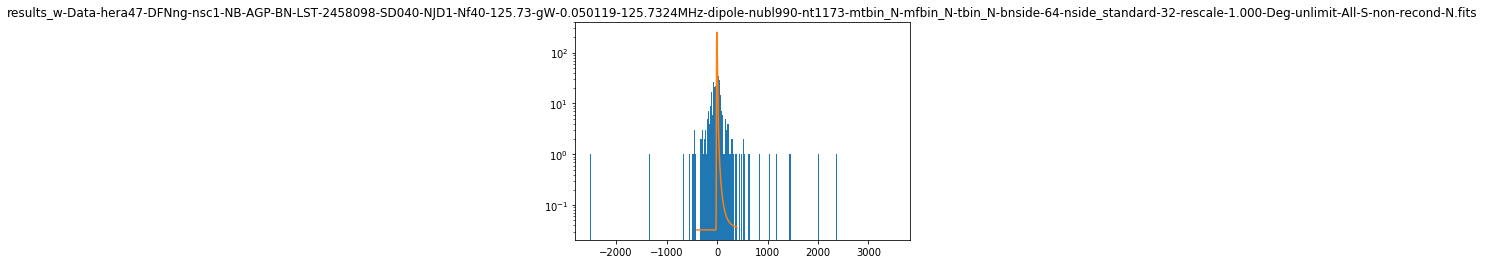

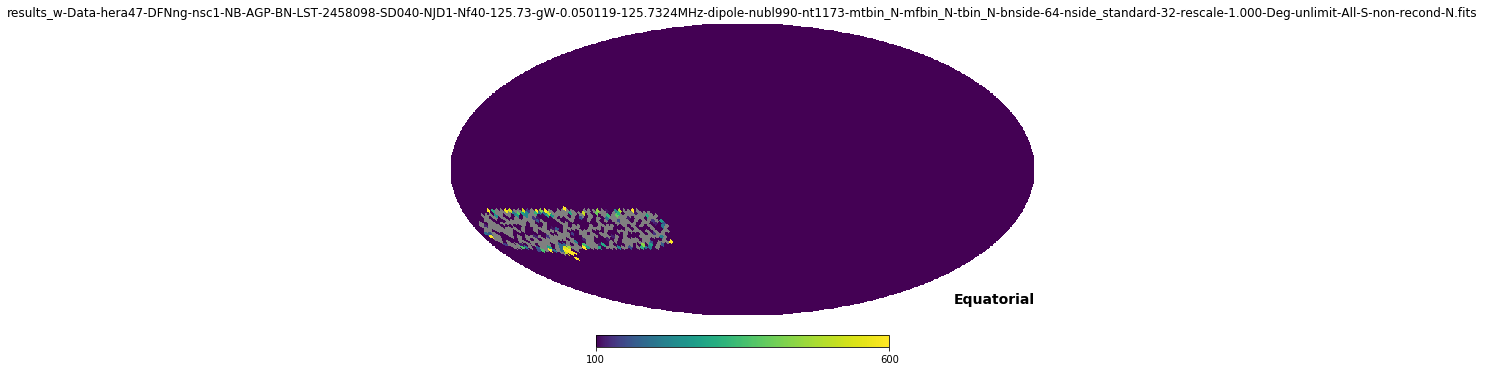

(4, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-130.42-gW-0.050119-130.4199MHz-dipole-nubl990-nt1559-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 166.890587967
>>>>>>>> Maximum in the Map: 2291.09251107
>>>>>>>> Number of Valid Pixels: 825
130.4199MHz


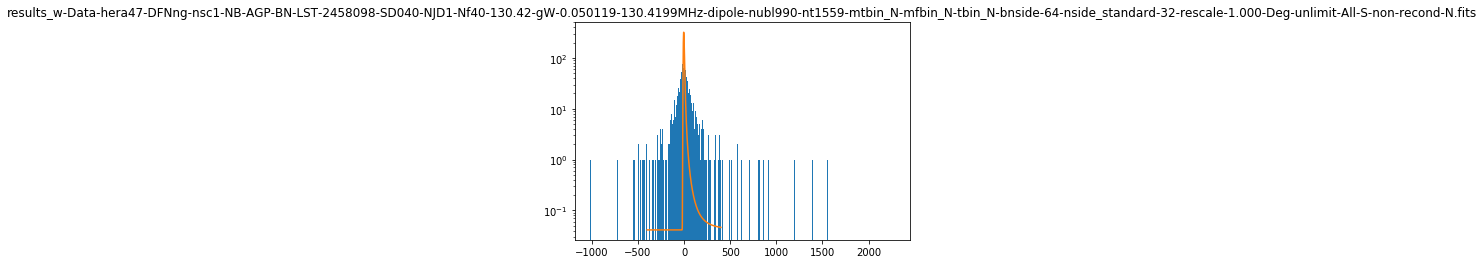

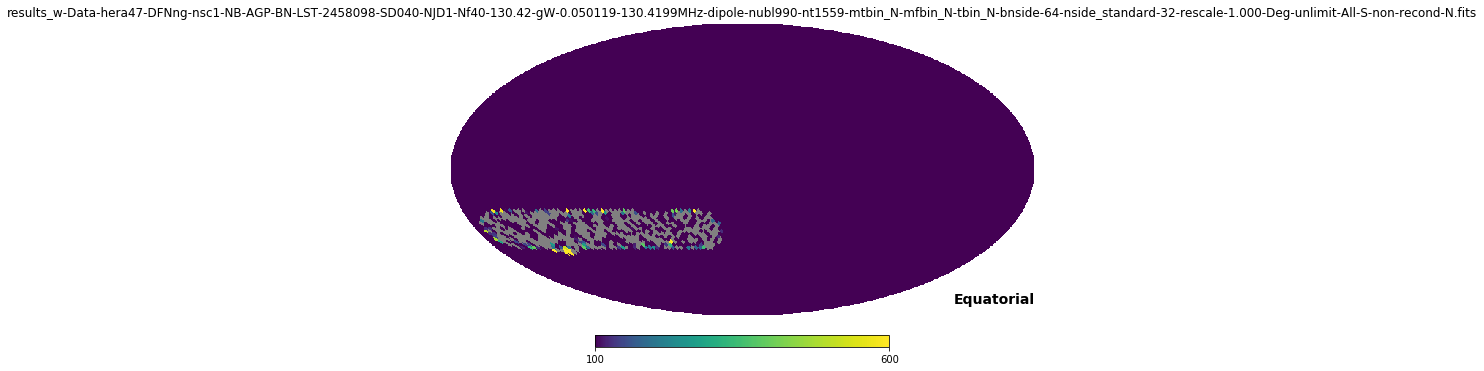

(5, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-135.11-gW-0.050119-135.1074MHz-dipole-nubl990-nt1577-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 117.726732596
>>>>>>>> Maximum in the Map: 1711.98081801
>>>>>>>> Number of Valid Pixels: 804
135.1074MHz


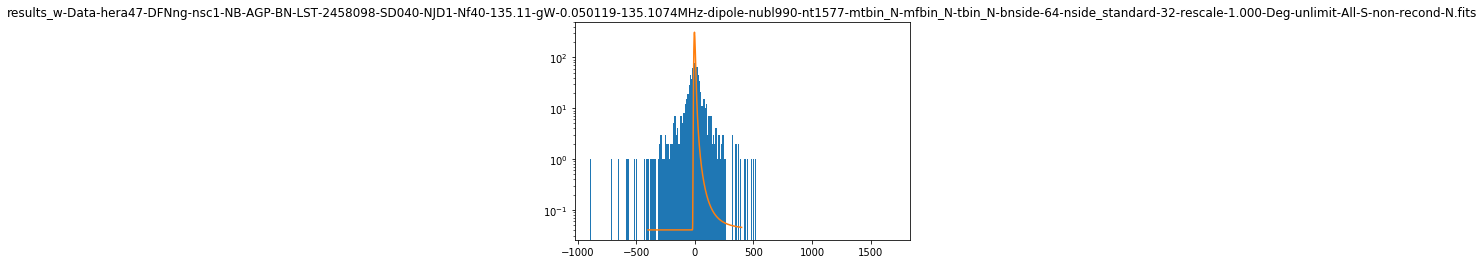

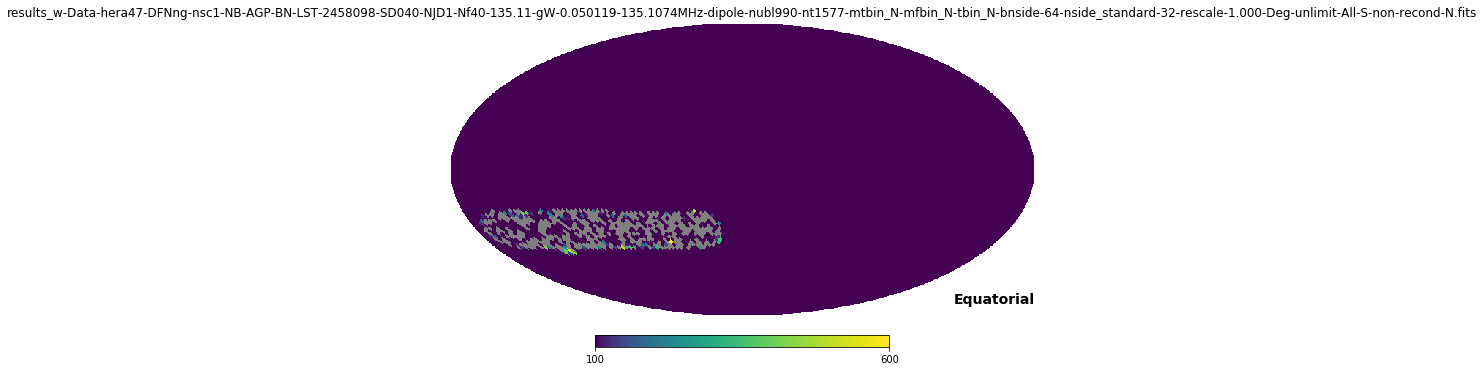

(6, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-139.79-gW-0.050119-139.7949MHz-dipole-nubl990-nt1579-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 173.315922147
>>>>>>>> Maximum in the Map: 3515.24772355
>>>>>>>> Number of Valid Pixels: 775
139.7949MHz


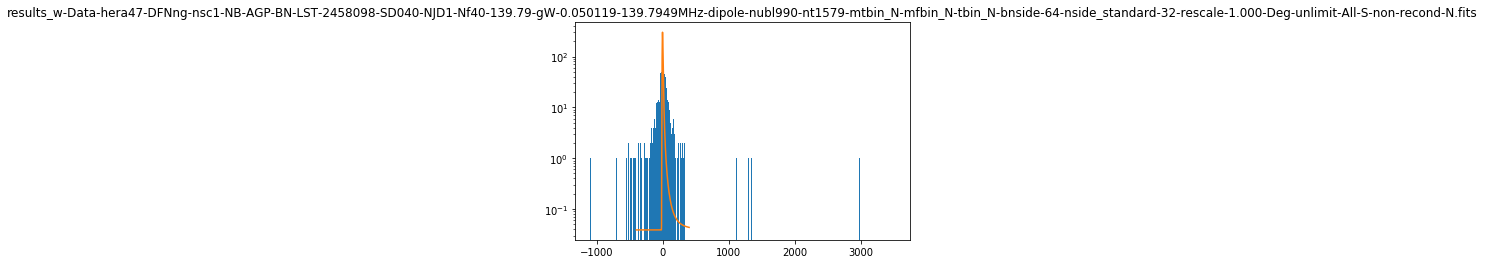

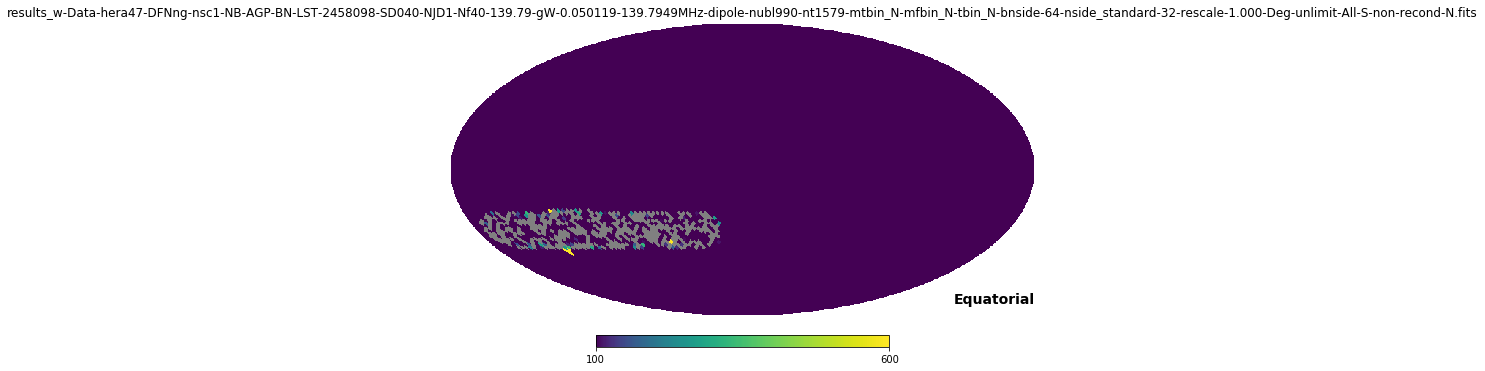

(7, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-144.48-gW-0.050119-144.4824MHz-dipole-nubl990-nt1574-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 134.38781307
>>>>>>>> Maximum in the Map: 1294.6898538
>>>>>>>> Number of Valid Pixels: 721
144.4824MHz


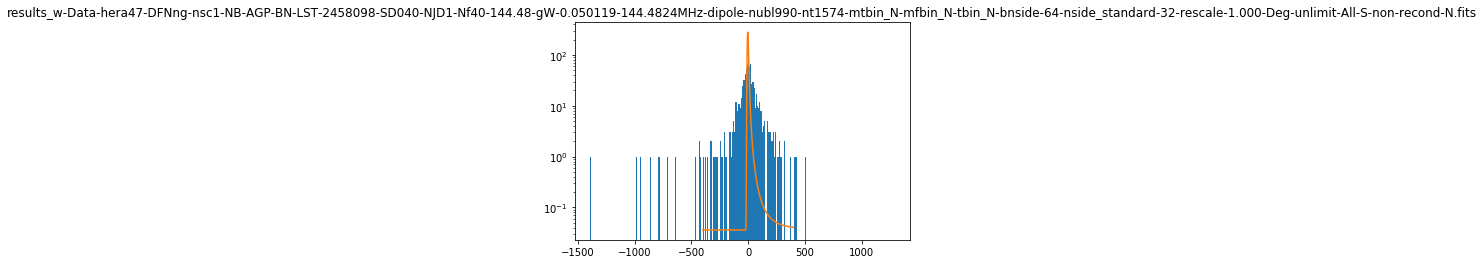

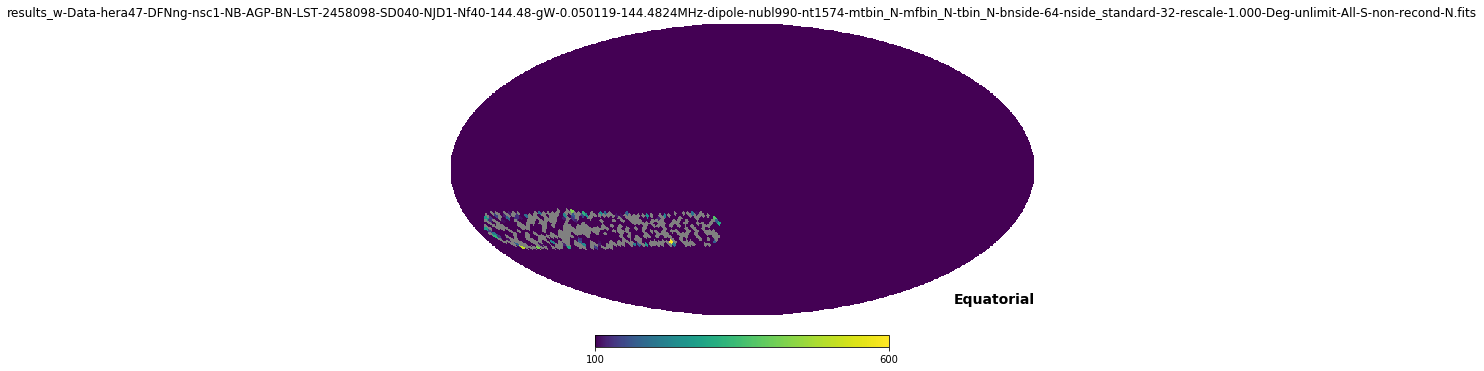

(8, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-150.73-gW-0.050119-150.7324MHz-dipole-nubl990-nt1530-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 95.9123835616
>>>>>>>> Maximum in the Map: 1019.55531256
>>>>>>>> Number of Valid Pixels: 701
150.7324MHz


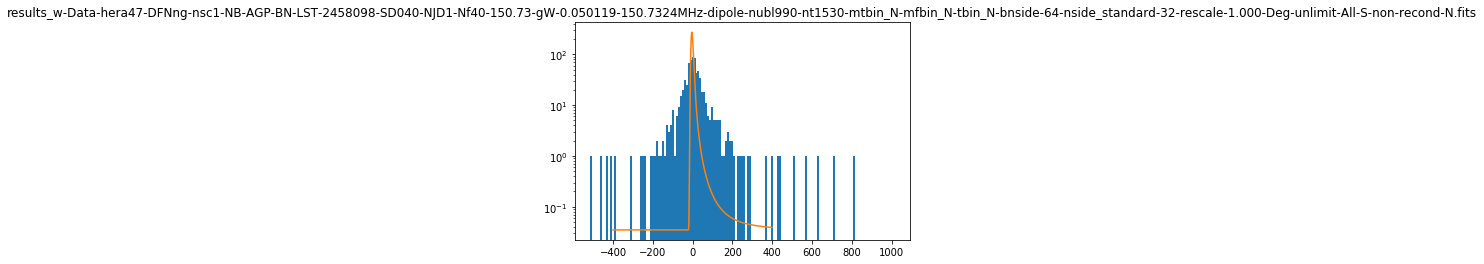

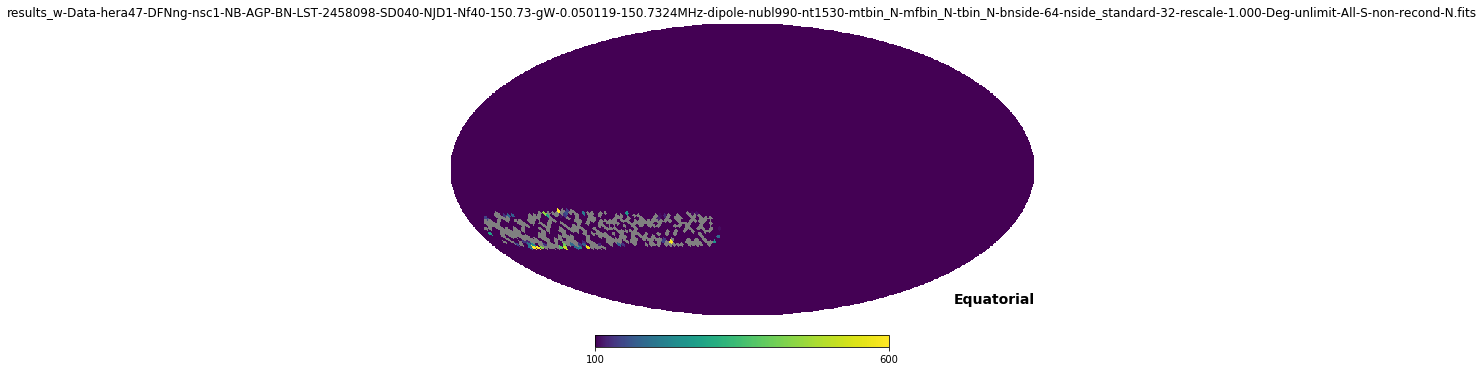

(9, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-155.42-gW-0.050119-155.4199MHz-dipole-nubl990-nt1540-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 106.871512858
>>>>>>>> Maximum in the Map: 942.189918814
>>>>>>>> Number of Valid Pixels: 696
155.4199MHz


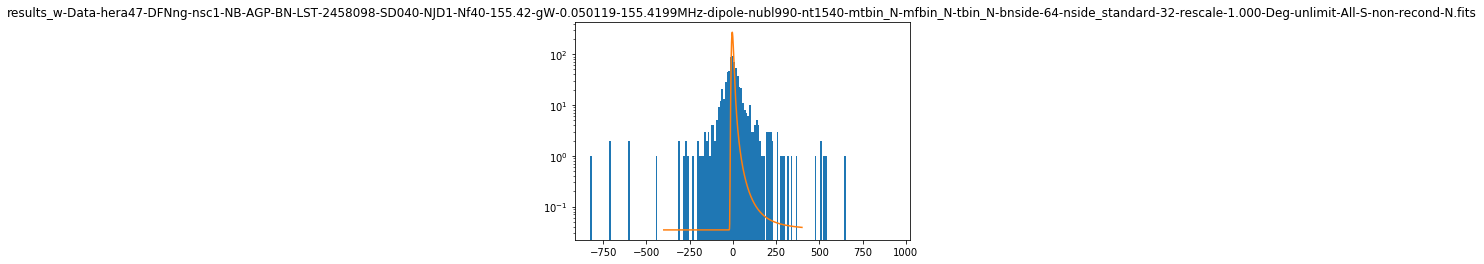

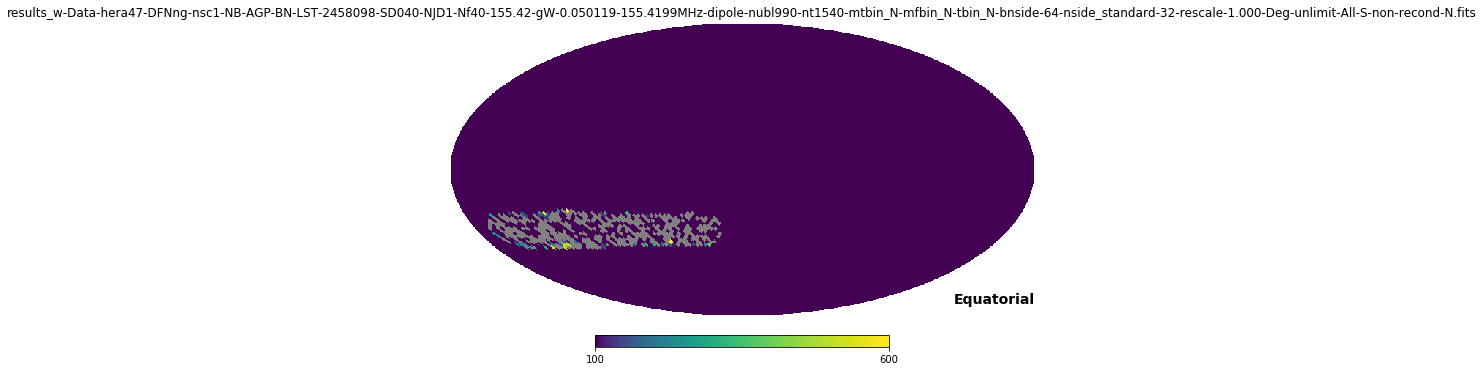

(10, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-160.11-gW-0.050119-160.1074MHz-dipole-nubl990-nt1577-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 110.913496117
>>>>>>>> Maximum in the Map: 845.559354434
>>>>>>>> Number of Valid Pixels: 705
160.1074MHz


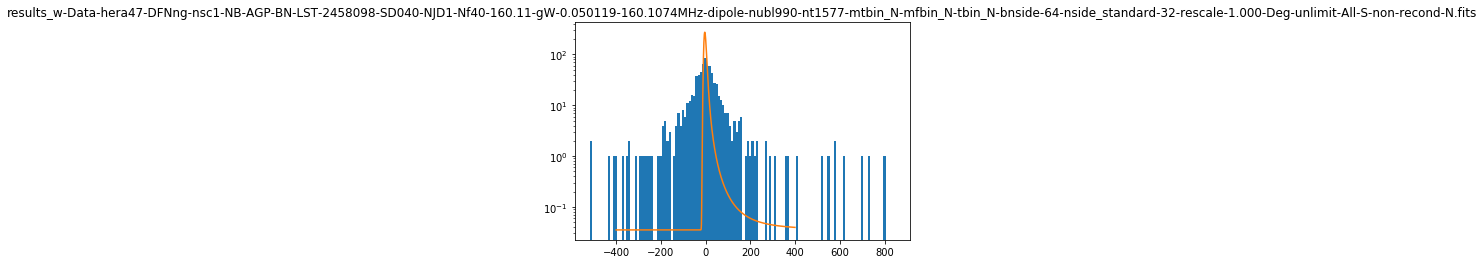

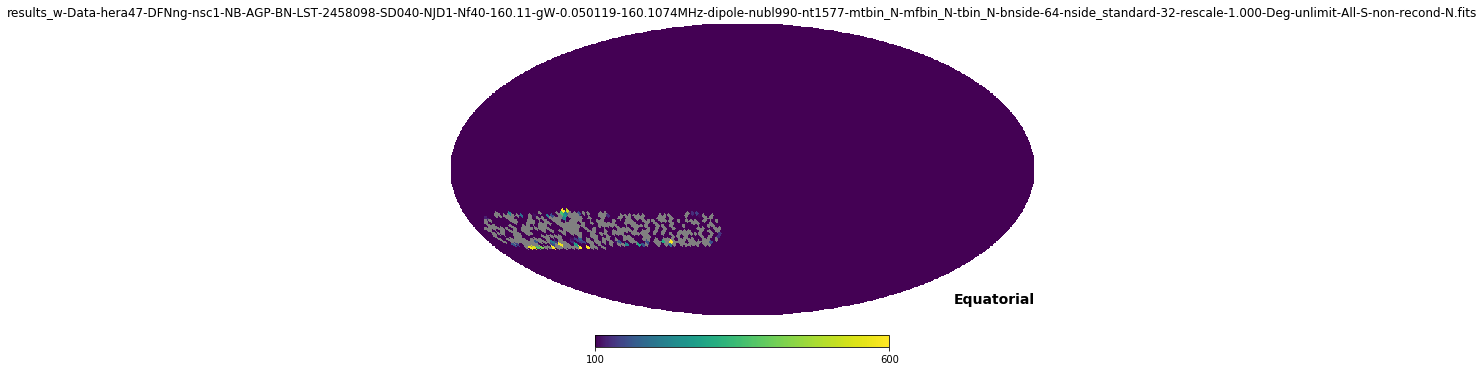

(11, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-164.79-gW-0.050119-164.7949MHz-dipole-nubl990-nt1581-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 102.559244534
>>>>>>>> Maximum in the Map: 1125.71001305
>>>>>>>> Number of Valid Pixels: 688
164.7949MHz


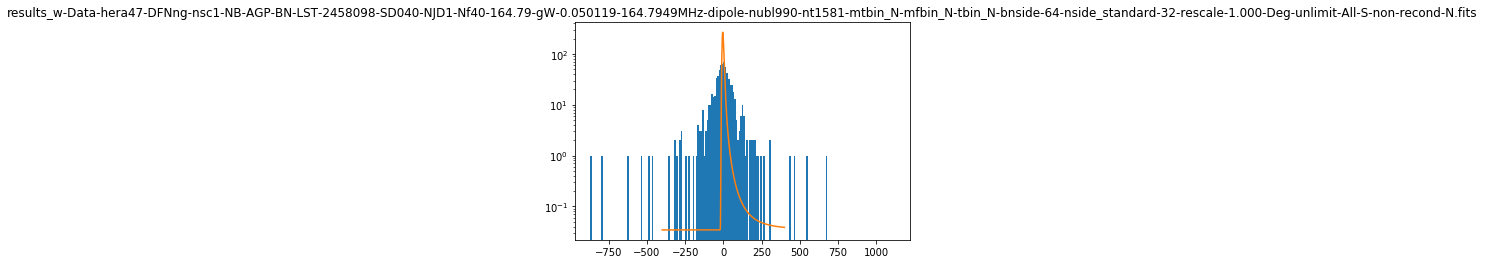

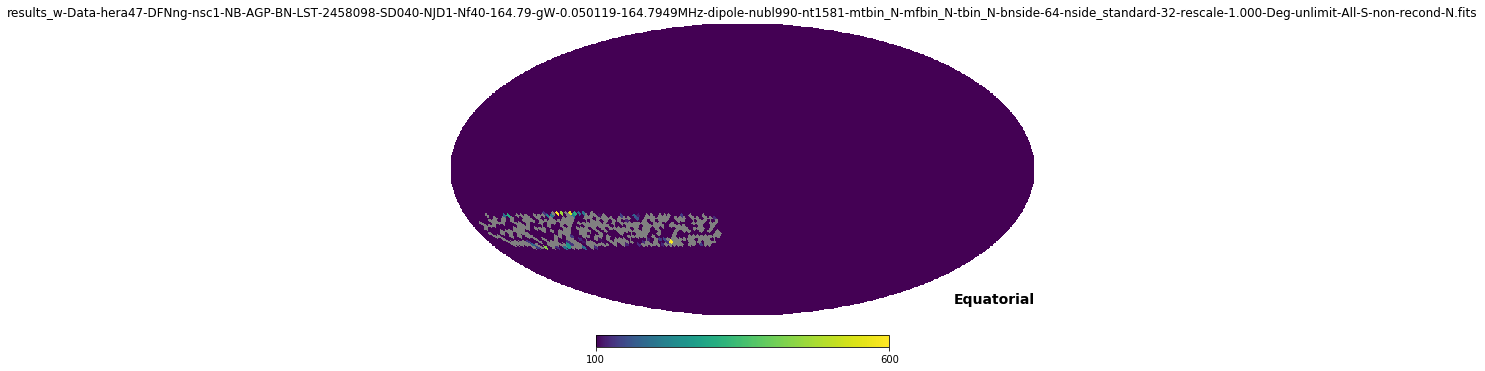

(12, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-171.04-gW-0.050119-171.0449MHz-dipole-nubl990-nt1533-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 86.0145429983
>>>>>>>> Maximum in the Map: 977.920843904
>>>>>>>> Number of Valid Pixels: 644
171.0449MHz


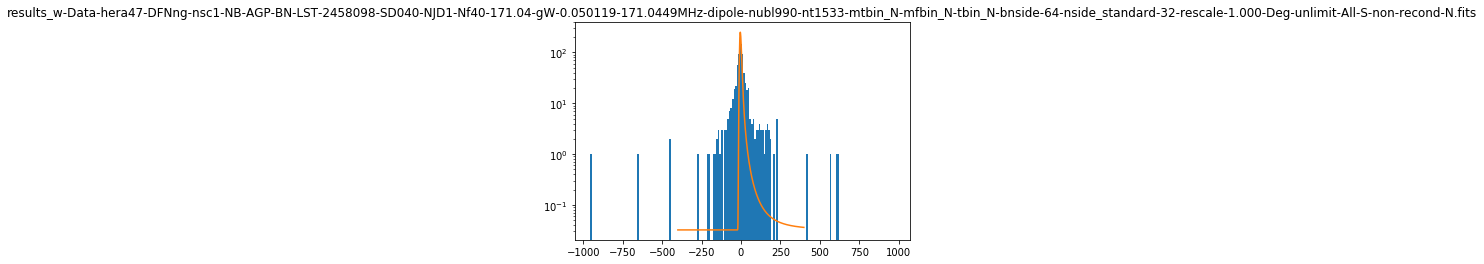

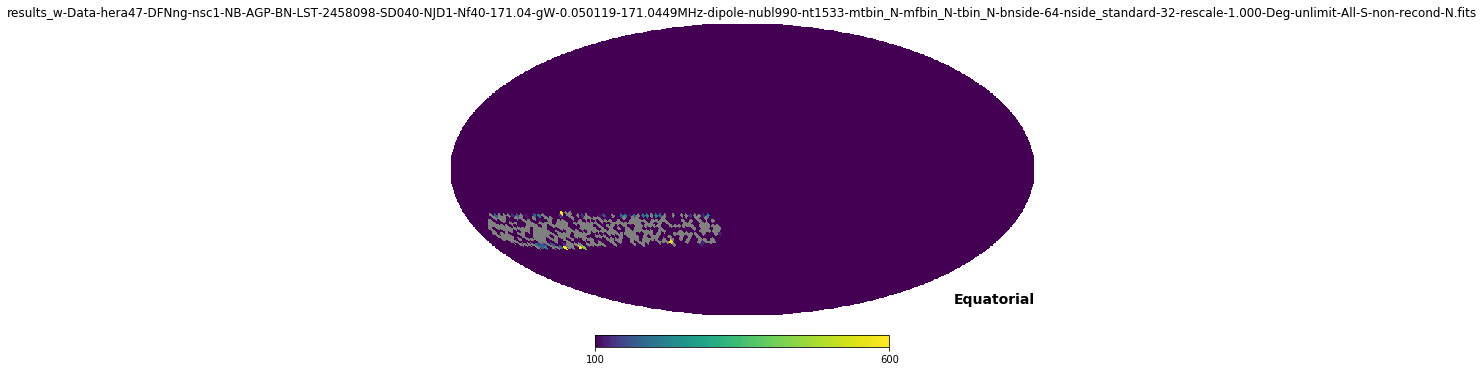

(13, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-174.17-gW-0.050119-174.1699MHz-dipole-nubl990-nt1383-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 70.7144766129
>>>>>>>> Maximum in the Map: 661.269408621
>>>>>>>> Number of Valid Pixels: 587
174.1699MHz


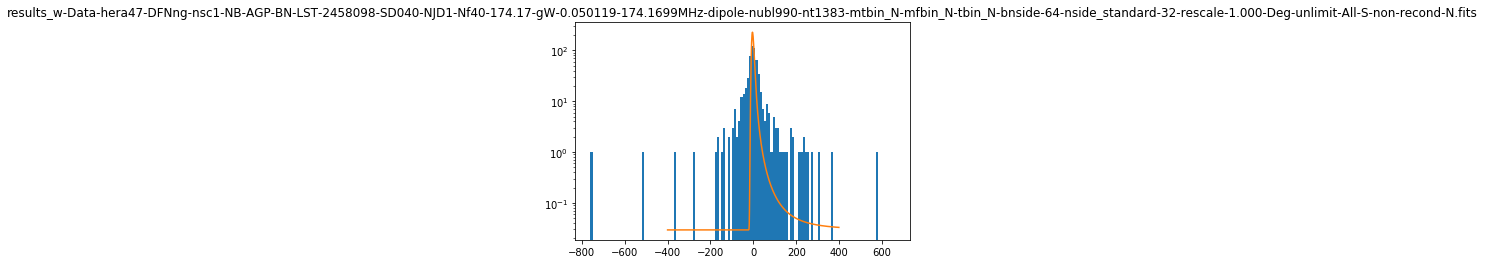

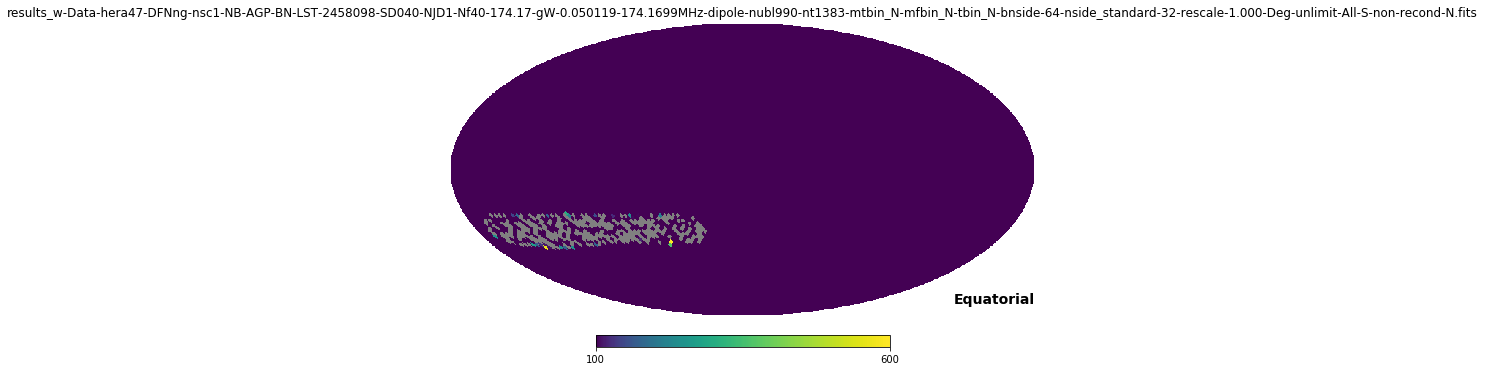

(14, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-178.86-gW-0.050119-178.8574MHz-dipole-nubl990-nt1435-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 75.6402992861
>>>>>>>> Maximum in the Map: 589.522126344
>>>>>>>> Number of Valid Pixels: 613
178.8574MHz


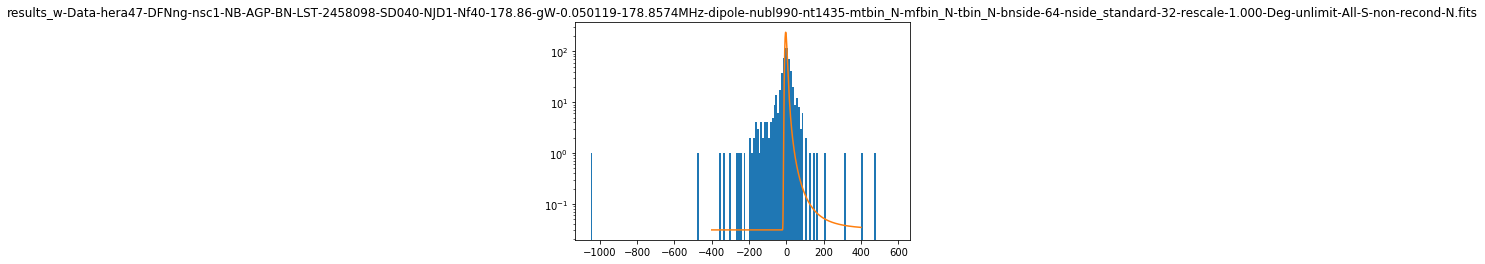

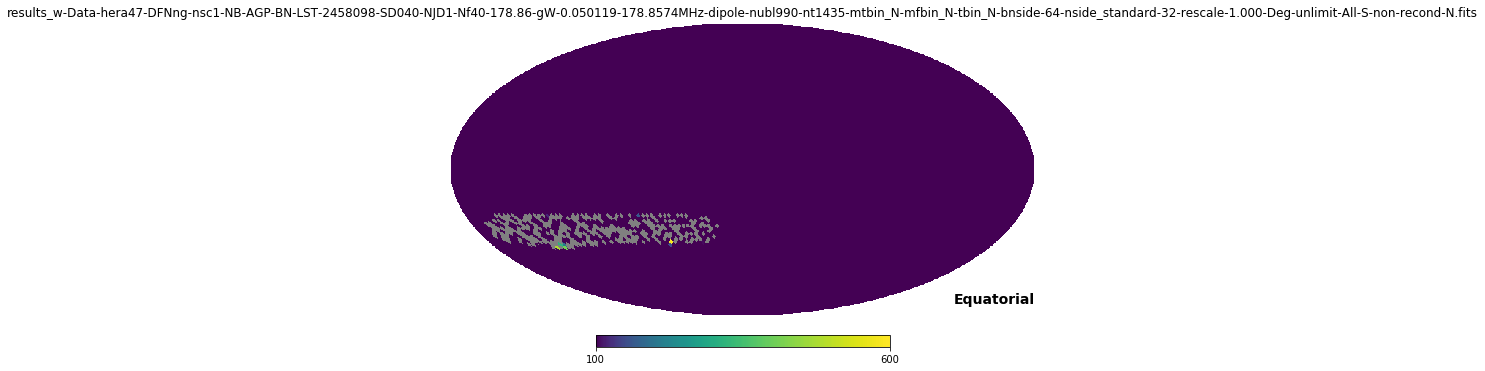

(15, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-185.11-gW-0.050119-185.1074MHz-dipole-nubl990-nt1415-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 55.9841894791
>>>>>>>> Maximum in the Map: 437.439133974
>>>>>>>> Number of Valid Pixels: 604
185.1074MHz


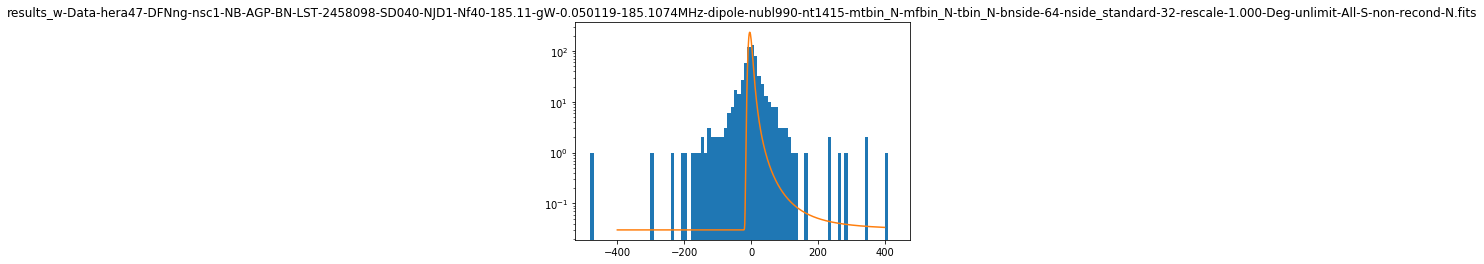

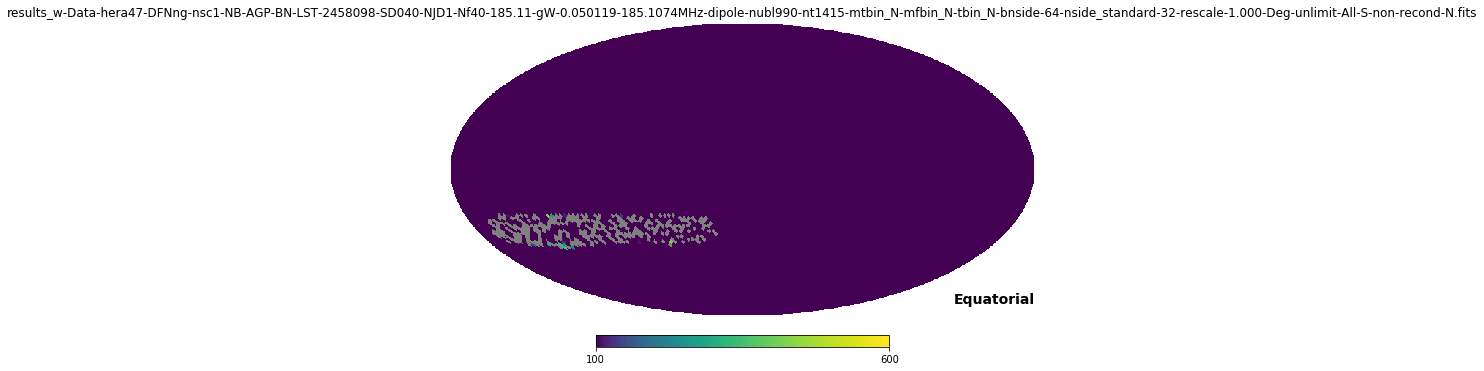

(16, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-186.67-gW-0.050119-186.6699MHz-dipole-nubl990-nt948-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-wholeday without Fornax A: 50.1799591655
>>>>>>>> Maximum in the Map: 969.28821607
>>>>>>>> Number of Valid Pixels: 441
186.6699MHz


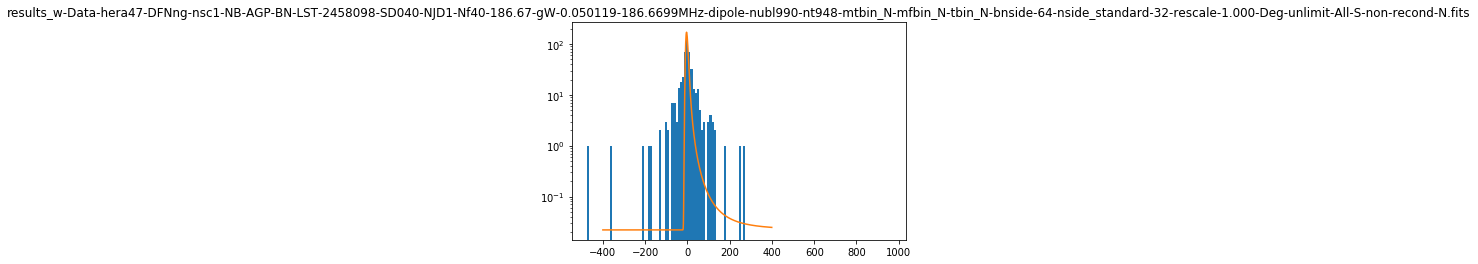

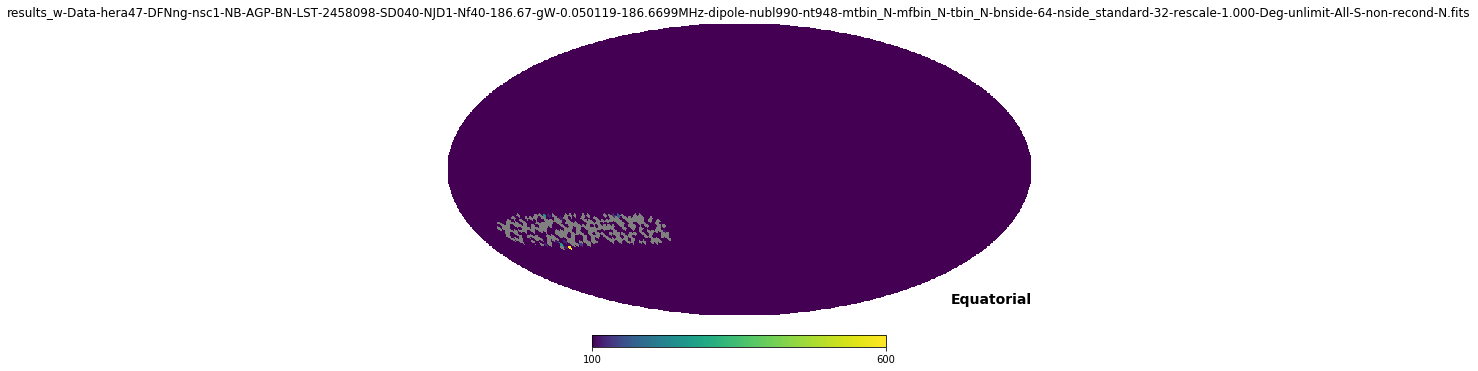

In [293]:
sys.stdout.flush()
bin_width = 10
maps_mfreq = []
freqs_common_32 = []
for id_file, fitfile in enumerate(filenames_32):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map32-wholeday without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-1]][np.abs(map_fit[np.argsort(map_fit)[:-1]]) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 250:
        maps_mfreq.append(map_fit)
        for string_piece in name.split('-'):
            if 'MHz' in string_piece:
                freqs_common_32.append(float(string_piece[:-3]))
                print(string_piece)
    
    plt.figure(10000 + id_file)
#     plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=np.arange(map_fit[np.abs(map_fit) > 10**(-5)].min(), map_fit[np.abs(map_fit) > 10**(-5)].max(), bin_width), log=True)
    plt.plot(np.arange(-num_plot/2, num_plot/2,1), bin_width * len(map_fit[np.abs(map_fit) > 10**(-5)]) * ft[np.arange(-num_plot/2, num_plot/2, 1)])
    plt.yscale('log')
    plt.title(name)
    plt.show()
    plt.close()
    plt.figure(50000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    plt.close()
    

In [294]:
1420. / 199.9 - 1420. / 200.

0.0035517758879439754

In [295]:
num_test = 100
scale_test = 10
test1 = np.exp(np.arange(num_test) * 2*np.pi*scale_test/num_test * 1j)
test1_fft = fft(test1)
test1_fft_ifft = ifft(test1_fft)
print(test1_fft)
print(np.abs(test1_fft_ifft - test1).max())

[-1.03250741e-14+5.88758350e-15j  1.31845400e-14-1.21748919e-14j
 -2.77555756e-14+5.42988840e-15j  8.49970670e-16-5.61074826e-15j
  1.18476637e-15+2.42973638e-14j -1.28082040e-14+4.02339655e-15j
 -4.73731515e-14-6.96957750e-15j  1.31812785e-14-7.77894790e-15j
 -2.74406670e-14+1.66716513e-14j -4.12899160e-14-1.40335028e-14j
  1.00000000e+02-1.34882302e-13j  4.11838044e-14-1.44484550e-14j
  2.65484510e-14+1.56683741e-14j -1.28031322e-14-6.98072168e-15j
  5.03037393e-14-1.06833741e-14j  1.28373855e-14+4.37476448e-15j
 -1.02318871e-15+2.39980289e-14j -1.08543692e-15-5.44979974e-15j
  2.88136983e-14+6.19255611e-15j -1.38939001e-14-1.22000034e-14j
  1.07720463e-14+5.38988733e-15j  1.84380689e-14+1.13019739e-15j
  1.47933095e-14+2.66027792e-14j -7.77302592e-15+1.37013228e-14j
 -8.34341159e-15-1.04661654e-14j  1.30972302e-14+1.39118025e-15j
  3.15659141e-14+1.36550623e-14j  1.60498418e-14+1.81193853e-14j
 -3.53655775e-15+3.98887018e-14j -3.47972675e-14+2.22796784e-14j
 -1.65535271e-14-2.124376

In [296]:
np.exp(2.3478136461808763 * (- np.arange(0, 2*np.pi, 2*np.pi/num_input) * 1j) ** 1.51).sum()

(7121.239032764622-3980.510677458549j)

In [297]:
maps_mfreq_32 = []
for id_file, fitfile in enumerate(filenames_32):
    name = fitfile.split('/')[-1]
#     print(id_file, name)[]
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 250.:
        maps_mfreq_32.append(map_fit)
        
maps_mfreq_32 = np.array(maps_mfreq_32)
commom_vp_mask_32 = np.prod(np.abs(maps_mfreq_32) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_32 = maps_mfreq_32[:, commom_vp_mask_32]
print('maps_mfreq_32 shape: {}'.format(maps_mfreq_32.shape))
print('maps_mfreq_common_32 shape: {}'.format(maps_mfreq_common_32.shape))
print('Number of Common Valid Pixels-32: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_32) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_32.T)
maps_mfreq_common_32_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_32_eigValues =  pca.explained_variance_
# maps_mfreq_common_32_eigValues = pca.singular_values_
maps_mfreq_common_32_eigVectors = pca.components_
maps_mfreq_common_32_newspace = pca.fit_transform(maps_mfreq_common_32.T)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_32_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_32_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_32_eigVectors.shape))
print('Maps32_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_32_newspace.shape))
print('Maps32_Common_NewSpace: {}\n'.format(maps_mfreq_common_32_newspace))

maps_mfreq_common_32_reconstruct = np.dot(maps_mfreq_common_32_newspace, maps_mfreq_common_32_eigVectors).T
print('Shape of maps_mfreq_common_32_reconstruct:{}\n'.format(maps_mfreq_common_32_reconstruct.shape))
Discrepancy_reconstruct_32 = maps_mfreq_common_32 - maps_mfreq_common_32_reconstruct
Discrepancy_reconstruct_ratio_32 = np.linalg.norm(Discrepancy_reconstruct_32, axis=1) / np.linalg.norm(maps_mfreq_common_32, axis=1)
print('Discrepancy_reconstruct_ratio: {}\n'.format(Discrepancy_reconstruct_ratio_32))

ai_32 = np.ones_like(maps_mfreq_common_32_newspace)
Discrepancy_reconstruct_square_32 = np.corrcoef(maps_mfreq_common_32)
for id_pix in range(maps_mfreq_common_32.shape[1]):
    #Discrepancy_reconstruct_square = np.cov(Discrepancy_reconstruct[:, id_pix])
    PtNiPi_32 = np.linalg.inv((maps_mfreq_common_32_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square_32))).dot(maps_mfreq_common_32_eigVectors.T))
    PtNi_32 = maps_mfreq_common_32_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square_32))
    ai_32[id_pix] = PtNiPi_32.dot(PtNi_32.dot(maps_mfreq_common_32[:, id_pix]))
maps_mfreq_common_32_reconstruct_fit = np.dot(ai_32, maps_mfreq_common_32_eigVectors).T
print('Shape of maps_mfreq_common_32_reconstruct_fit:{}\n'.format(maps_mfreq_common_32_reconstruct_fit.shape))
Discrepancy_reconstruct_fit_32 = maps_mfreq_common_32 - maps_mfreq_common_32_reconstruct_fit
Discrepancy_reconstruct_ratio_fit_32 = np.linalg.norm(Discrepancy_reconstruct_fit_32, axis=1) / np.linalg.norm(maps_mfreq_common_32, axis=1)
print('Discrepancy_reconstruct_ratio_fit: {}\n'.format(Discrepancy_reconstruct_ratio_fit_32))
    
from scipy.interpolate import interp1d
from scipy import interpolate
inter_mfreq_cubic_32 = {}
inter_mfreq_cubic_eigVectors_32 = np.ones_like(maps_mfreq_common_32_eigVectors)
freq_shift_32 = 0.
for id_pc in range(maps_mfreq_common_32_eigVectors.shape[0]):
    inter_mfreq_cubic_32[id_pc] = interp1d(np.log(freqs_common_32), maps_mfreq_common_32_eigVectors[id_pc], kind='cubic', fill_value='extrapolate')
    #inter_mfreq_cubic[id_pc] = interpolate.splrep(6. + np.log10(freqs_common), maps_mfreq_common_32_eigVectors[id_pc], s=0)
    inter_mfreq_cubic_eigVectors_32[id_pc] = inter_mfreq_cubic_32[id_pc](np.log(np.array(freqs_common_32) + freq_shift_32))
discrepancy_cubicspline_fit_32 = maps_mfreq_common_32_eigVectors - inter_mfreq_cubic_eigVectors_32
discrepancy_cubicspline_fit_ratio_32 = discrepancy_cubicspline_fit_32 / maps_mfreq_common_32_eigVectors
print('discrepancy_cubicspline_fit_ratio:\n {}\n'.format(discrepancy_cubicspline_fit_ratio_32))
    
id_freq = 8
id_pc = 0
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_32_eigVectors, axis=1)[:, -10:]))
print('Top pixels {0}th principle component: \n{1}\n'.format(id_pc, np.argsort(maps_mfreq_common_32_newspace[:, id_pc])[-number_to_show:]))
print(np.sort(maps_mfreq_common_32[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_32_newspace[:, id_pc])[-number_to_show:])

>>>>>>>> Number of Valid Pixels: 974
>>>>>>>> Number of Valid Pixels: 922
>>>>>>>> Number of Valid Pixels: 789
>>>>>>>> Number of Valid Pixels: 650
>>>>>>>> Number of Valid Pixels: 825
>>>>>>>> Number of Valid Pixels: 804
>>>>>>>> Number of Valid Pixels: 775
>>>>>>>> Number of Valid Pixels: 721
>>>>>>>> Number of Valid Pixels: 701
>>>>>>>> Number of Valid Pixels: 696
>>>>>>>> Number of Valid Pixels: 705
>>>>>>>> Number of Valid Pixels: 688
>>>>>>>> Number of Valid Pixels: 644
>>>>>>>> Number of Valid Pixels: 587
>>>>>>>> Number of Valid Pixels: 613
>>>>>>>> Number of Valid Pixels: 604
>>>>>>>> Number of Valid Pixels: 441
maps_mfreq_32 shape: (17, 12288)
maps_mfreq_common_32 shape: (17, 436)
Number of Common Valid Pixels-32: 436
EigenValues: 
[121834.55594177  15125.1950603   10015.78922944   7298.83252959
   6490.5359138    5807.95532207   5007.30323071   3947.7959989
   3808.63622925   2816.03068542   2517.62176757   2159.09377242
   2148.71026561   1773.42067847   1536.8079916    130

In [298]:
nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_whole_32 = fits.getdata(filenames_32[id_freq]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_whole_32)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_whole_32)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_whole_32[np.argsort(ww_solution_whole_32)[-40:]]))

bright_pixels_Data = np.array([90. - thetas_standard[commom_vp_mask_32][np.argsort(ww_solution_whole_32[commom_vp_mask_32])[-120:]] * 180. / np.pi, phis_standard[commom_vp_mask_32][np.argsort(ww_solution_whole_32[commom_vp_mask_32])[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_whole_32[commom_vp_mask_32][np.argsort(ww_solution_whole_32[commom_vp_mask_32])[-40:]]))


Bright_Pixels_Data: [[-40.22818473 -24.62431835 -24.62431835 -38.68218745 -35.68533471
  -35.68533471 -38.68218745 -32.7971683  -37.16889966 -32.7971683
  -34.22886633 -34.22886633 -35.68533471 -34.22886633 -24.62431835
  -24.62431835 -25.94447977 -35.68533471 -25.94447977 -35.68533471
  -24.62431835 -23.31795707 -35.68533471 -32.7971683  -35.68533471
  -25.94447977 -24.62431835 -24.62431835 -25.94447977 -24.62431835
  -34.22886633 -40.22818473 -23.31795707 -27.27961274 -27.27961274
  -30.         -27.27961274 -38.68218745 -22.02431284 -31.38816646
  -23.31795707 -34.22886633 -35.68533471 -34.22886633 -23.31795707
  -38.68218745 -38.68218745 -25.94447977 -24.62431835 -25.94447977
  -40.22818473 -23.31795707 -24.62431835 -23.31795707 -23.31795707
  -24.62431835 -23.31795707 -38.68218745 -24.62431835 -37.16889966
  -22.02431284 -24.62431835 -23.31795707 -37.16889966 -23.31795707
  -23.31795707 -27.27961274 -32.7971683  -40.22818473 -23.31795707
  -28.63098984 -24.62431835 -22.02431284 -2

In [299]:
# maps_mfreq = []
# freqs_common_32 = []
# for id_file, fitfile in enumerate(filenames_32):
#     name = fitfile.split('/')[-1]
#     print(id_file, name)
#     map_fit = fits.getdata(fitfile)
#     print('>>>>>>>> STD of the Map32-wholeday without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-1]][np.abs(map_fit[np.argsort(map_fit)[:-1]]) > 10**(-5)])))
#     print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
#     print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
#     if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 250:
#         maps_mfreq.append(map_fit)
#         for string_piece in name.split('-'):
#             if 'MHz' in string_piece:
#                 freqs_common_32.append(float(string_piece[:-3]))
#                 print(string_piece)
    
#     plt.figure(10000 + id_file)
#     plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
#     plt.title(name)
#     plt.show()
#     #plt.close()
#     plt.figure(50000 + id_file)
#     hp.mollview(np.abs(map_fit), title=name, norm='log', min=1, max=600, coord='C', nest=True)
#     #hp.graticule(dmer=30., dpar=30.)
#     plt.show()
#     #plt.close()
    

In [300]:
for id_file, fitfile in enumerate([filenames_32[3]]):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)

(0, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-125.73-gW-0.050119-125.7324MHz-dipole-nubl990-nt1173-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')


In [301]:
commom_vp_mask_32.shape

(12288,)

In [302]:
# len(freqs_common) 

In [303]:
# cor_mat_32_2 = np.corrcoef(maps_mfreq_common_32)
# eig_vals_32_2, eig_vecs_32_2 = np.linalg.eig(cor_mat_32_2)
# u,s,v = np.linalg.svd(cor_mat_32_2)
# print('shape of cor_mat_32_2: {}\n'.format(cor_mat_32_2.shape))
# print('eig_vals_32_2: {}'.format(eig_vals_32_2))
# print(np.linalg.norm((u - maps_mfreq_common_32_eigVectors)[0]))
# print(np.linalg.norm((u - eig_vecs_32_2), axis=1))
# print(np.linalg.norm((maps_mfreq_common_32_eigVectors - eig_vecs_32_2), axis=1))
# print(np.linalg.norm(maps_mfreq_common_32_eigVectors, axis=1))
# print(np.linalg.norm(u, axis=1))
# print(np.linalg.norm(eig_vecs_32_2, axis=1))
# print(eig_vecs_32_2.dot(cor_mat_32_2.dot(eig_vecs_32_2.T)))
# print(u.dot(cor_mat_32_2.dot(u.T)))
# print(maps_mfreq_common_32_eigVectors.dot(np.cov(maps_mfreq_common_32).dot(maps_mfreq_common_32_eigVectors.T)))

In [304]:
0.88695492 / 0.03122469
10.72977615 /  0.40845055

26.26946187243474

In [305]:
ai = np.ones_like(maps_mfreq_common_32_newspace)
Discrepancy_reconstruct_square = np.corrcoef(maps_mfreq_common_32)
for id_pix in range(maps_mfreq_common_32.shape[1]):
    #Discrepancy_reconstruct_square = np.cov(Discrepancy_reconstruct[:, id_pix])
    PtNiPi = np.linalg.inv((maps_mfreq_common_32_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square))).dot(maps_mfreq_common_32_eigVectors.T))
    PtNi = maps_mfreq_common_32_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square))
    ai[id_pix] = PtNiPi.dot(PtNi.dot(maps_mfreq_common_32[:, id_pix]))

In [306]:
((ai - maps_mfreq_common_32_newspace) / maps_mfreq_common_32_newspace)[0]
# maps_mfreq_common_32_newspace[0]

array([-0.81576743,  0.05804253, -0.00641865, -0.00961329,  0.15759243,
        0.06763493,  0.04999658,  0.0399351 ,  0.15403617, -0.03023525,
       -0.49063453, -0.05962067, -3.22292037,  0.03960691,  0.10219985,
        0.42083296, -0.16532374])

In [307]:
# Discrepancy_reconstruct[:, id_pix]

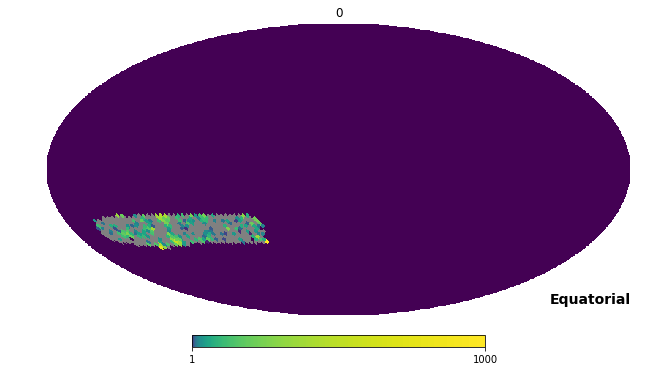

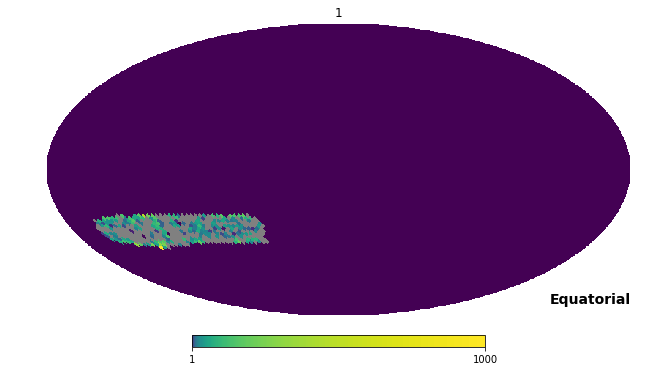

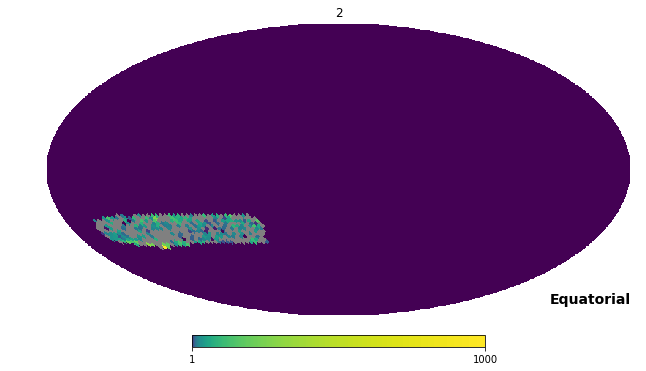

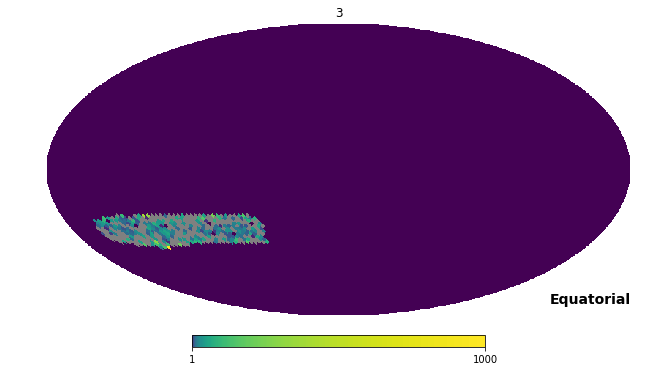

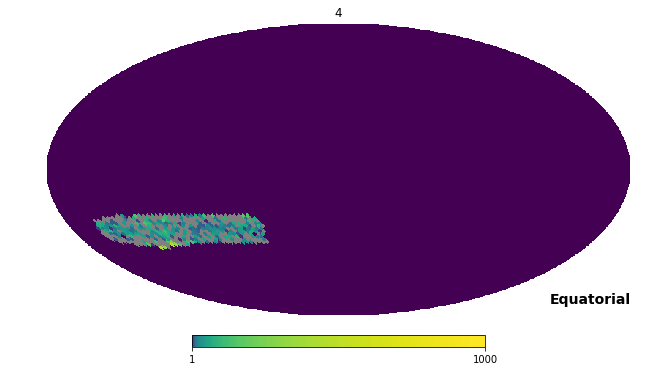

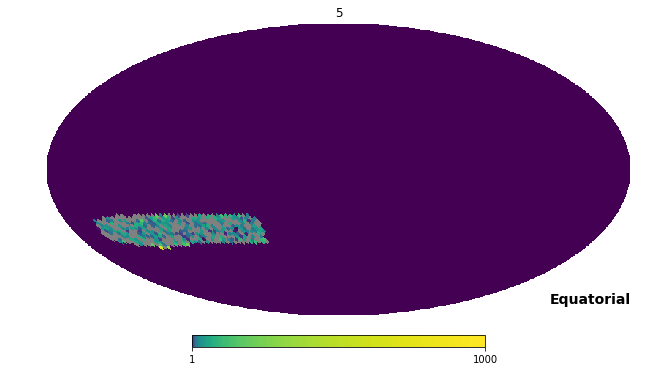

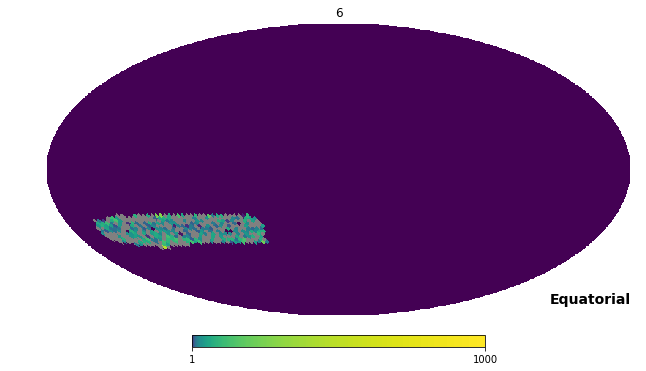

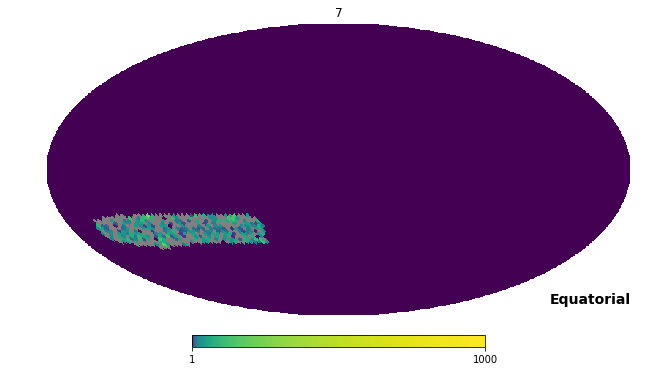

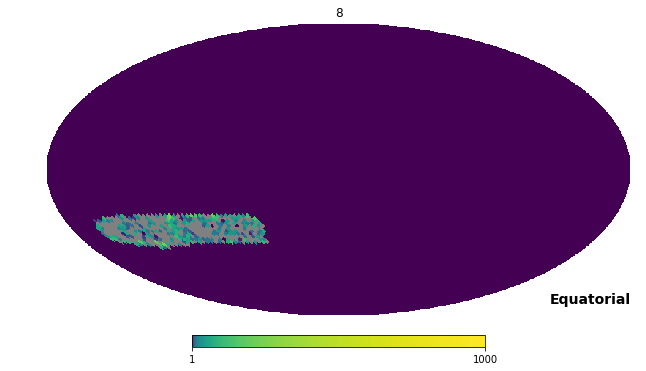

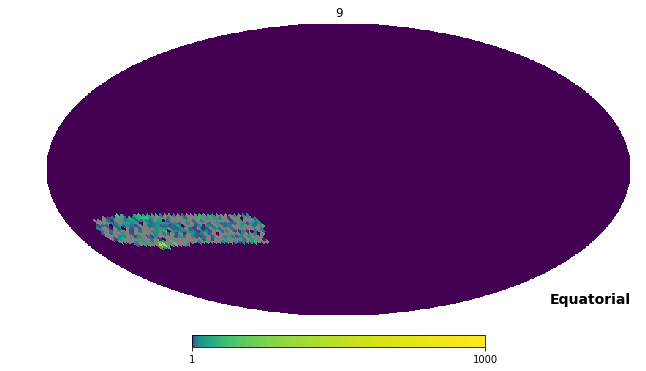

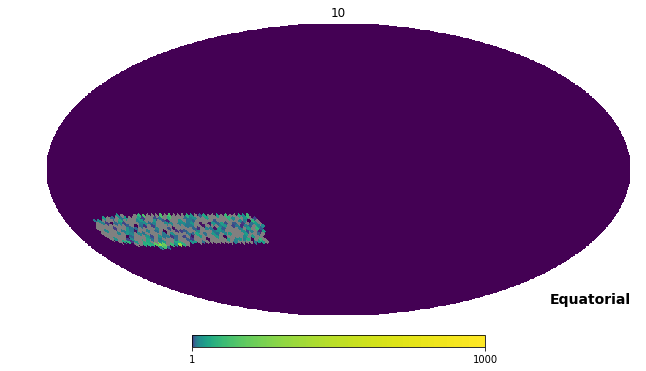

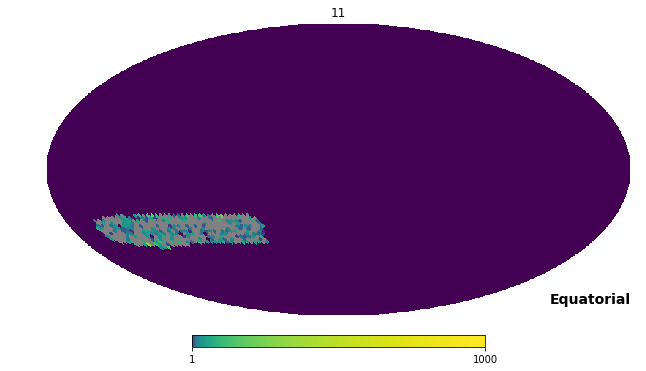

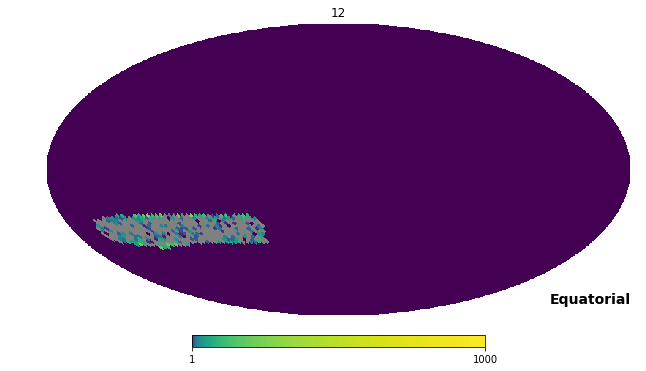

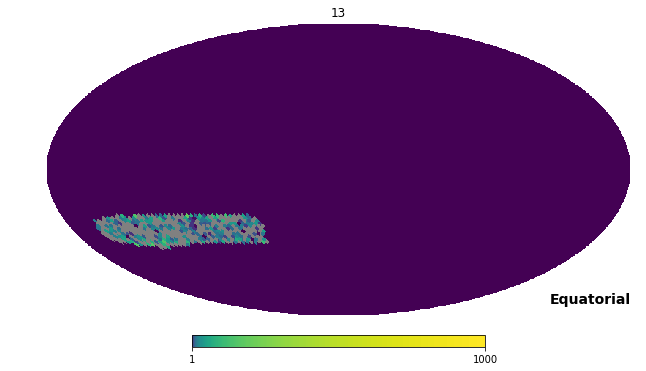

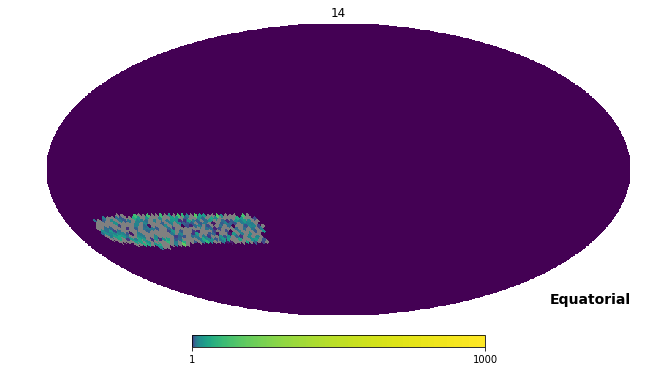

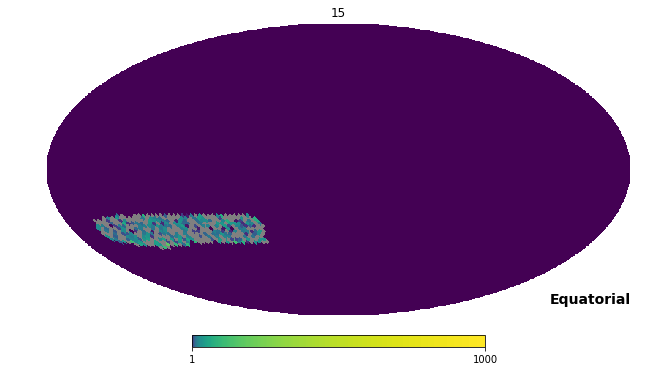

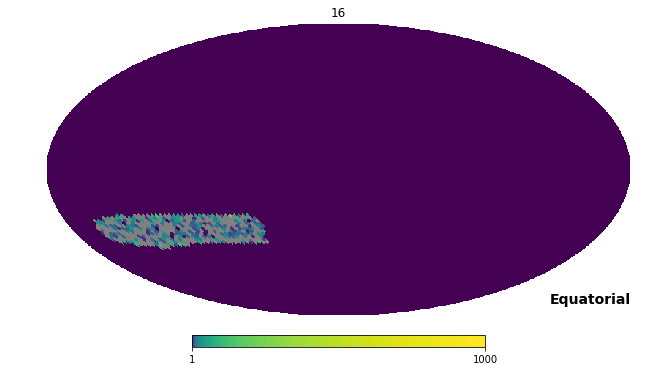

In [308]:
maps_mfreq_common_32_eigVectors_full = np.ones_like(maps_mfreq_32) * 10**(-5)
maps_mfreq_common_32_eigVectors_full[:, commom_vp_mask_32] = maps_mfreq_common_32_newspace.T
for id_eigvector,eigvector in enumerate(maps_mfreq_common_32_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=1, max=1000, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()

In [309]:
maps_mfreq_32 = []
for id_file, fitfile in enumerate(filenames_32):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 250.:
        maps_mfreq_32.append(map_fit)
        
maps_mfreq_32 = np.array(maps_mfreq_32)
commom_vp_mask_32 = np.prod(np.abs(maps_mfreq_32) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_32 = maps_mfreq_32[:, commom_vp_mask_32]
print('maps_mfreq_32 shape: {}'.format(maps_mfreq_32.shape))
print('maps_mfreq_common_32 shape: {}'.format(maps_mfreq_common_32.shape))
print('Number of Common Valid Pixels-32: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_32) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_32)
maps_mfreq_common_32_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_32_eigValues = pca.singular_values_
maps_mfreq_common_32_eigVectors = pca.components_
maps_mfreq_common_32_newspace = pca.fit_transform(maps_mfreq_common_32)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_32_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_32_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_32_eigVectors.shape))
print('Maps32_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_32_newspace.shape))
print('Maps32_Common_NewSpace: {}'.format(maps_mfreq_common_32_newspace))

id_freq = 0
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_32_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32_newspace[id_freq].dot(maps_mfreq_common_32_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_32[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_32_newspace[id_freq].dot(maps_mfreq_common_32_eigVectors))[-number_to_show:])

>>>>>>>> Number of Valid Pixels: 974
>>>>>>>> Number of Valid Pixels: 922
>>>>>>>> Number of Valid Pixels: 789
>>>>>>>> Number of Valid Pixels: 650
>>>>>>>> Number of Valid Pixels: 825
>>>>>>>> Number of Valid Pixels: 804
>>>>>>>> Number of Valid Pixels: 775
>>>>>>>> Number of Valid Pixels: 721
>>>>>>>> Number of Valid Pixels: 701
>>>>>>>> Number of Valid Pixels: 696
>>>>>>>> Number of Valid Pixels: 705
>>>>>>>> Number of Valid Pixels: 688
>>>>>>>> Number of Valid Pixels: 644
>>>>>>>> Number of Valid Pixels: 587
>>>>>>>> Number of Valid Pixels: 613
>>>>>>>> Number of Valid Pixels: 604
>>>>>>>> Number of Valid Pixels: 441
maps_mfreq_32 shape: (17, 12288)
maps_mfreq_common_32 shape: (17, 436)
Number of Common Valid Pixels-32: 436
EigenValues: 
[4.45112333e+03 2.37906127e+03 1.97226525e+03 1.74850521e+03
 1.59250989e+03 1.48136842e+03 1.32121069e+03 1.28860030e+03
 1.13048584e+03 1.08319919e+03 9.95751905e+02 9.88625415e+02
 9.34067947e+02 8.32342497e+02 7.57670346e+02 6.94794752e+02
 1.0

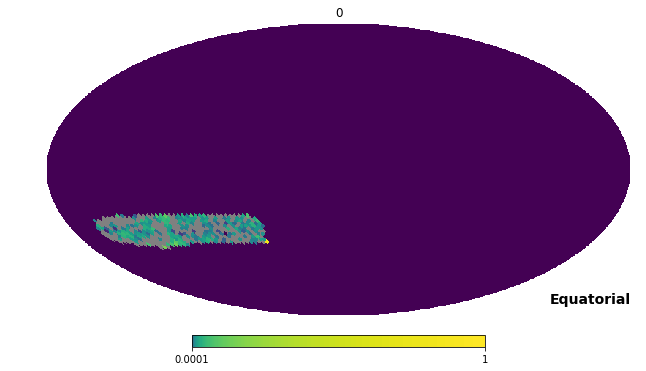

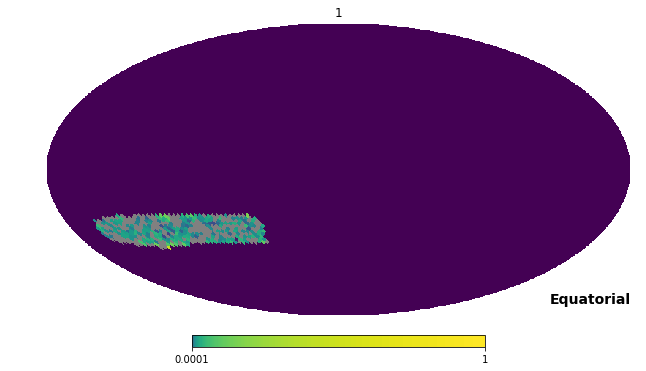

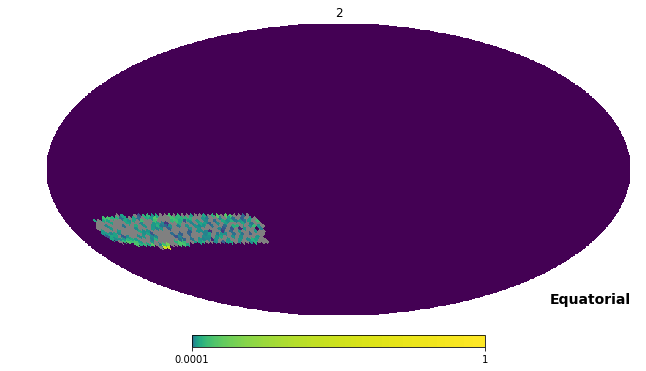

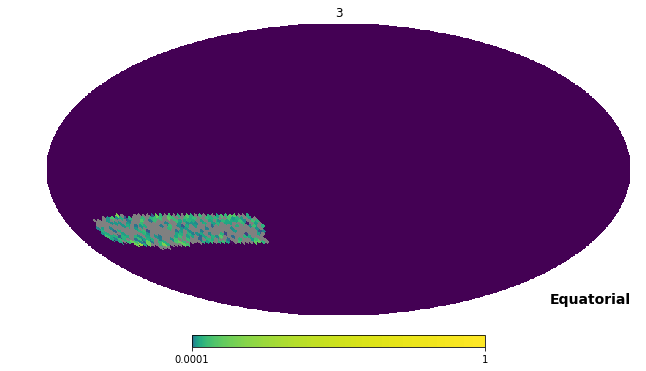

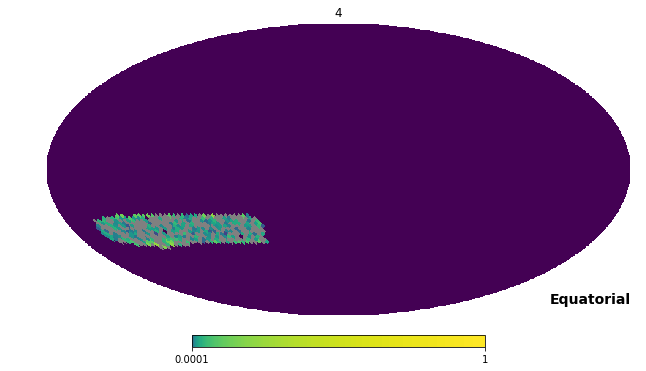

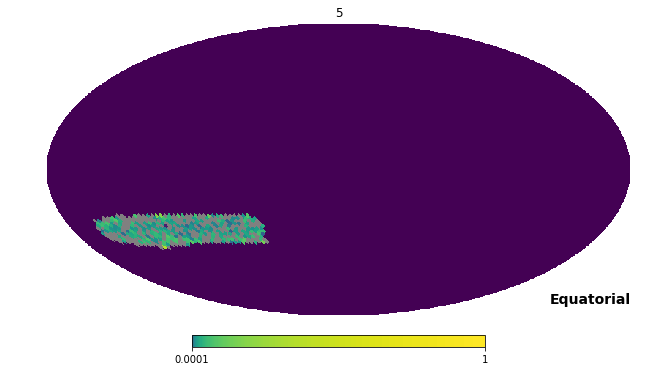

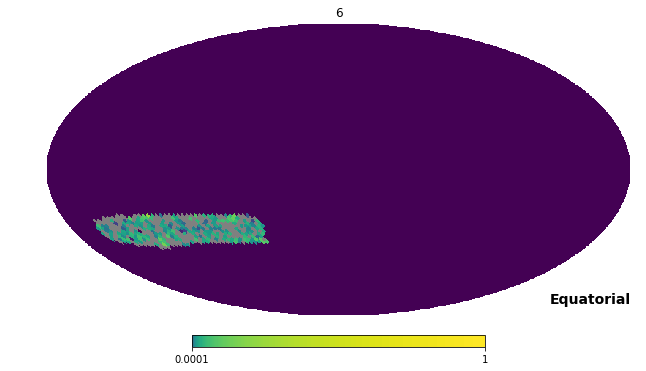

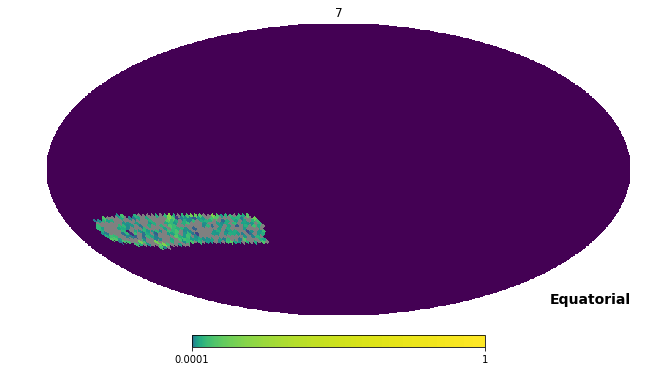

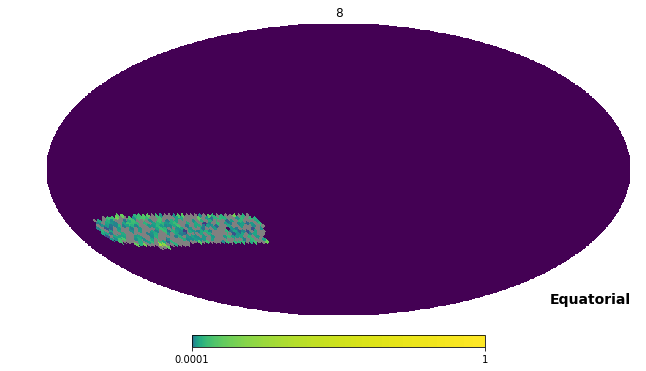

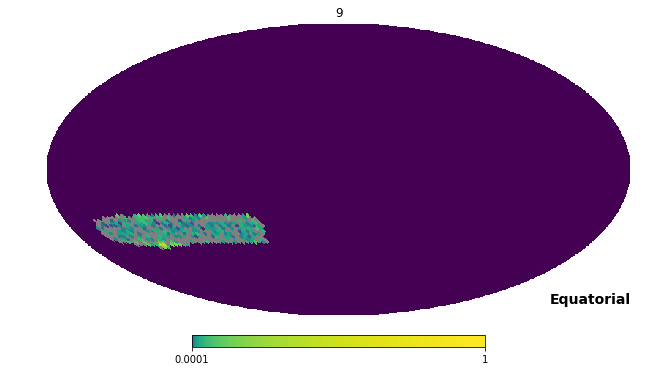

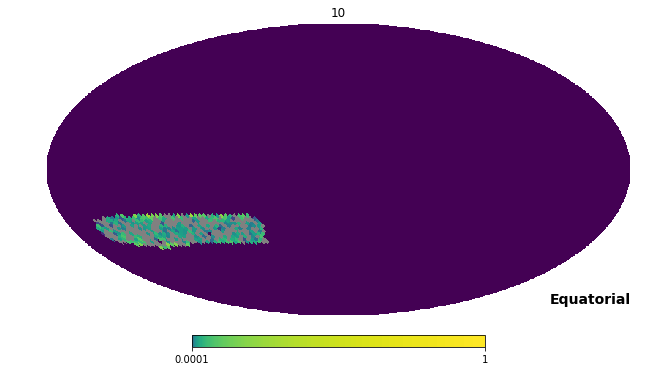

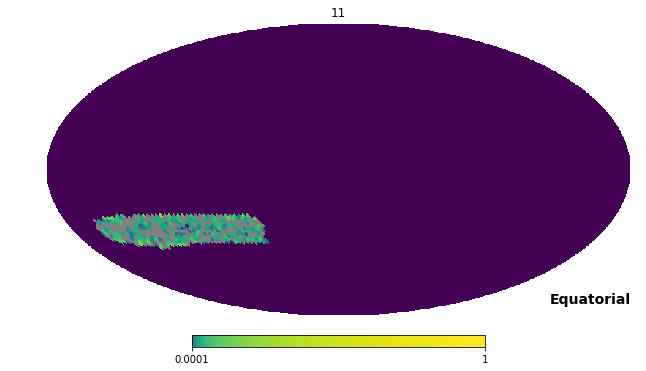

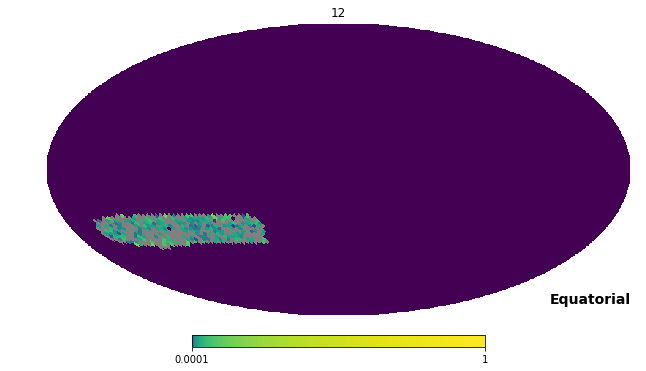

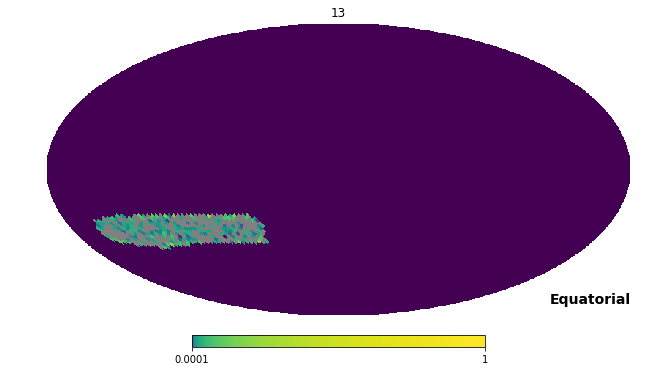

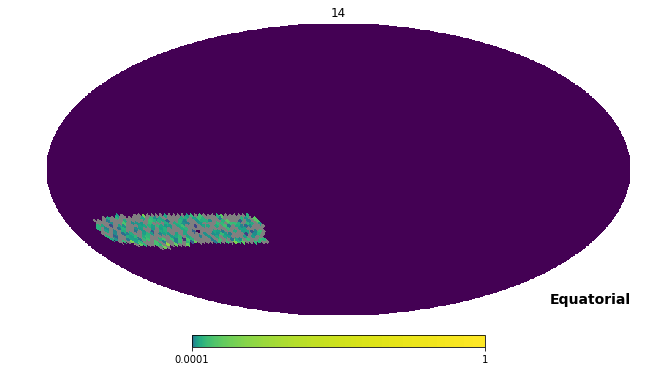

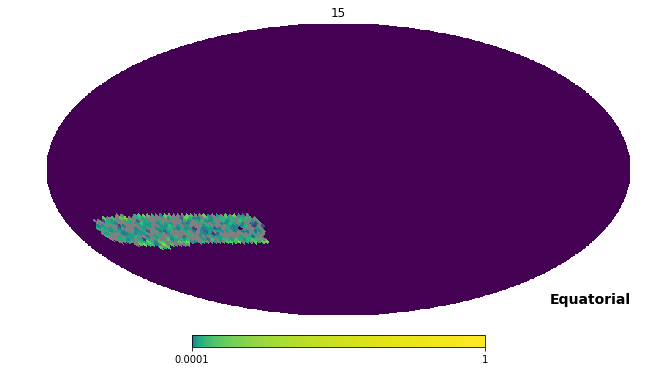

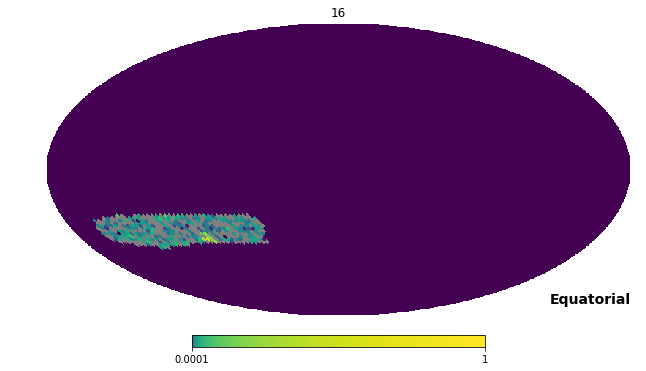

In [310]:
maps_mfreq_common_32_eigVectors_full = np.ones_like(maps_mfreq_32) * 10**(-5)
maps_mfreq_common_32_eigVectors_full[:, commom_vp_mask_32] = maps_mfreq_common_32_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_32_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-4), max=10.**(-0), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()

In [311]:
maps_mfreq_32[4]

array([1.e-05, 1.e-05, 1.e-05, ..., 1.e-05, 1.e-05, 1.e-05])

In [312]:
# for ev in maps_mfreq_common_32_eigVectors:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')
# # maps_mfreq_common_32_eigVectors.dot(maps_mfreq_common_32_eigVectors.T)
# maps_mfreq_common_32_eigVectors.dot(np.cov(maps_mfreq_common_32.T).dot(maps_mfreq_common_32_eigVectors.T))
# # print(maps_mfreq_common_32_eigVectors.dot(cov_mat_32.dot(maps_mfreq_common_32_eigVectors.T)))
# from sklearn.preprocessing import StandardScaler
# maps_mfreq_common_std_32 = StandardScaler().fit_transform(maps_mfreq_common_32)
# cov_mat_32 = np.cov(maps_mfreq_common_std_32.T)

# eig_vals_32, eig_vecs_32 = np.linalg.eig(cov_mat_32)
# print('\nEigenvalues: {}'.format(-np.sort(-np.abs(eig_vals_32))[:20]))
# # for ev in eig_vecs_32:
# #     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# # print('Everything ok!')
# cor_mat_32_2 = np.corrcoef(maps_mfreq_common_32.T)
# eig_vals_32_2, eig_vecs_32_2 = np.linalg.eig(cor_mat_32_2)
# # for ev in eig_vecs_32_2:
# #     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# # print('Everything ok!')

# u,s,v = np.linalg.svd(maps_mfreq_common_std_32.T)
# print(u.shape)
# print(np.linalg.norm(u[10]))
# for ev in u:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')
# # print(np.abs(eig_vals_32 - eig_vals_32_2))
# # print(np.abs(eig_vecs_32 - eig_vecs_32_2) / np.abs(eig_vecs_32))
# # print(eig_vals_32_2)

(0, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-110.11-gW-0.050119-110.1074MHz-dipole-nubl990-nt1578-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 1827.84257365
>>>>>>>> Number of Valid Pixels: 3763
>>>>>>>> Maximum in the Map: 52218.146526


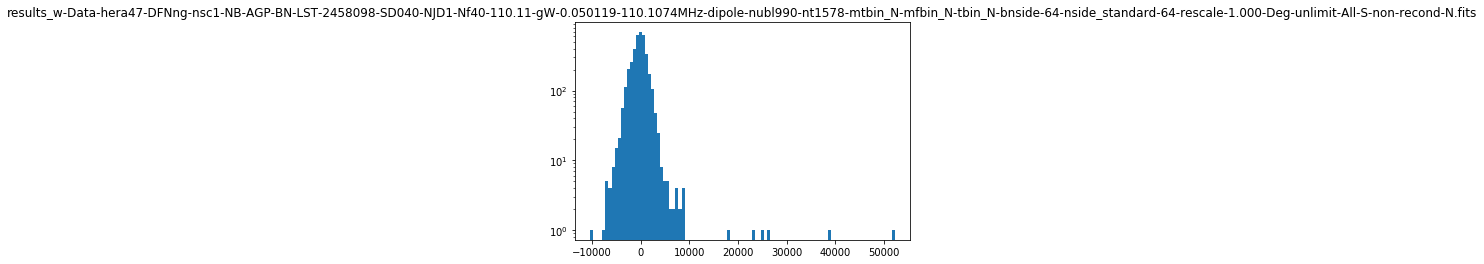

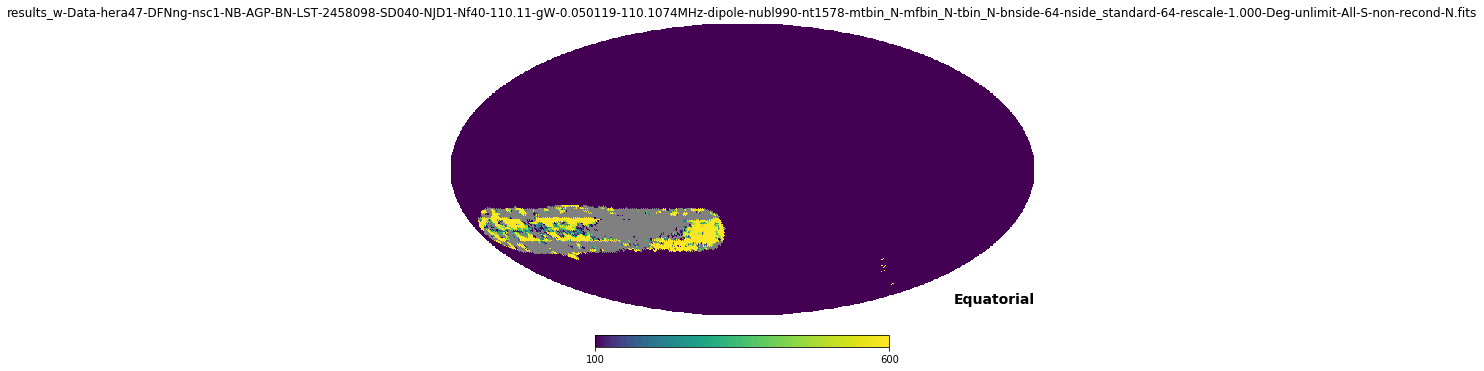

(1, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-114.79-gW-0.050119-114.7949MHz-dipole-nubl990-nt1567-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 2746.11271926
>>>>>>>> Number of Valid Pixels: 3684
>>>>>>>> Maximum in the Map: 58332.3642301


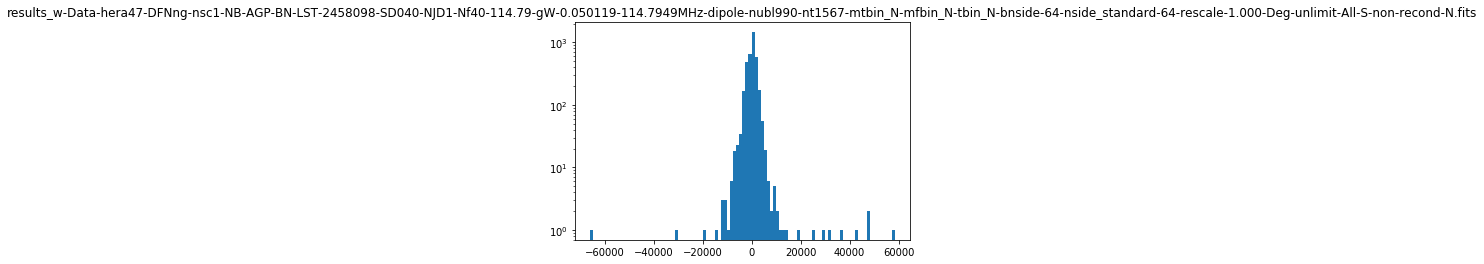

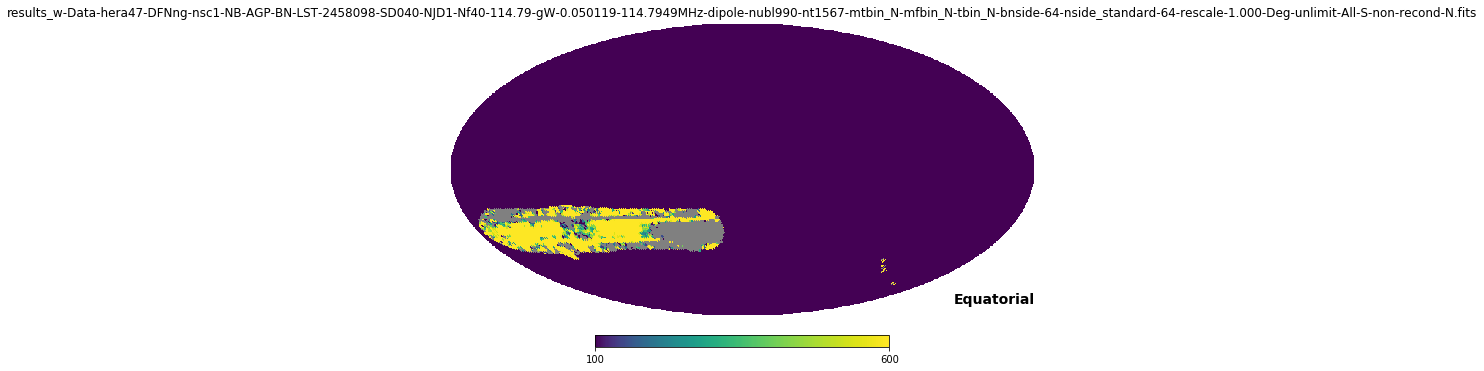

(2, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-119.48-gW-0.050119-119.4824MHz-dipole-nubl990-nt1341-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 2029.80496785
>>>>>>>> Number of Valid Pixels: 3169
>>>>>>>> Maximum in the Map: 8524.4694645


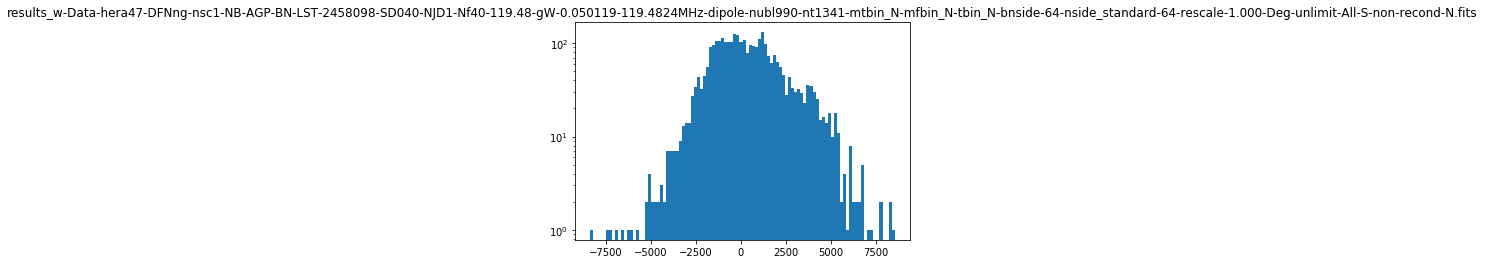

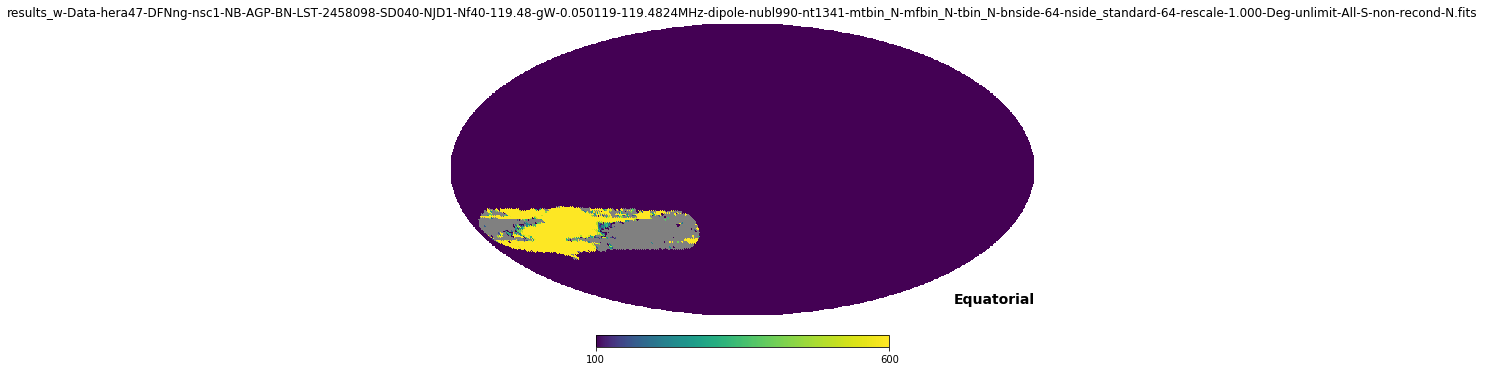

(3, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-125.73-gW-0.050119-125.7324MHz-dipole-nubl990-nt1173-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 1207.14775187
>>>>>>>> Number of Valid Pixels: 2603
>>>>>>>> Maximum in the Map: 4744.70473241


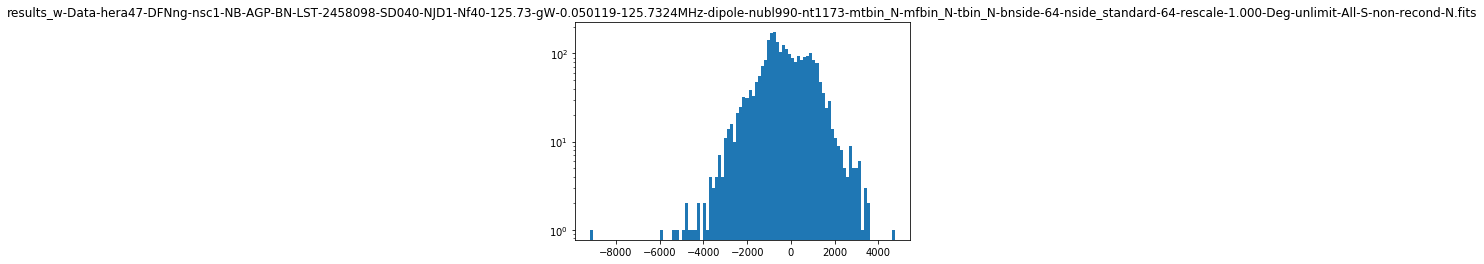

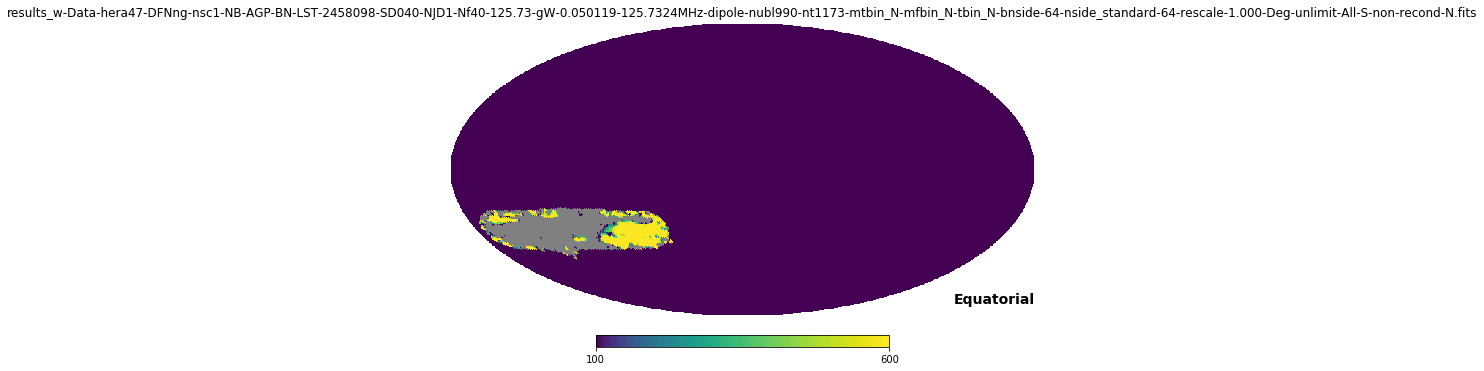

(4, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-130.42-gW-0.050119-130.4199MHz-dipole-nubl990-nt1559-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 1008.60400662
>>>>>>>> Number of Valid Pixels: 3282
>>>>>>>> Maximum in the Map: 11905.8177729


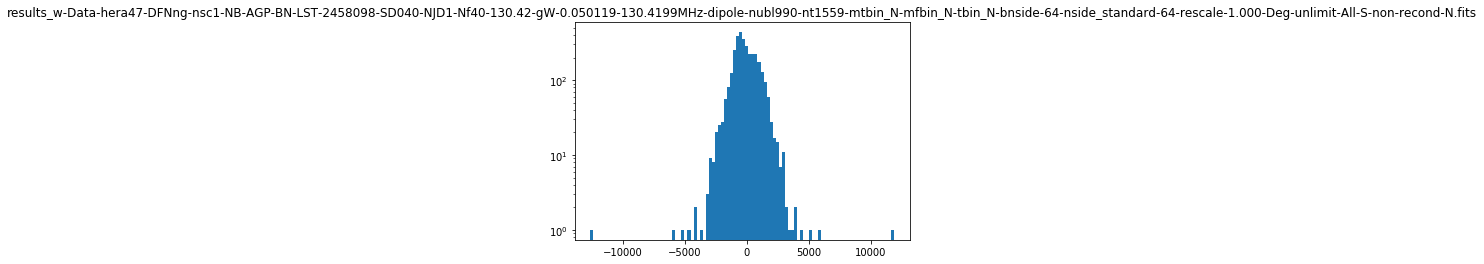

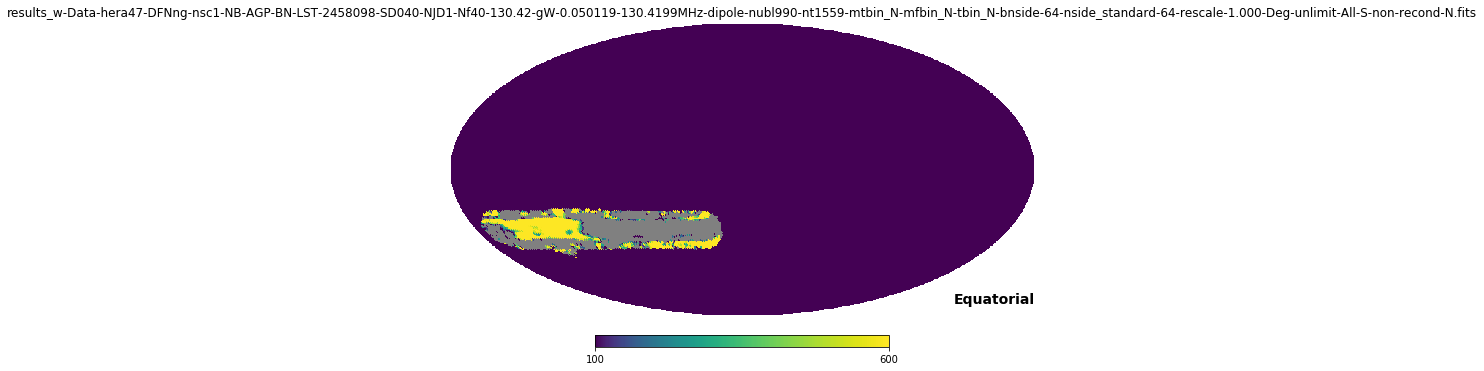

(5, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-135.11-gW-0.050119-135.1074MHz-dipole-nubl990-nt1577-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 1045.736276
>>>>>>>> Number of Valid Pixels: 3211
>>>>>>>> Maximum in the Map: 3860.38439986


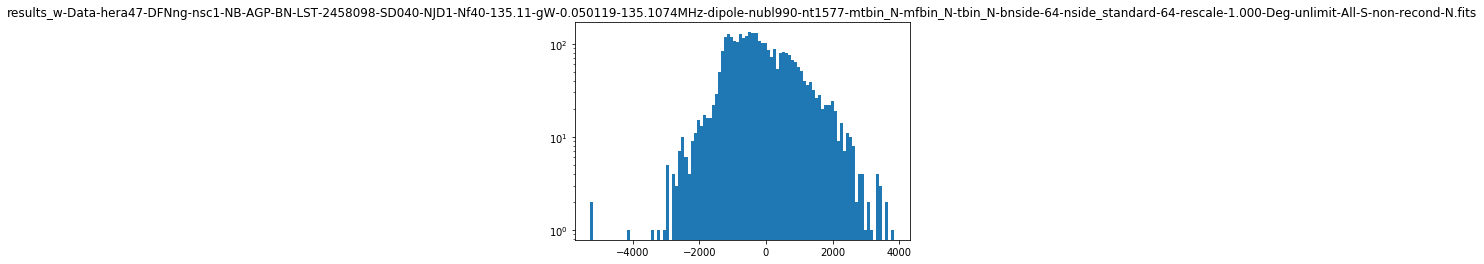

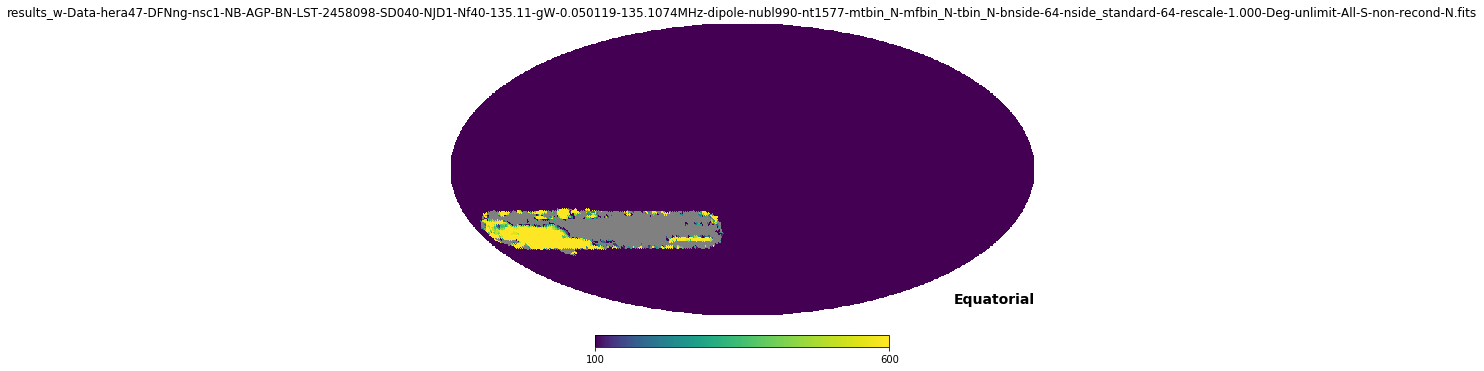

(6, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-139.79-gW-0.050119-139.7949MHz-dipole-nubl990-nt1579-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 831.459564031
>>>>>>>> Number of Valid Pixels: 3064
>>>>>>>> Maximum in the Map: 10432.4366791


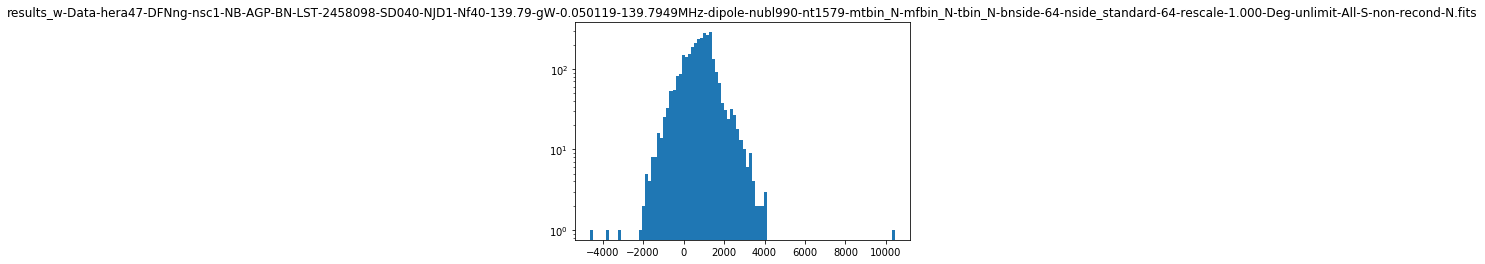

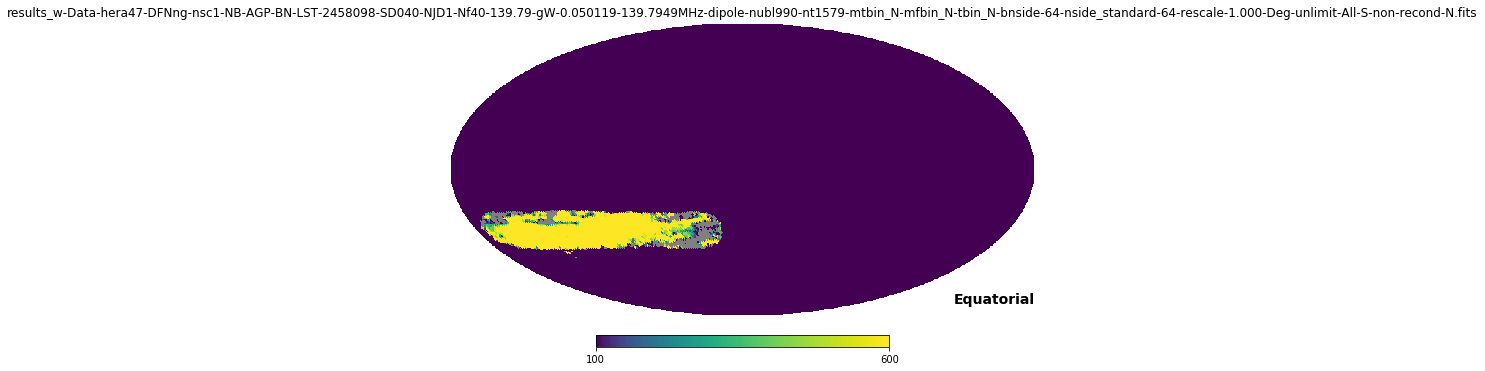

(7, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-144.48-gW-0.050119-144.4824MHz-dipole-nubl990-nt1574-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 738.537840186
>>>>>>>> Number of Valid Pixels: 2907
>>>>>>>> Maximum in the Map: 2726.80930963


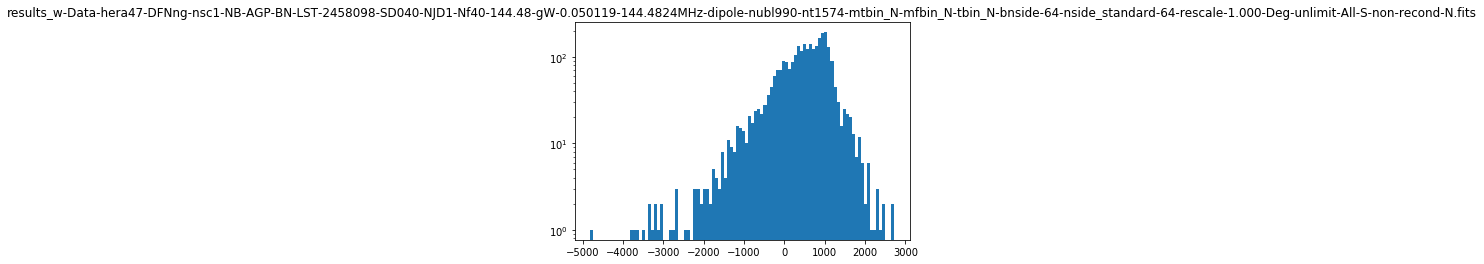

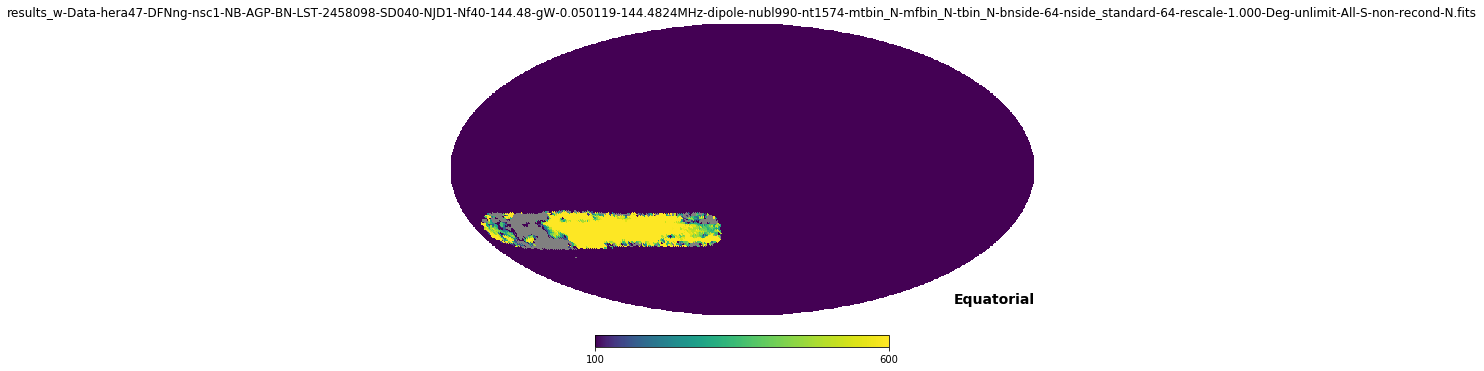

(8, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-150.73-gW-0.050119-150.7324MHz-dipole-nubl990-nt1530-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 238.607897281
>>>>>>>> Number of Valid Pixels: 2824
>>>>>>>> Maximum in the Map: 3889.94561464


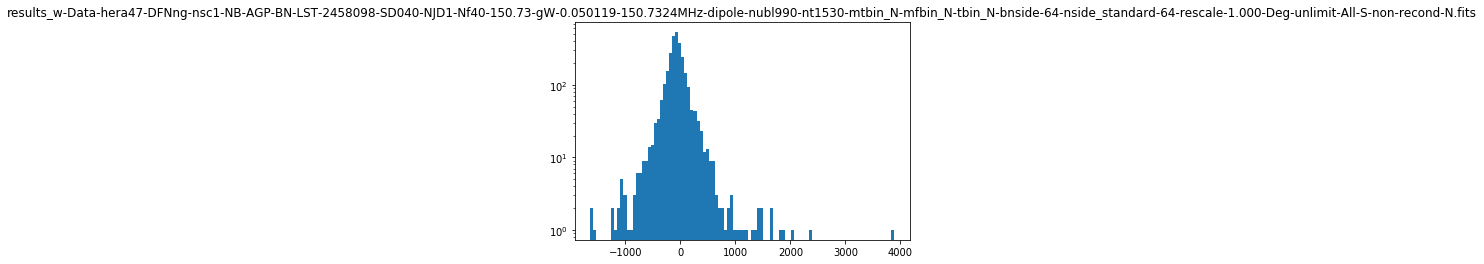

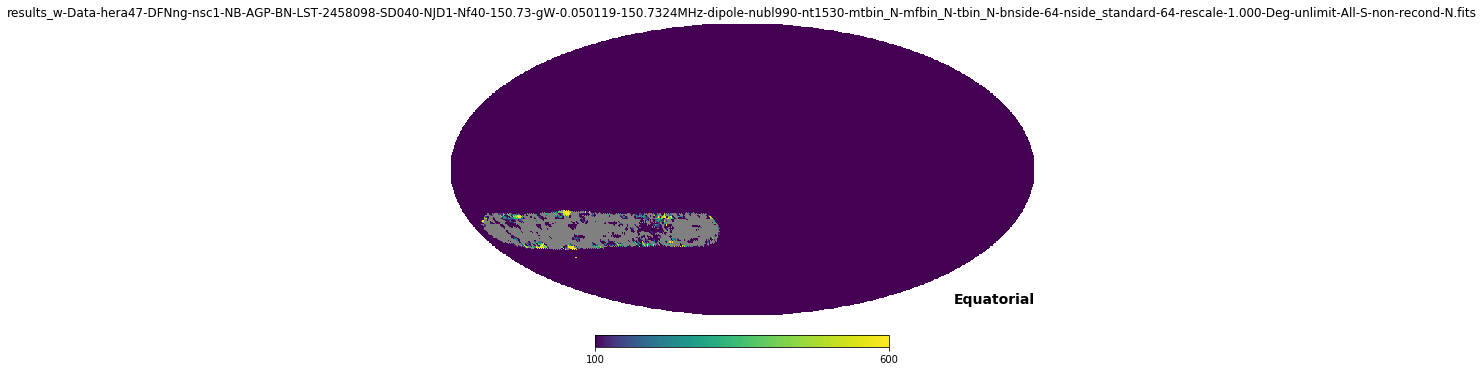

(9, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-155.42-gW-0.050119-155.4199MHz-dipole-nubl990-nt1540-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 253.370346085
>>>>>>>> Number of Valid Pixels: 2803
>>>>>>>> Maximum in the Map: 1914.94464583


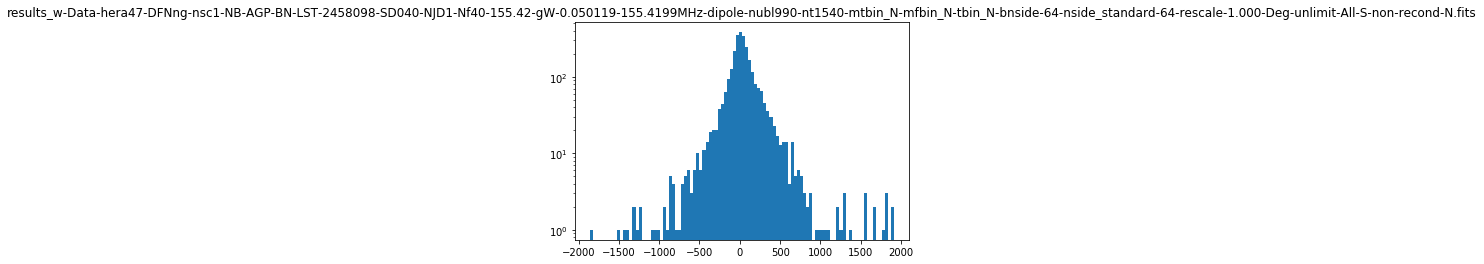

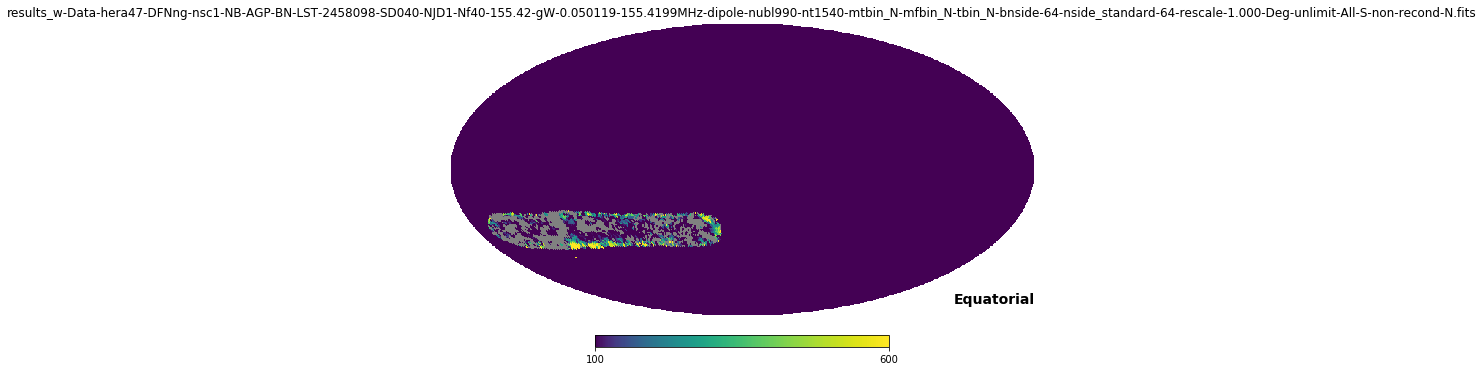

(10, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-160.11-gW-0.050119-160.1074MHz-dipole-nubl990-nt1577-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 198.494580304
>>>>>>>> Number of Valid Pixels: 2856
>>>>>>>> Maximum in the Map: 1818.82820362


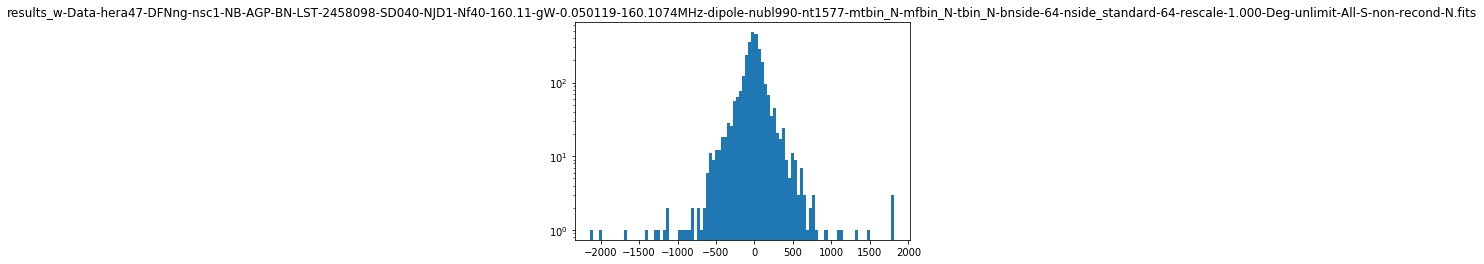

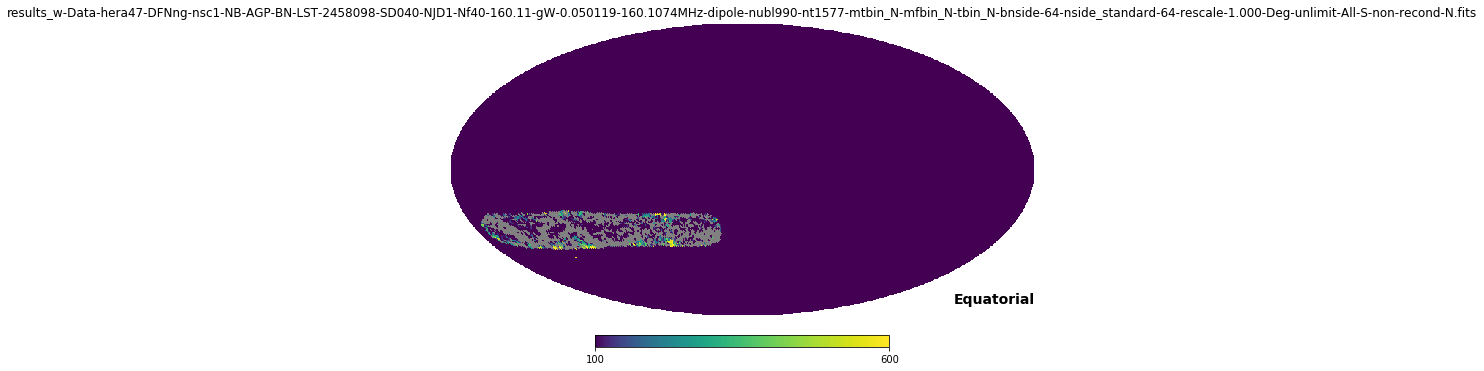

(11, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-164.79-gW-0.050119-164.7949MHz-dipole-nubl990-nt1581-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 248.600634864
>>>>>>>> Number of Valid Pixels: 2775
>>>>>>>> Maximum in the Map: 2851.26375372


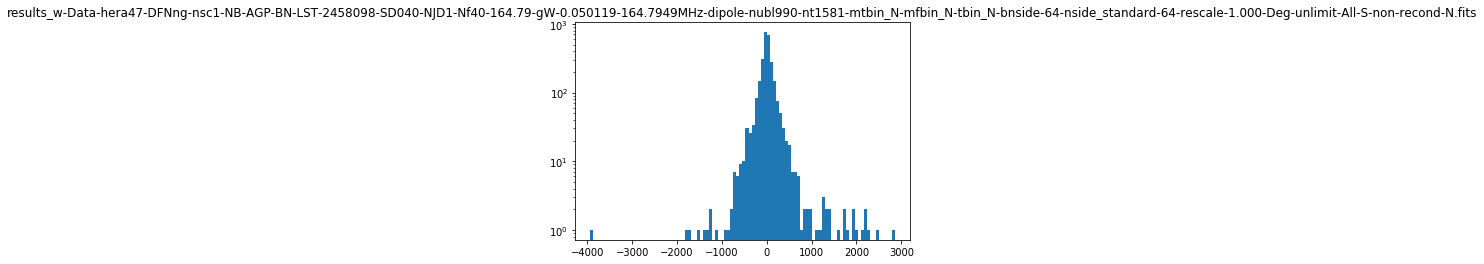

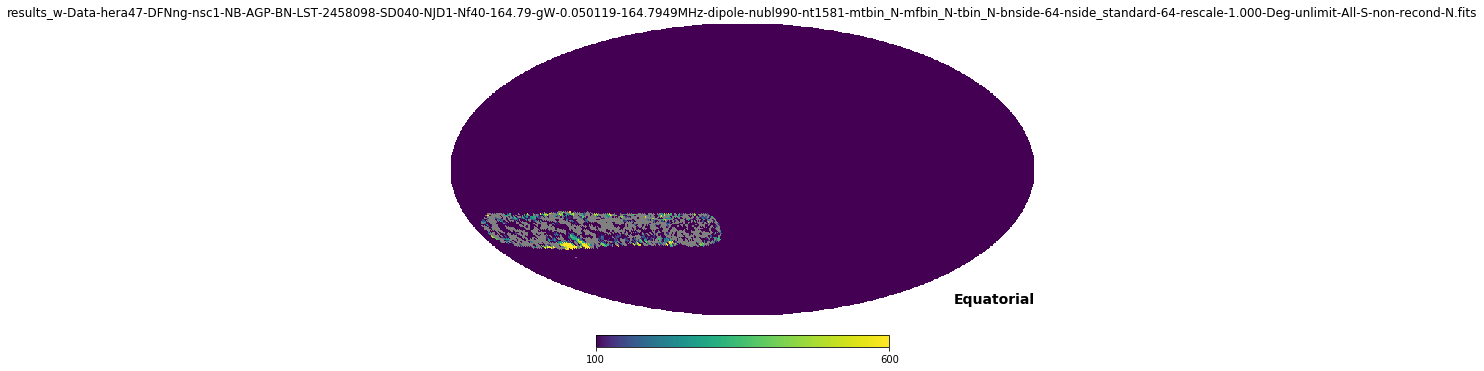

(12, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-171.04-gW-0.050119-171.0449MHz-dipole-nubl990-nt1533-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 199.473125813
>>>>>>>> Number of Valid Pixels: 2565
>>>>>>>> Maximum in the Map: 2538.95006959


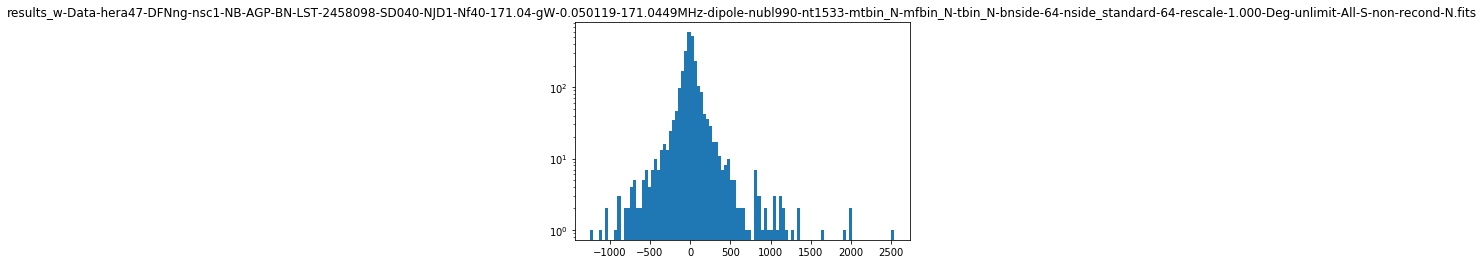

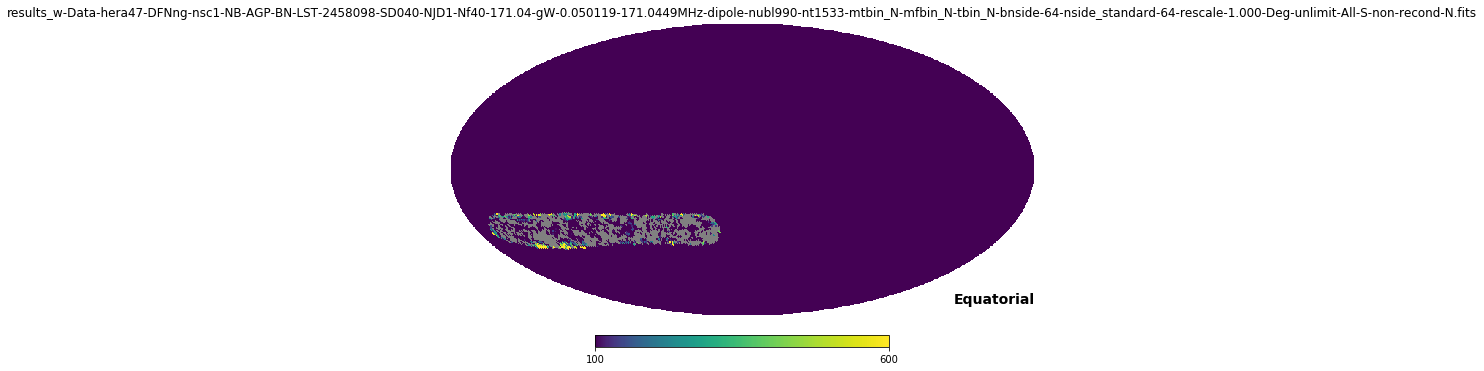

(13, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-174.17-gW-0.050119-174.1699MHz-dipole-nubl990-nt1383-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 246.588088181
>>>>>>>> Number of Valid Pixels: 2370
>>>>>>>> Maximum in the Map: 3015.56488855


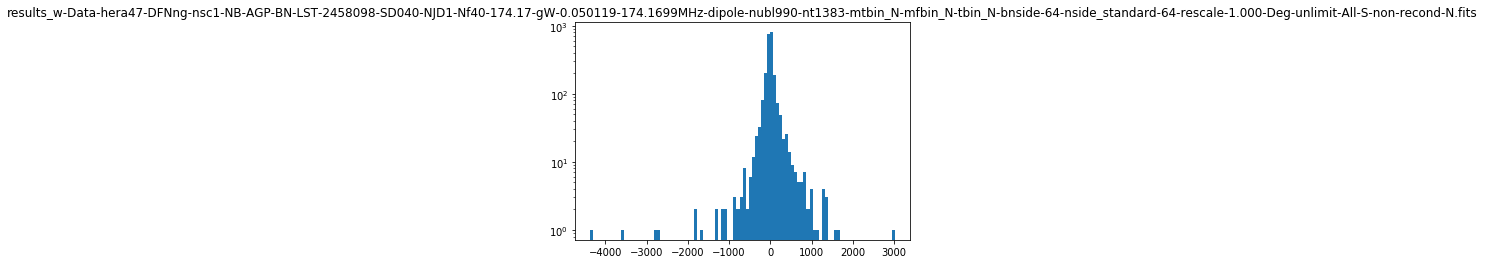

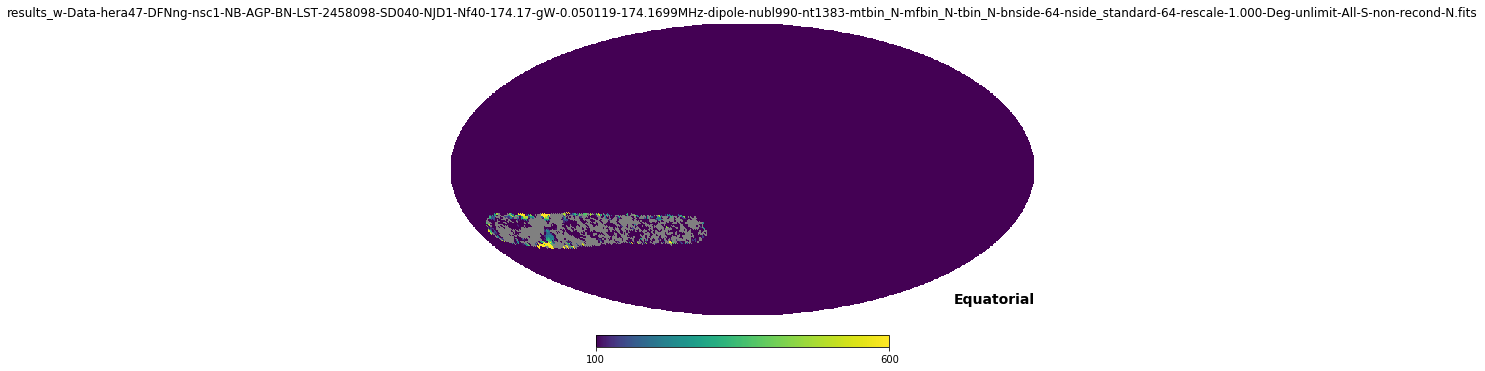

(14, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-178.86-gW-0.050119-178.8574MHz-dipole-nubl990-nt1435-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 134.005316641
>>>>>>>> Number of Valid Pixels: 2450
>>>>>>>> Maximum in the Map: 842.761066073


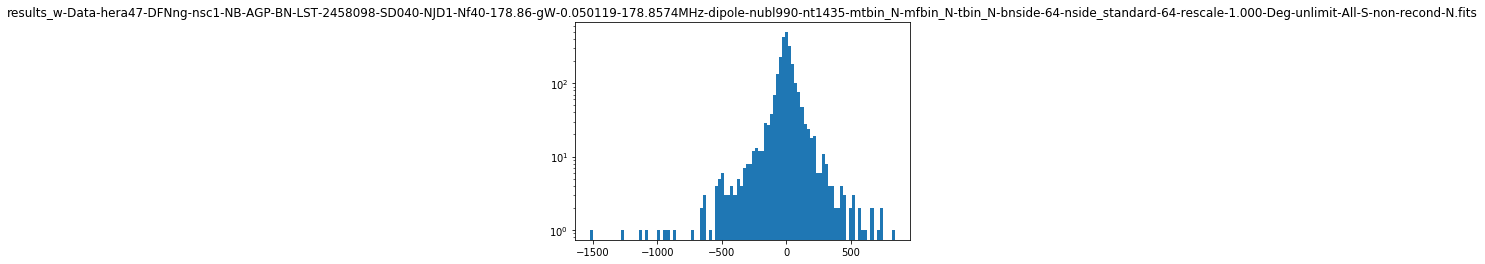

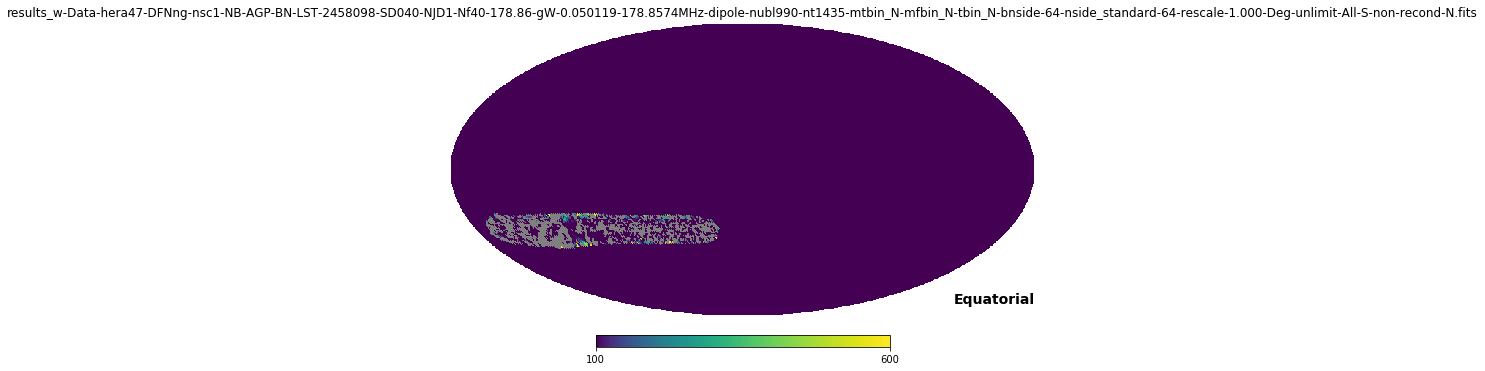

(15, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-185.11-gW-0.050119-185.1074MHz-dipole-nubl990-nt1415-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 119.661931793
>>>>>>>> Number of Valid Pixels: 2424
>>>>>>>> Maximum in the Map: 1209.85421473


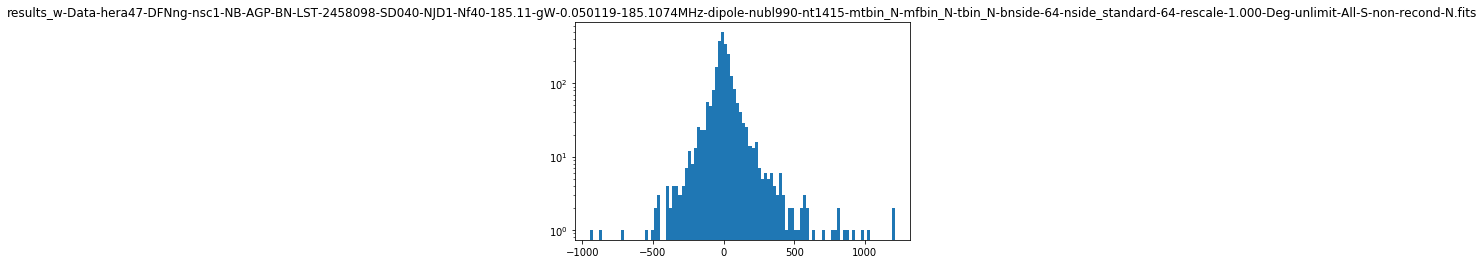

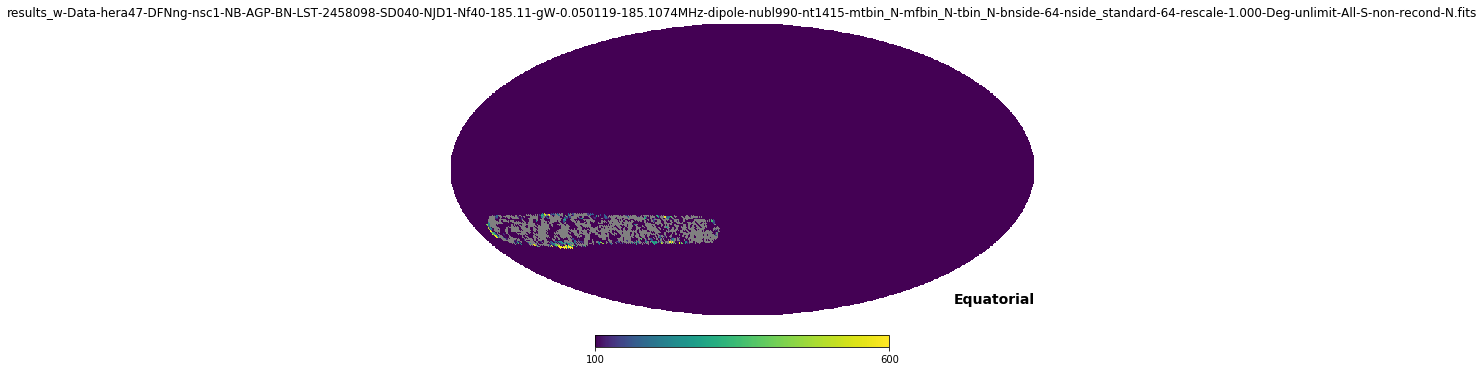

(16, 'results_w-Data-hera47-DFNng-nsc1-NB-AGP-BN-LST-2458098-SD040-NJD1-Nf40-186.67-gW-0.050119-186.6699MHz-dipole-nubl990-nt948-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-wholeday without Fornax A: 107.293643536
>>>>>>>> Number of Valid Pixels: 1779
>>>>>>>> Maximum in the Map: 976.808404956


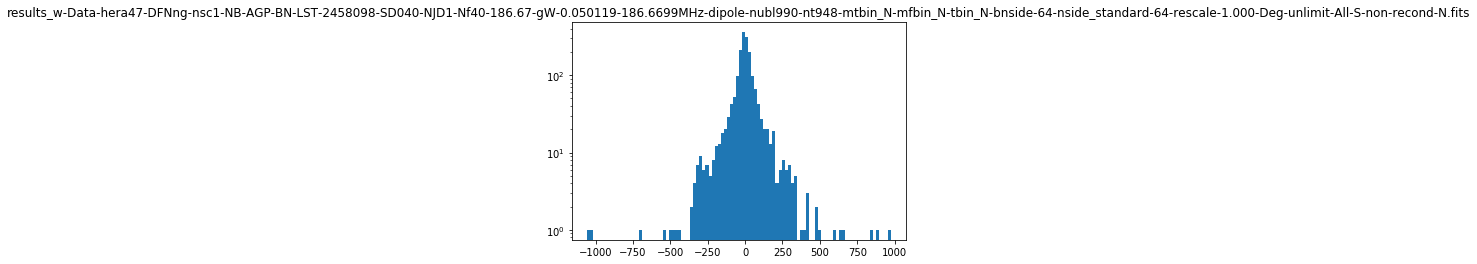

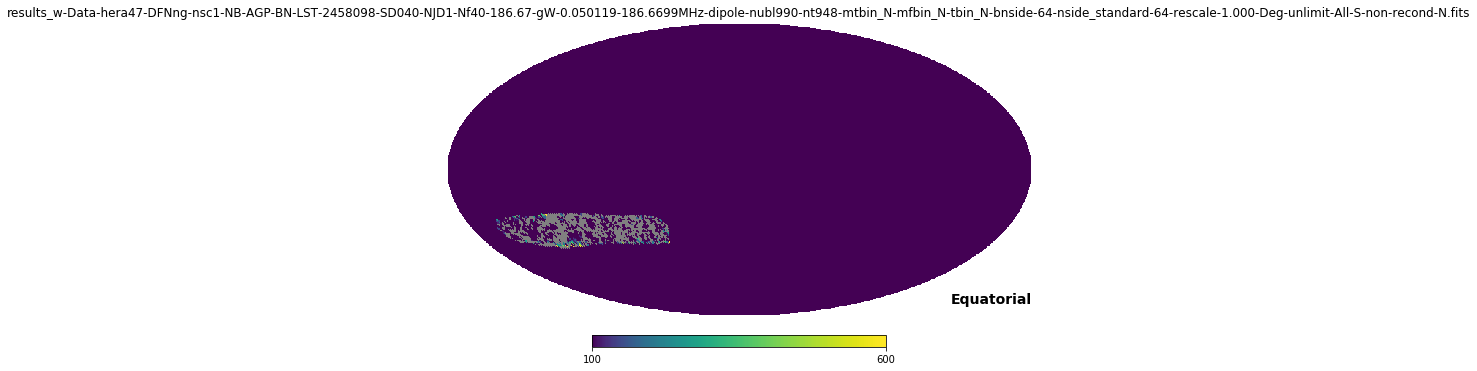

In [313]:
for id_file, fitfile in enumerate(filenames_64):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map64-wholeday without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-2]][np.abs(map_fit[np.argsort(map_fit)[:-2]]) > 10**(-5)])))
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    plt.figure(100000 + id_file)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.title(name)
    plt.show()
    #plt.close()
    plt.figure(500000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    #plt.close()

In [314]:
maps_mfreq_64 = []
freqs_common_64 = []
for id_file, fitfile in enumerate(filenames_64):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 1500.:
        maps_mfreq_64.append(map_fit)
        for string_piece in name.split('-'):
            if 'MHz' in string_piece:
                freqs_common_64.append(float(string_piece[:-3]))
                print(string_piece)
        
maps_mfreq_64 = np.array(maps_mfreq_64)
commom_vp_mask_64 = np.prod(np.abs(maps_mfreq_64) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_64 = maps_mfreq_64[:, commom_vp_mask_64]
print('maps_mfreq_64 shape: {}'.format(maps_mfreq_64.shape))
print('maps_mfreq_common_64 shape: {}'.format(maps_mfreq_common_64.shape))
print('Number of Common Valid Pixels-64: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_64) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_64.T)
maps_mfreq_common_64_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_64_eigValues =  pca.explained_variance_
# maps_mfreq_common_64_eigValues = pca.singular_values_
maps_mfreq_common_64_eigVectors = pca.components_
maps_mfreq_common_64_newspace = pca.fit_transform(maps_mfreq_common_64.T)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_64_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_64_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_64_eigVectors.shape))
print('Maps64_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_64_newspace.shape))
print('Maps64_Common_NewSpace: {}\n'.format(maps_mfreq_common_64_newspace))

maps_mfreq_common_64_reconstruct = np.dot(maps_mfreq_common_64_newspace, maps_mfreq_common_64_eigVectors).T
print('Shape of maps_mfreq_common_64_reconstruct:{}\n'.format(maps_mfreq_common_64_reconstruct.shape))
Discrepancy_reconstruct_64 = maps_mfreq_common_64 - maps_mfreq_common_64_reconstruct
Discrepancy_reconstruct_ratio_64 = np.linalg.norm(Discrepancy_reconstruct_64, axis=1) / np.linalg.norm(maps_mfreq_common_64, axis=1)
print('Discrepancy_reconstruct_ratio: {}\n'.format(Discrepancy_reconstruct_ratio_64))

ai_64 = np.ones_like(maps_mfreq_common_64_newspace)
Discrepancy_reconstruct_square_64 = np.corrcoef(maps_mfreq_common_64)
for id_pix in range(maps_mfreq_common_64.shape[1]):
    #Discrepancy_reconstruct_square = np.cov(Discrepancy_reconstruct[:, id_pix])
    PtNiPi_64 = np.linalg.inv((maps_mfreq_common_64_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square_64))).dot(maps_mfreq_common_64_eigVectors.T))
    PtNi_64 = maps_mfreq_common_64_eigVectors.dot(np.linalg.inv(Discrepancy_reconstruct_square_64))
    ai_64[id_pix] = PtNiPi_64.dot(PtNi_64.dot(maps_mfreq_common_64[:, id_pix]))
maps_mfreq_common_64_reconstruct_fit = np.dot(ai_64, maps_mfreq_common_64_eigVectors).T
print('Shape of maps_mfreq_common_64_reconstruct_fit:{}\n'.format(maps_mfreq_common_64_reconstruct_fit.shape))
Discrepancy_reconstruct_fit_64 = maps_mfreq_common_64 - maps_mfreq_common_64_reconstruct_fit
Discrepancy_reconstruct_ratio_fit_64 = np.linalg.norm(Discrepancy_reconstruct_fit_64, axis=1) / np.linalg.norm(maps_mfreq_common_64, axis=1)
print('Discrepancy_reconstruct_ratio_fit: {}\n'.format(Discrepancy_reconstruct_ratio_fit_64))
    
from scipy.interpolate import interp1d
from scipy import interpolate
inter_mfreq_cubic_64 = {}
inter_mfreq_cubic_eigVectors_64 = np.ones_like(maps_mfreq_common_64_eigVectors)
freq_shift_64 = 0.
for id_pc in range(maps_mfreq_common_64_eigVectors.shape[0]):
    inter_mfreq_cubic_64[id_pc] = interp1d(np.log(freqs_common_64), maps_mfreq_common_64_eigVectors[id_pc], kind='cubic', fill_value='extrapolate')
    #inter_mfreq_cubic[id_pc] = interpolate.splrep(6. + np.log10(freqs_common), maps_mfreq_common_64_eigVectors[id_pc], s=0)
    inter_mfreq_cubic_eigVectors_64[id_pc] = inter_mfreq_cubic_64[id_pc](np.log(np.array(freqs_common_64) + freq_shift_64))
discrepancy_cubicspline_fit_64 = maps_mfreq_common_64_eigVectors - inter_mfreq_cubic_eigVectors_64
discrepancy_cubicspline_fit_ratio_64 = discrepancy_cubicspline_fit_64 / maps_mfreq_common_64_eigVectors
print('discrepancy_cubicspline_fit_ratio:\n {}\n'.format(discrepancy_cubicspline_fit_ratio_64))
    
id_freq = 7
id_pc = 0
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_64_eigVectors, axis=1)[:, -10:]))
print('Top pixels {0}th principle component: \n{1}\n'.format(id_pc, np.argsort(maps_mfreq_common_64_newspace[:, id_pc])[-number_to_show:]))
print(np.sort(maps_mfreq_common_64[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_64_newspace[:, id_pc])[-number_to_show:])

>>>>>>>> Number of Valid Pixels: 3763
110.1074MHz
>>>>>>>> Number of Valid Pixels: 3684
114.7949MHz
>>>>>>>> Number of Valid Pixels: 3169
119.4824MHz
>>>>>>>> Number of Valid Pixels: 2603
125.7324MHz
>>>>>>>> Number of Valid Pixels: 3282
130.4199MHz
>>>>>>>> Number of Valid Pixels: 3211
135.1074MHz
>>>>>>>> Number of Valid Pixels: 3064
139.7949MHz
>>>>>>>> Number of Valid Pixels: 2907
144.4824MHz
>>>>>>>> Number of Valid Pixels: 2824
150.7324MHz
>>>>>>>> Number of Valid Pixels: 2803
155.4199MHz
>>>>>>>> Number of Valid Pixels: 2856
160.1074MHz
>>>>>>>> Number of Valid Pixels: 2775
164.7949MHz
>>>>>>>> Number of Valid Pixels: 2565
171.0449MHz
>>>>>>>> Number of Valid Pixels: 2370
174.1699MHz
>>>>>>>> Number of Valid Pixels: 2450
178.8574MHz
>>>>>>>> Number of Valid Pixels: 2424
185.1074MHz
>>>>>>>> Number of Valid Pixels: 1779
186.6699MHz
maps_mfreq_64 shape: (17, 49152)
maps_mfreq_common_64 shape: (17, 1751)
Number of Common Valid Pixels-64: 1751
EigenValues: 
[4025463.74955003 1835106

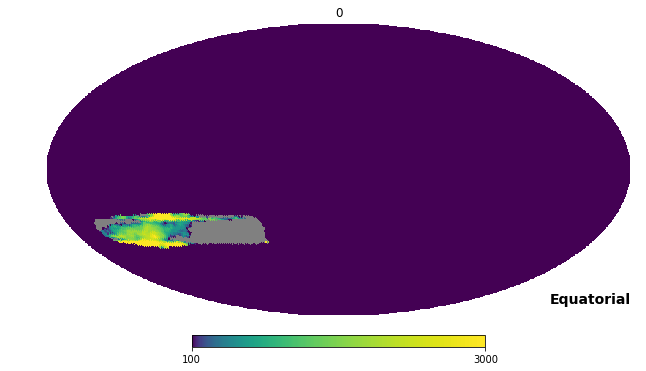

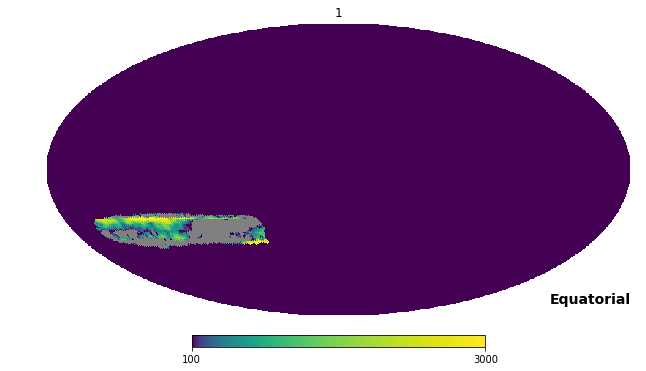

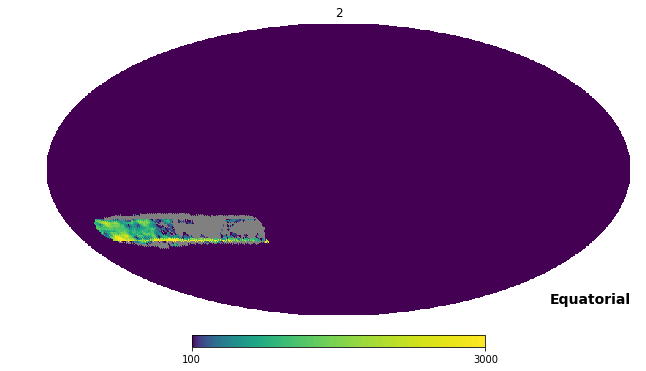

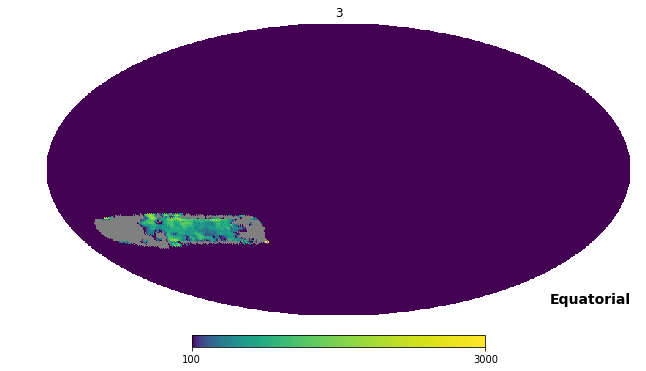

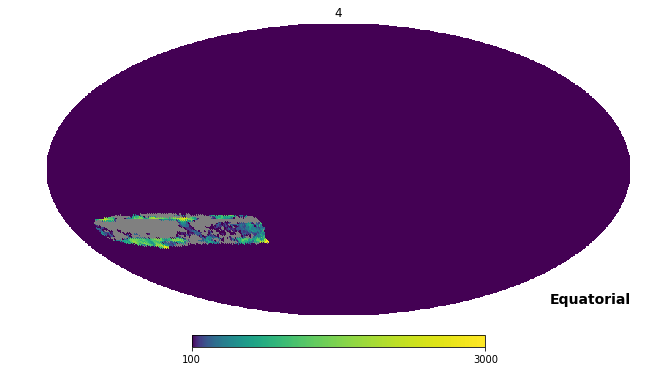

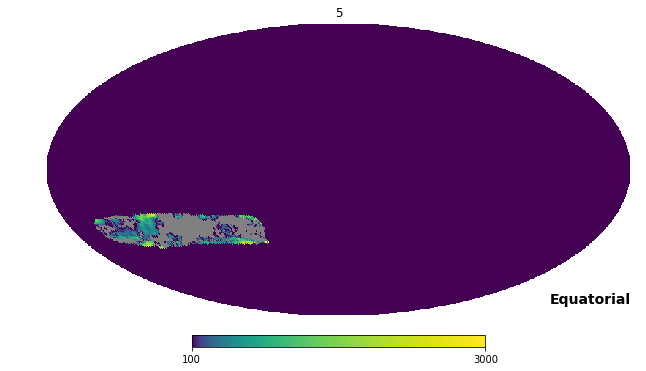

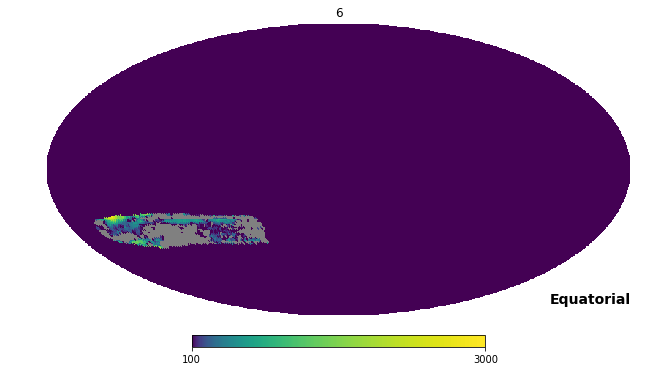

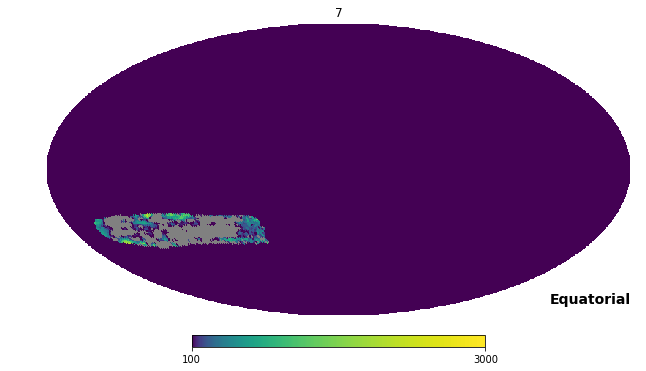

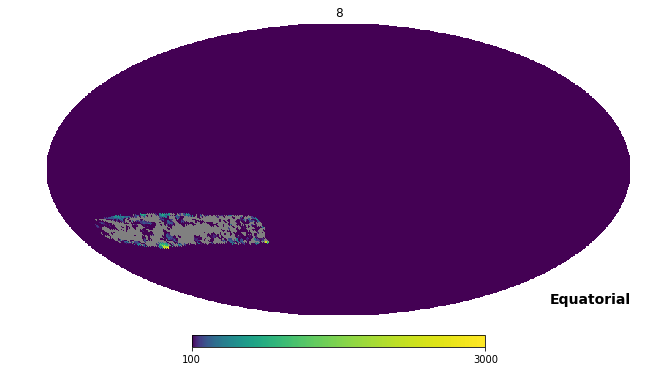

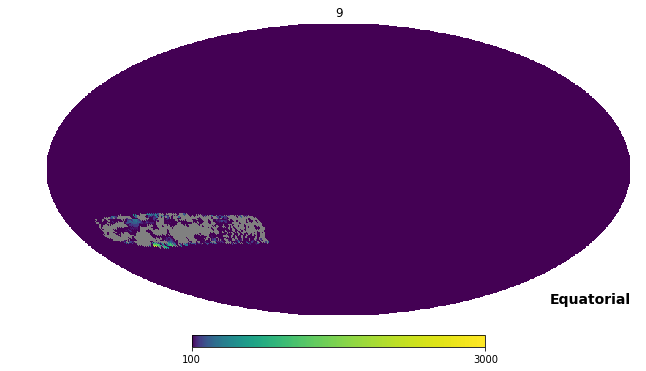

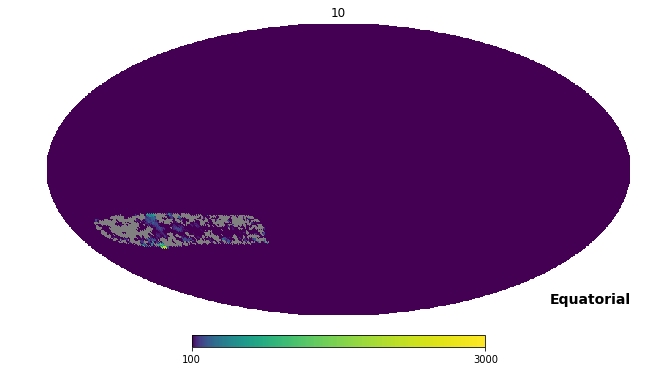

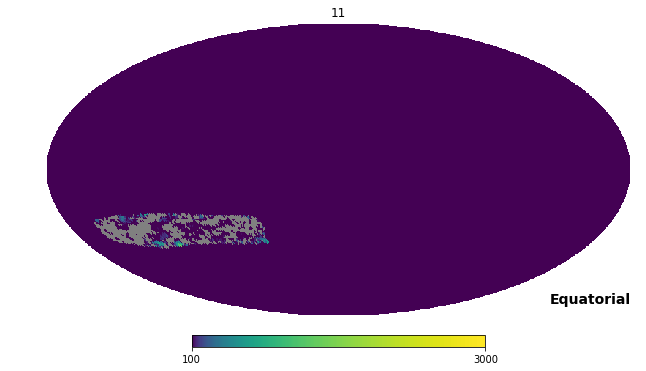

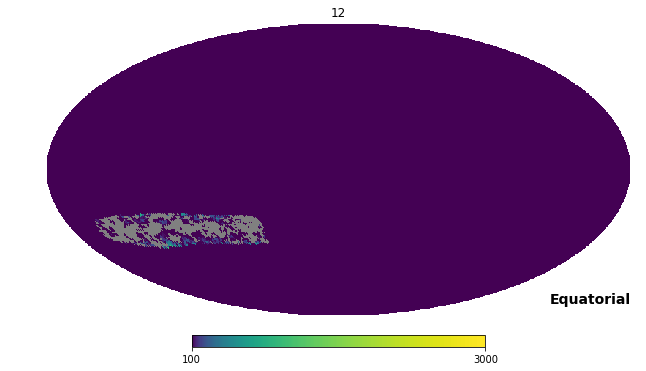

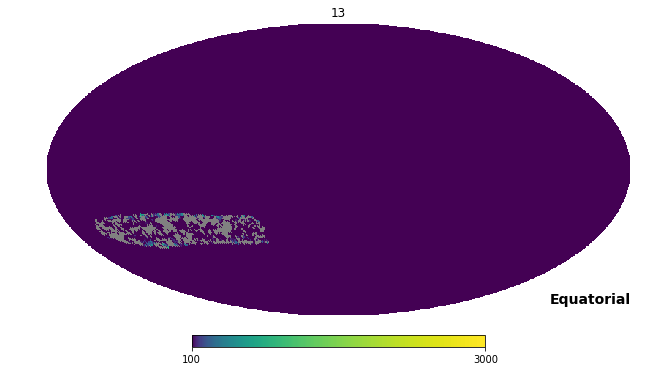

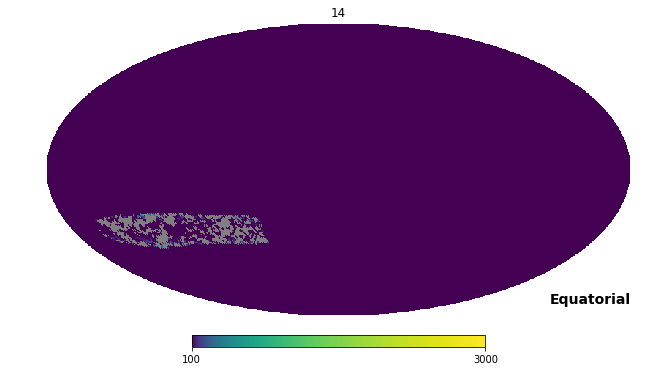

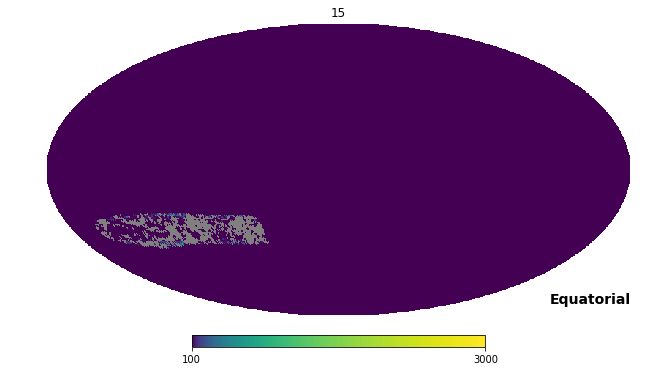

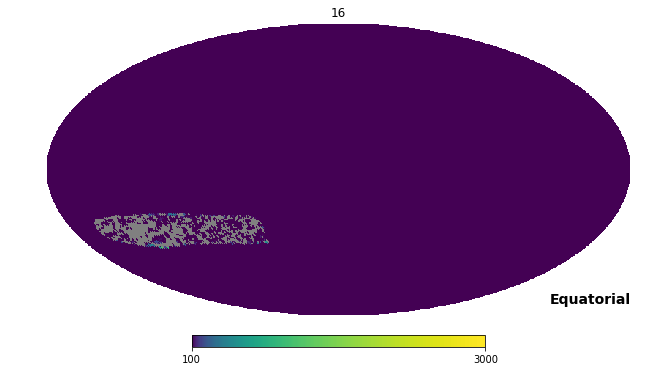

In [315]:
maps_mfreq_common_64_eigVectors_full = np.ones_like(maps_mfreq_64) * 10**(-5)
maps_mfreq_common_64_eigVectors_full[:, commom_vp_mask_64] = maps_mfreq_common_64_newspace.T
for id_eigvector,eigvector in enumerate(maps_mfreq_common_64_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=100, max=3000, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()

In [316]:
maps_mfreq_64 = []
for id_file, fitfile in enumerate(filenames_64):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 1250.:
        maps_mfreq_64.append(map_fit)
        
maps_mfreq_64 = np.array(maps_mfreq_64)
commom_vp_mask_64 = np.prod(np.abs(maps_mfreq_64) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_64 = maps_mfreq_64[:, commom_vp_mask_64]
print('maps_mfreq_64 shape: {}'.format(maps_mfreq_64.shape))
print('maps_mfreq_common_64 shape: {}'.format(maps_mfreq_common_64.shape))
print('Number of Common Valid Pixels-64: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_64) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca_64 = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca_64.fit(maps_mfreq_common_64)
maps_mfreq_common_64_eigValues_ratio = pca_64.explained_variance_ratio_
maps_mfreq_common_64_eigValues = pca_64.singular_values_
maps_mfreq_common_64_eigVectors = pca_64.components_
maps_mfreq_common_64_newspace = pca_64.fit_transform(maps_mfreq_common_64)
print('EigenValues_64: \n{}\n'.format(maps_mfreq_common_64_eigValues))
print('EigenValuesRatio_64: \n{}\n'.format(maps_mfreq_common_64_eigValues_ratio))
print('EigenVectorsShape_64: {}\n'.format(maps_mfreq_common_64_eigVectors.shape))
print('Maps64_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_64_newspace.shape))
print('Maps64_Common_NewSpace: {}'.format(maps_mfreq_common_64_newspace))

id_freq = 0
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_64_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64_newspace[id_freq].dot(maps_mfreq_common_64_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_64[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_64_newspace[id_freq].dot(maps_mfreq_common_64_eigVectors))[-number_to_show:])

>>>>>>>> Number of Valid Pixels: 3763
>>>>>>>> Number of Valid Pixels: 3684
>>>>>>>> Number of Valid Pixels: 3169
>>>>>>>> Number of Valid Pixels: 2603
>>>>>>>> Number of Valid Pixels: 3282
>>>>>>>> Number of Valid Pixels: 3211
>>>>>>>> Number of Valid Pixels: 3064
>>>>>>>> Number of Valid Pixels: 2907
>>>>>>>> Number of Valid Pixels: 2824
>>>>>>>> Number of Valid Pixels: 2803
>>>>>>>> Number of Valid Pixels: 2856
>>>>>>>> Number of Valid Pixels: 2775
>>>>>>>> Number of Valid Pixels: 2565
>>>>>>>> Number of Valid Pixels: 2370
>>>>>>>> Number of Valid Pixels: 2450
>>>>>>>> Number of Valid Pixels: 2424
>>>>>>>> Number of Valid Pixels: 1779
maps_mfreq_64 shape: (17, 49152)
maps_mfreq_common_64 shape: (17, 1751)
Number of Common Valid Pixels-64: 1751
EigenValues_64: 
[8.52706928e+04 6.97516935e+04 5.14591904e+04 4.32520015e+04
 3.17432624e+04 3.07248546e+04 2.37726804e+04 2.03602882e+04
 8.81364231e+03 8.18326768e+03 6.88151774e+03 6.26985029e+03
 5.65174133e+03 4.79781652e+03 4.20894135e+

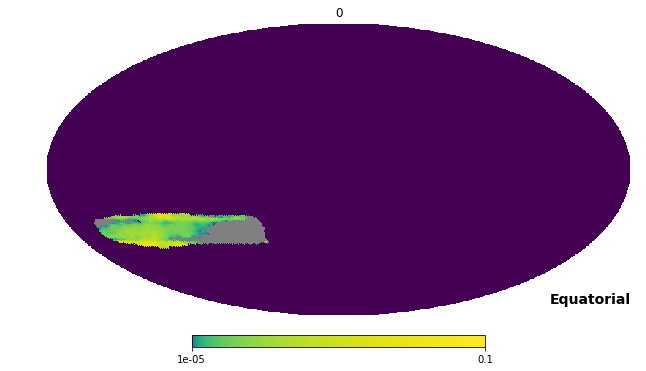

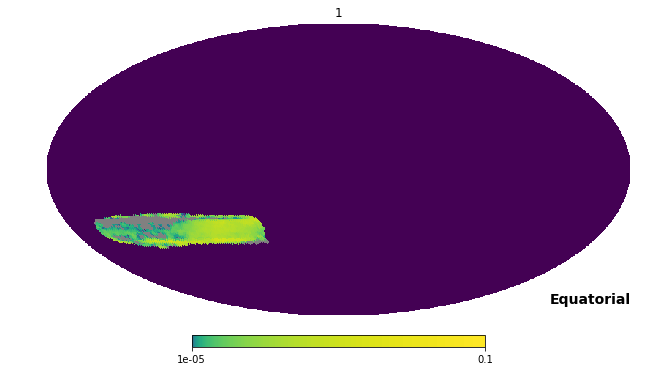

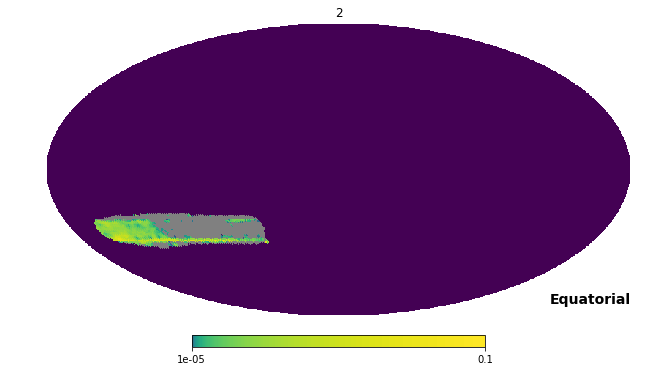

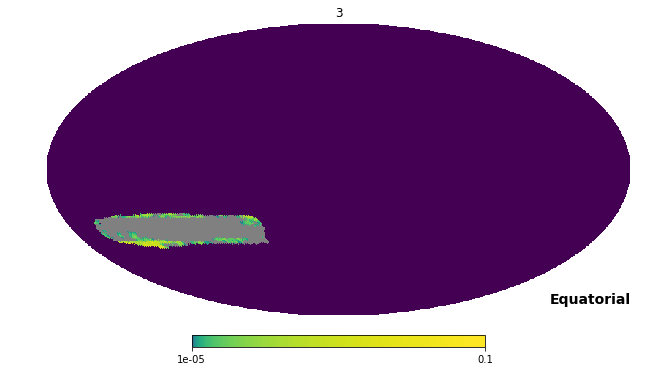

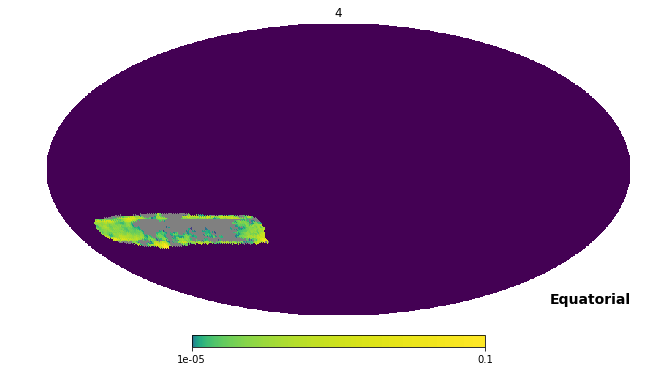

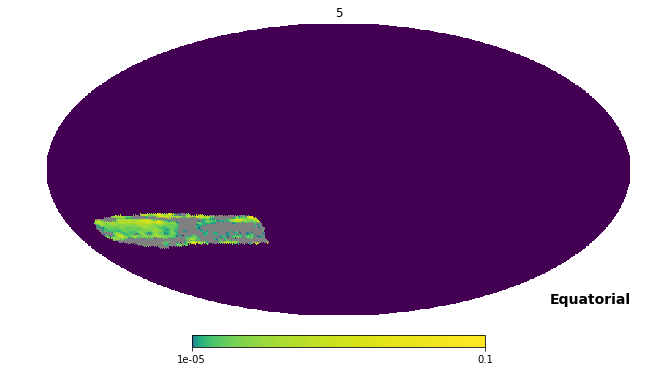

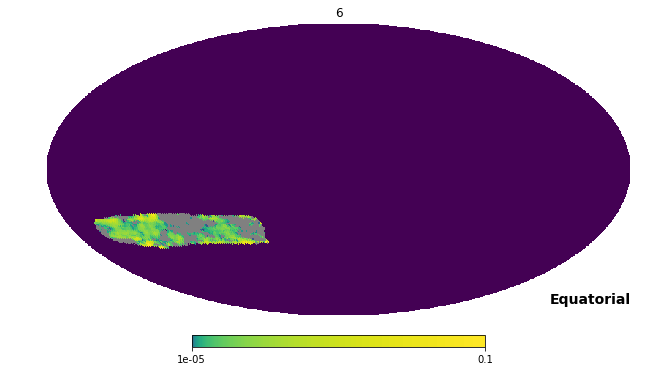

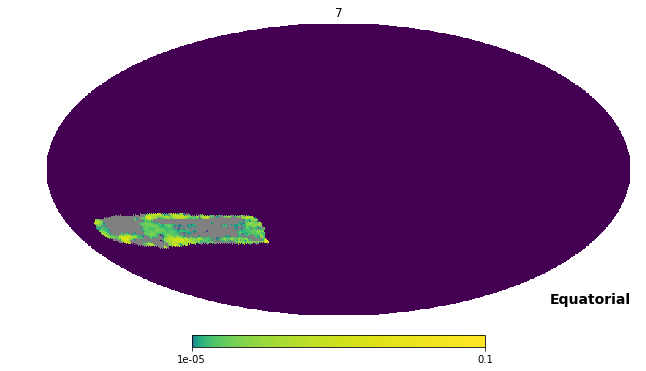

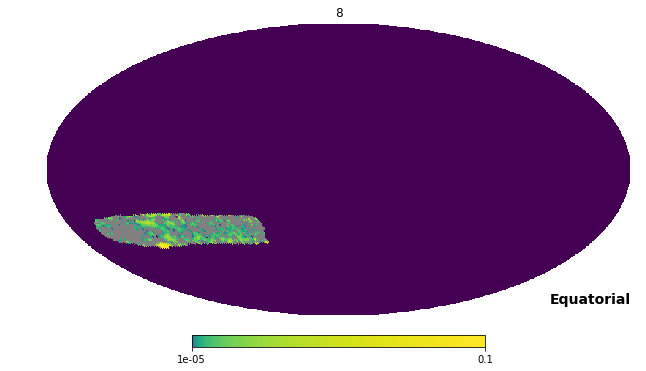

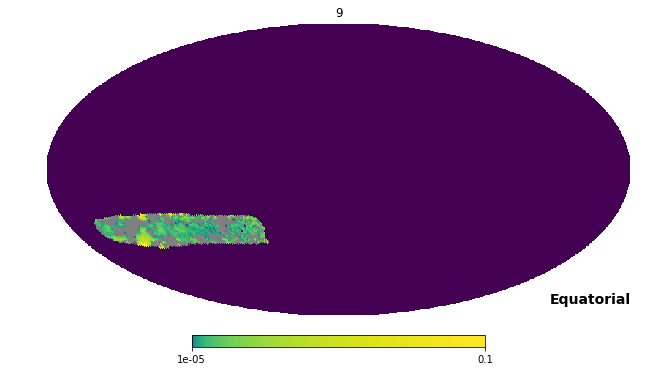

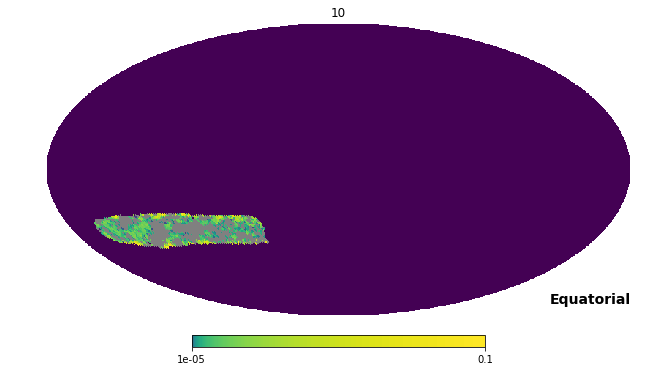

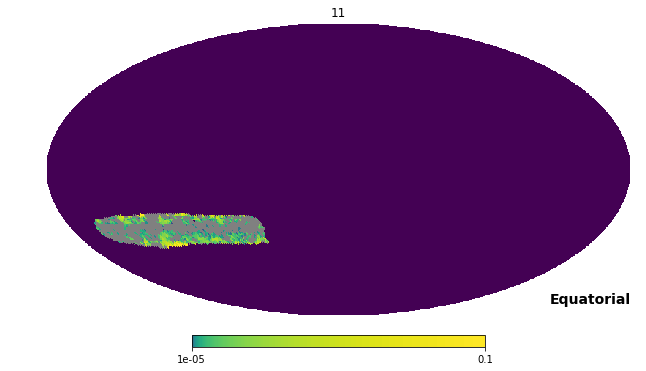

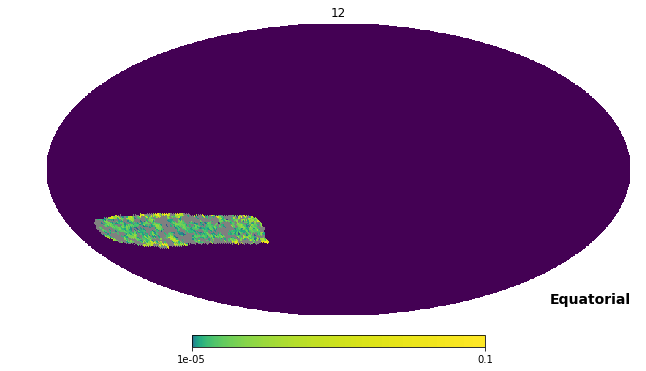

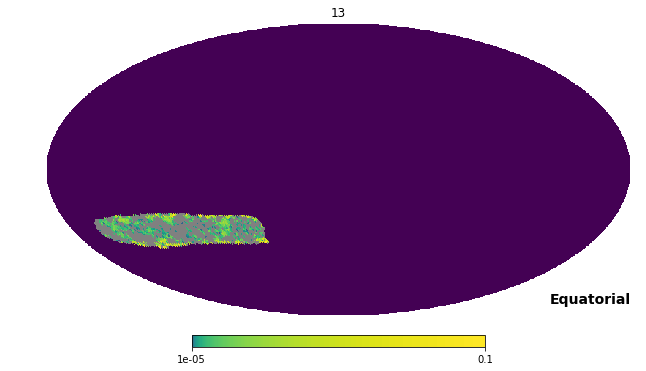

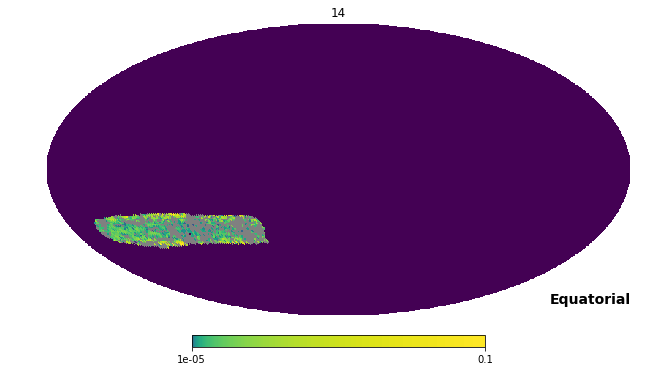

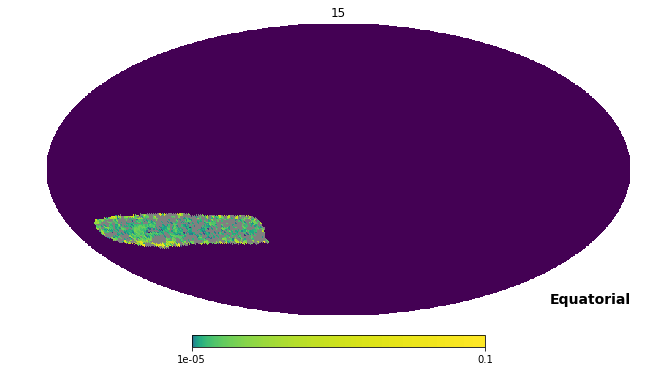

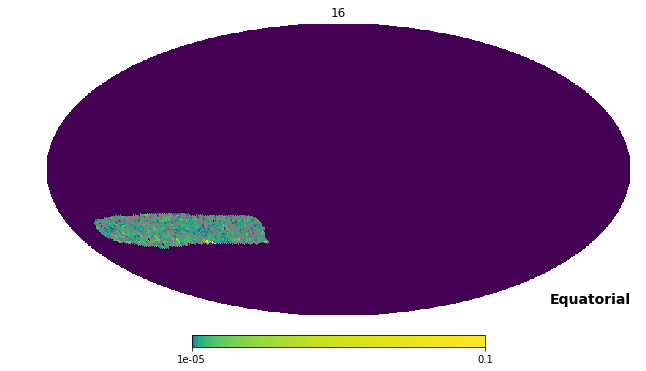

In [317]:
maps_mfreq_common_64_eigVectors_full = np.ones_like(maps_mfreq_64) * 10**(-5)
maps_mfreq_common_64_eigVectors_full[:, commom_vp_mask_64] = maps_mfreq_common_64_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_64_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-5), max=10.**(-1), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()

In [318]:
nside_standard = 64
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_whole_64 = fits.getdata(filenames_64[2]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_whole_64)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_whole_64)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_whole_64[np.argsort(ww_solution_whole_64)[-80:]]))

Bright_Pixels_Data: [[-22.66960987 -37.92165078 -22.02431284 -37.16889966 -39.45089471
  -19.47122063 -20.74237995 -39.45089471 -22.02431284 -37.92165078
  -37.92165078 -37.92165078 -41.8103149  -23.96948232 -23.96948232
  -36.42357364 -23.96948232 -43.40685849 -20.10550979 -21.38194258
  -37.92165078 -38.68218745 -22.02431284 -20.10550979 -37.16889966
  -37.16889966 -37.92165078 -20.74237995 -38.68218745 -41.01449967
  -43.40685849 -23.96948232 -40.22818473 -40.22818473 -37.92165078
  -21.38194258 -37.92165078 -43.40685849 -38.68218745 -40.22818473
  -41.8103149  -38.68218745 -41.01449967 -41.8103149  -41.8103149
  -37.16889966 -37.92165078 -21.38194258 -37.92165078 -19.47122063
  -38.68218745 -42.60980698 -41.8103149  -20.74237995 -41.8103149
  -40.22818473 -21.38194258 -38.68218745 -41.01449967 -37.92165078
  -21.38194258 -39.45089471 -42.60980698 -39.45089471 -42.60980698
  -37.92165078 -39.45089471 -44.20152985 -40.22818473 -37.92165078
  -20.10550979 -41.8103149  -20.10550979 -20

(0, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-110.11-gW-0.048978-110.1074MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 51.3984160812
>>>>>>>> Maximum in the Map: 2458.14553411


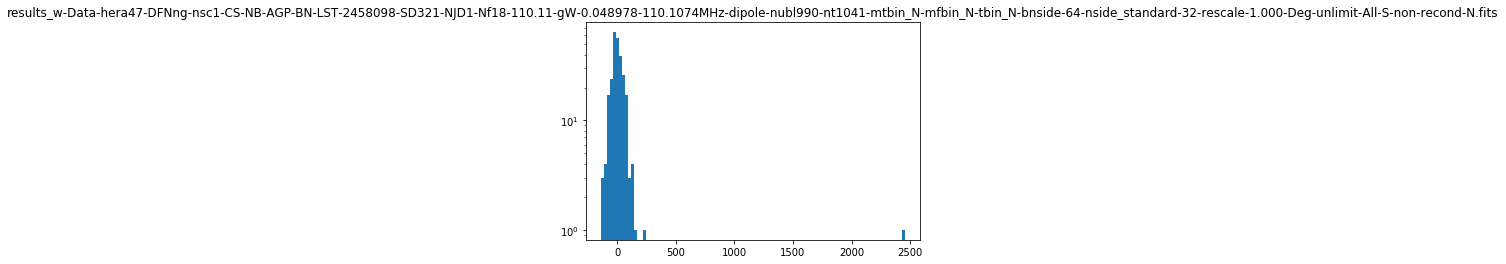

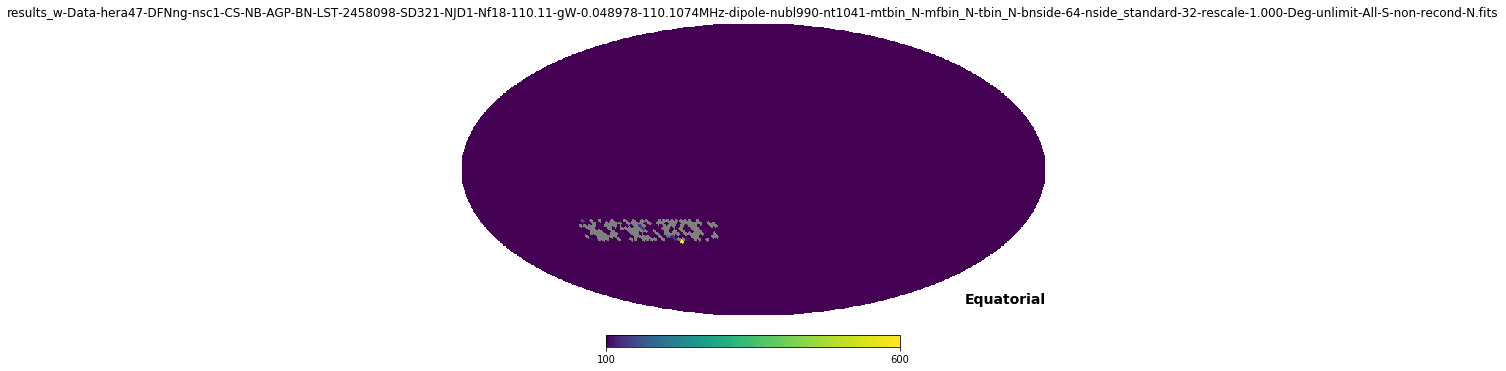

(1, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-114.79-gW-0.048978-114.7949MHz-dipole-nubl990-nt1035-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 66.5326967061
>>>>>>>> Maximum in the Map: 3108.53607258


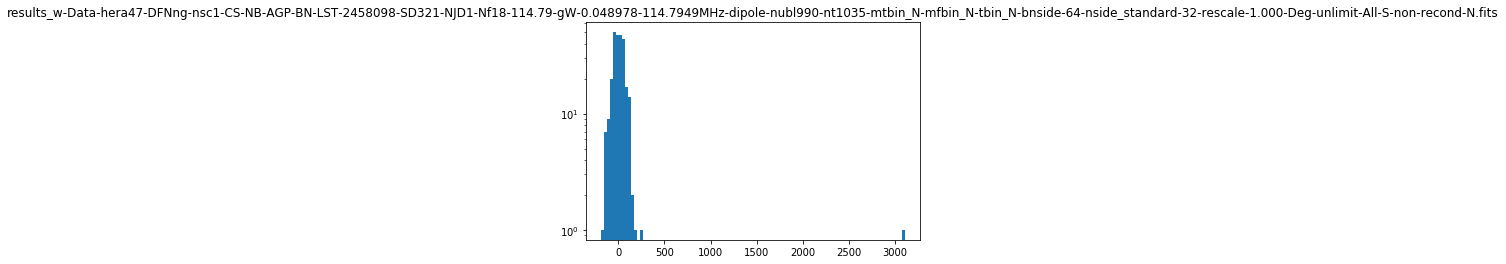

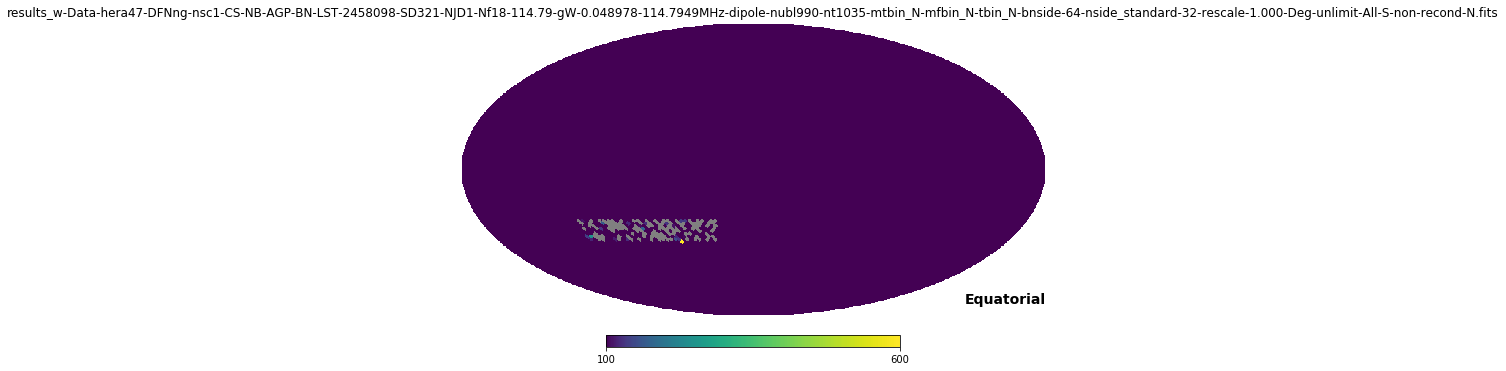

(2, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-119.48-gW-0.048978-119.4824MHz-dipole-nubl990-nt803-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 72.6326436825
>>>>>>>> Maximum in the Map: 2879.1208649


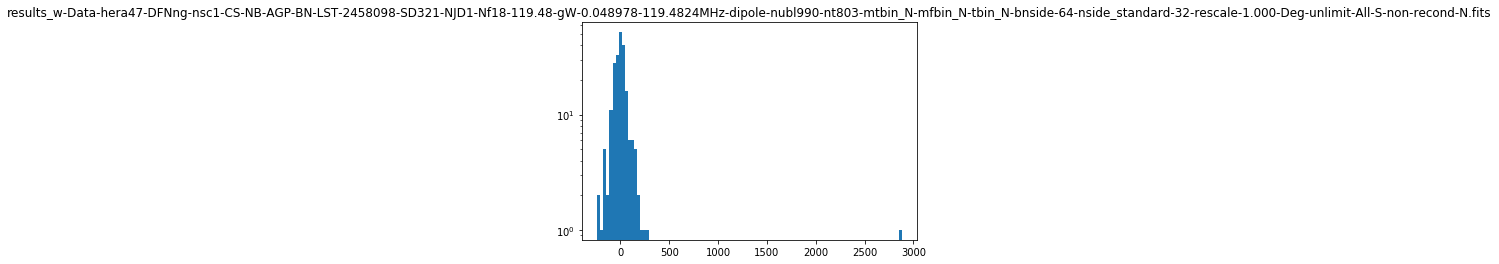

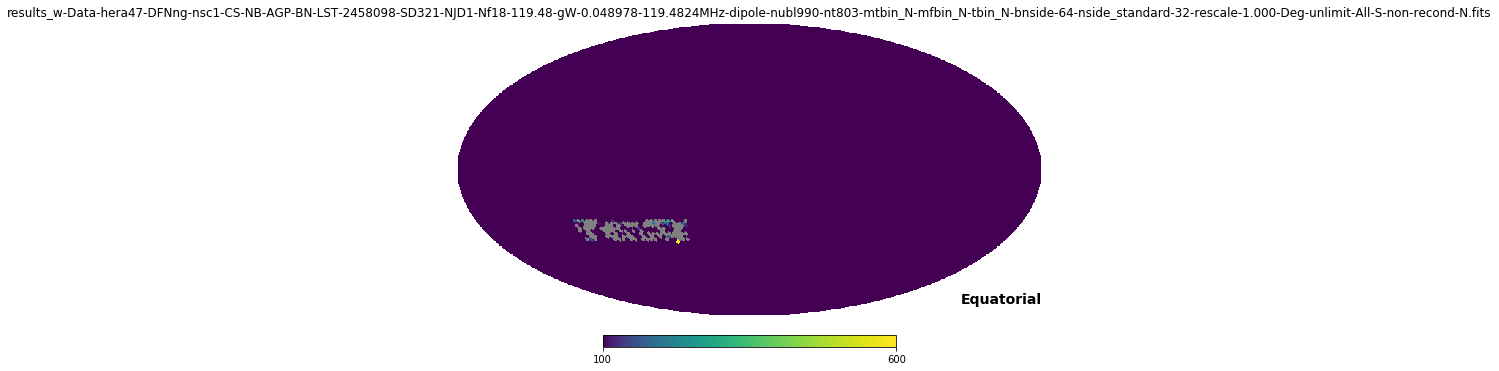

(3, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-125.73-gW-0.048978-125.7324MHz-dipole-nubl990-nt636-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 49.7726086878
>>>>>>>> Maximum in the Map: 1890.19217613


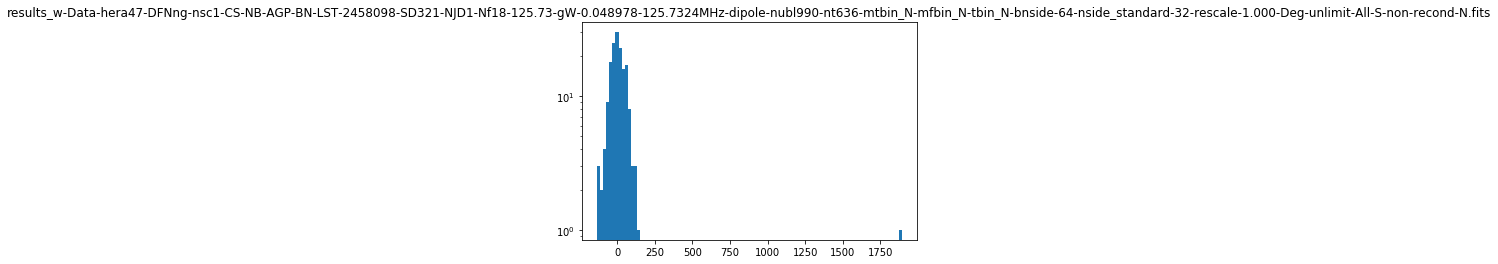

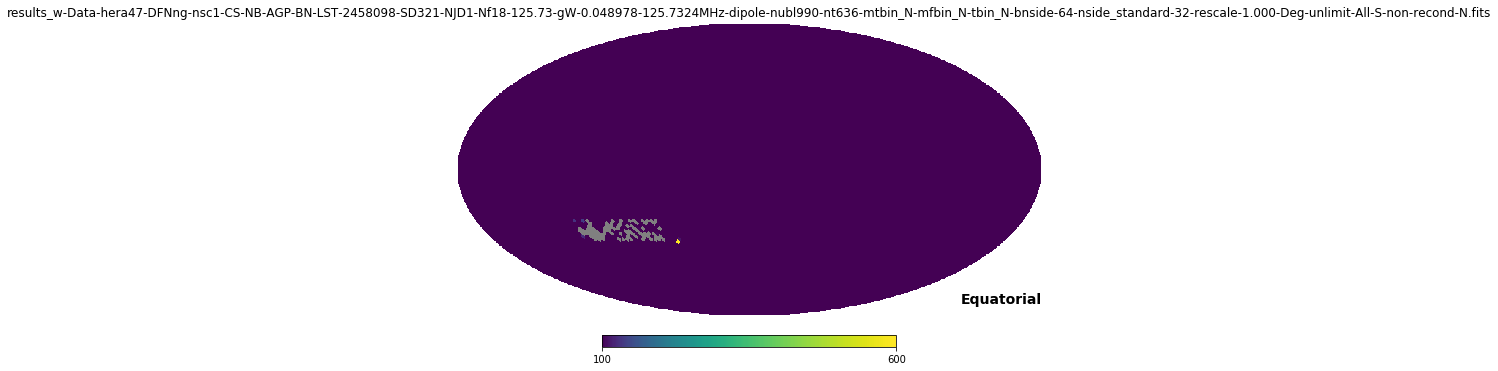

(4, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-130.42-gW-0.048978-130.4199MHz-dipole-nubl990-nt1031-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 30.7403869304
>>>>>>>> Maximum in the Map: 1551.88634025


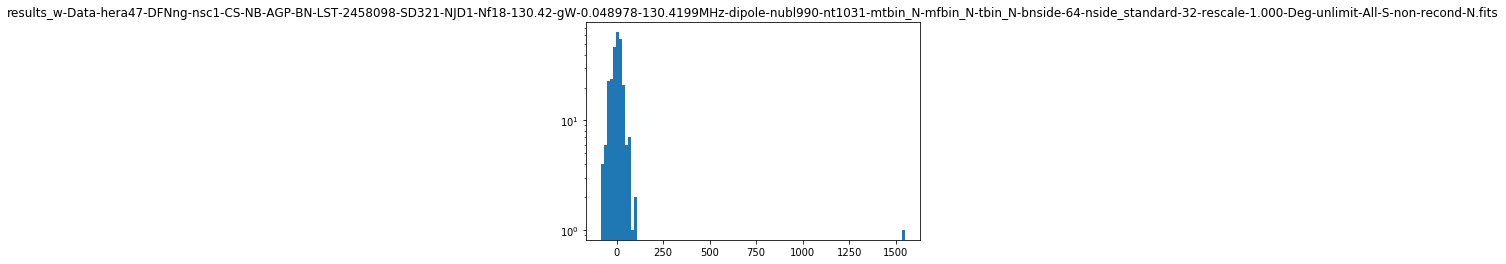

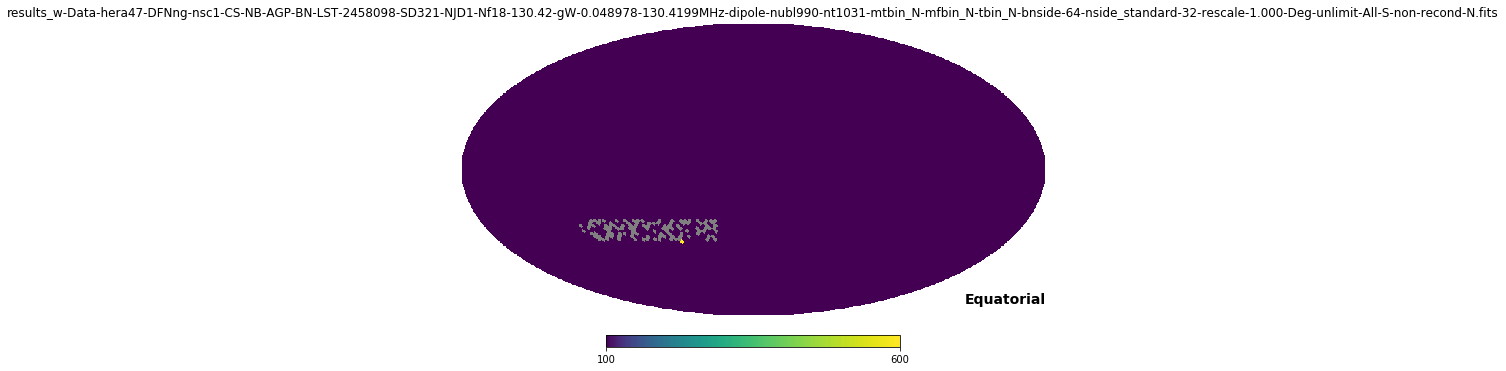

(5, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-135.11-gW-0.048978-135.1074MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 29.6037003902
>>>>>>>> Maximum in the Map: 1381.25351181


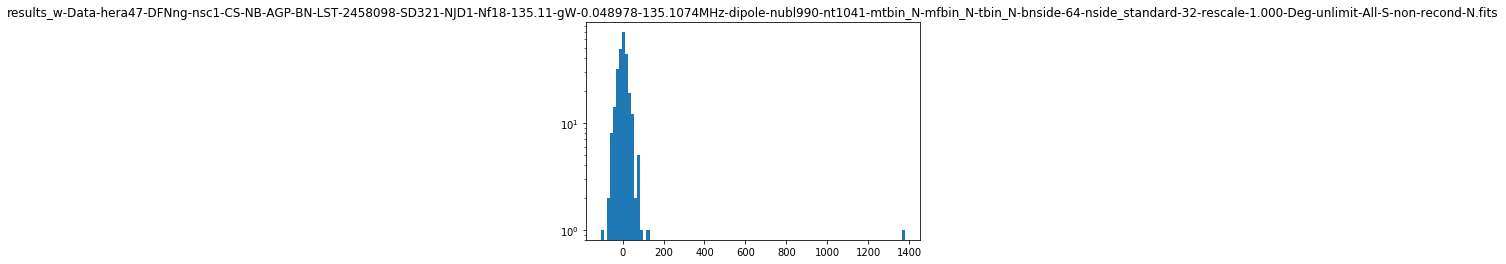

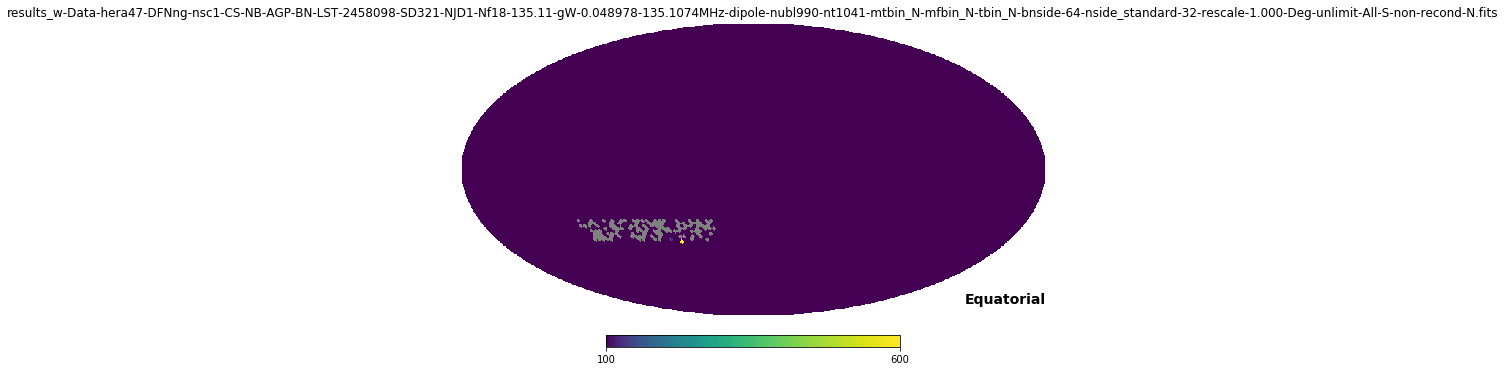

(6, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-139.79-gW-0.048978-139.7949MHz-dipole-nubl990-nt1038-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 30.9019584312
>>>>>>>> Maximum in the Map: 1489.79828443


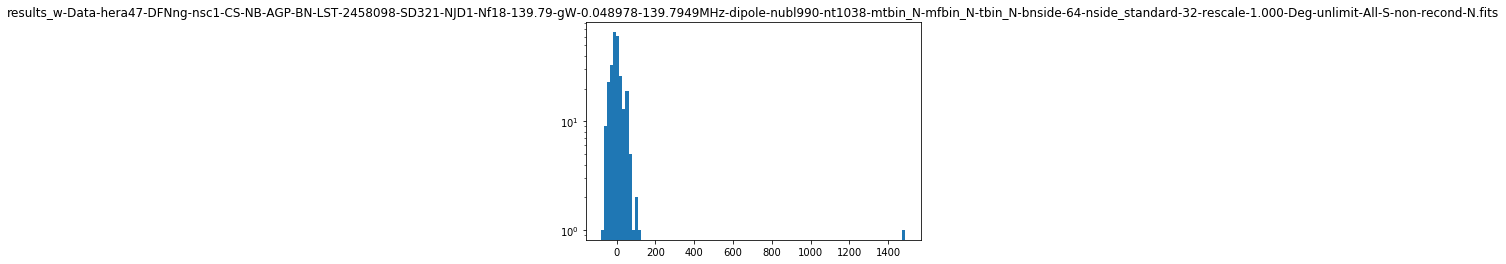

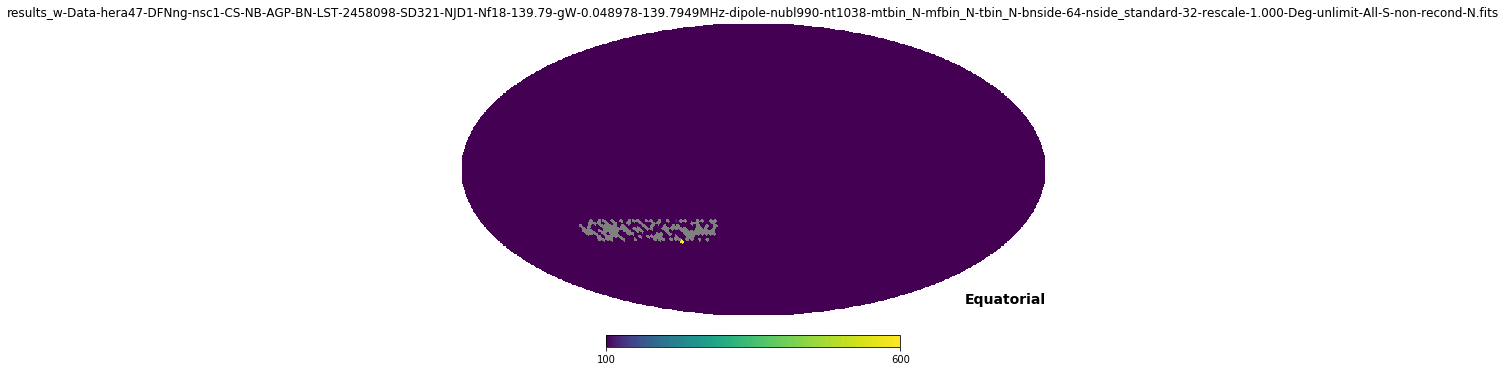

(7, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-144.48-gW-0.048978-144.4824MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 28.6745682838
>>>>>>>> Maximum in the Map: 1282.89335749


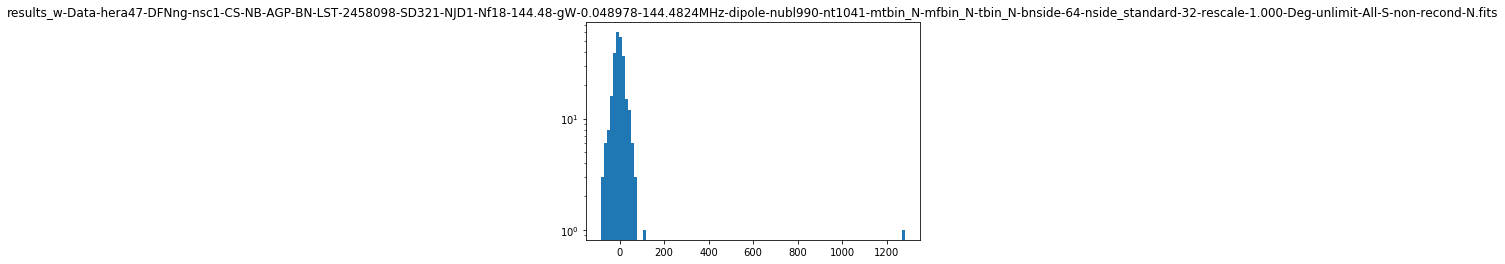

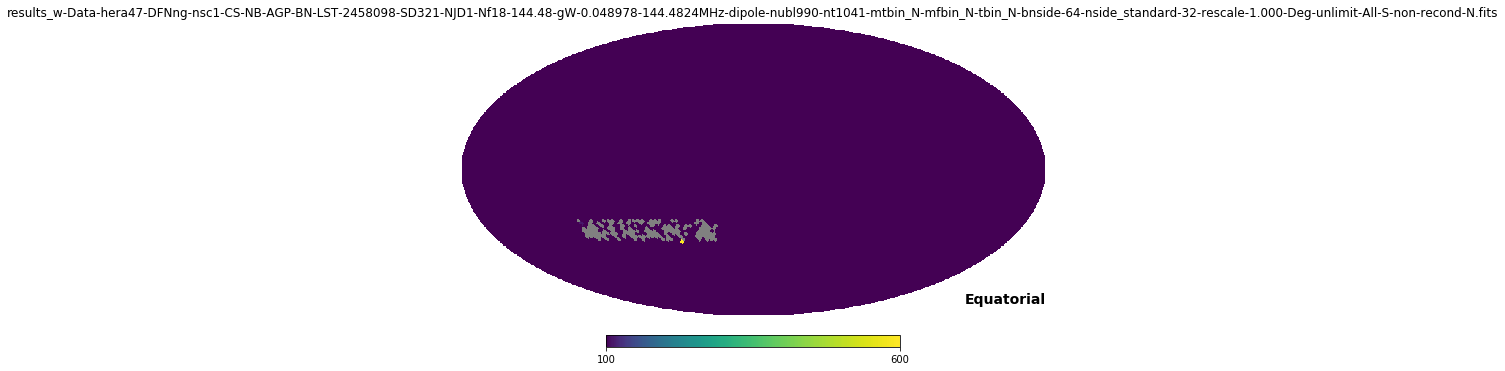

(8, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt1024-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 20.0082758186
>>>>>>>> Maximum in the Map: 1056.22626436


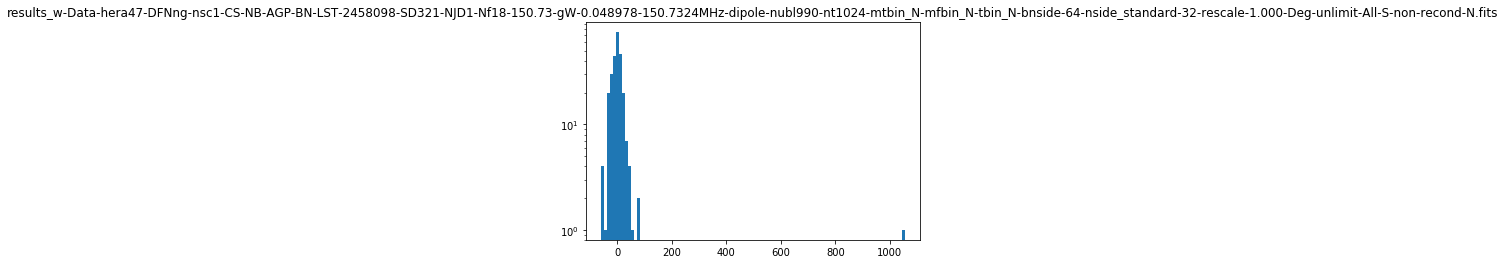

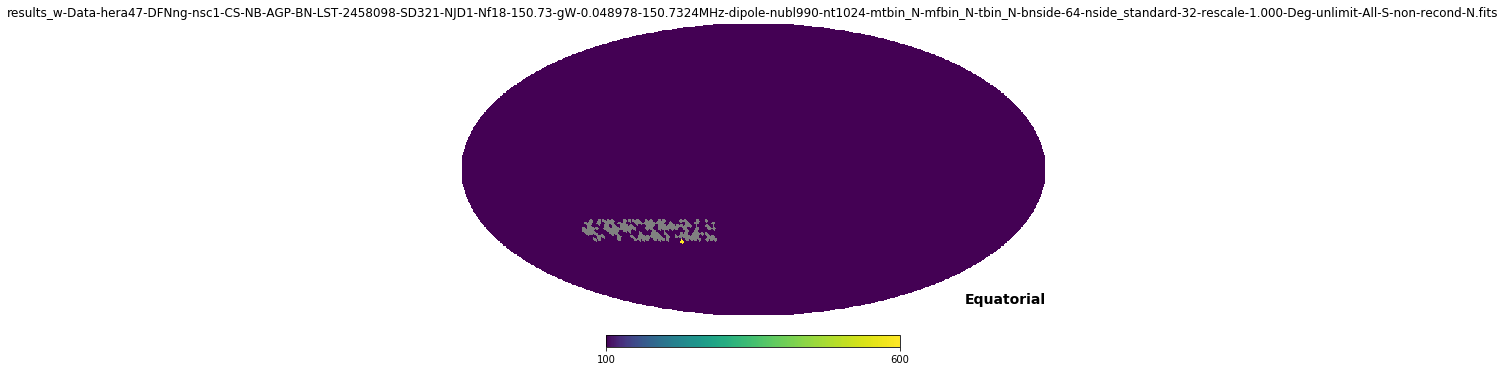

(9, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-155.42-gW-0.048978-155.4199MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 24.3566802483
>>>>>>>> Maximum in the Map: 1180.79868603


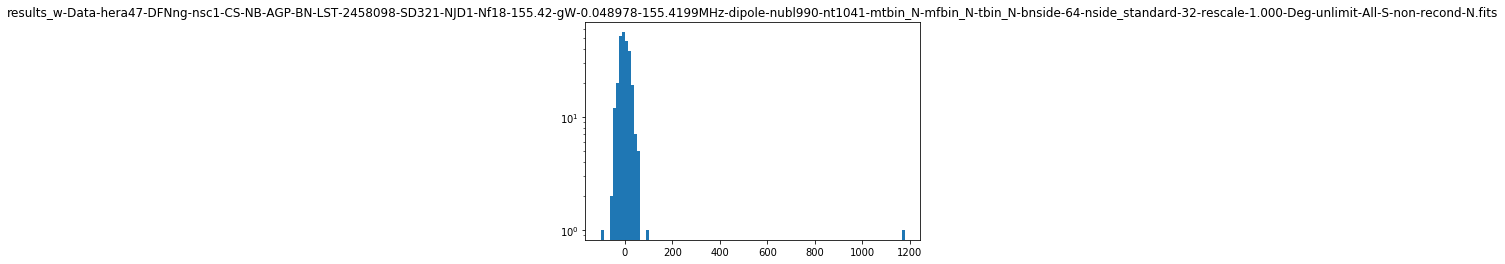

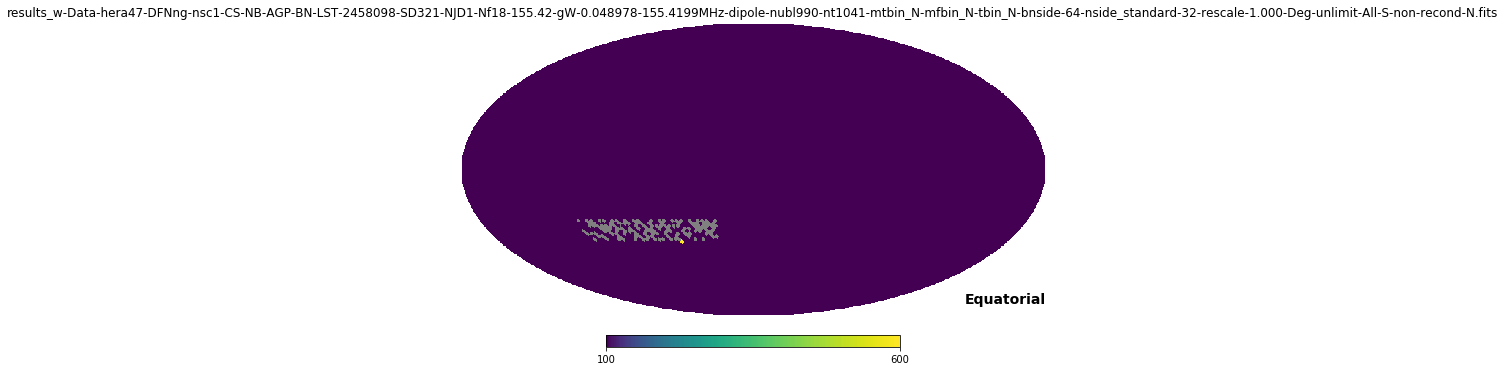

(10, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-160.11-gW-0.048978-160.1074MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 29.2930282957
>>>>>>>> Maximum in the Map: 948.933105286


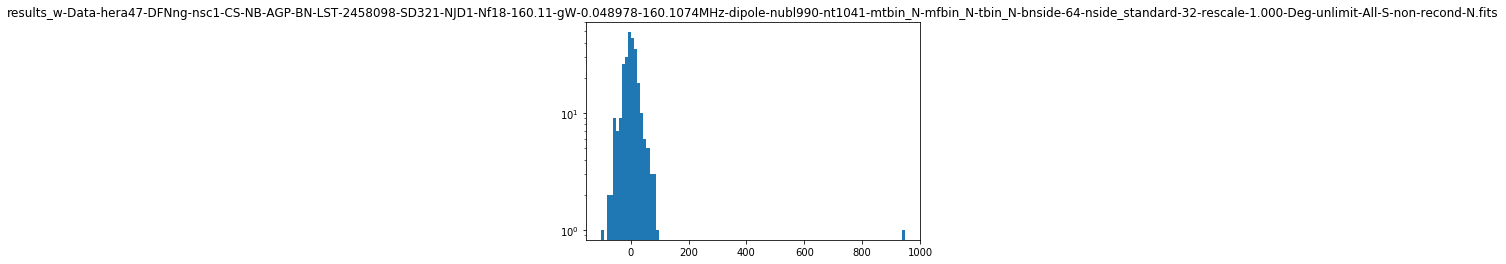

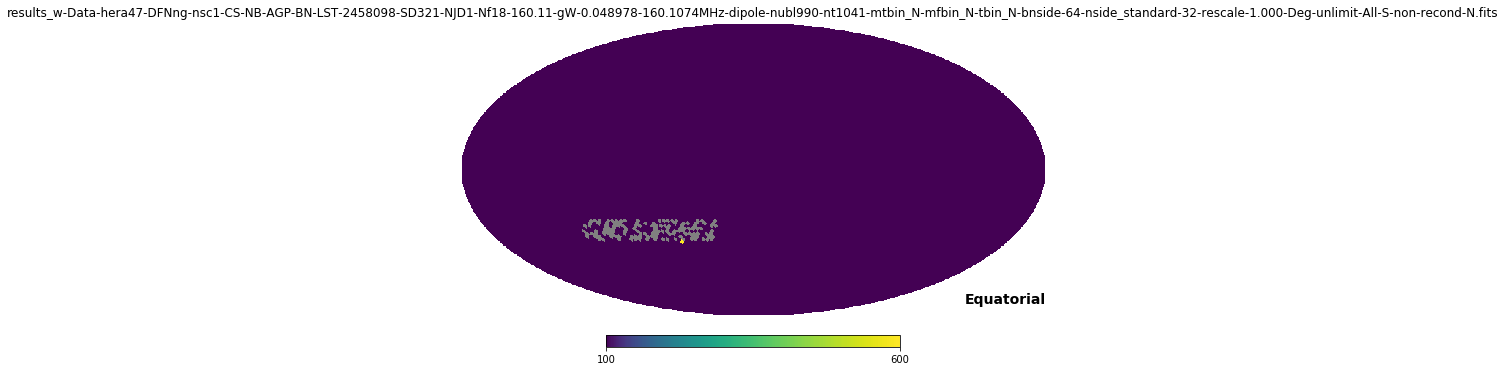

(11, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-164.79-gW-0.048978-164.7949MHz-dipole-nubl990-nt1040-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 35.0312035363
>>>>>>>> Maximum in the Map: 730.664887141


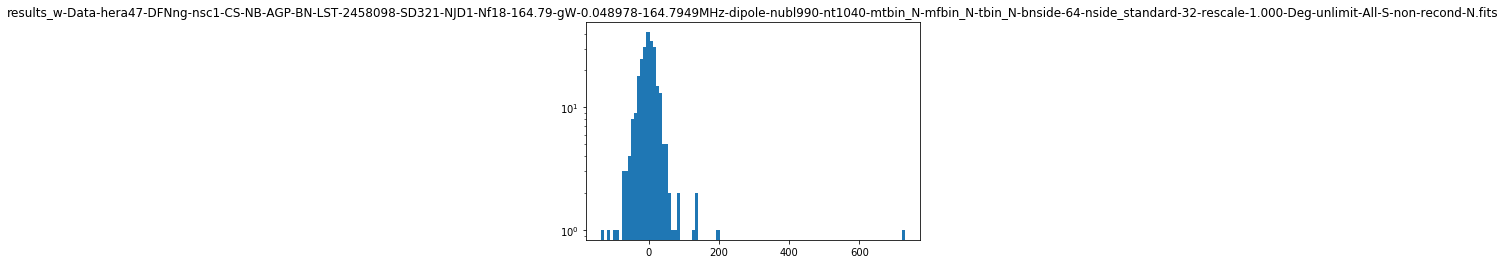

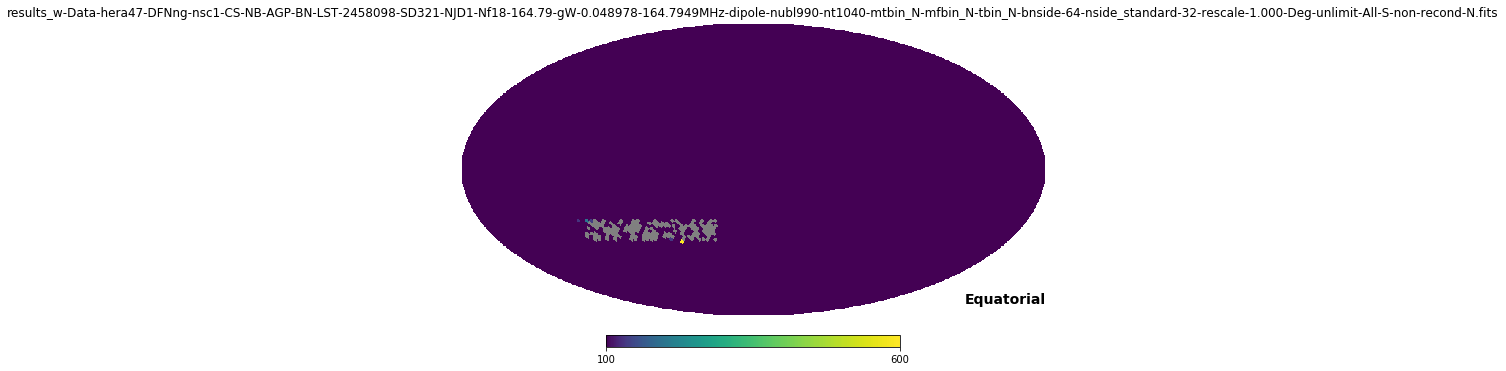

(12, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-169.48-gW-0.048978-169.4824MHz-dipole-nubl946-nt146-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 24.4157875391
>>>>>>>> Maximum in the Map: 487.031354713


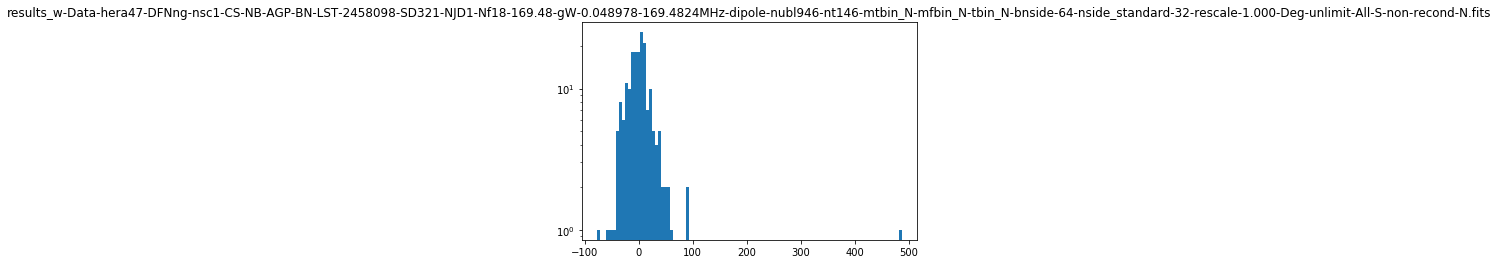

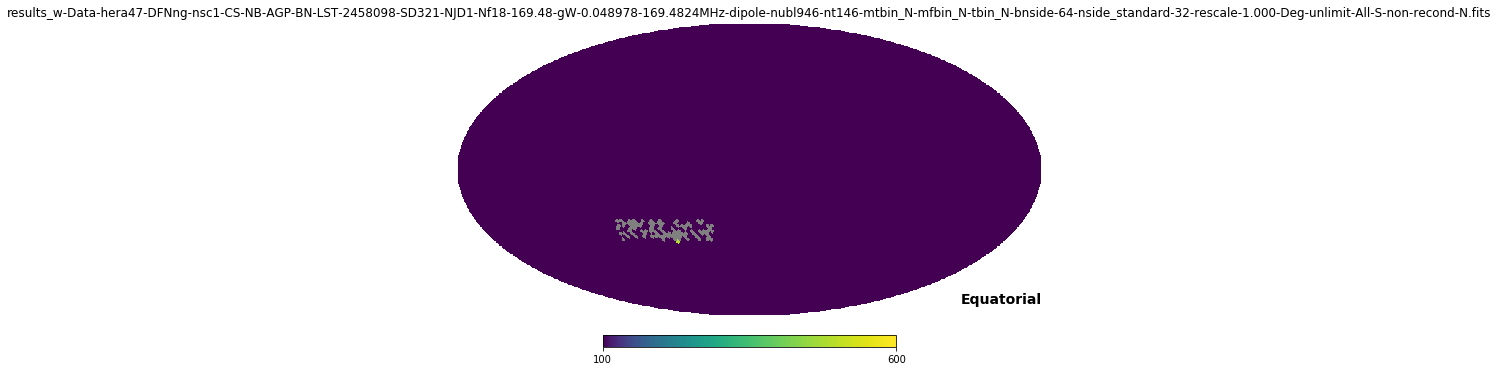

(13, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-174.17-gW-0.048978-174.1699MHz-dipole-nubl990-nt860-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 17.0785362523
>>>>>>>> Maximum in the Map: 526.219614393


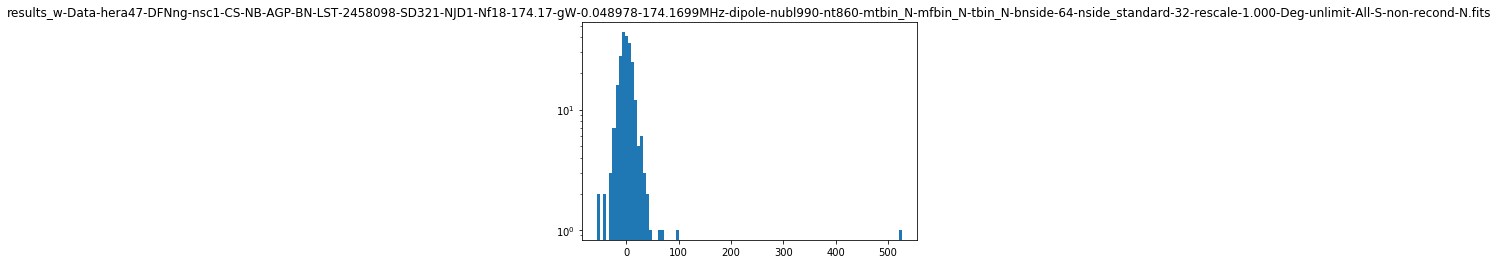

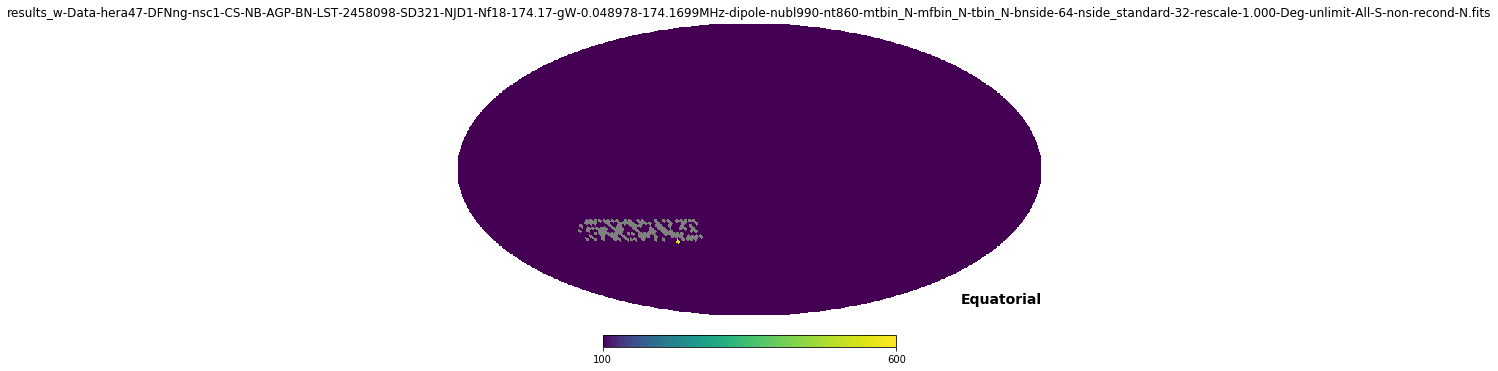

(14, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-178.86-gW-0.048978-178.8574MHz-dipole-nubl990-nt912-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 17.5648193651
>>>>>>>> Maximum in the Map: 545.655887269


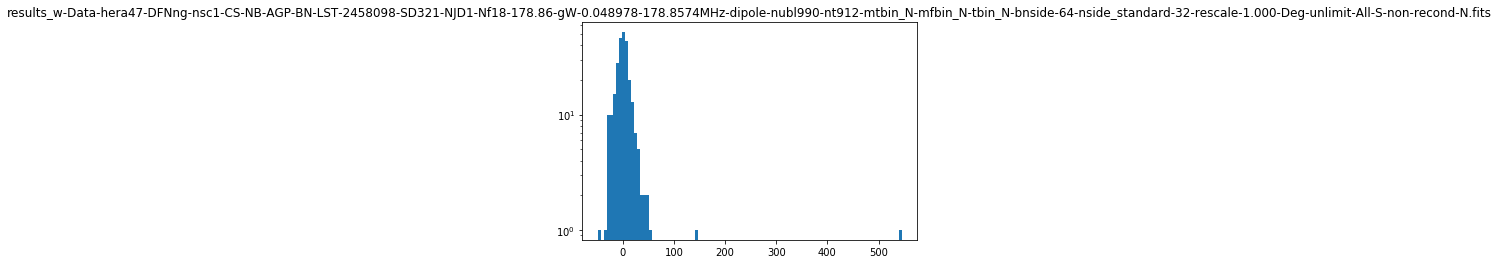

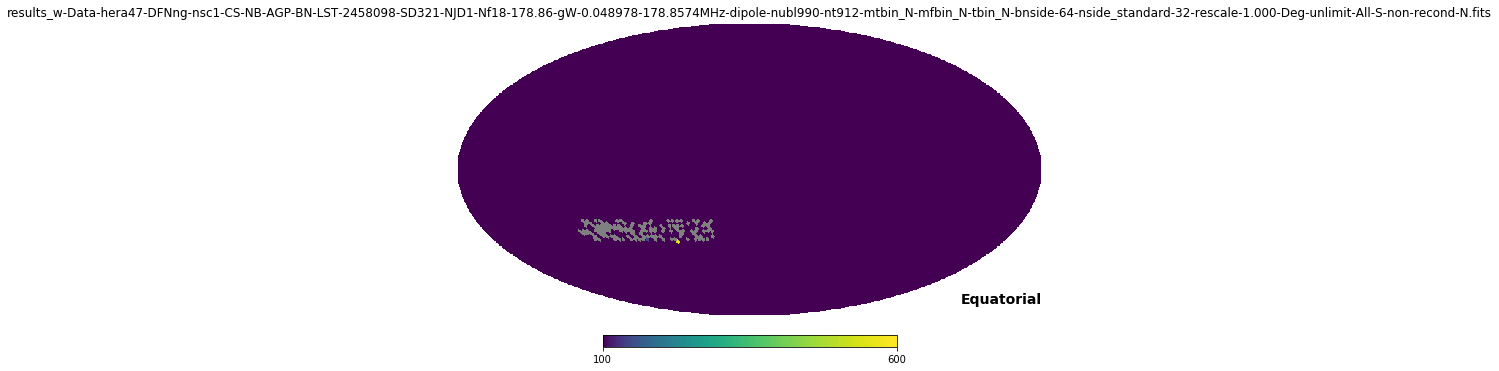

In [319]:
for id_file, fitfile in enumerate(filenames_32_321):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map32-part without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-1]][np.abs(map_fit[np.argsort(map_fit)[:-1]]) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    plt.figure(25000 + id_file)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.title(name)
    plt.show()
    #plt.close()
    plt.figure(65000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    #plt.close()

>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 213
>>>>>>>> Number of Valid Pixels: 163
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 257
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 261
>>>>>>>> Number of Valid Pixels: 185
>>>>>>>> Number of Valid Pixels: 237
>>>>>>>> Number of Valid Pixels: 261
maps_mfreq_32_321 shape: (15, 12288)
maps_mfreq_common_32_321 shape: (15, 87)
Number of Common Valid Pixels-32_321: 87
EigenValues: 
[3.14006021e+03 5.49307072e+02 4.67413050e+02 4.20030902e+02
 3.08175368e+02 3.04012925e+02 2.81869603e+02 2.63551922e+02
 2.44785263e+02 2.19657177e+02 2.02212279e+02 1.96322041e+02
 1.52647337e+02 1.22159508e+02 1.87981009e-13]

EigenValuesRatio: 
[8.86788467e-01 2.71377892e-02 1.96492397e-02 1.58674293e-02
 

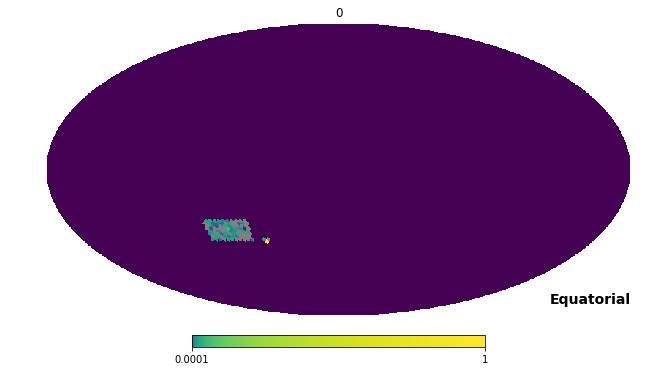

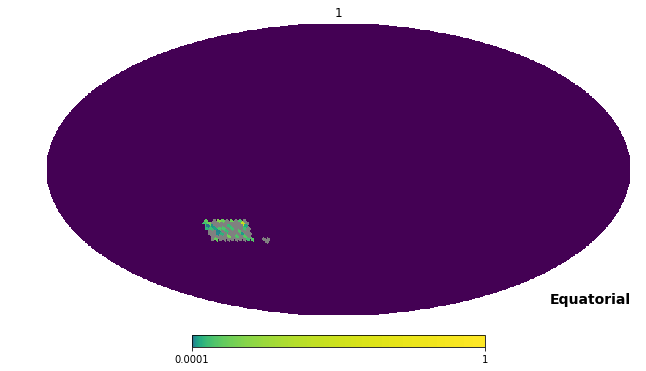

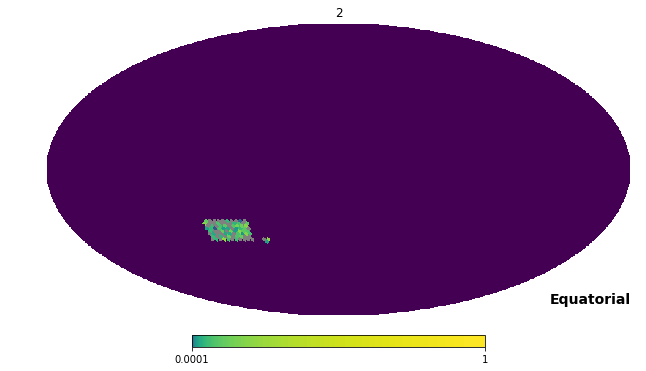

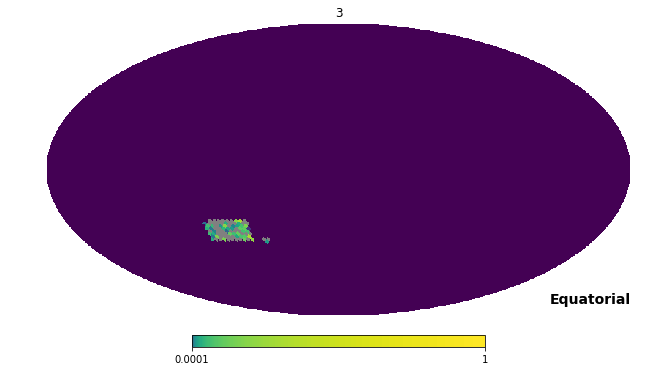

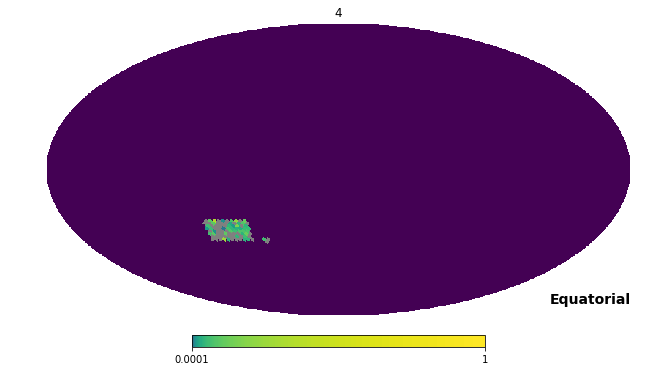

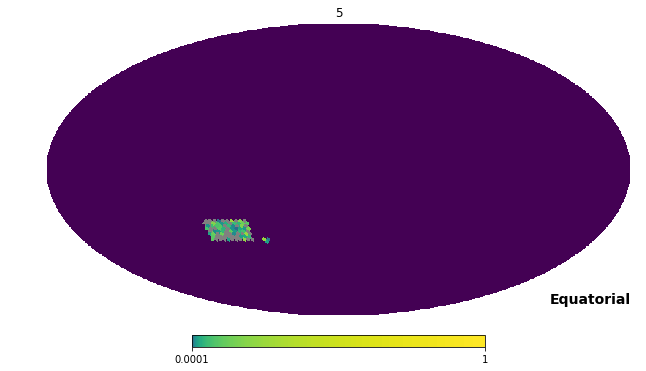

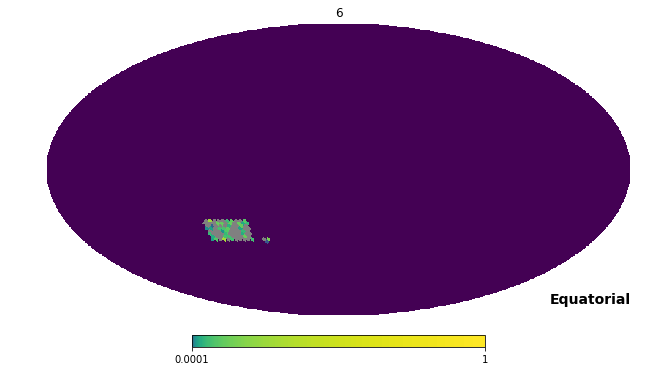

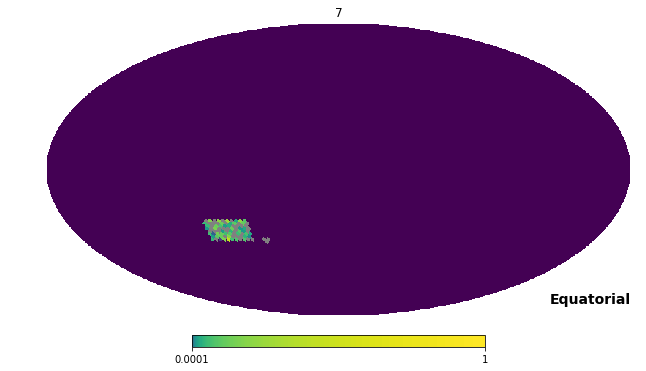

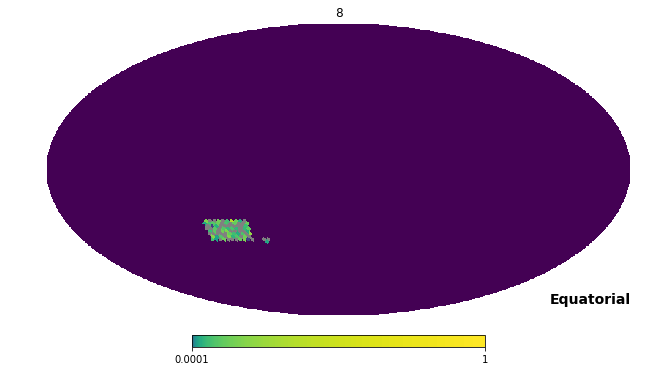

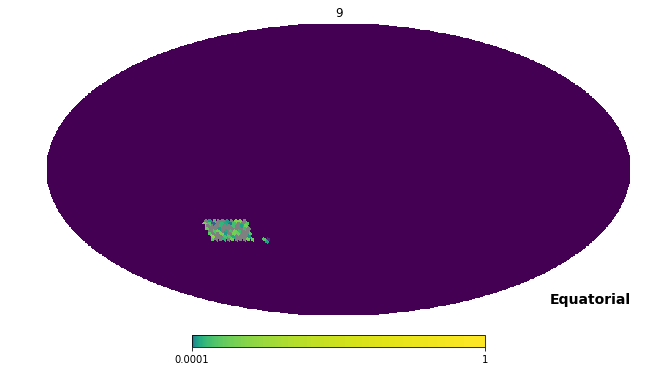

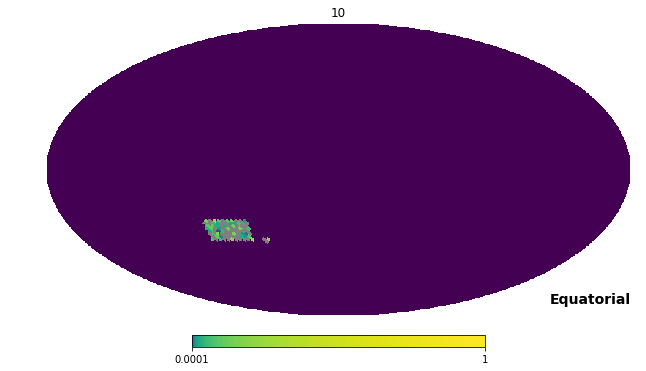

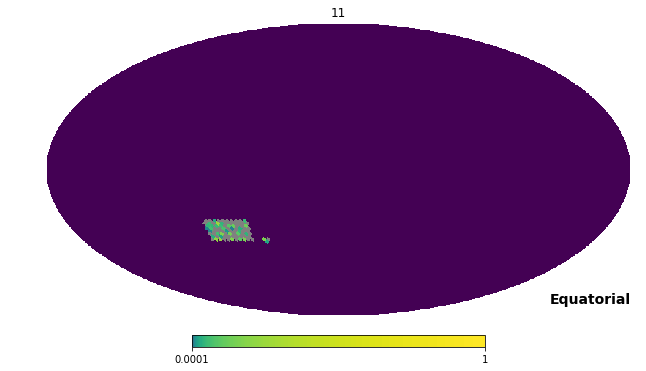

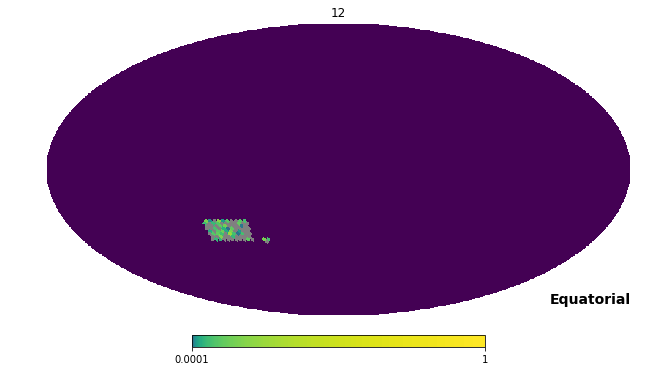

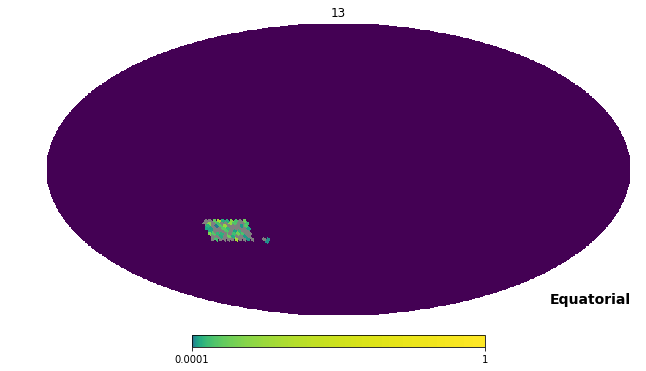

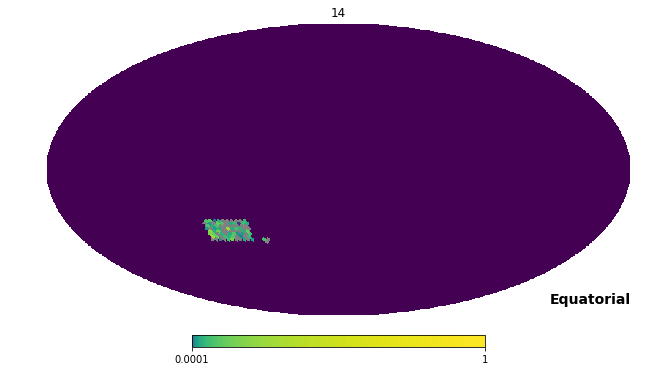

In [320]:
maps_mfreq_32_321 = []
for id_file, fitfile in enumerate(filenames_32_321):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 150.:
        maps_mfreq_32_321.append(map_fit)
        
maps_mfreq_32_321 = np.array(maps_mfreq_32_321)
commom_vp_mask_32_321 = np.prod(np.abs(maps_mfreq_32_321) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_32_321 = maps_mfreq_32_321[:, commom_vp_mask_32_321]
print('maps_mfreq_32_321 shape: {}'.format(maps_mfreq_32_321.shape))
print('maps_mfreq_common_32_321 shape: {}'.format(maps_mfreq_common_32_321.shape))
print('Number of Common Valid Pixels-32_321: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_32_321) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_32_321)
maps_mfreq_common_32_321_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_32_321_eigValues = pca.singular_values_
maps_mfreq_common_32_321_eigVectors = pca.components_
maps_mfreq_common_32_321_newspace = pca.fit_transform(maps_mfreq_common_32_321)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_32_321_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_32_321_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_32_321_eigVectors.shape))
print('Maps32_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_32_321_newspace.shape))
print('Maps32_Common_NewSpace: {}'.format(maps_mfreq_common_32_321_newspace))

id_freq = 8
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32_321[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_32_321_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32_321_newspace[id_freq].dot(maps_mfreq_common_32_321_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_32_321[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_32_321_newspace[id_freq].dot(maps_mfreq_common_32_321_eigVectors))[-number_to_show:])

maps_mfreq_common_32_321_eigVectors_full = np.ones_like(maps_mfreq_32_321) * 10**(-5)
maps_mfreq_common_32_321_eigVectors_full[:, commom_vp_mask_32_321] = maps_mfreq_common_32_321_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_32_321_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-4), max=10.**(-0), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()


In [321]:
nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_part_32 = fits.getdata(filenames_32_321[8]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_part_32)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_part_32)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_part_32[np.argsort(ww_solution_part_32)[-40:]]))



Bright_Pixels_Data: [[ 66.44353569 -30.         -31.38816646 -25.94447977 -32.7971683
  -27.27961274 -31.38816646 -32.7971683  -30.         -34.22886633
  -31.38816646 -35.68533471 -28.63098984 -27.27961274 -30.
  -32.7971683  -34.22886633 -27.27961274 -31.38816646 -28.63098984
  -27.27961274 -34.22886633 -35.68533471 -28.63098984 -31.38816646
  -30.         -28.63098984 -27.27961274 -34.22886633 -25.94447977
  -31.38816646 -25.94447977 -32.7971683  -28.63098984 -31.38816646
  -35.68533471 -30.         -31.38816646 -31.38816646 -28.63098984
  -32.7971683  -35.68533471 -25.94447977 -28.63098984 -28.63098984
  -31.38816646 -32.7971683  -27.27961274 -25.94447977 -25.94447977
  -28.63098984 -25.94447977 -27.27961274 -25.94447977 -28.63098984
  -28.63098984 -31.38816646 -34.22886633 -25.94447977 -31.38816646
  -32.7971683  -35.68533471 -32.7971683  -35.68533471 -31.38816646
  -30.         -35.68533471 -31.38816646 -32.7971683  -27.27961274
  -32.7971683  -27.27961274 -34.22886633 -34.228866

(0, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-110.11-gW-0.048978-110.1074MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 757.510156356
>>>>>>>> Maximum in the Map: 5157.98572225


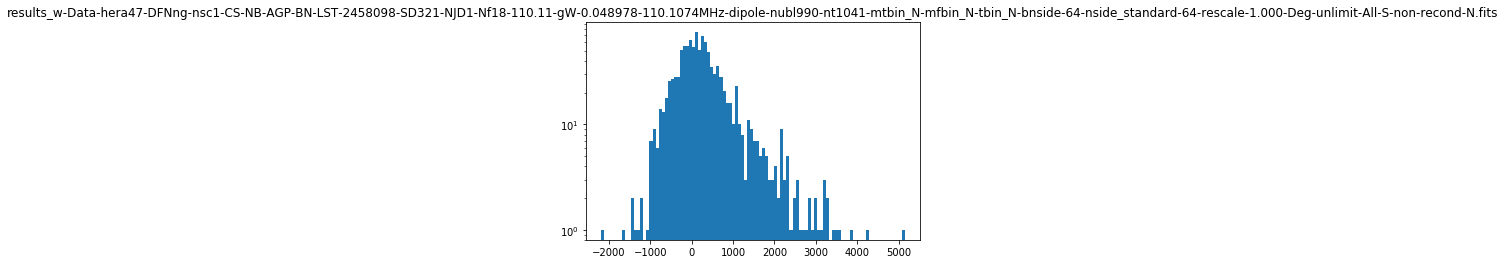

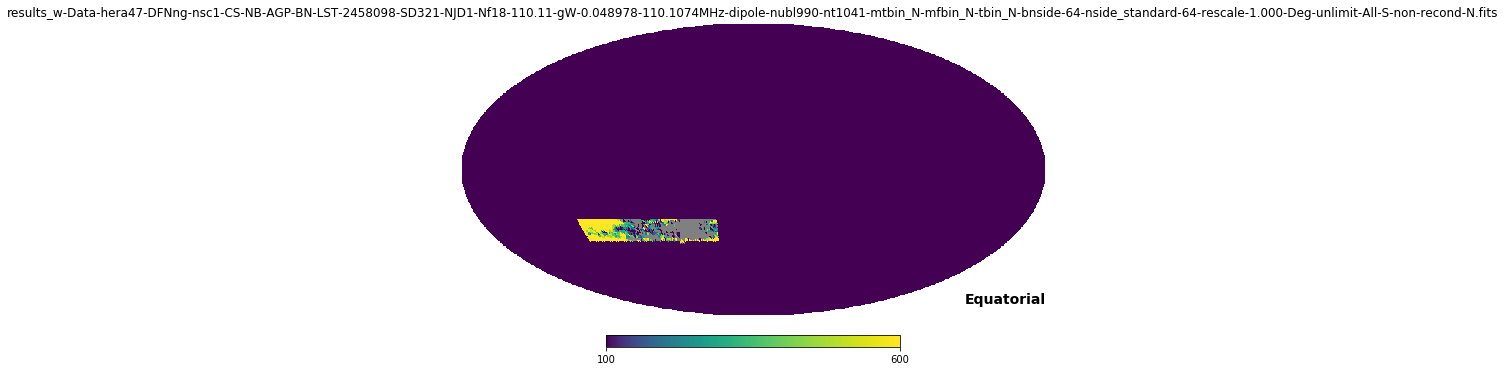

(1, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-119.48-gW-0.048978-119.4824MHz-dipole-nubl990-nt803-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 918.623924167
>>>>>>>> Maximum in the Map: 4754.05013353


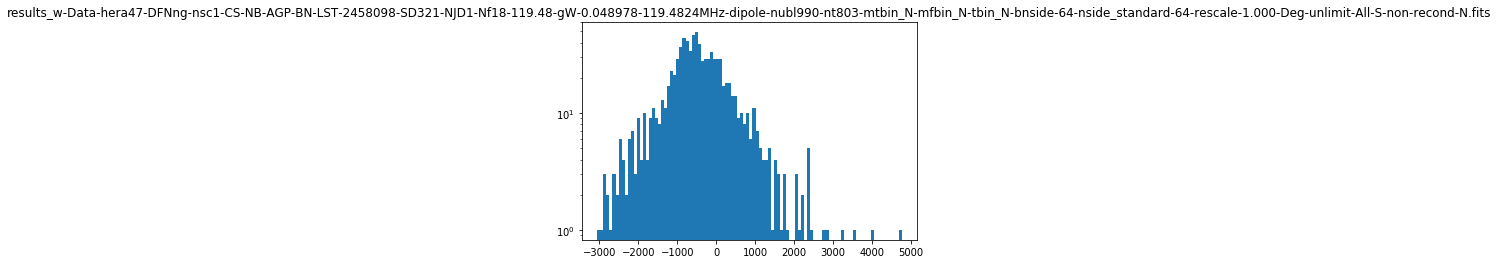

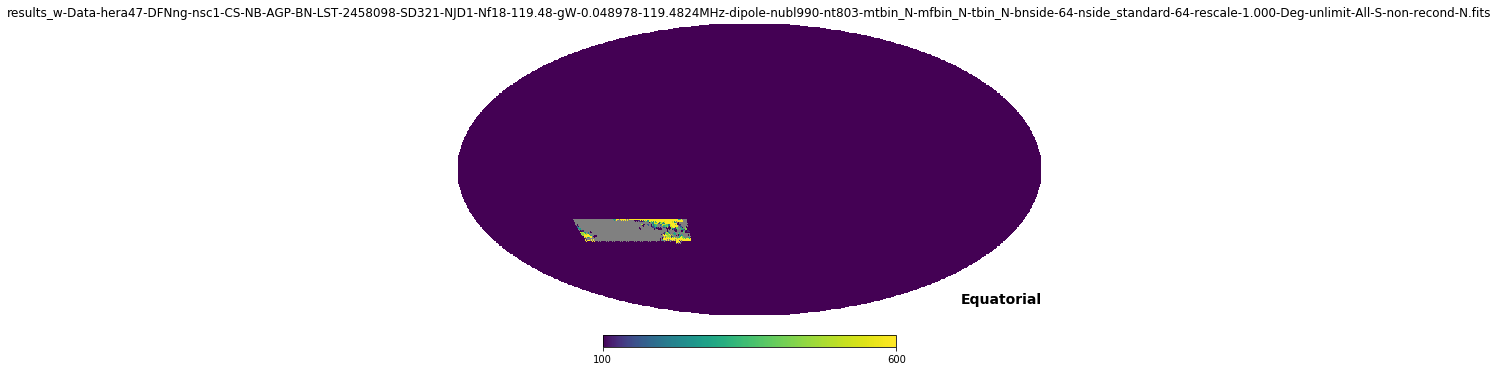

(2, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-130.42-gW-0.048978-130.4199MHz-dipole-nubl990-nt1031-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 535.006105208
>>>>>>>> Maximum in the Map: 5179.11505377


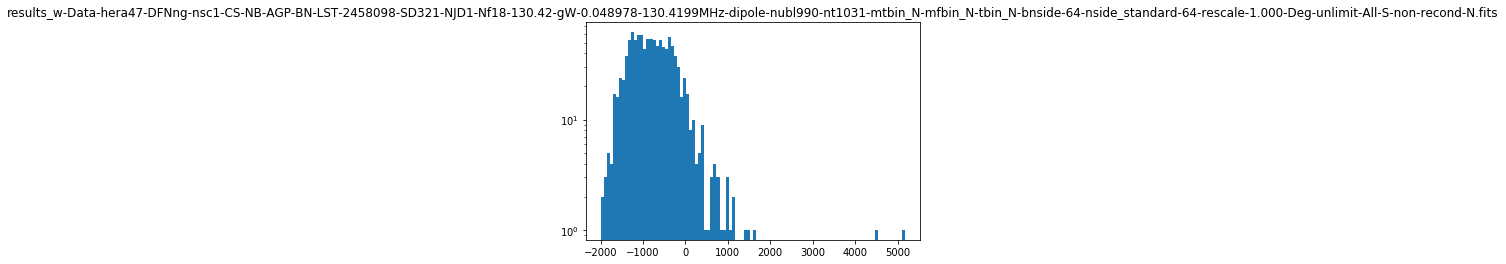

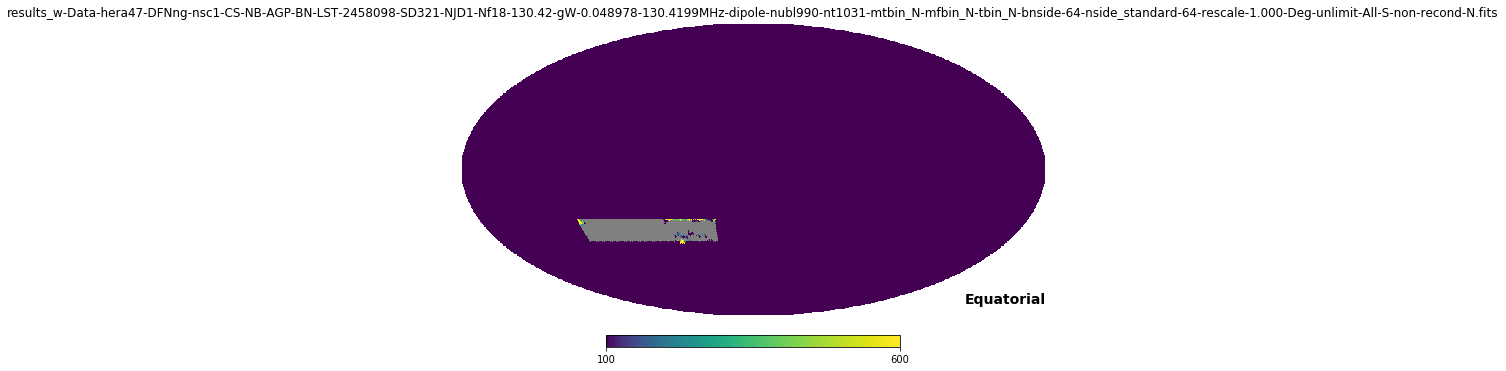

(3, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-139.79-gW-0.048978-139.7949MHz-dipole-nubl990-nt1038-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 529.253193513
>>>>>>>> Maximum in the Map: 3303.0294494


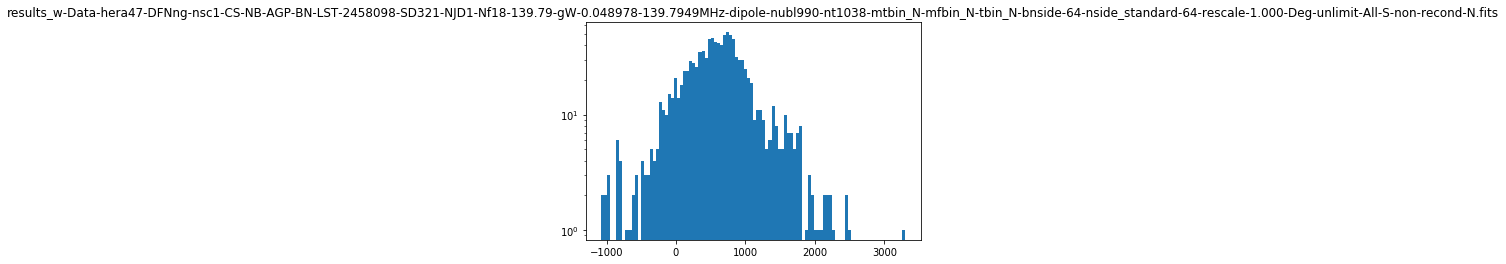

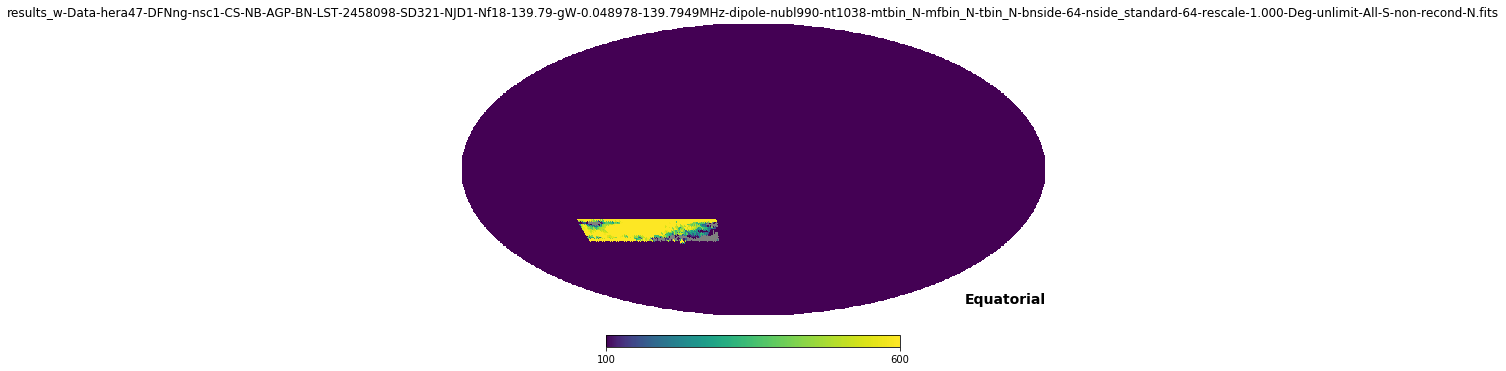

(4, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt1024-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 92.6915771522
>>>>>>>> Maximum in the Map: 1735.94372745


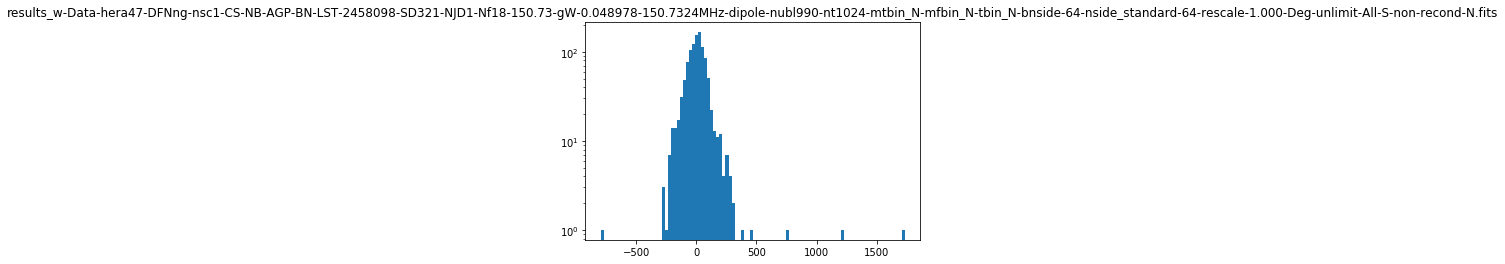

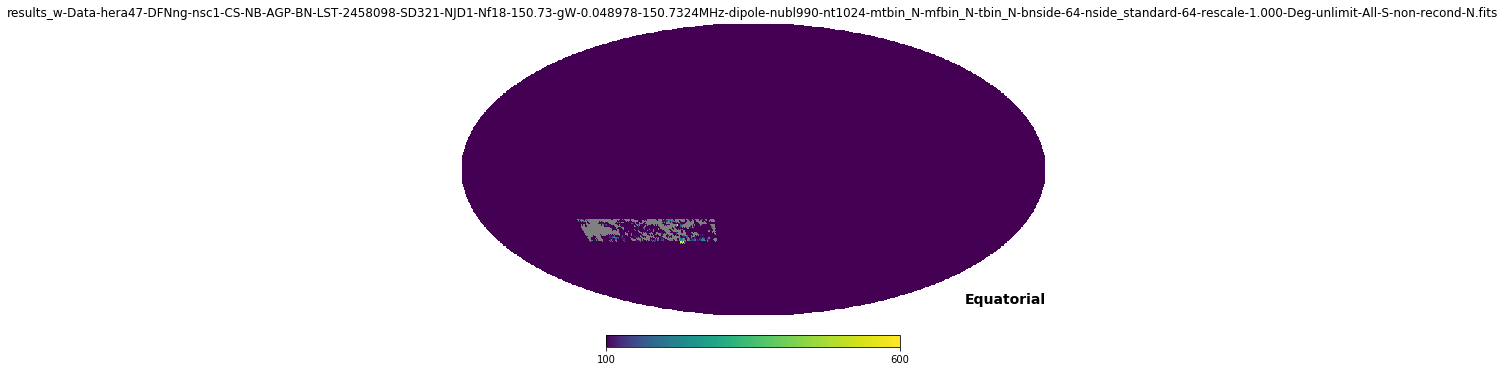

(5, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-160.11-gW-0.048978-160.1074MHz-dipole-nubl990-nt1041-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 98.3146879174
>>>>>>>> Maximum in the Map: 2840.66812587


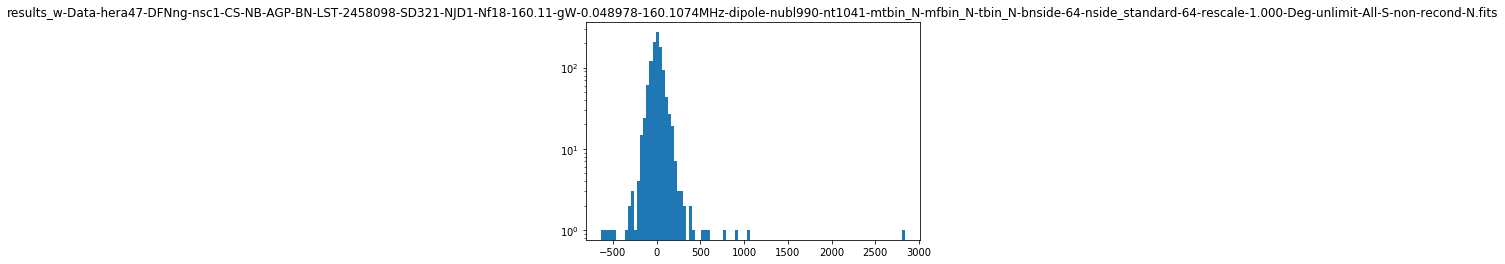

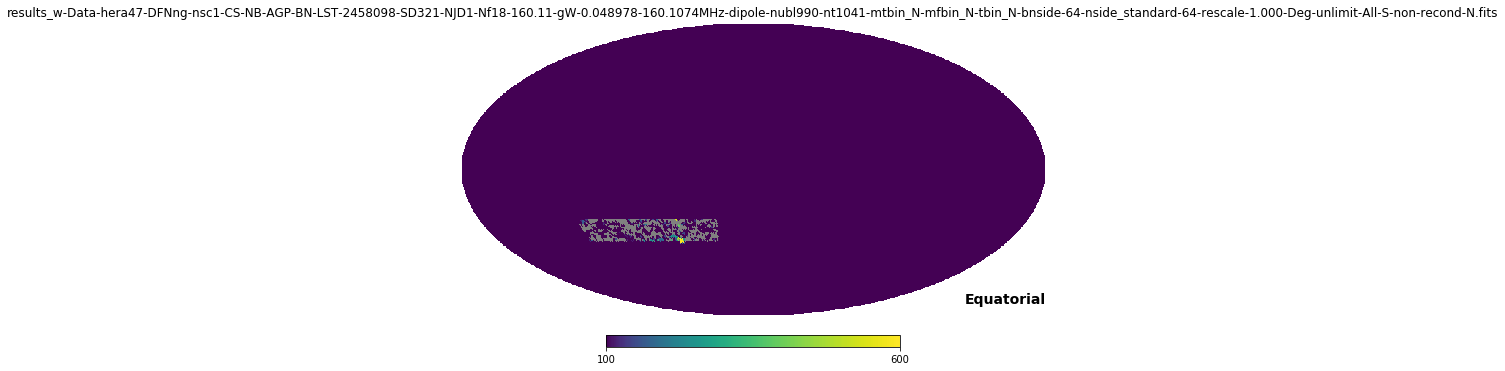

(6, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-169.48-gW-0.048978-169.4824MHz-dipole-nubl946-nt146-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 121.186143309
>>>>>>>> Maximum in the Map: 1207.48395797


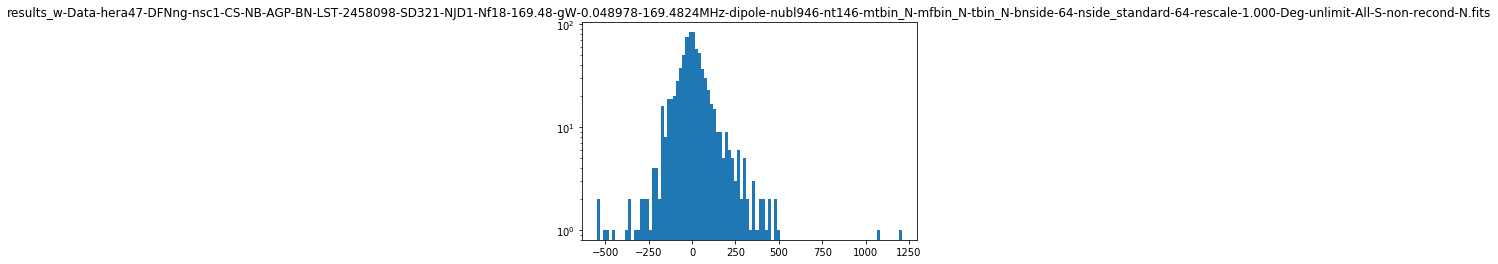

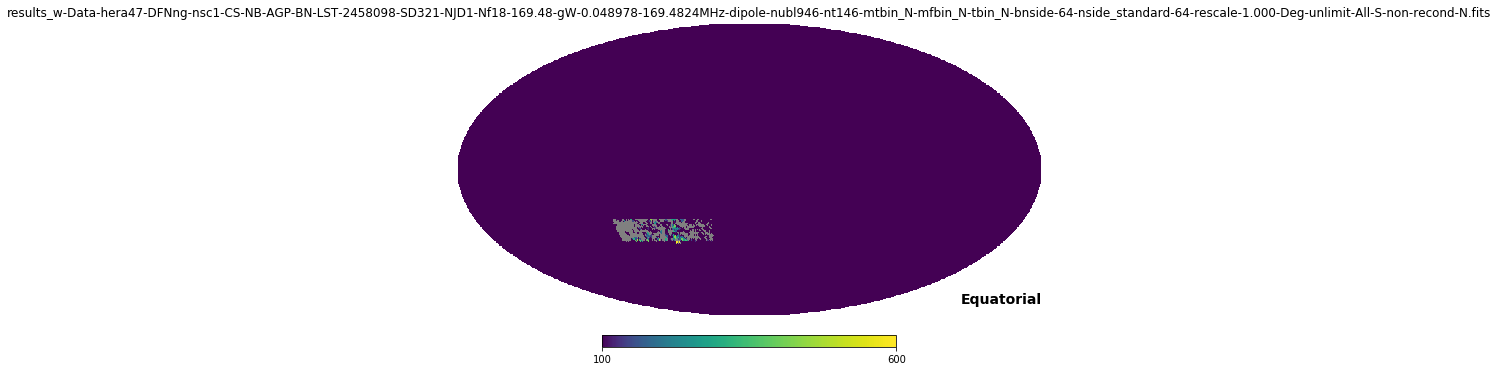

(7, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD321-NJD1-Nf18-178.86-gW-0.048978-178.8574MHz-dipole-nubl990-nt912-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 45.1398906424
>>>>>>>> Maximum in the Map: 926.302197522


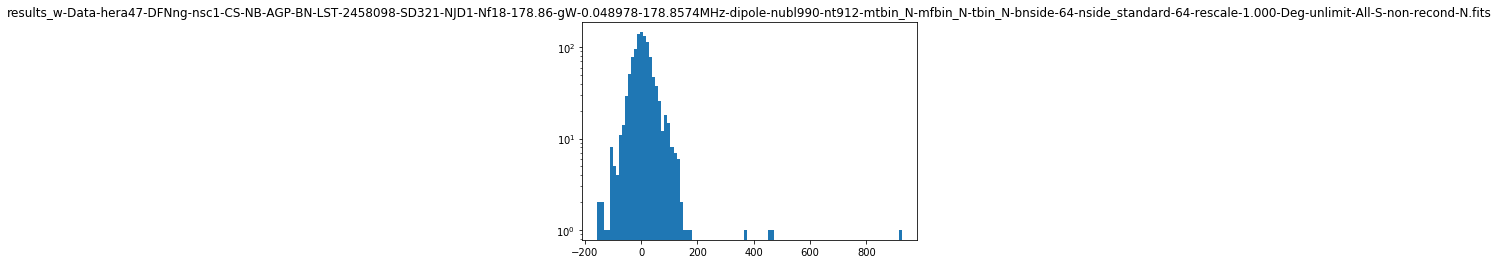

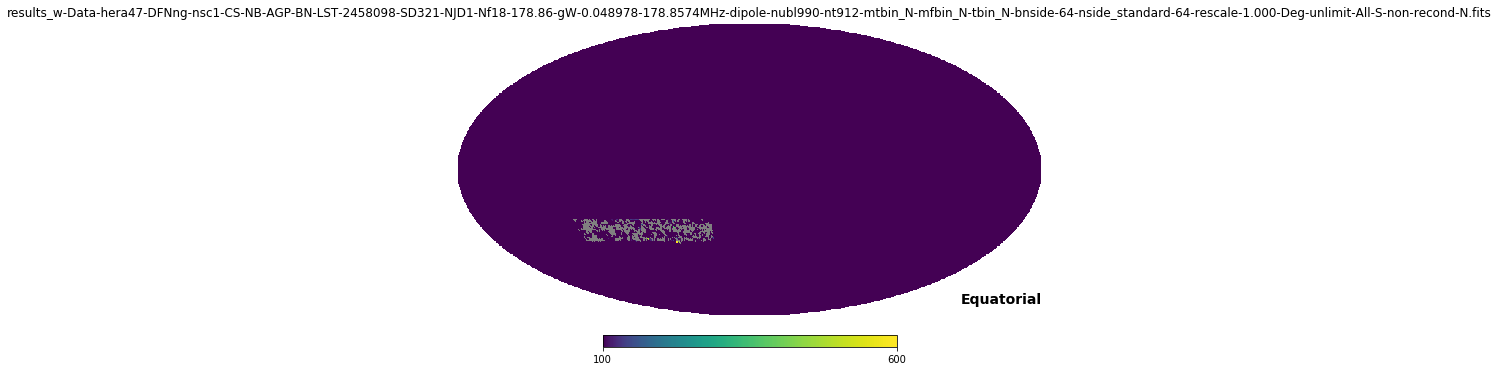

In [322]:
for id_file, fitfile in enumerate(filenames_64_321):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map64-part without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-2]][np.abs(map_fit[np.argsort(map_fit)[:-2]]) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    plt.figure(250000 + id_file)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.title(name)
    plt.show()
    #plt.close()
    plt.figure(650000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    #plt.close()

>>>>>>>> Number of Valid Pixels: 1110
>>>>>>>> Number of Valid Pixels: 906
>>>>>>>> Number of Valid Pixels: 1102
>>>>>>>> Number of Valid Pixels: 1110
>>>>>>>> Number of Valid Pixels: 1093
>>>>>>>> Number of Valid Pixels: 1110
>>>>>>>> Number of Valid Pixels: 780
>>>>>>>> Number of Valid Pixels: 1102
maps_mfreq_64_321 shape: (8, 49152)
maps_mfreq_common_64_321 shape: (8, 584)
Number of Common Valid Pixels-64_321: 584
EigenValues: 
[2.97763378e+04 1.77410313e+04 1.03088163e+04 9.25708174e+03
 3.31046350e+03 2.51584957e+03 1.67136782e+03 8.24585488e-12]

EigenValuesRatio: 
[6.27293455e-01 2.22682411e-01 7.51875257e-02 6.06284390e-02
 7.75364296e-03 4.47813860e-03 1.97638826e-03 4.81060352e-32]

EigenVectorsShape: (8, 584)

Maps64_Common_NewSpace shape: (8, 8)

Maps64_Common_NewSpace: [[ 2.49423016e+03 -3.36054347e+03  9.30082843e+03  1.12280493e+03
  -1.43571425e+02 -1.06358910e+01  6.45132460e+01  2.91534995e-12]
 [-8.42400696e+03  1.51160467e+04  1.02716860e+03 -2.24184674e+03
   3.511

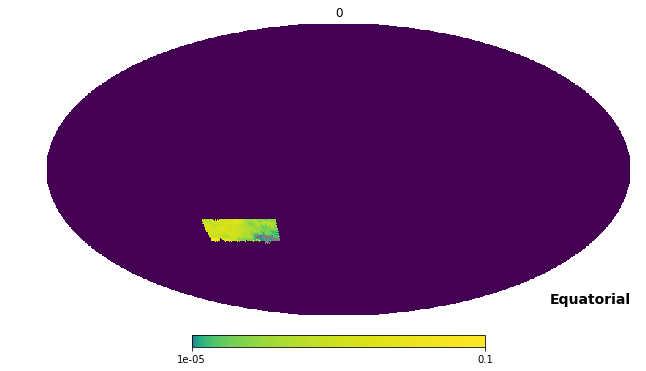

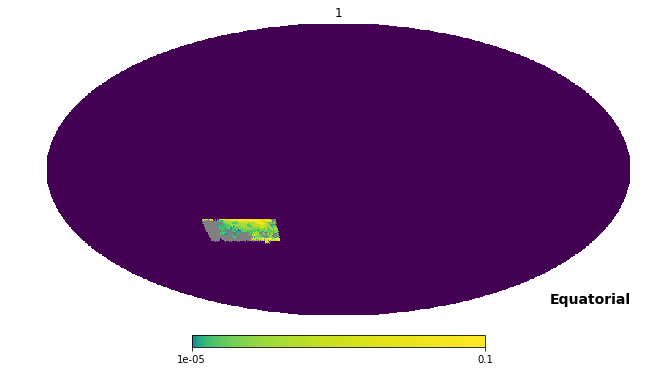

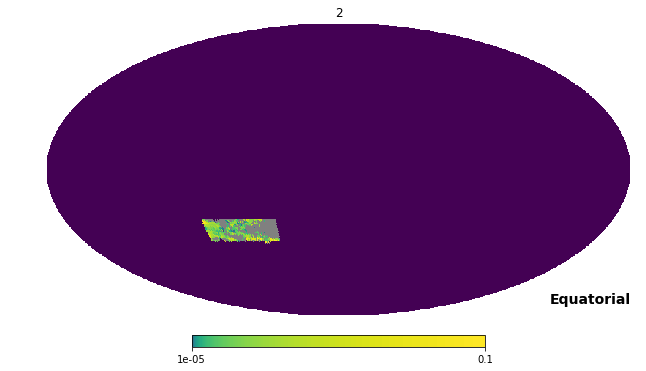

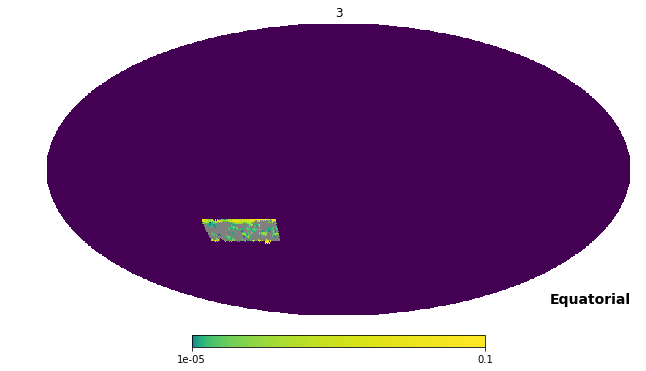

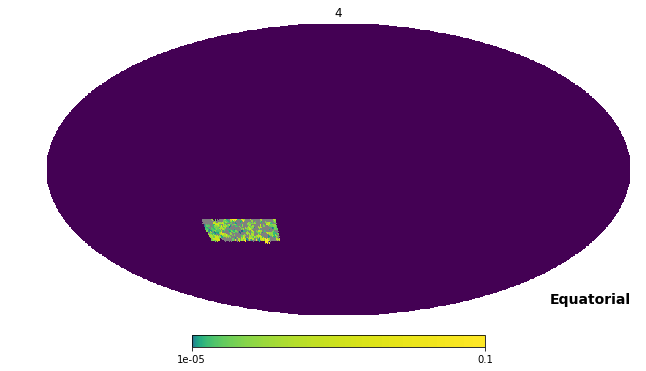

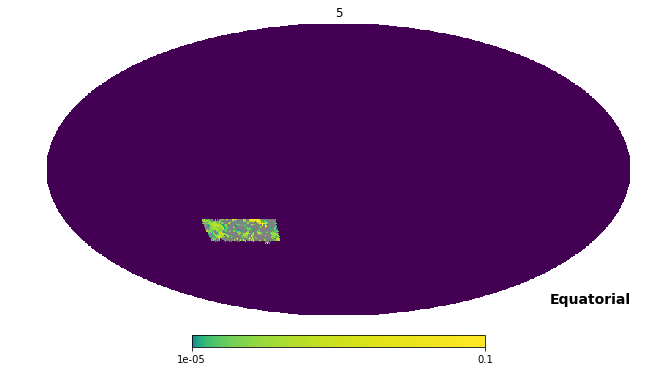

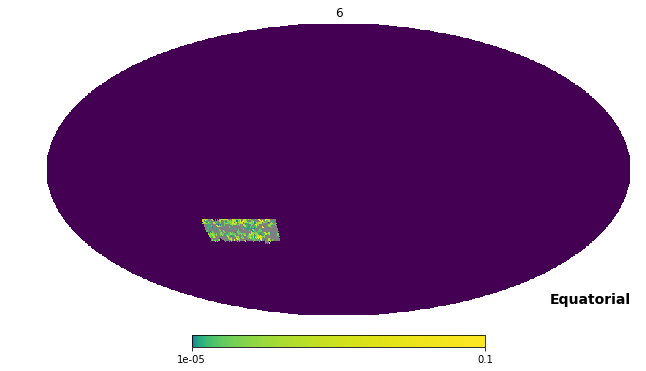

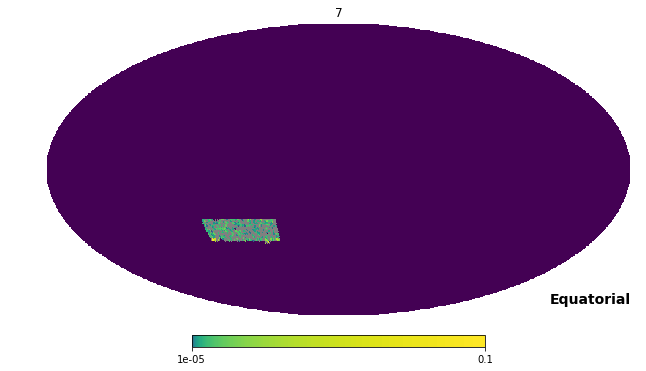

In [323]:
maps_mfreq_64_321 = []
for id_file, fitfile in enumerate(filenames_64_321):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 750.:
        maps_mfreq_64_321.append(map_fit)
        
maps_mfreq_64_321 = np.array(maps_mfreq_64_321)
commom_vp_mask_64_321 = np.prod(np.abs(maps_mfreq_64_321) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_64_321 = maps_mfreq_64_321[:, commom_vp_mask_64_321]
print('maps_mfreq_64_321 shape: {}'.format(maps_mfreq_64_321.shape))
print('maps_mfreq_common_64_321 shape: {}'.format(maps_mfreq_common_64_321.shape))
print('Number of Common Valid Pixels-64_321: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_64_321) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_64_321)
maps_mfreq_common_64_321_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_64_321_eigValues = pca.singular_values_
maps_mfreq_common_64_321_eigVectors = pca.components_
maps_mfreq_common_64_321_newspace = pca.fit_transform(maps_mfreq_common_64_321)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_64_321_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_64_321_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_64_321_eigVectors.shape))
print('Maps64_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_64_321_newspace.shape))
print('Maps64_Common_NewSpace: {}'.format(maps_mfreq_common_64_321_newspace))

id_freq = 0
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64_321[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_64_321_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64_321_newspace[id_freq].dot(maps_mfreq_common_64_321_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_64_321[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_64_321_newspace[id_freq].dot(maps_mfreq_common_64_321_eigVectors))[-number_to_show:])

maps_mfreq_common_64_321_eigVectors_full = np.ones_like(maps_mfreq_64_321) * 10**(-5)
maps_mfreq_common_64_321_eigVectors_full[:, commom_vp_mask_64_321] = maps_mfreq_common_64_321_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_64_321_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-5), max=10.**(-1), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()


In [324]:
nside_standard = 64
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_part_64 = fits.getdata(filenames_64_321[4]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_part_64)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_part_64)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_part_64[np.argsort(ww_solution_part_64)[-80:]]))




Bright_Pixels_Data: [[-34.22886633 -35.68533471 -30.69158768 -35.68533471 -34.95386526
  -27.27961274 -32.08995126 -27.27961274 -32.7971683  -35.68533471
  -34.22886633 -34.95386526 -34.22886633 -27.95318688 -28.63098984
  -26.61009781 -35.68533471 -34.95386526 -28.63098984 -27.27961274
  -27.95318688 -34.22886633 -30.         -35.68533471 -25.94447977
  -28.63098984 -34.22886633 -25.94447977 -26.61009781 -34.22886633
  -33.51005607 -33.51005607 -36.42357364 -27.95318688 -25.94447977
  -27.27961274 -29.31319896 -34.22886633 -34.95386526 -27.27961274
  -32.7971683  -34.22886633 -25.28260304 -35.68533471 -29.31319896
  -36.42357364 -35.68533471 -33.51005607 -35.68533471 -32.7971683
  -35.68533471 -29.31319896 -35.68533471 -34.22886633 -34.22886633
  -27.95318688 -34.95386526 -28.63098984 -34.95386526 -25.94447977
  -34.95386526 -36.42357364 -34.95386526 -36.42357364 -25.28260304
  -34.95386526 -25.28260304 -34.95386526 -35.68533471 -27.95318688
  -27.95318688 -36.42357364 -36.42357364 -3

(0, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-110.11-gW-0.048978-110.1074MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 48.3393048953
>>>>>>>> Maximum in the Map: 2528.58789102


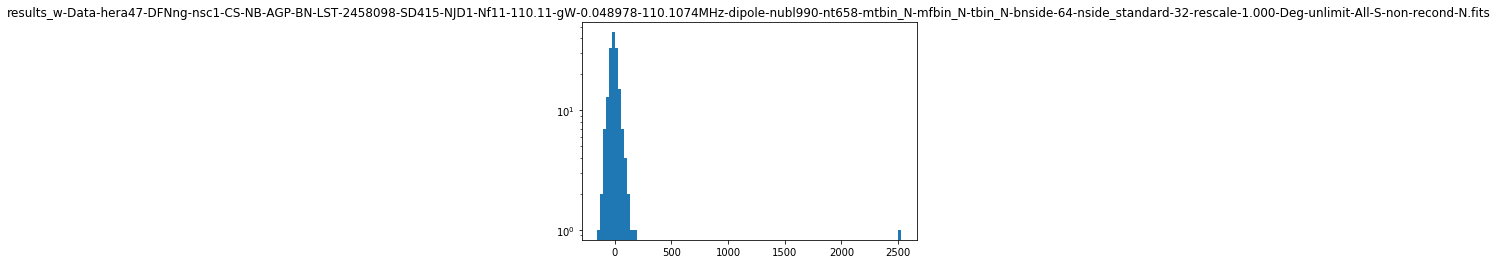

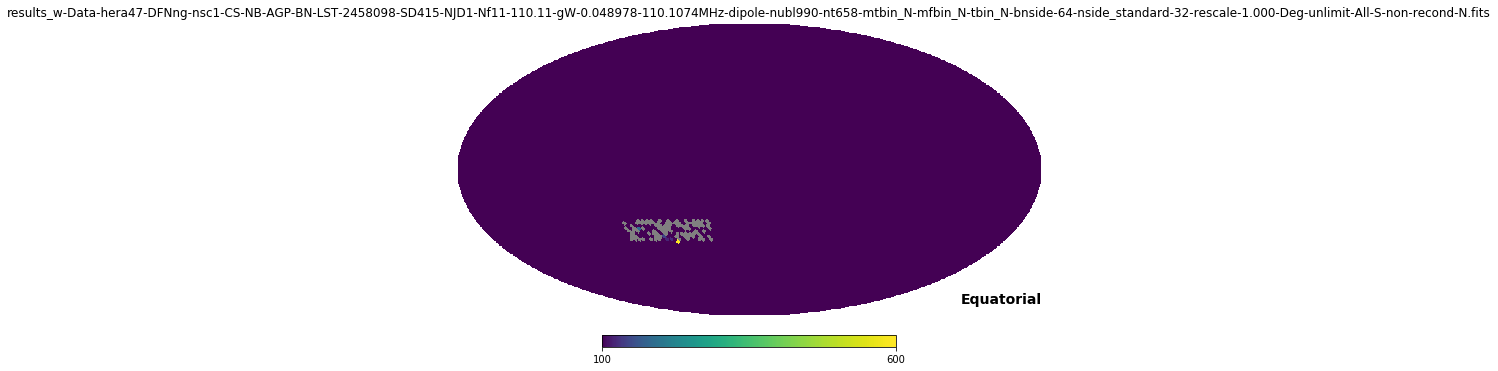

(1, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-114.79-gW-0.048978-114.7949MHz-dipole-nubl990-nt653-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 49.5559955969
>>>>>>>> Maximum in the Map: 3094.13164375


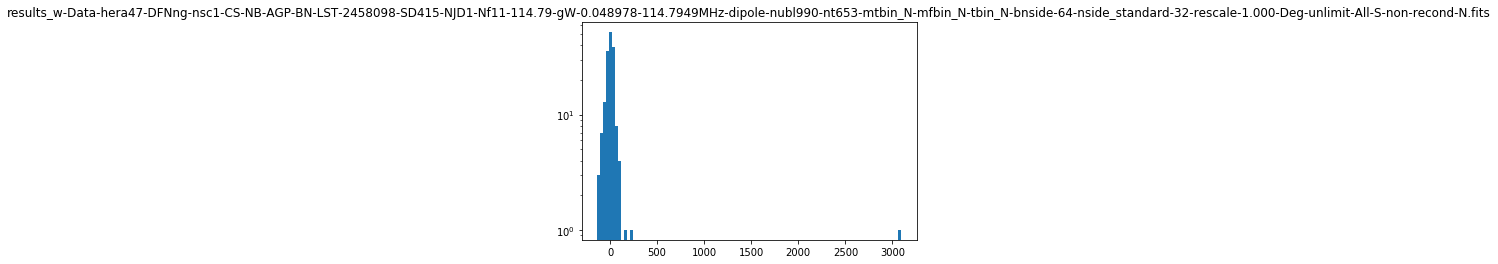

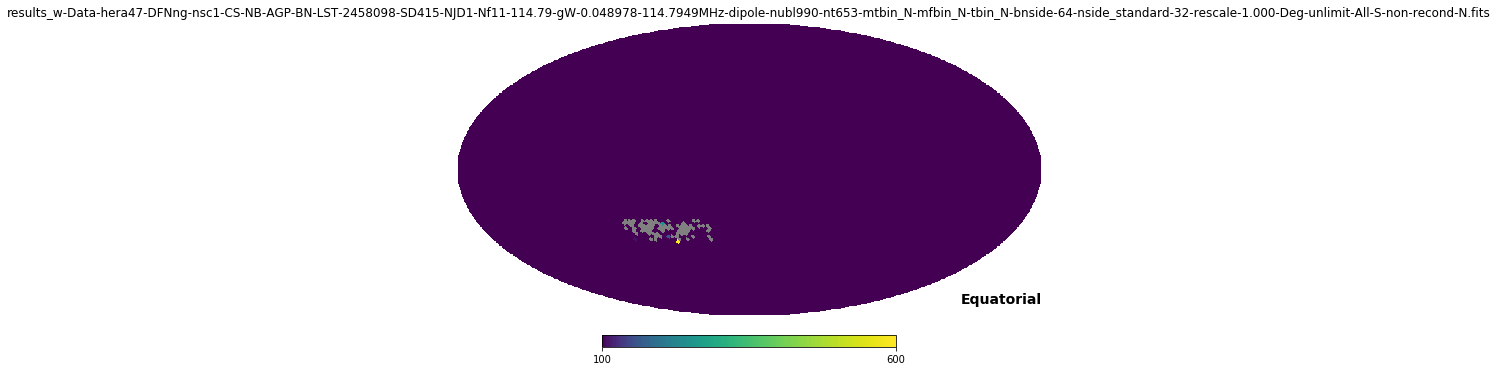

(2, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-119.48-gW-0.048978-119.4824MHz-dipole-nubl990-nt443-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 76.0483798289
>>>>>>>> Maximum in the Map: 2851.7975015


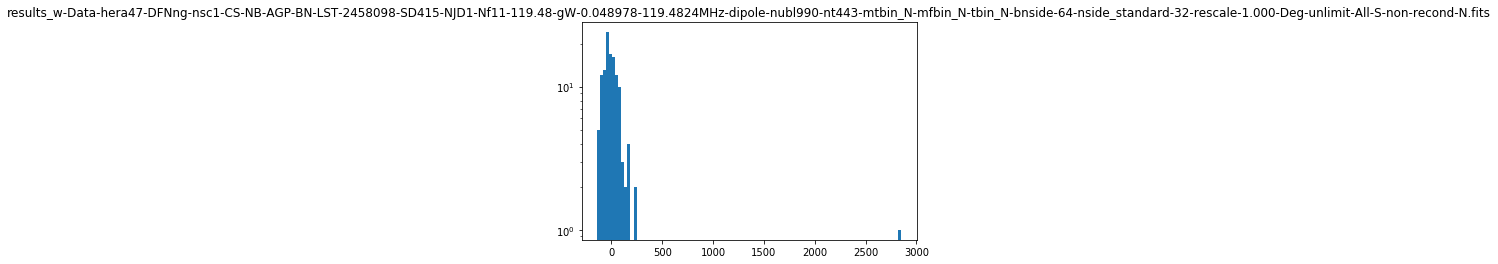

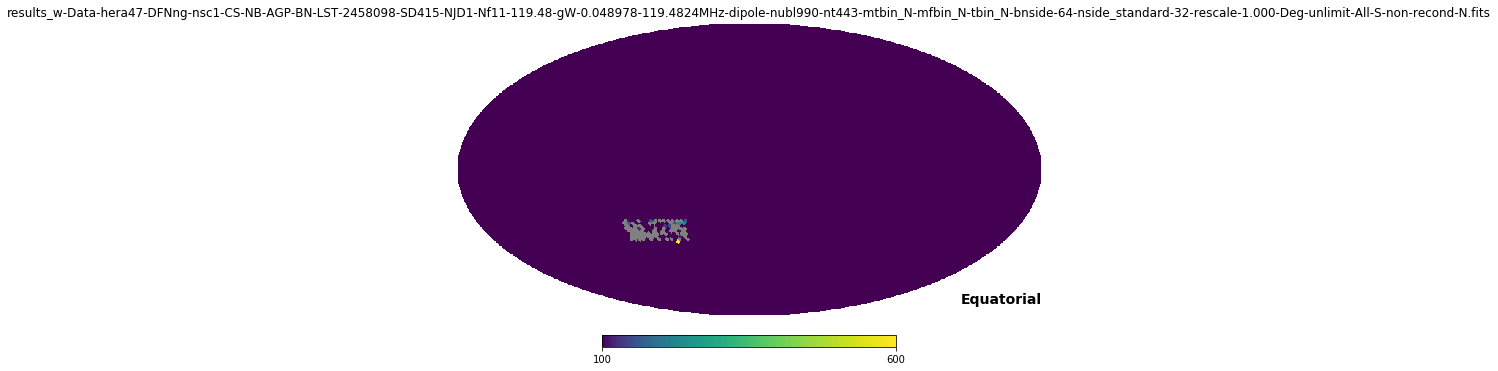

(3, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-125.73-gW-0.048978-125.7324MHz-dipole-nubl990-nt276-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 65.5852291657
>>>>>>>> Maximum in the Map: 1759.18827373


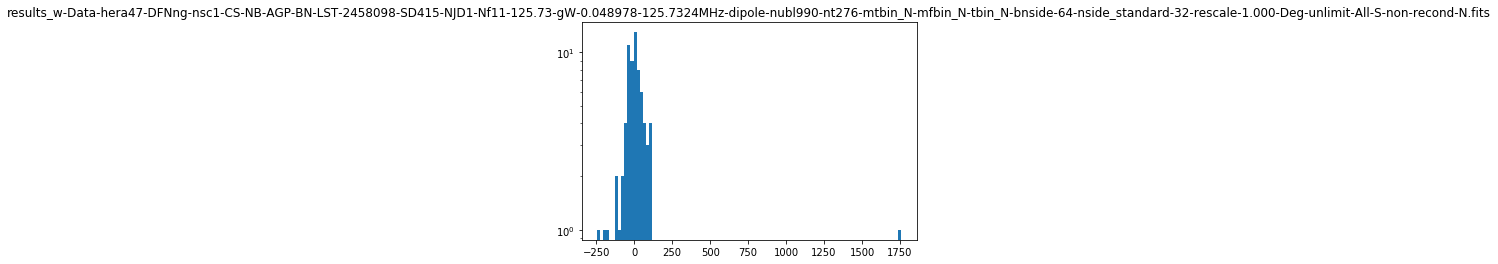

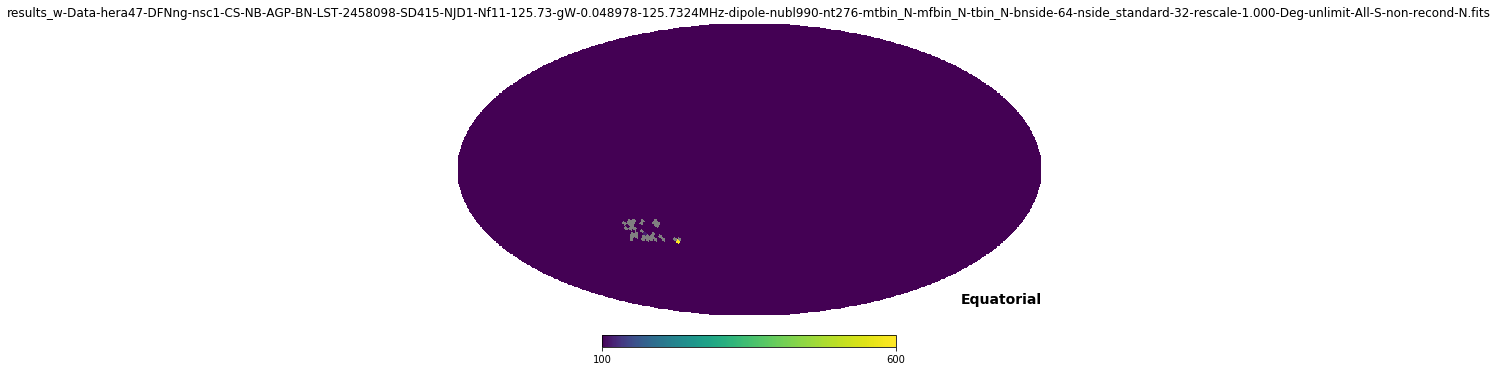

(4, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-130.42-gW-0.048978-130.4199MHz-dipole-nubl990-nt654-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 33.4511787179
>>>>>>>> Maximum in the Map: 1525.51110952


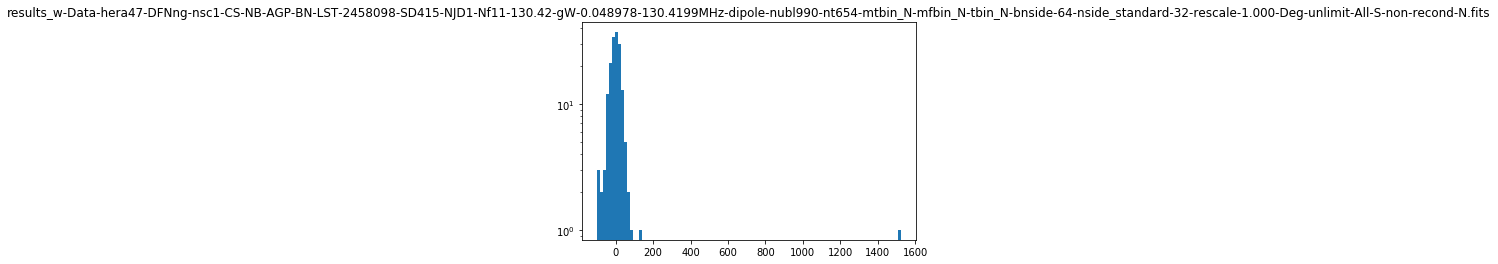

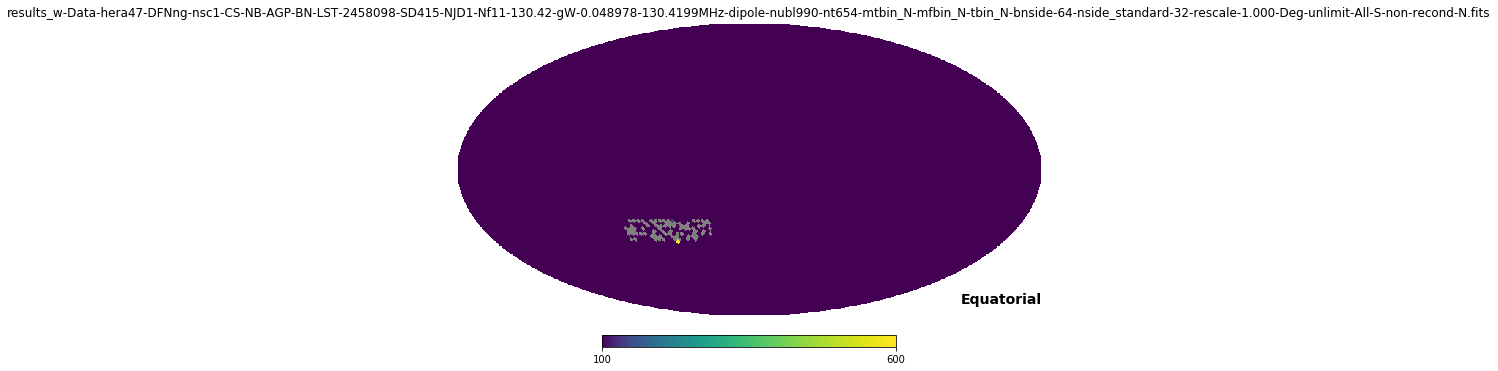

(5, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-135.11-gW-0.048978-135.1074MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 28.1619148242
>>>>>>>> Maximum in the Map: 1542.19737602


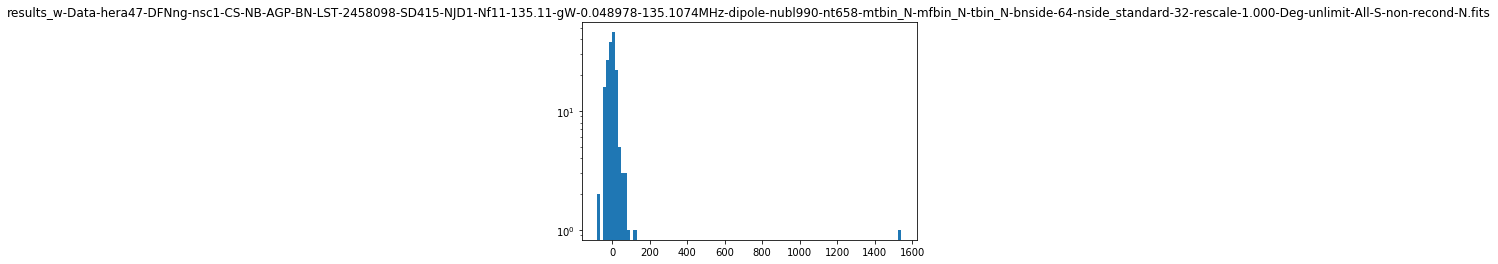

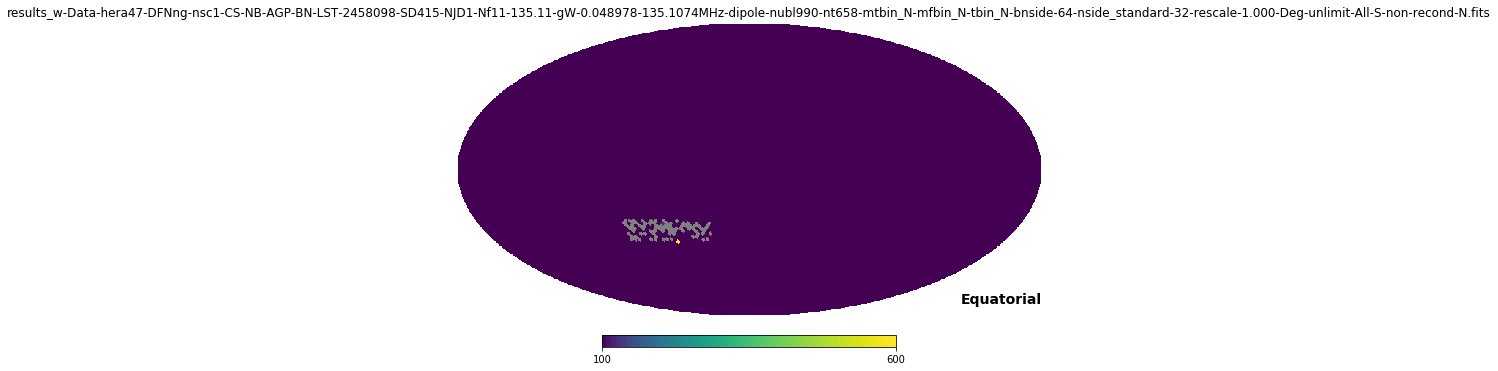

(6, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-139.79-gW-0.048978-139.7949MHz-dipole-nubl990-nt655-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 28.4808563458
>>>>>>>> Maximum in the Map: 1556.95701739


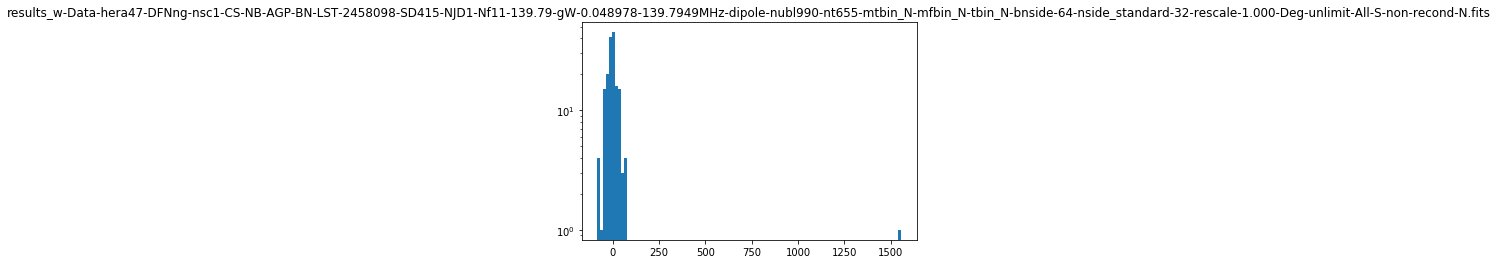

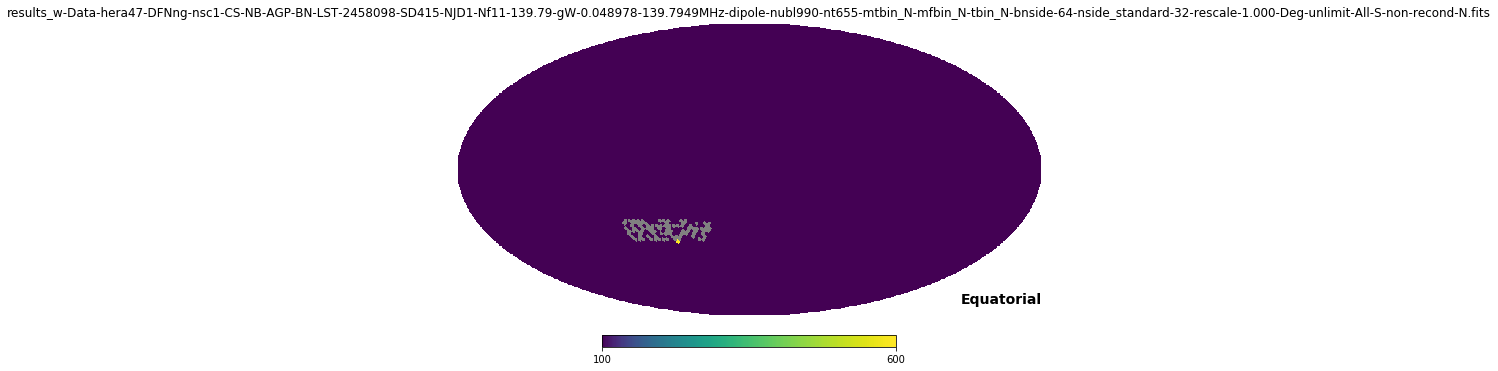

(7, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-144.48-gW-0.048978-144.4824MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 27.8535358016
>>>>>>>> Maximum in the Map: 1292.66476948


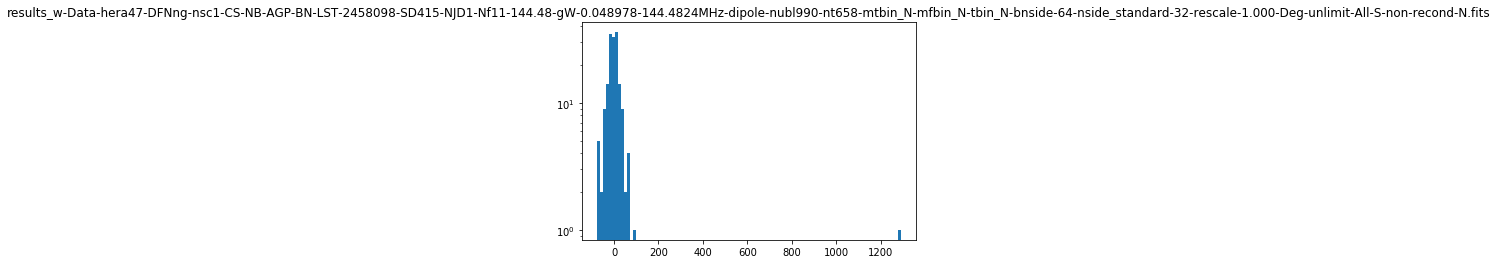

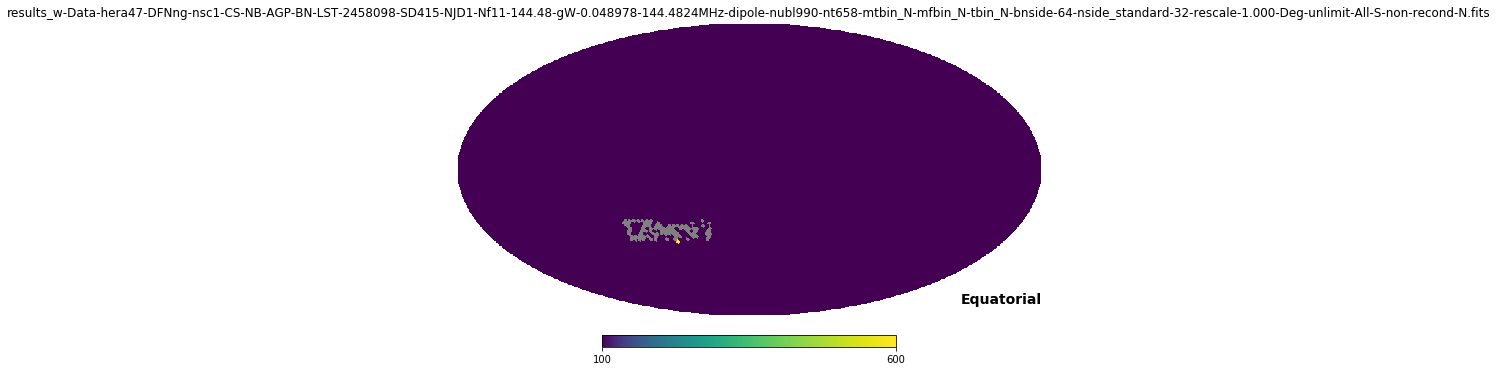

(8, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt656-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 23.651553151
>>>>>>>> Maximum in the Map: 1048.73082121


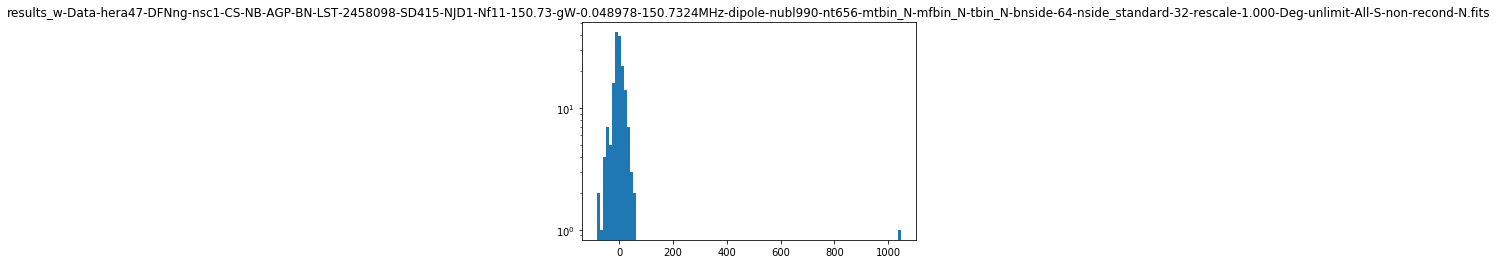

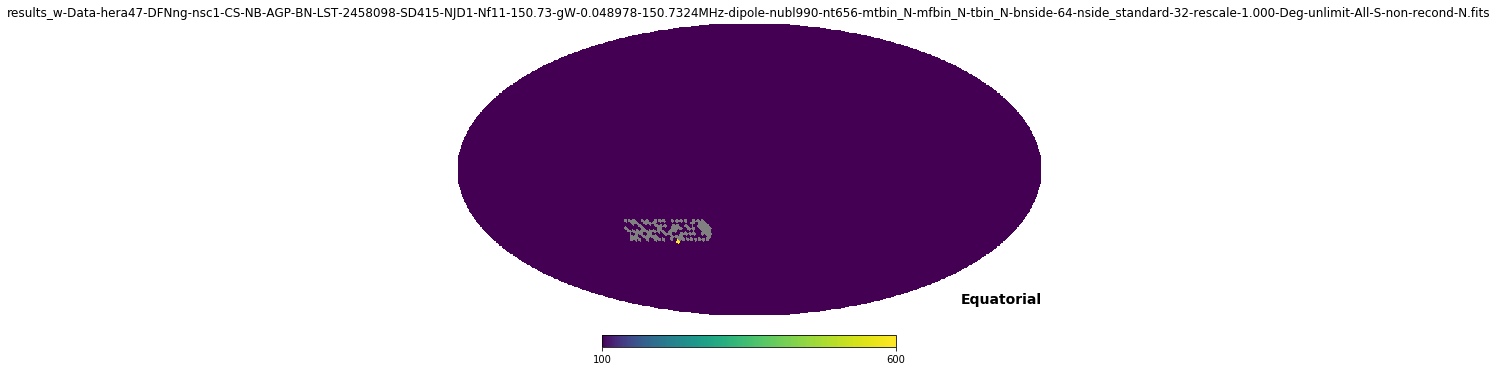

(9, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-155.42-gW-0.048978-155.4199MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 26.4695333692
>>>>>>>> Maximum in the Map: 1166.27362976


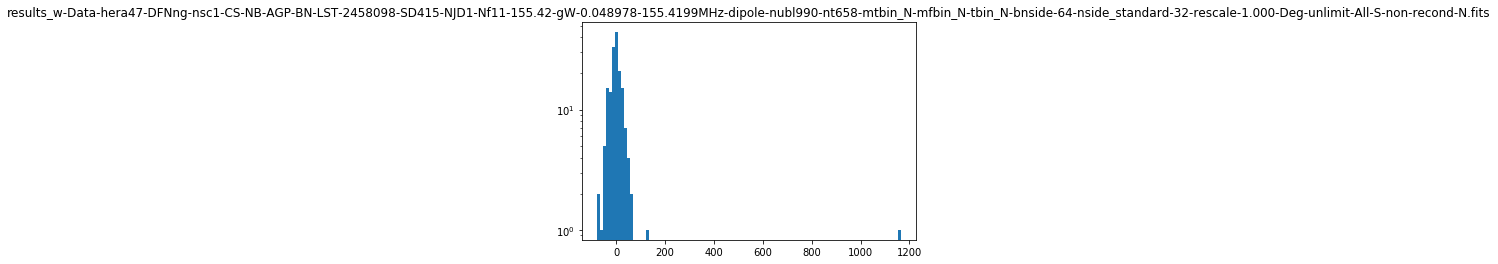

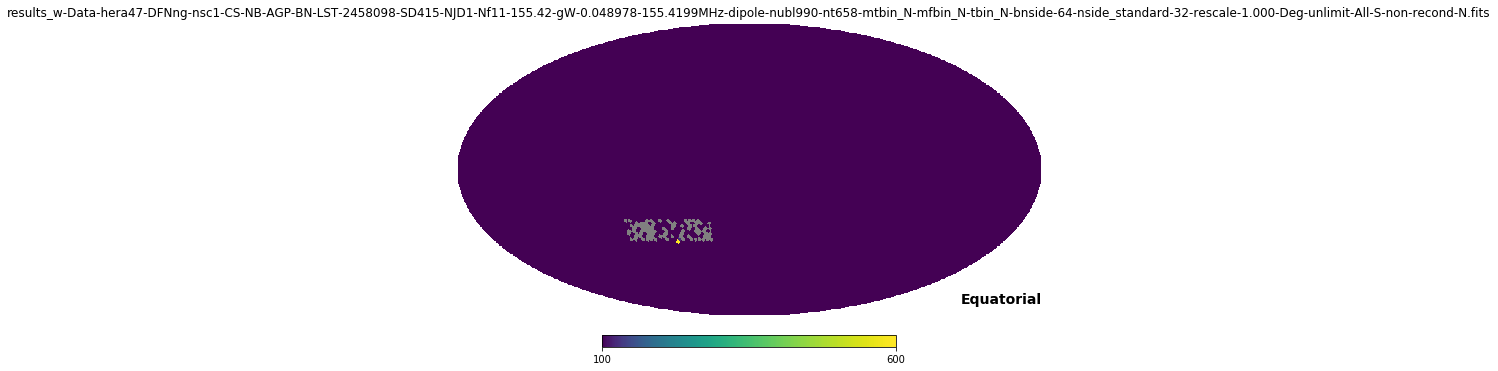

(10, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-160.11-gW-0.048978-160.1074MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 28.8756695215
>>>>>>>> Maximum in the Map: 926.227547498


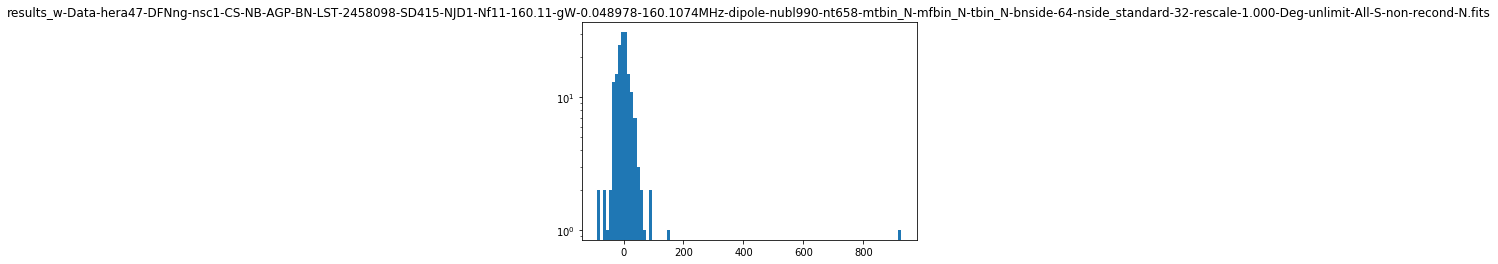

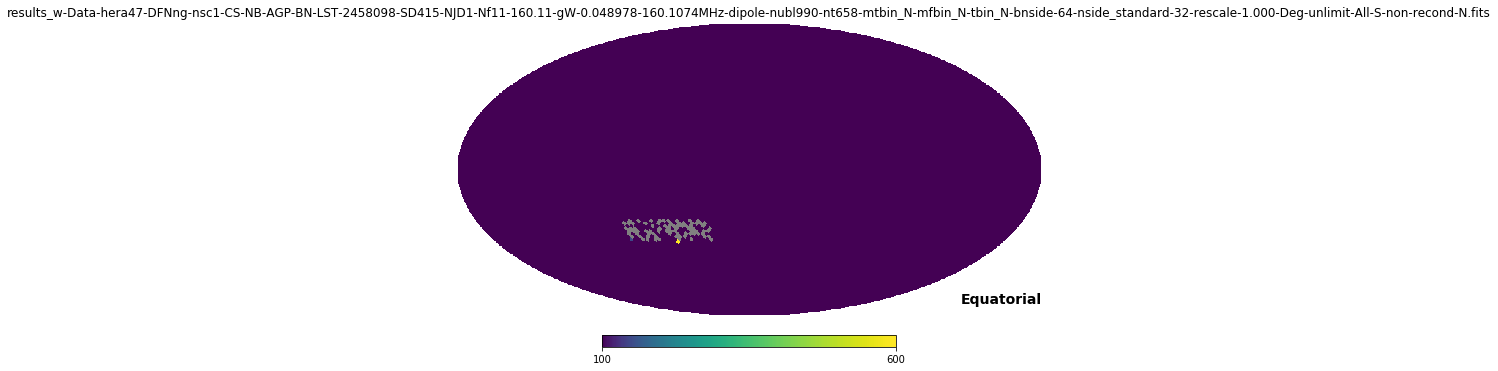

(11, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-164.79-gW-0.048978-164.7949MHz-dipole-nubl990-nt657-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 29.7487332526
>>>>>>>> Maximum in the Map: 716.324341781


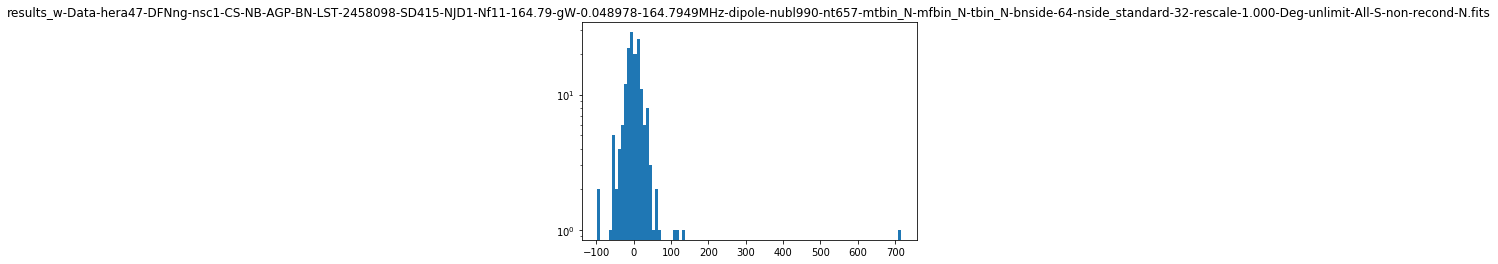

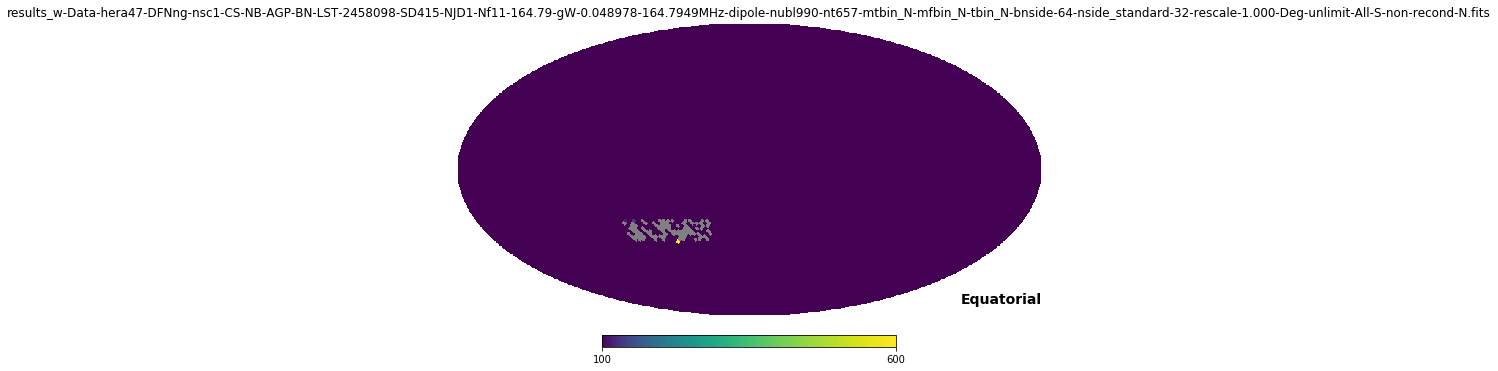

(12, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-169.48-gW-0.048978-169.4824MHz-dipole-nubl990-nt98-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 23.8140061239
>>>>>>>> Maximum in the Map: 506.888427302


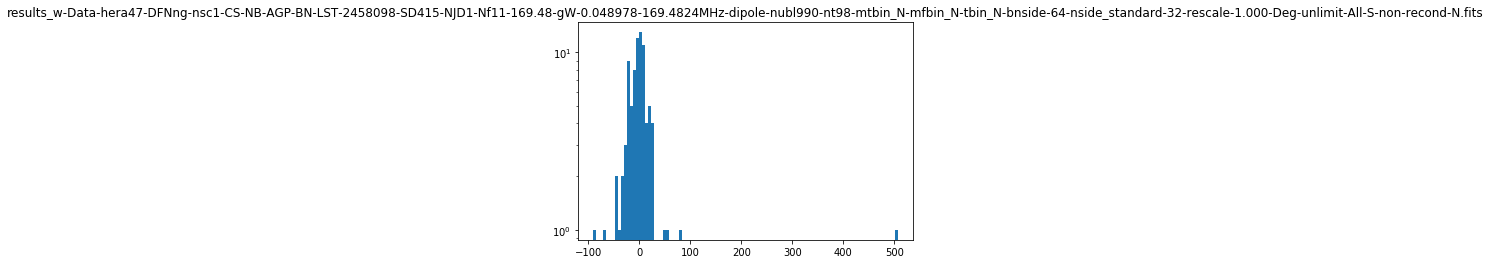

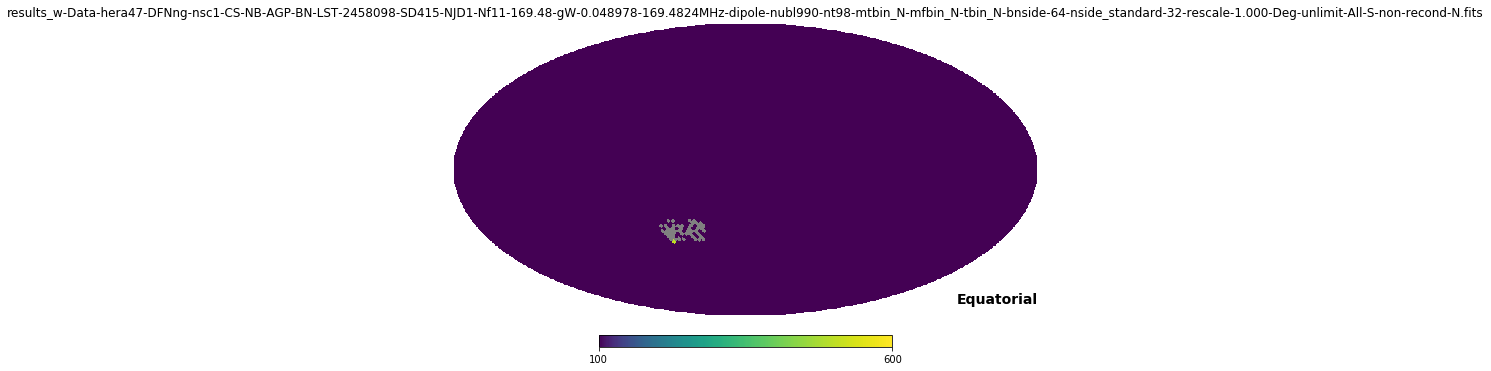

(13, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-174.17-gW-0.048978-174.1699MHz-dipole-nubl990-nt501-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 17.8342329286
>>>>>>>> Maximum in the Map: 608.645498113


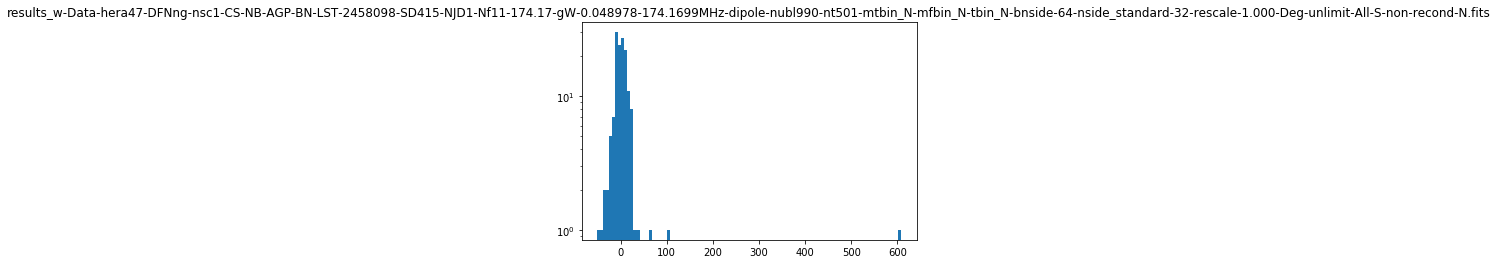

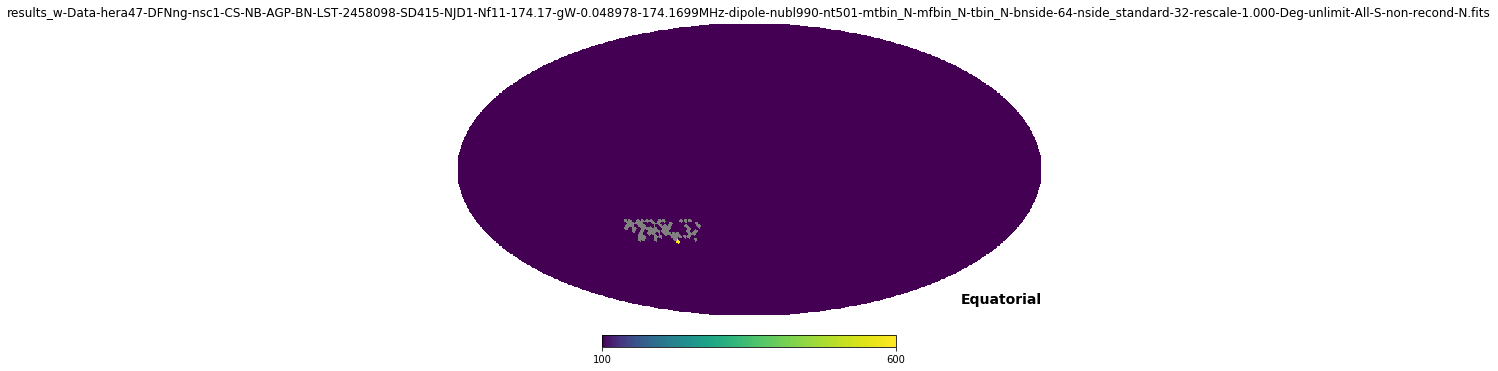

(14, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-178.86-gW-0.048978-178.8574MHz-dipole-nubl990-nt541-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-32-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map32-part without Fornax A: 19.0724737843
>>>>>>>> Maximum in the Map: 546.690843645


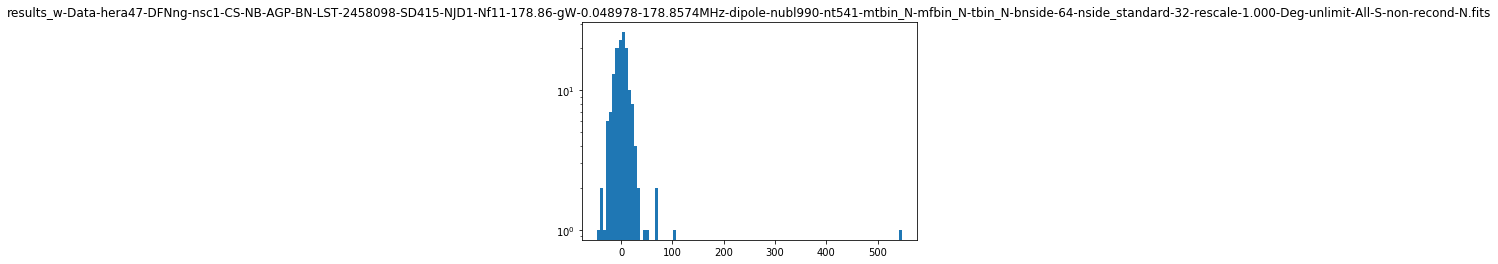

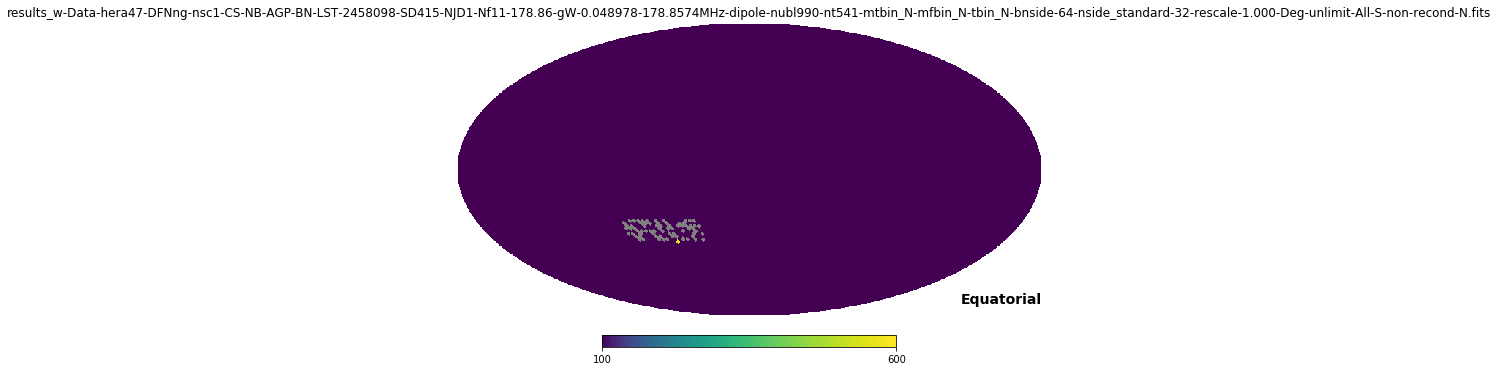

In [325]:
for id_file, fitfile in enumerate(filenames_32_415):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map32-part without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-1]][np.abs(map_fit[np.argsort(map_fit)[:-1]]) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    plt.figure(35000 + id_file)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.title(name)
    plt.show()
    #plt.close()
    plt.figure(75000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    #plt.close()

>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 121
>>>>>>>> Number of Valid Pixels: 71
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 165
>>>>>>>> Number of Valid Pixels: 85
>>>>>>>> Number of Valid Pixels: 145
>>>>>>>> Number of Valid Pixels: 149
maps_mfreq_32_415 shape: (13, 12288)
maps_mfreq_common_32_415 shape: (13, 121)
Number of Common Valid Pixels-32_415: 121
EigenValues: 
[2.96053018e+03 7.81182336e+02 5.27922617e+02 4.23744751e+02
 3.81743112e+02 3.56011950e+02 3.08458939e+02 2.97650649e+02
 2.73608258e+02 2.35115157e+02 2.32913853e+02 1.61338204e+02
 2.44966061e-13]

EigenValuesRatio: 
[8.34746477e-01 5.81193084e-02 2.65433752e-02 1.71011088e-02
 1.38789953e-02 1.20710420e-02 

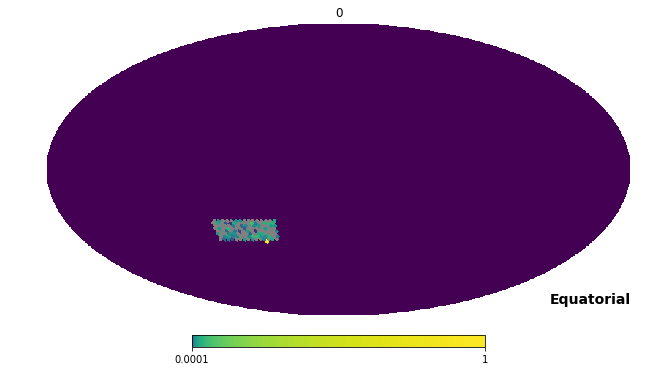

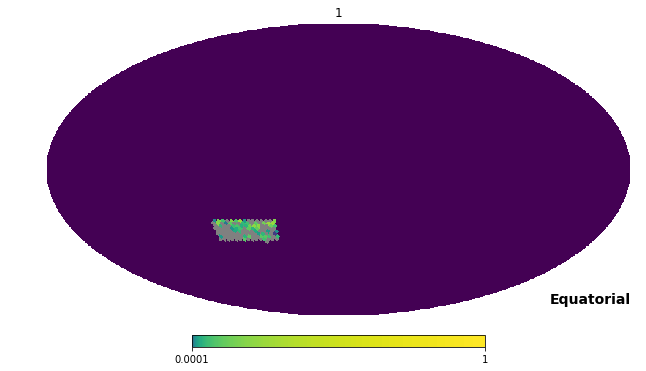

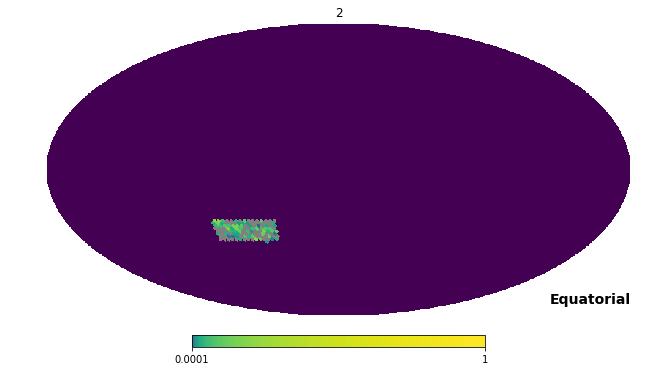

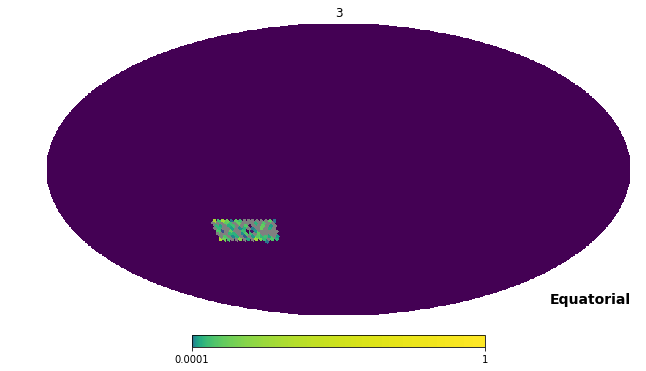

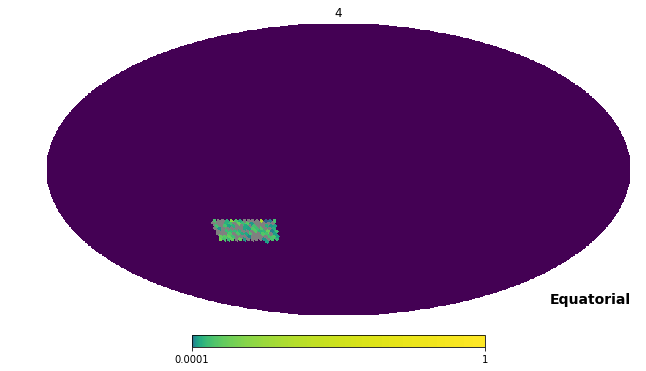

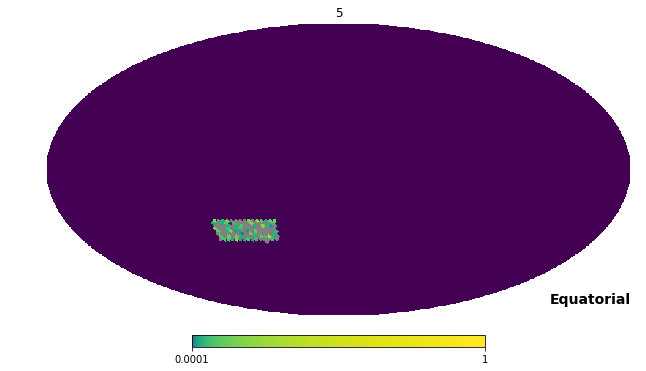

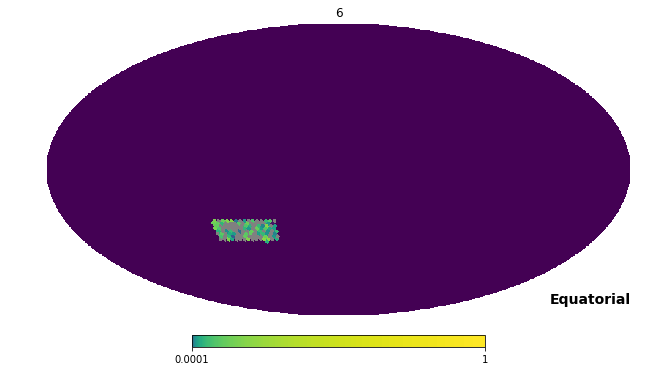

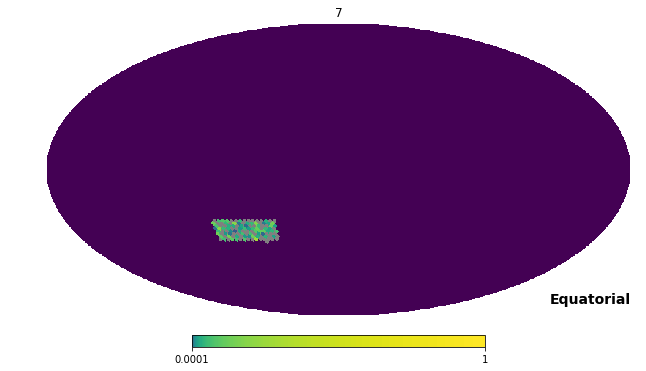

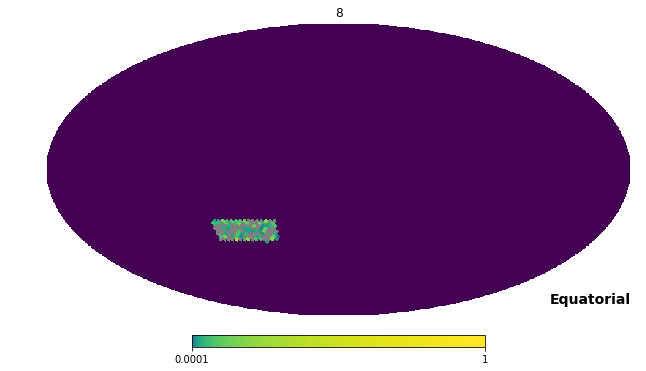

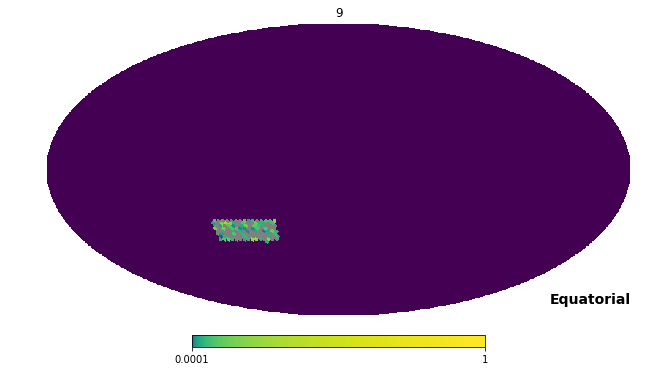

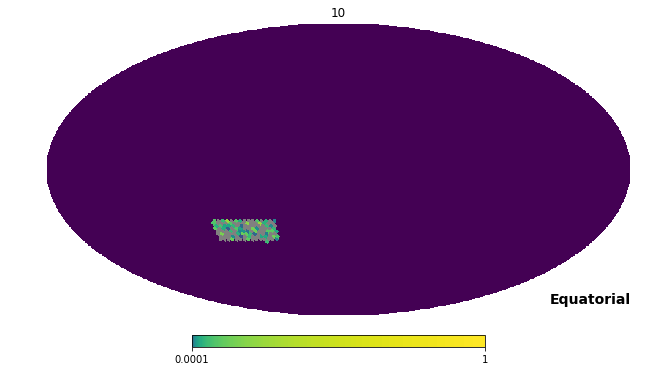

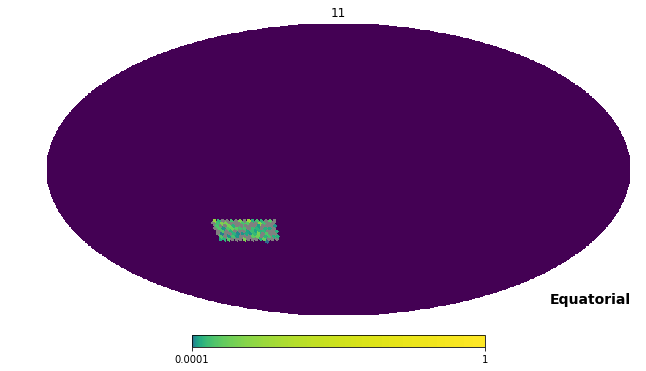

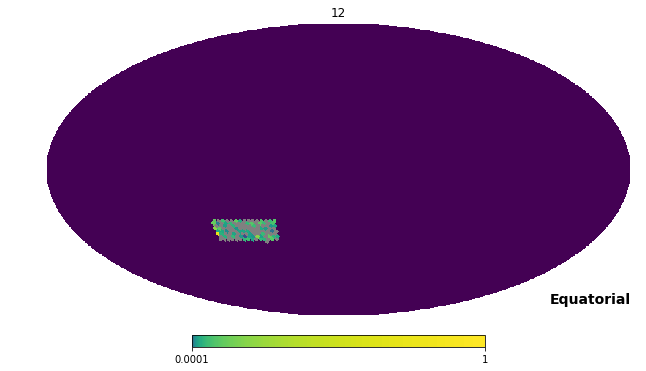

In [326]:
maps_mfreq_32_415 = []
for id_file, fitfile in enumerate(filenames_32_415):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 100.:
        maps_mfreq_32_415.append(map_fit)
        
maps_mfreq_32_415 = np.array(maps_mfreq_32_415)
commom_vp_mask_32_415 = np.prod(np.abs(maps_mfreq_32_415) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_32_415 = maps_mfreq_32_415[:, commom_vp_mask_32_415]
print('maps_mfreq_32_415 shape: {}'.format(maps_mfreq_32_415.shape))
print('maps_mfreq_common_32_415 shape: {}'.format(maps_mfreq_common_32_415.shape))
print('Number of Common Valid Pixels-32_415: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_32_415) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_32_415)
maps_mfreq_common_32_415_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_32_415_eigValues = pca.singular_values_
maps_mfreq_common_32_415_eigVectors = pca.components_
maps_mfreq_common_32_415_newspace = pca.fit_transform(maps_mfreq_common_32_415)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_32_415_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_32_415_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_32_415_eigVectors.shape))
print('Maps32_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_32_415_newspace.shape))
print('Maps32_Common_NewSpace: {}'.format(maps_mfreq_common_32_415_newspace))

id_freq = 8
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32_415[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_32_415_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_32_415_newspace[id_freq].dot(maps_mfreq_common_32_415_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_32_415[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_32_415_newspace[id_freq].dot(maps_mfreq_common_32_415_eigVectors))[-number_to_show:])

maps_mfreq_common_32_415_eigVectors_full = np.ones_like(maps_mfreq_32_415) * 10**(-5)
maps_mfreq_common_32_415_eigVectors_full[:, commom_vp_mask_32_415] = maps_mfreq_common_32_415_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_32_415_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-4), max=10.**(-0), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()


In [327]:
nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_part415_32 = fits.getdata(filenames_32_415[3]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_part415_32)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_part415_32)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_part415_32[np.argsort(ww_solution_part415_32)[-40:]]))




Bright_Pixels_Data: [[-28.63098984 -27.27961274 -27.27961274 -25.94447977 -25.94447977
  -24.62431835 -24.62431835 -23.31795707 -25.94447977 -24.62431835
  -24.62431835 -23.31795707 -23.31795707 -22.02431284 -22.02431284
  -20.74237995 -28.63098984 -27.27961274  72.38756093  -1.19374844
   84.14973294  73.86549609  73.86549609  78.28414761  72.38756093
   78.28414761  85.61313404  75.34073424  76.81353334  67.93492865
   76.81353334  79.75282793  69.42254649  78.28414761  69.42254649
   78.28414761  70.90666664  76.81353334  73.86549609  70.90666664
   72.38756093  72.38756093  73.86549609  73.86549609  72.38756093
   70.90666664  75.34073424  76.81353334  73.86549609  75.34073424
   75.34073424  76.81353334  75.34073424  79.75282793  75.34073424
   76.81353334  78.28414761  78.28414761  79.75282793  76.81353334
   78.28414761  78.28414761  79.75282793  79.75282793  81.21982232
   81.21982232  82.68537621  79.75282793  81.21982232  81.21982232
   82.68537621  82.68537621  84.14973294  

(0, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-110.11-gW-0.048978-110.1074MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 511.345114584
>>>>>>>> Maximum in the Map: 5530.78778905


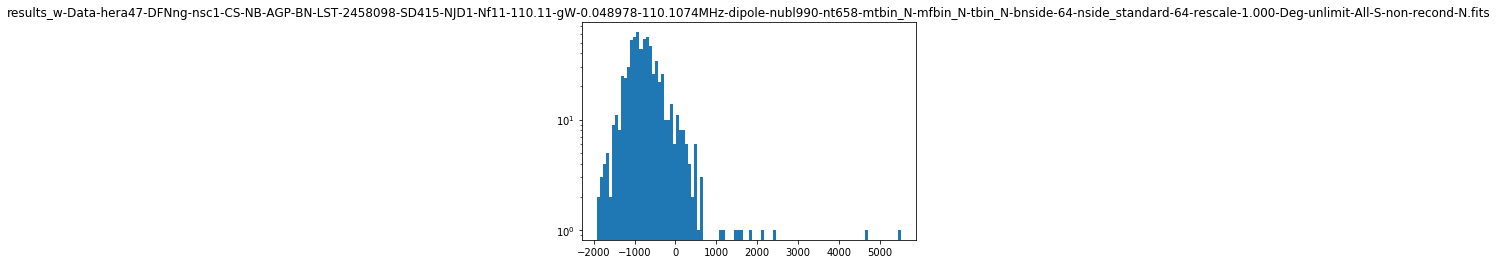

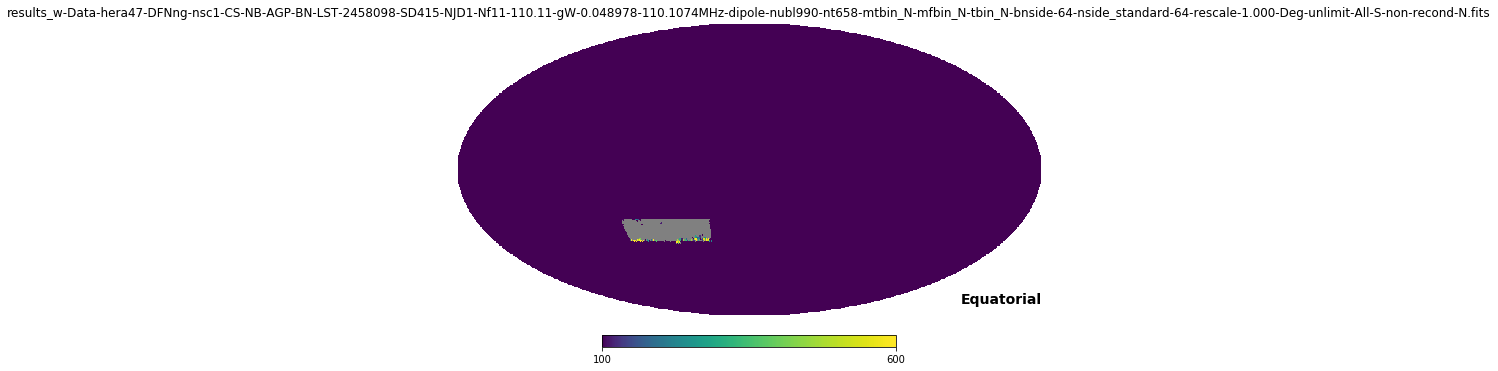

(1, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-114.79-gW-0.048978-114.7949MHz-dipole-nubl990-nt653-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 717.455437484
>>>>>>>> Maximum in the Map: 8172.06374422


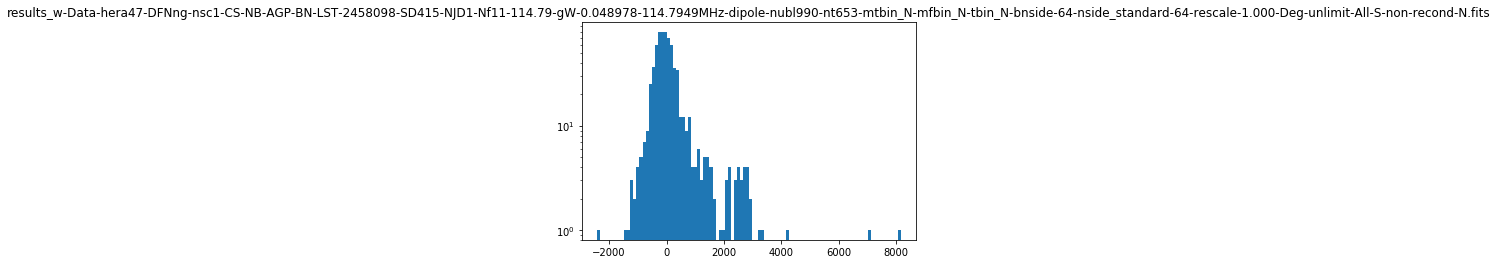

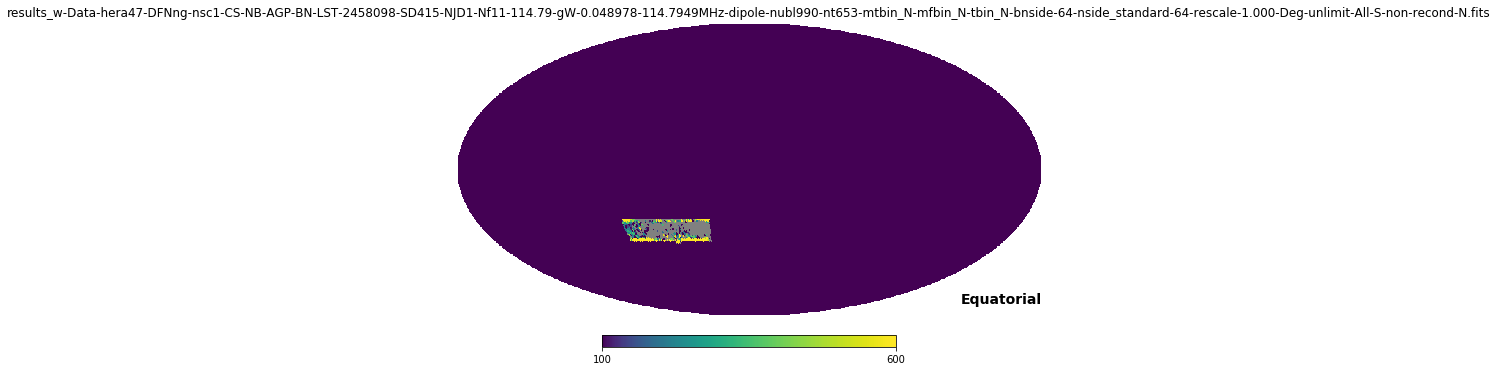

(2, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-119.48-gW-0.048978-119.4824MHz-dipole-nubl990-nt443-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 622.089238069
>>>>>>>> Maximum in the Map: 6117.80228803


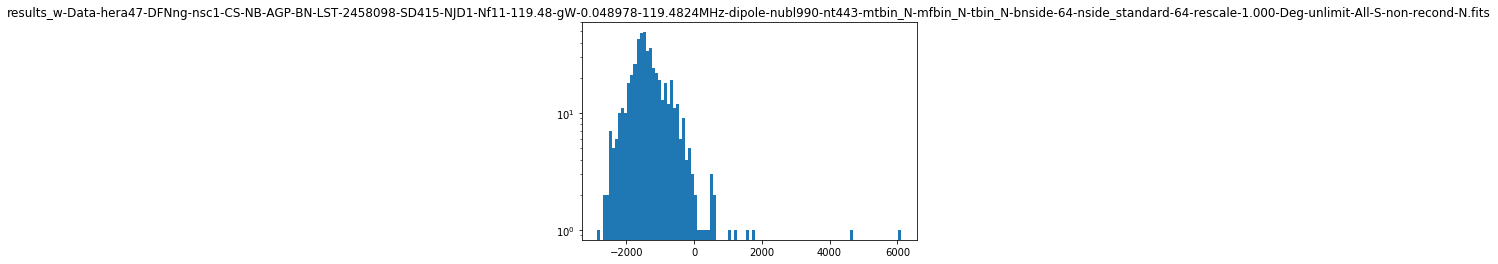

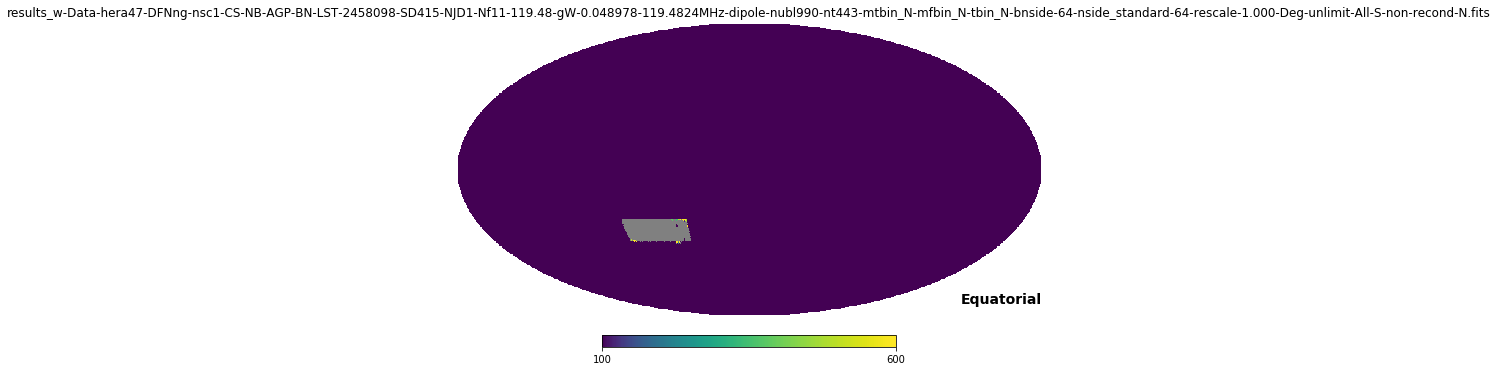

(3, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-130.42-gW-0.048978-130.4199MHz-dipole-nubl990-nt654-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 594.052606914
>>>>>>>> Maximum in the Map: 5346.8909116


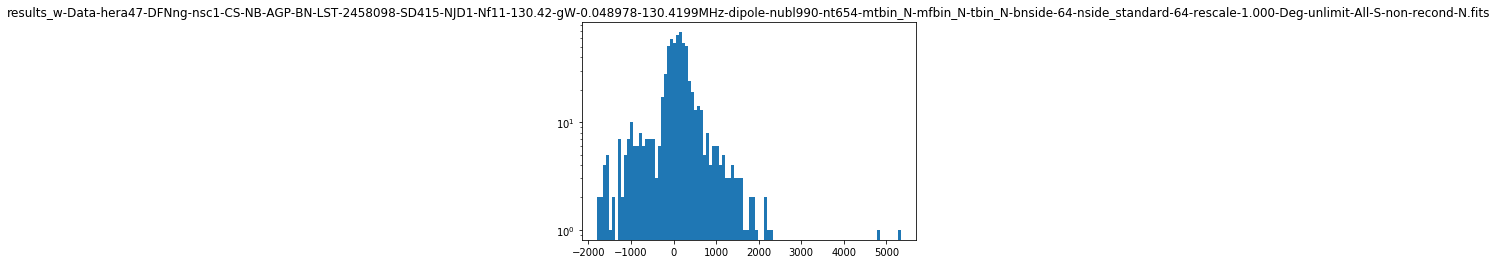

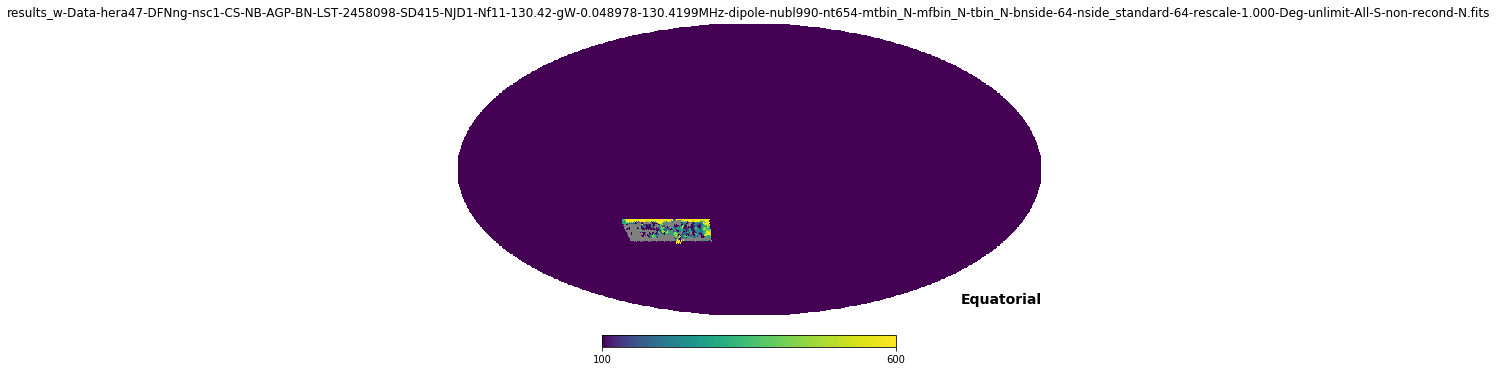

(4, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-139.79-gW-0.048978-139.7949MHz-dipole-nubl990-nt655-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 519.112259555
>>>>>>>> Maximum in the Map: 3177.06866036


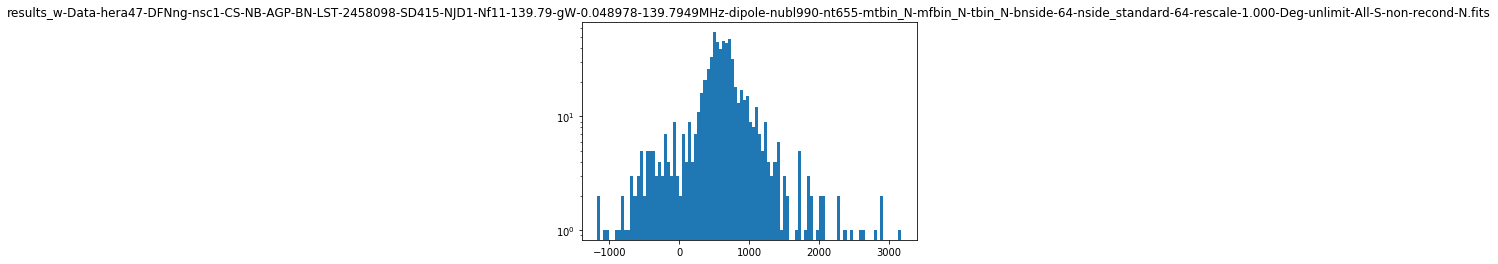

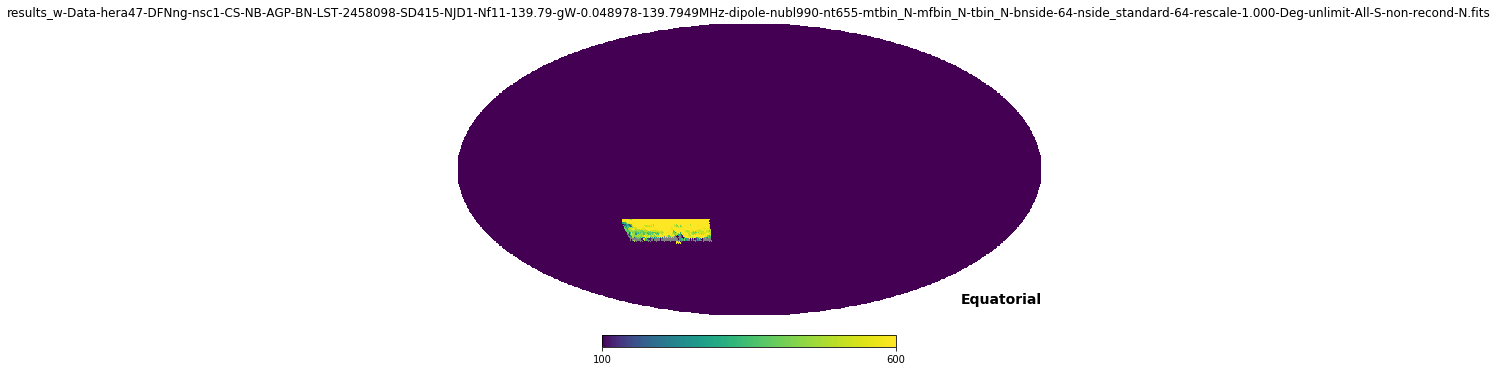

(5, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-150.73-gW-0.048978-150.7324MHz-dipole-nubl990-nt656-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 121.383061561
>>>>>>>> Maximum in the Map: 1278.57912228


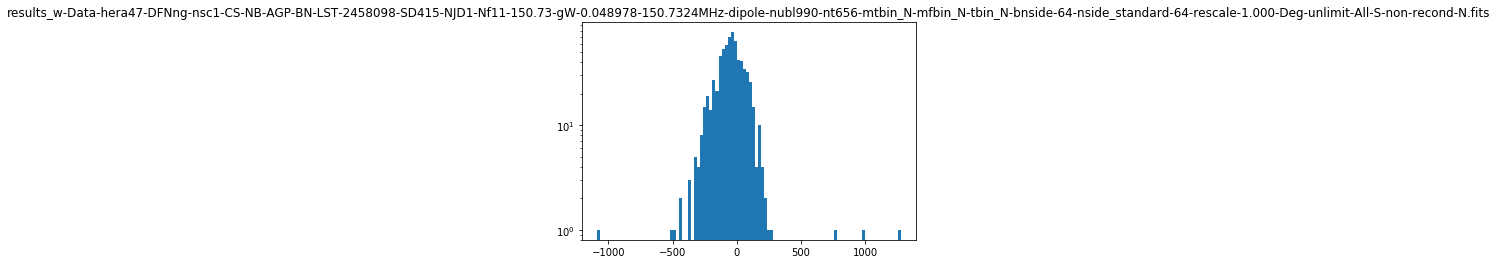

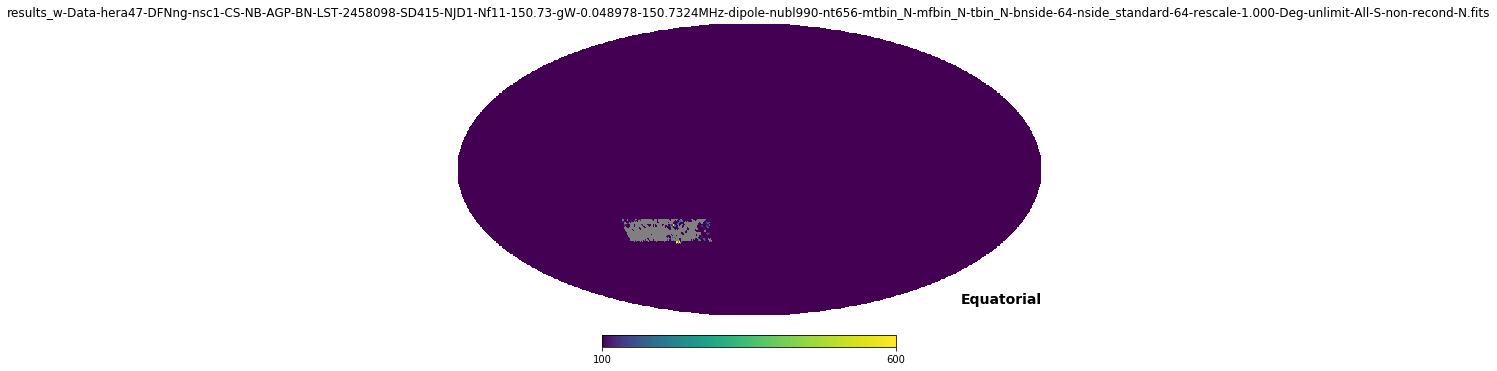

(6, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-160.11-gW-0.048978-160.1074MHz-dipole-nubl990-nt658-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 94.9559776693
>>>>>>>> Maximum in the Map: 2072.77274083


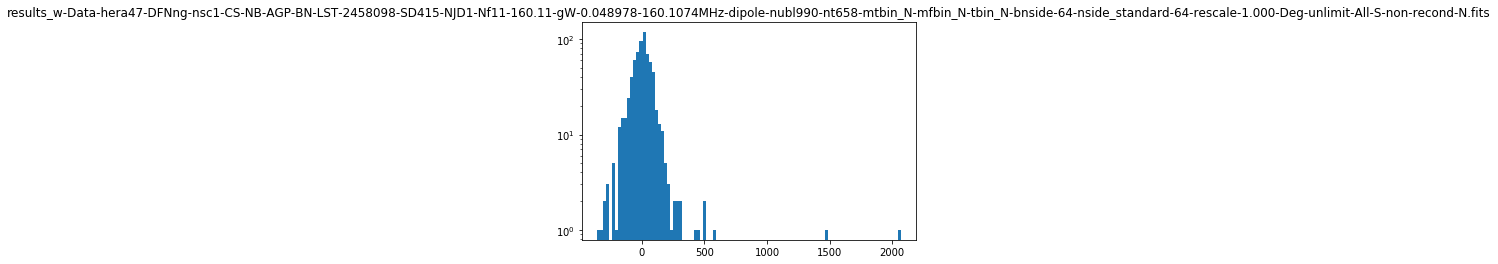

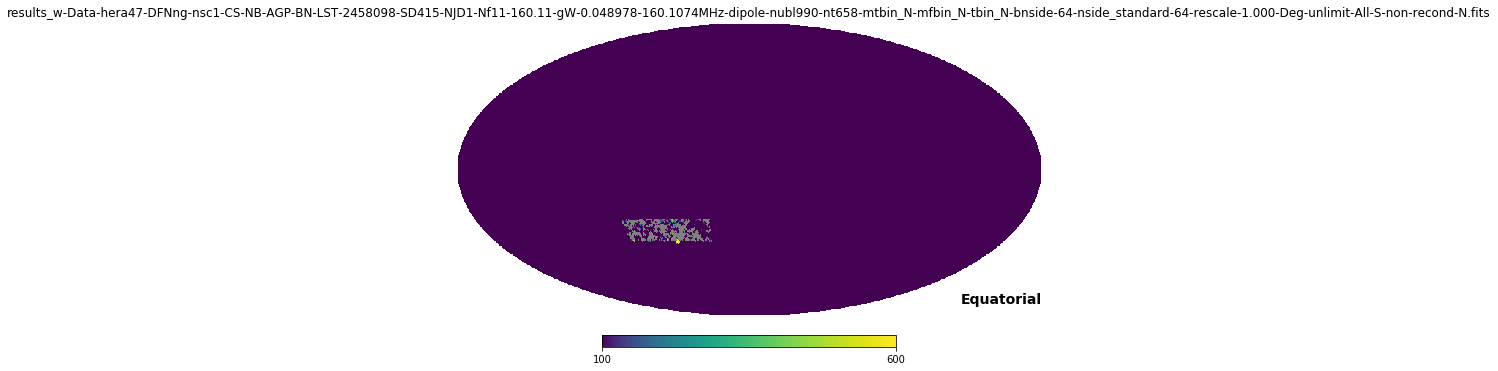

(7, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-169.48-gW-0.048978-169.4824MHz-dipole-nubl990-nt98-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 134.298237259
>>>>>>>> Maximum in the Map: 546.815317023


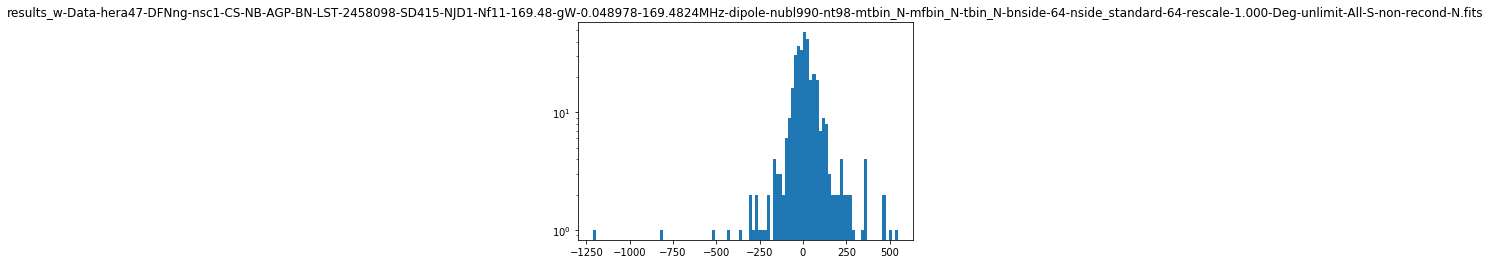

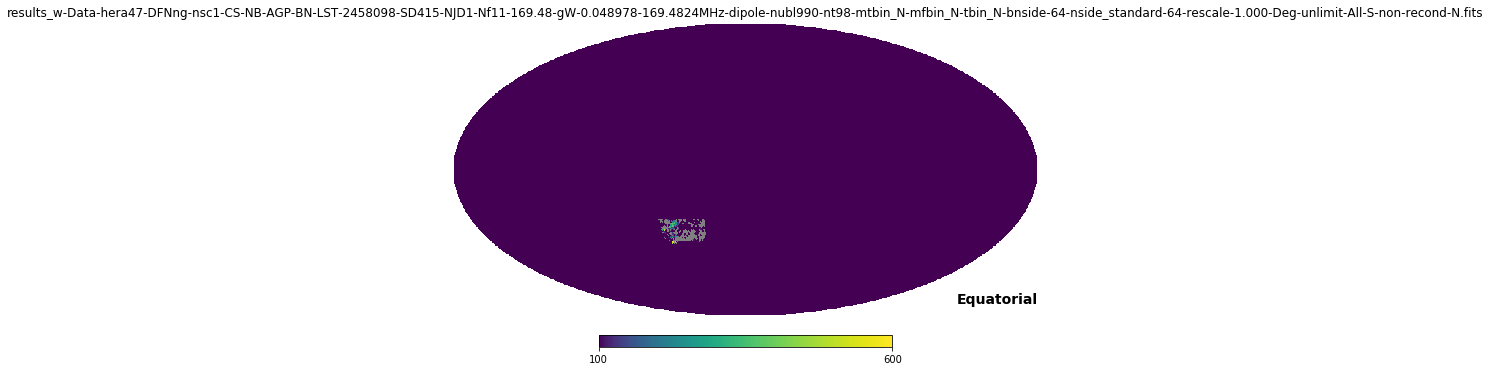

(8, 'results_w-Data-hera47-DFNng-nsc1-CS-NB-AGP-BN-LST-2458098-SD415-NJD1-Nf11-178.86-gW-0.048978-178.8574MHz-dipole-nubl990-nt541-mtbin_N-mfbin_N-tbin_N-bnside-64-nside_standard-64-rescale-1.000-Deg-unlimit-All-S-non-recond-N.fits')
>>>>>>>> STD of the Map64-part without Fornax A: 55.2747729703
>>>>>>>> Maximum in the Map: 795.209059297


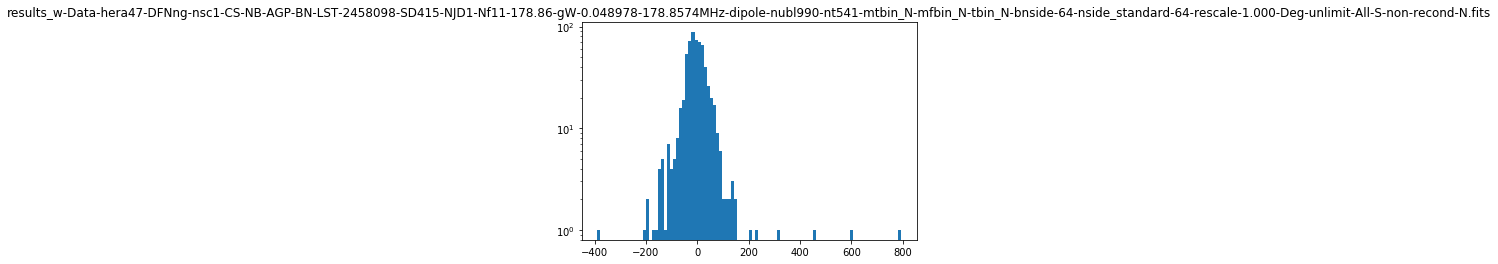

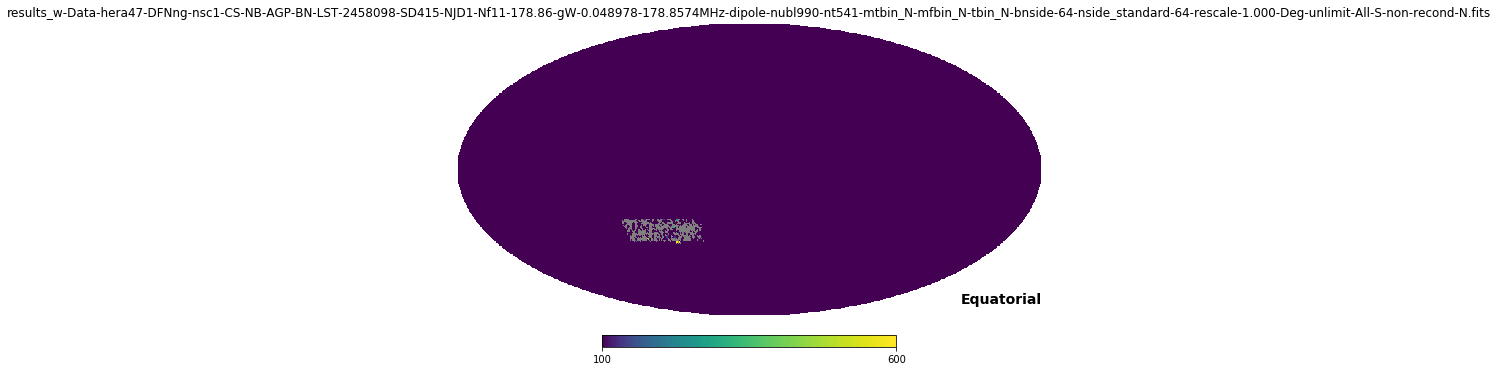

In [328]:
for id_file, fitfile in enumerate(filenames_64_415):
    name = fitfile.split('/')[-1]
    print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> STD of the Map64-part without Fornax A: {0}'.format(np.std(map_fit[np.argsort(map_fit)[:-2]][np.abs(map_fit[np.argsort(map_fit)[:-2]]) > 10**(-5)])))
    print('>>>>>>>> Maximum in the Map: {}'.format(map_fit.max()))
    plt.figure(350000 + id_file)
    plt.hist(map_fit[np.abs(map_fit) > 10**(-5)], bins=100, log=True)
    plt.title(name)
    plt.show()
    #plt.close()
    plt.figure(750000 + id_file)
    hp.mollview(map_fit, title=name, norm='log', min=100, max=600, coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
    #plt.close()

>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 523
>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 702
>>>>>>>> Number of Valid Pixels: 362
>>>>>>>> Number of Valid Pixels: 634
maps_mfreq_64_415 shape: (8, 49152)
maps_mfreq_common_64_415 shape: (8, 523)
Number of Common Valid Pixels-64_415: 523
EigenValues: 
[3.79907036e+04 2.06866572e+04 1.27883633e+04 1.02982053e+04
 8.49633111e+03 2.70973981e+03 1.68939845e+03 9.57424785e-12]

EigenValuesRatio: 
[6.49193239e-01 1.92486356e-01 7.35612749e-02 4.77026386e-02
 3.24699913e-02 3.30274085e-03 1.28375899e-03 4.12314537e-32]

EigenVectorsShape: (8, 523)

Maps64_Common_NewSpace shape: (8, 8)

Maps64_Common_NewSpace: [[ 1.42686453e+04  5.16346617e+03  2.68696197e+03  7.21046309e+03
   3.14698278e+03  1.32031312e+01 -1.08132909e+01  3.38500779e-12]
 [-5.44922113e+03  1.60491100e+04  2.658434

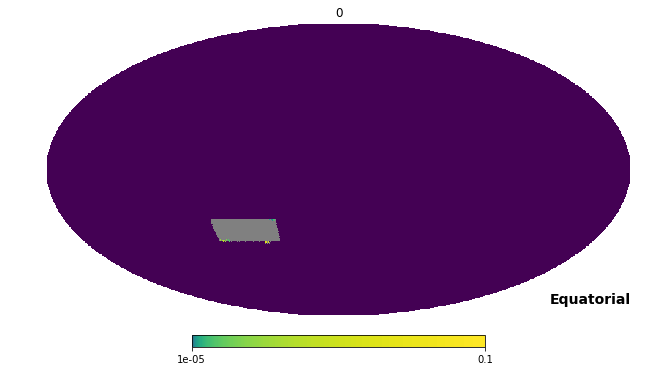

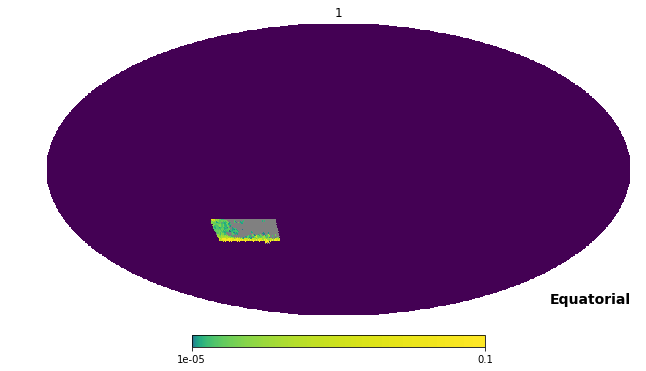

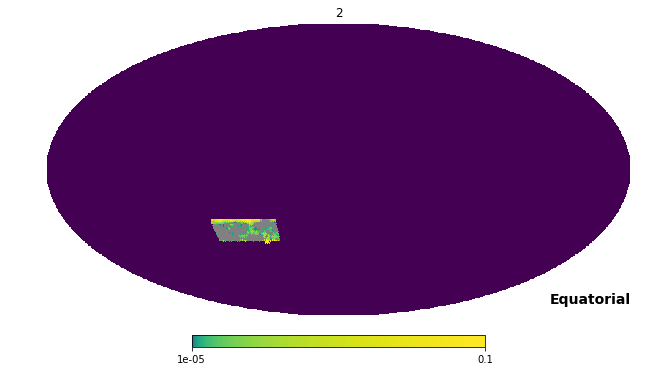

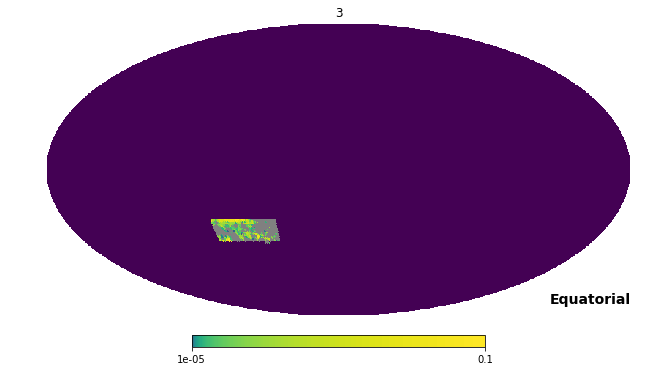

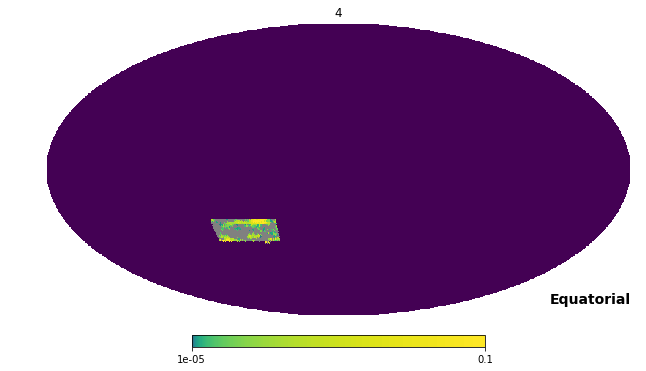

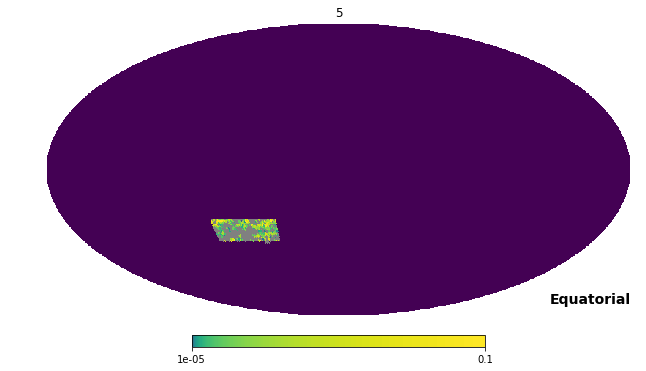

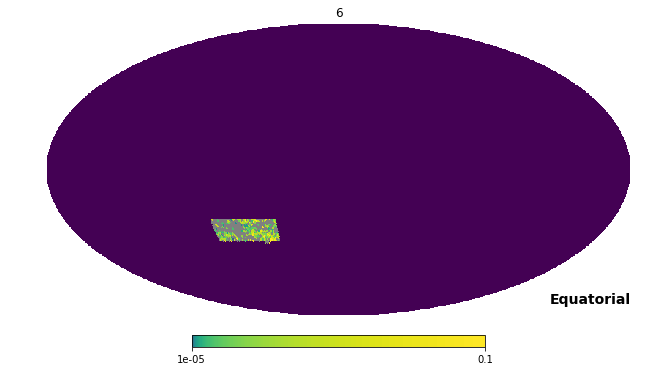

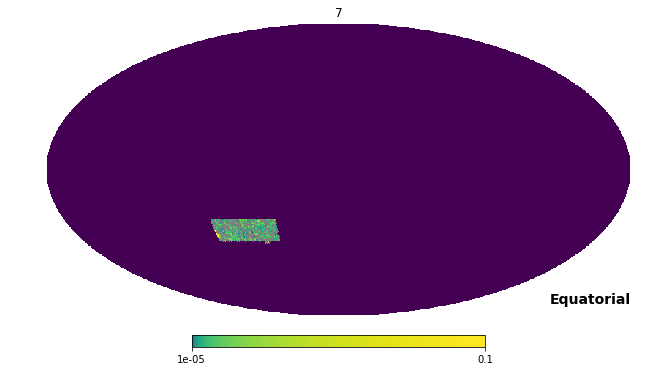

In [329]:
maps_mfreq_64_415 = []
for id_file, fitfile in enumerate(filenames_64_415):
    name = fitfile.split('/')[-1]
#     print(id_file, name)
    map_fit = fits.getdata(fitfile)
    print('>>>>>>>> Number of Valid Pixels: {}'.format(len(map_fit[np.abs(map_fit) > 10**(-5)])))
    
    if len(map_fit[np.abs(map_fit) > 10**(-5)]) > 500.:
        maps_mfreq_64_415.append(map_fit)
        
maps_mfreq_64_415 = np.array(maps_mfreq_64_415)
commom_vp_mask_64_415 = np.prod(np.abs(maps_mfreq_64_415) > 10.**(-5), axis=0).astype('bool')
maps_mfreq_common_64_415 = maps_mfreq_64_415[:, commom_vp_mask_64_415]
print('maps_mfreq_64_415 shape: {}'.format(maps_mfreq_64_415.shape))
print('maps_mfreq_common_64_415 shape: {}'.format(maps_mfreq_common_64_415.shape))
print('Number of Common Valid Pixels-64_415: {}'.format(np.sum(np.prod(np.abs(maps_mfreq_64_415) > 10.**(-5), axis=0))))

from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = PCA()
pca = PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.fit(maps_mfreq_common_64_415)
maps_mfreq_common_64_415_eigValues_ratio = pca.explained_variance_ratio_
maps_mfreq_common_64_415_eigValues = pca.singular_values_
maps_mfreq_common_64_415_eigVectors = pca.components_
maps_mfreq_common_64_415_newspace = pca.fit_transform(maps_mfreq_common_64_415)
print('EigenValues: \n{}\n'.format(maps_mfreq_common_64_415_eigValues))
print('EigenValuesRatio: \n{}\n'.format(maps_mfreq_common_64_415_eigValues_ratio))
print('EigenVectorsShape: {}\n'.format(maps_mfreq_common_64_415_eigVectors.shape))
print('Maps64_Common_NewSpace shape: {}\n'.format(maps_mfreq_common_64_415_newspace.shape))
print('Maps64_Common_NewSpace: {}'.format(maps_mfreq_common_64_415_newspace))

id_freq = 5
number_to_show = 30
print('maps_common pixel rank at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64_415[id_freq])[-number_to_show:]))
print('eignen_vectors pixel rank: \n{}\n'.format(np.argsort(maps_mfreq_common_64_415_eigVectors, axis=1)[:, -10:]))
print('reconstructed maps_common at {0}th freq: \n{1}\n'.format(id_freq, np.argsort(maps_mfreq_common_64_415_newspace[id_freq].dot(maps_mfreq_common_64_415_eigVectors))[-number_to_show:]))
print(np.sort(maps_mfreq_common_64_415[id_freq])[-number_to_show:])
print(np.sort(maps_mfreq_common_64_415_newspace[id_freq].dot(maps_mfreq_common_64_415_eigVectors))[-number_to_show:])

maps_mfreq_common_64_415_eigVectors_full = np.ones_like(maps_mfreq_64_415) * 10**(-5)
maps_mfreq_common_64_415_eigVectors_full[:, commom_vp_mask_64_415] = maps_mfreq_common_64_415_eigVectors
for id_eigvector,eigvector in enumerate(maps_mfreq_common_64_415_eigVectors_full):
    
#     print(np.linalg.norm(eigvector))
    plt.figure(1000000 + id_eigvector * 10)
    hp.mollview(eigvector, title=id_eigvector, norm='log', min=10.**(-5), max=10.**(-1), coord='C', nest=True)
    #hp.graticule(dmer=30., dpar=30.)
    plt.show()
#     plt.close()


In [330]:
nside_standard = 64
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

FornaxA_Direction = np.array([90. - thetas_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi,
                              phis_standard[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)] * 180. / np.pi])
FornaxA_Index = np.arange(len(thetas_standard))[np.isclose(90. - thetas_standard * 180. / np.pi, -37.20833, atol=2.) & np.isclose(phis_standard * 180. / np.pi, 50.67375, atol=2.)]

ww_solution_part415_64 = fits.getdata(filenames_64_415[5]).squeeze()
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(ww_solution_part415_64)[-120:]] * 180. / np.pi, phis_standard[np.argsort(ww_solution_part415_64)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(ww_solution_part415_64[np.argsort(ww_solution_part415_64)[-80:]]))





Bright_Pixels_Data: [[-36.42357364 -29.31319896 -28.63098984 -25.94447977 -34.95386526
  -29.31319896 -27.95318688 -30.         -29.31319896 -32.08995126
  -33.51005607 -28.63098984 -28.63098984 -30.69158768 -33.51005607
  -30.         -29.31319896 -36.42357364 -25.28260304 -32.7971683
  -32.7971683  -30.         -33.51005607 -30.69158768 -34.95386526
  -25.28260304 -25.28260304 -30.         -32.08995126 -25.28260304
  -25.28260304 -26.61009781 -27.95318688 -35.68533471 -27.95318688
  -26.61009781 -36.42357364 -25.94447977 -31.38816646 -28.63098984
  -31.38816646 -36.42357364 -26.61009781 -34.22886633 -27.27961274
  -26.61009781 -27.95318688 -28.63098984 -25.94447977 -29.31319896
  -28.63098984 -32.08995126 -27.27961274 -28.63098984 -32.08995126
  -25.28260304 -36.42357364 -25.94447977 -32.7971683  -27.95318688
  -27.27961274 -36.42357364 -27.27961274 -27.95318688 -35.68533471
  -25.28260304 -25.94447977 -33.51005607 -30.         -34.95386526
  -34.22886633 -29.31319896 -28.63098984 -2

Filename: /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/HERA_MapMaking_VisibilitySimulation/data/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard32-Eq.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   (12288,)   float64   
Data shape, min, max:  (12288,) 123.393245559361 7350.223968374633
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Bright_Pixels_Data: [[ 13.24801491 -58.91977535   2.38801546   7.18075578 -25.94447977
   14.47751219  -7.18075578 -46.57184741 -13.24801491 -20.74237995
  -40.22818473  40.22818473   9.59406823 -41.8103149    2.38801546
    8.38553865 -16.9577633  -25.94447977  -2.38801546 -44.99388015
  -24.62431835 -32.7971683  -61.94383702  -1.19374844  -4.78019185
  -55.87335044 -49.70239033   5.9791568  -46.57184741 -27.27961274
  -22.02431284 -54.3409123  -51.25580695  57.39952354 -43.40685849
  -18.2099568

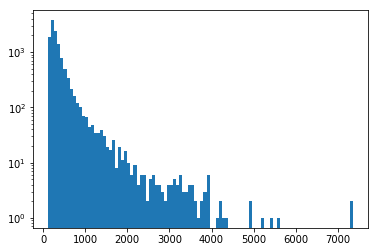

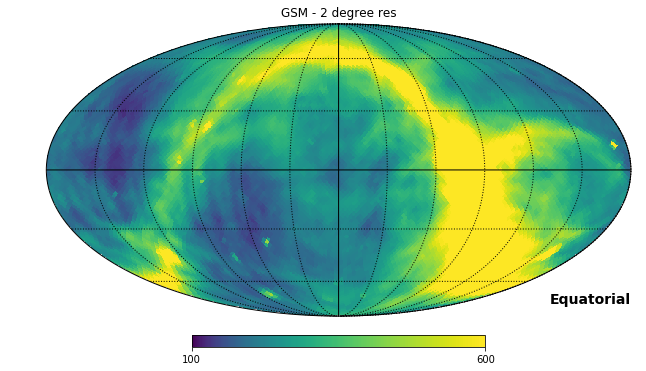

In [331]:
# GSM map with two degrees resolution
GSM32_path = DATA_PATH + '/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard32-Eq.fits'
hdul = fits.open(GSM32_path)
hdul.info()
hdr = hdul[0].header
data = hdul[0].data
hdr
print 'Data shape, min, max: ',data.shape, min(data), max(data)
testmap = fits.getdata(GSM32_path)
plt.hist(testmap,bins=100,log=True)
hdul.close()
hp.mollview(testmap, title="GSM - 2 degree res", norm='log', min=100, max=600, coord='C', nest=True)
hp.graticule(dmer=30,dpar=30)

nside_standard = 32
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(testmap)[-120:]] * 180. / np.pi, phis_standard[np.argsort(testmap)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(testmap[np.argsort(testmap)[-80:]]))

Filename: /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/HERA_MapMaking_VisibilitySimulation/data/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard64-Eq.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   (49152,)   float64   
Data shape, min, max:  (49152,) 119.61854632832329 12303.862241998748
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Bright_Pixels_Data: [[ -9.59406823 -41.01449967 -16.33482278 -34.95386526 -49.70239033
  -30.         -40.22818473 -13.24801491 -12.63562509 -39.45089471
  -10.80692287 -17.58277601 -21.38194258 -44.99388015 -42.60980698
  -11.41515774 -19.47122063 -45.78396716 -53.57223328 -52.80185378
  -32.7971683  -50.48004426 -23.96948232 -15.0947871  -20.74237995
  -37.16889966 -40.22818473  -6.57959294 -10.19991809 -32.08995126
  -32.7971683  -38.68218745 -46.57184741 -37.92165078 -52.02972742
  -48.1412

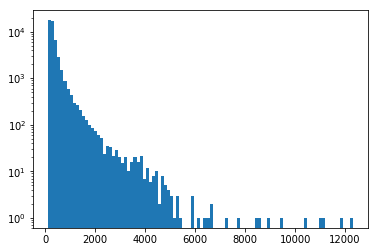

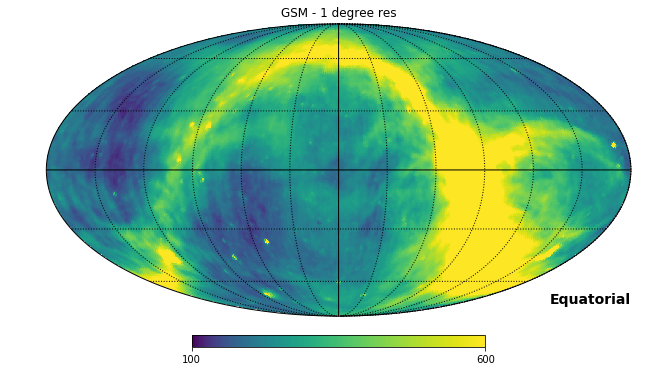

In [332]:
# GSM map with 1 degree resolution
GSM64_path = DATA_PATH + '/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard64-Eq.fits'
hdul = fits.open(GSM64_path)
hdul.info()
hdr = hdul[0].header
data = hdul[0].data
hdr
print 'Data shape, min, max: ',data.shape, min(data), max(data)
testmap = fits.getdata(GSM64_path)
plt.hist(testmap,bins=100,log=True)
hdul.close()
hp.mollview(testmap, title="GSM - 1 degree res", norm='log', min=100, max=600, coord='C', nest=True)
hp.graticule(dmer=30,dpar=30)

nside_standard = 64
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(testmap)[-120:]] * 180. / np.pi, phis_standard[np.argsort(testmap)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(testmap[np.argsort(testmap)[-80:]]))

Filename: /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/HERA_MapMaking_VisibilitySimulation/data/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard128-Eq.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   (196608,)   float64   
Data shape, min, max:  (196608,) 96.91450018645882 28811.904755314703
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Bright_Pixels_Data: [[-25.61308322 -25.94447977 -26.27681156 -34.95386526 -30.
  -31.03924001 -20.74237995 -22.02431284 -24.62431835 -22.3465879
  -26.94435818 -21.38194258  40.62018519 -32.08995126 -31.73839424
  -47.35757623 -47.74965083 -21.0618176  -25.94447977 -30.69158768
  -26.61009781 -22.3465879  -31.38816646 -21.0618176  -34.59057498
  -28.63098984 -22.99339431 -23.96948232 -46.57184741 -47.35757623
  -31.03924001 -22.66960987 -30.69158768 -22.02431284 -27.61588198
  -27.27961274 -2

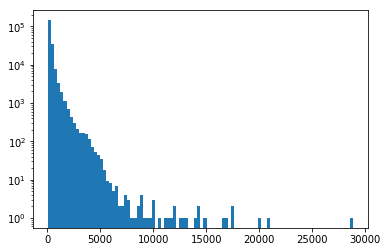

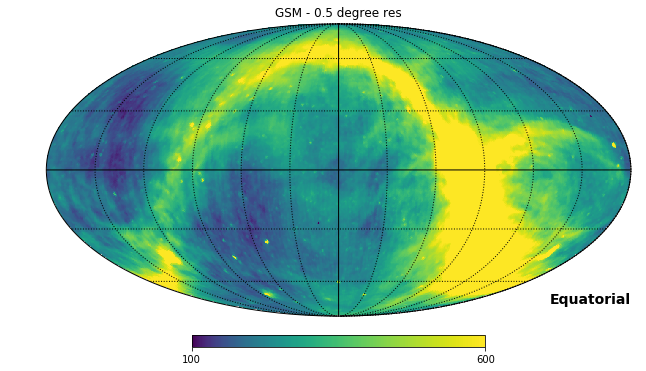

In [333]:
# GSM map with 1 degree resolution
GSM128_path = DATA_PATH + '/R_GSM_NoMask-Freq150.7324MHz-Nside_Standard128-Eq.fits'
hdul = fits.open(GSM128_path)
hdul.info()
hdr = hdul[0].header
data = hdul[0].data
hdr
print 'Data shape, min, max: ',data.shape, min(data), max(data)
testmap = fits.getdata(GSM128_path)
plt.hist(testmap,bins=100,log=True)
hdul.close()
hp.mollview(testmap, title="GSM - 0.5 degree res", norm='log', min=100, max=600, coord='C', nest=True)
hp.graticule(dmer=30,dpar=30)

nside_standard = 128
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
bright_pixels_Data = np.array([90. - thetas_standard[np.argsort(testmap)[-120:]] * 180. / np.pi, phis_standard[np.argsort(testmap)[-120:]] * 180. / np.pi])
print('Bright_Pixels_Data: {}'.format(bright_pixels_Data))
print('Top Flux: {}'.format(testmap[np.argsort(testmap)[-80:]]))

In [334]:
nside_standard = 128
lsts_width = 0.5
files_list = [globals()['GSM{0}_path'.format(nside_standard)]]*int(12./lsts_width)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
phis_standard[phis_standard>=np.pi] = -2*np.pi + phis_standard[phis_standard>=np.pi]
# print('file_list: {0}'.format(files_list))
print('thetas_standard_range: {0} to {1}'.format(thetas_standard.min(), thetas_standard.max()))
print('phis_standard_range: {0} to {1}'.format(phis_standard.min(), phis_standard.max()))

thetas_standard_range: 0.00637889035343 to 3.13521376324
phis_standard_range: -3.14159265359 to 3.13545673044


Shape of sky_maps: (24, 196608)
Length of id_pixel_list[0]: 638
Length of id_pixel_list[1]: 609
Length of id_pixel_list[2]: 638
Length of id_pixel_list[3]: 609
Length of id_pixel_list[4]: 609
Length of id_pixel_list[5]: 609
Length of id_pixel_list[6]: 638
Length of id_pixel_list[7]: 609
Length of id_pixel_list[8]: 638
Length of id_pixel_list[9]: 609
Length of id_pixel_list[10]: 609
Length of id_pixel_list[11]: 609
Length of id_pixel_list[12]: 638
Length of id_pixel_list[13]: 609
Length of id_pixel_list[14]: 609
Length of id_pixel_list[15]: 638
Length of id_pixel_list[16]: 609
Length of id_pixel_list[17]: 609
Length of id_pixel_list[18]: 638
Length of id_pixel_list[19]: 609
Length of id_pixel_list[20]: 609
Length of id_pixel_list[21]: 638
Length of id_pixel_list[22]: 609
Length of id_pixel_list[23]: 609
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


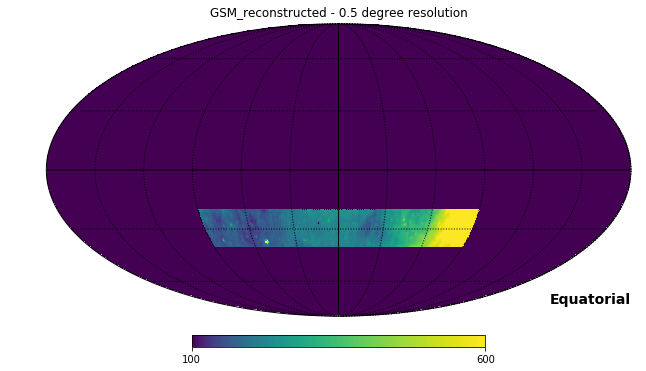

In [335]:
id_pixel_list = {}
reconstruct_map = np.zeros(12*nside_standard**2) + 10.**(-10)
sky_maps = np.ones((len(files_list), 12*nside_standard**2))
print('Shape of sky_maps: {0}'.format(sky_maps.shape))
for id_file, fname in enumerate(files_list):
    sky_maps[id_file] = fits.getdata(fname)
#     print('Shape of sky_maps: {0}'.format(sky_maps[id_file].shape))
    id_pixel_list[id_file] = (sky_map > 0.) \
                    & (phis_standard >= (-6. + id_file*lsts_width)/12. * np.pi) \
                    & (phis_standard < (-6. + (id_file+1)*lsts_width)/12 * np.pi) \
                    & (thetas_standard >= ((90.+20.)/180.*np.pi)) \
                    & (thetas_standard < ((90.+40.)/180.*np.pi))
    print('Length of id_pixel_list[{0}]: {1}'.format(id_file, np.sum(id_pixel_list[id_file])))
    reconstruct_map[id_pixel_list[id_file]] = sky_maps[id_file][id_pixel_list[id_file]]

hp.mollview(reconstruct_map, title="GSM_reconstructed - {0} degree resolution".format(64./nside_standard), norm='log', min=100, max=600, coord='C', nest=True)
hp.graticule(dmer=30,dpar=30)

In [336]:
reconstruct_map[id_pixel_list[0]].shape

(638,)

In [337]:
import datetime
print('Current time: {0} \n'.format(datetime.datetime.now()))
np.linalg.norm(np.ones((2,3)), axis=-1)

Current time: 2018-10-10 16:44:02.256773 



array([1.73205081, 1.73205081])

In [338]:
np.linalg.inv(np.diag((5,5)).astype('complex64'))

array([[0.2+0.j, 0. +0.j],
       [0. +0.j, 0.2+0.j]], dtype=complex64)